# Masterthesis
## Regression

#### Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import category_encoders as ce
import sklearn as sk
import seaborn as sns
from tensorflow.python.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV, KFold 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.pyplot as plt
from scipy import stats

Using TensorFlow backend.


In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT']

In [3]:
df = pd.read_csv('resources/accident_data.csv', sep=";", na_values=na_values, index_col=False, dtype = {"STATE" : "str", "TYPE" : "str", "TYPEQ" : "str", "WEATHER" : "str", "VISIBLTY" : "str", "SPD_TOO_HIGH" : "str"})

In [4]:
df=df.dropna(subset=['WEATHER', 'VISIBLTY'])
pd.set_option('display.max_columns', 500)
#df.head(50)

## Vorbereitungen

Festlegen der abhängigen Variablen X und der vorherzusagenden Variable y

In [5]:
x_data = df[['TEMP', 'TYPEQ', 'TRKCLAS', 'ACCCAUSE_LVL1', 'ACCCAUSE_LVL2', 'ACCAUSE', 'YEAR4', 'STATE', 'MONTH', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']]

In [6]:
y = df['INFRASTRUCTURE_DMG']

In [7]:
print(x_data.isnull().sum())

TEMP              0
TYPEQ             0
TRKCLAS           0
ACCCAUSE_LVL1     0
ACCCAUSE_LVL2     0
ACCAUSE           0
YEAR4             0
STATE             0
MONTH             0
LOCOMOTIVES1      0
LOADF1            0
LOADP1            0
EMPTYF1           0
EMPTYP1           0
LOCOMOTIVES2      0
LOADF2            0
EMPTYF2           0
LOADP2            0
EMPTYP2           0
TONS              0
TEMP_CLUSTER      0
SPEED             0
ACCCAUSE_LVL1     0
TYPE              0
EQUIPMENT_TYPE    0
TYPTRK            0
VISIBLTY          0
WEATHER           0
SPD_TOO_HIGH      0
ACCTYPE           0
ACCIDENT_TYPE     0
Jahreszeit        0
dtype: int64


## Umwandlung der kategorialen Merkmale und Normalisierung der kontinuierlichen Merkmale

In [8]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem One Hot Encoder 
# x = kategoriale Merkmale
def prepare_inputs_One_Hot(x):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [9]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Ordinal Encoder 
# x = kategoriale Merkmale
def prepare_inputs_Ordinal(x):
    encoder = OrdinalEncoder()
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [10]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Binary Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale
def prepare_inputs_Binary(x, cats):
    encoder = ce.BinaryEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats])
    df_bin = encoder.transform(x[cats])
    return df_bin

In [11]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Target Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Target(x, Y, cats, smoothing=1):
    encoder = ce.TargetEncoder(cols=cats, return_df=True, min_samples_leaf = 5, smoothing=smoothing)
    encoder.fit(x[cats], Y)
    df_te = encoder.transform(x[cats], Y)
    return df_te

In [12]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Leave One Out Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Leave_One_Out(x, Y, cats):
    encoder = ce.LeaveOneOutEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats], Y)
    df_loo = encoder.transform(x[cats], Y)
    return df_loo

### Merkmale





In [13]:
# Festlegen der kategorialen Merkmale für das Modell
cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'ACCTYPE', 'TRKCLAS']

In [14]:
# Festlegen der kontinuierlichen Merkmale für das Moadell
con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1' , 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

#### Umwandlung der kategorialen Merkmale

In [15]:
#x_enc_cat = prepare_inputs_Ordinal(x_data[cat])

In [16]:
x_enc_cat = prepare_inputs_One_Hot(x_data[cat])

In [17]:
#x_enc_cat = prepare_inputs_Binary(x_data, cat)

In [18]:
#x_enc_cat = prepare_inputs_Target(x_data, y, cat)

In [19]:
#x_enc_cat = prepare_inputs_Leave_One_Out(x_data, y, cat)

#### Normalisierung der kontinuierlichen Merkmale

In [20]:
# Normalisierung der kontinuierlichen Merkmale mit dem StandardScaler oder dem MinMaxScaler
#cs = MinMaxScaler().fit(x_data[con])
cs = StandardScaler().fit(x_data[con])
x_enc_con = cs.transform(x_data[con])
#x_enc_con = x_data[con]

#### Zusammenfügen der kategorialen und kontinuierlichen Merkmale

In [22]:
X_Data = np.hstack([x_enc_cat, x_enc_con])

#### Aufteilen der Merkmale in Trainings- und Testdaten
70% Trainingsdaten & 30 % Testdaten
random_state: Kontrolliert die Zufallsverteilung -> Es werden immer die gleichen Werte Trainings- und Testdaten zugeteilt. Sonst könnte es zu Abweichungen bei den Ergebnissen des Modells kommen

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, y, test_size=0.3, random_state=42)

In [24]:
n_features = X_train.shape[1]

## Regression Allgemein

In [25]:
# Festlegen der Anzahl der Durchläufe
epochs = 300

In [26]:
epochs

300

In [27]:
# Festlegen der Lernrate
learning_rate = 0.00075

In [28]:
learning_rate

0.00075

In [29]:
# Festlegen der Dropout Rate
dropout = 0

In [30]:
dropout

0

In [31]:
# Festlegen der verwendeten Regressionsmetriken
metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']

In [32]:
# Festlegen der Aktivierungsfunktion
activation = 'relu'
activation2='relu'

In [33]:
# Initialisierung der Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#opt = tf.keras.optimizers.Adadelta()
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [41]:
# Initialisierung der Modelloptimierungsfunktionen
es = EarlyStopping(monitor='val_loss', patience=6)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [34]:
# Festlegen der Anzahl der Hidden Layers
hidden_layers = 3

In [35]:
# Festlegen der Anzahl der Neuronen
neurons = 512

## Sequential regression model

In [106]:
# Funktion zur Erstellung eines KNN-Regressionmodells mit der Keras Sequential API
def create_model(learning_rate = 0.001, activation = 'relu', activation2='relu', dropout=0, opt = None, hidden_layers=1, initital_neurons=n_features):
    seq_model = Sequential()
    
    if (opt == None):
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
     
    seq_model.add(Dense(int(initital_neurons), activation=activation, input_shape=(n_features,)))
    if (dropout > 0):    
        seq_model.add(Dropout(dropout))
    if (hidden_layers > 1):
        i=1
        hidden_neurons = int(initital_neurons)
        while (i<=(hidden_layers-1)):
            neurons = int(hidden_neurons/(i+1))
            if (neurons <= 0):
                neurons = n_features
            seq_model.add(Dense(neurons, activation=activation2))
            if (dropout > 0):    
                seq_model.add(Dropout(dropout))
            i+=1
    seq_model.add(Dense(1))
    seq_model.compile(optimizer=opt, loss='mse', metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return seq_model

In [107]:
model = KerasRegressor(build_fn = create_model)

In [108]:
params = {'dropout': [0, 0.7], 'epochs': [50, 150, 300],'learning_rate': [0.01, 0.00075], 'hidden_layers' : [hidden_layers, hidden_layers-1], 'initital_neurons' : [neurons, neurons/2]}

In [39]:
scoring = {'MSE': 'neg_mean_squared_error', 'r2' : 'r2', 'mae': 'neg_mean_absolute_error'}

In [109]:
random_search = RandomizedSearchCV(model, param_distributions = params,cv = KFold(20), return_train_score=True, scoring=scoring, refit='MSE')

In [110]:
# Zur Ausführung deer SearchCV Funktion müssen die folgenden Befehle auskommentiert werden
random_search_results = random_search.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7871585280.0000 - mse: 7871585280.0000 - rmse: 88721.9531 - mae: 40985.9336 - val_loss: 6442092544.0000 - val_mse: 6442092544.0000 - val_rmse: 80262.6484 - val_mae: 36117.8086
Epoch 2/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7113326592.0000 - mse: 7113326592.0000 - rmse: 84340.5391 - mae: 38205.5586 - val_loss: 6309061632.0000 - val_mse: 6309061632.0000 - val_rmse: 79429.6016 - val_mae: 36622.5664
Epoch 3/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6579765760.0000 - mse: 6579765760.0000 - rmse: 81115.7578 - mae: 37681.4062 - val_loss: 6179923968.0000 - val_mse: 6179923968.0000 - val_rmse: 78612.4922 - val_mae: 36715.8281
Epoch 4/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6555399680.0000 - mse: 6555399680.0000 - rmse: 80965.4219 - mae: 37518.4961 - val_loss: 6145481728.0000 - val_mse: 6145481728.0000 - val_rmse: 78393.1250 - val_mae:

1315/1315 [==============================] - 2s 2ms/step - loss: 5644157440.0000 - mse: 5644157440.0000 - rmse: 75127.6094 - mae: 35521.4766 - val_loss: 6408123904.0000 - val_mse: 6408123904.0000 - val_rmse: 80050.7578 - val_mae: 37681.5977
Epoch 18/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5723374592.0000 - mse: 5723374592.0000 - rmse: 75652.9844 - mae: 35473.2539 - val_loss: 6112830464.0000 - val_mse: 6112830464.0000 - val_rmse: 78184.5938 - val_mae: 36101.6992
Epoch 1/150
1315/1315 [==============================] - 2s 2ms/step - loss: 8170783232.0000 - mse: 8170783232.0000 - rmse: 90392.3828 - mae: 41384.8594 - val_loss: 6500306944.0000 - val_mse: 6500306944.0000 - val_rmse: 80624.4844 - val_mae: 38422.6875
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6834835456.0000 - mse: 6834835456.0000 - rmse: 82673.0625 - mae: 38207.5859 - val_loss: 6464708608.0000 - val_mse: 6464708608.0000 - val_rmse: 80403.4141 - val_mae: 37832.4102

1315/1315 [==============================] - 2s 2ms/step - loss: 5822281216.0000 - mse: 5822281216.0000 - rmse: 76303.8750 - mae: 35762.8672 - val_loss: 6206677504.0000 - val_mse: 6206677504.0000 - val_rmse: 78782.4688 - val_mae: 36869.7930
Epoch 14/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5755214848.0000 - mse: 5755214848.0000 - rmse: 75863.1328 - mae: 35646.6055 - val_loss: 6023062528.0000 - val_mse: 6023062528.0000 - val_rmse: 77608.3906 - val_mae: 36609.8750
Epoch 15/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5710839296.0000 - mse: 5710839296.0000 - rmse: 75570.0938 - mae: 35490.2891 - val_loss: 6219458560.0000 - val_mse: 6219458560.0000 - val_rmse: 78863.5469 - val_mae: 34988.3945
Epoch 16/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5602943488.0000 - mse: 5602943488.0000 - rmse: 74852.8125 - mae: 35351.0156 - val_loss: 6086888960.0000 - val_mse: 6086888960.0000 - val_rmse: 78018.5156 - val_mae: 36031.34

1315/1315 [==============================] - 2s 2ms/step - loss: 6418469888.0000 - mse: 6418469888.0000 - rmse: 80115.3516 - mae: 36953.5586 - val_loss: 5960183808.0000 - val_mse: 5960183808.0000 - val_rmse: 77202.2266 - val_mae: 36695.2812
Epoch 10/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6214845952.0000 - mse: 6214845952.0000 - rmse: 78834.2969 - mae: 36801.8281 - val_loss: 6026697728.0000 - val_mse: 6026697728.0000 - val_rmse: 77631.8125 - val_mae: 35567.6406
Epoch 11/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6202879488.0000 - mse: 6202879488.0000 - rmse: 78758.3594 - mae: 36652.7227 - val_loss: 6241738752.0000 - val_mse: 6241738752.0000 - val_rmse: 79004.6719 - val_mae: 35969.7344
Epoch 12/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6099033600.0000 - mse: 6099033600.0000 - rmse: 78096.3125 - mae: 36501.7344 - val_loss: 6045060608.0000 - val_mse: 6045060608.0000 - val_rmse: 77749.9844 - val_mae: 37603.75

1315/1315 [==============================] - 2s 1ms/step - loss: 6634810368.0000 - mse: 6634810368.0000 - rmse: 81454.3438 - mae: 37768.1719 - val_loss: 6180570112.0000 - val_mse: 6180570112.0000 - val_rmse: 78616.6016 - val_mae: 35842.4531
Epoch 4/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6476409856.0000 - mse: 6476409856.0000 - rmse: 80476.1484 - mae: 37258.3516 - val_loss: 6296522752.0000 - val_mse: 6296522752.0000 - val_rmse: 79350.6328 - val_mae: 36116.1719
Epoch 5/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6745700864.0000 - mse: 6745700864.0000 - rmse: 82132.2188 - mae: 37633.6641 - val_loss: 6367572480.0000 - val_mse: 6367572480.0000 - val_rmse: 79797.0703 - val_mae: 36925.5078
Epoch 6/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6391044608.0000 - mse: 6391044608.0000 - rmse: 79944.0078 - mae: 37155.6758 - val_loss: 6130678272.0000 - val_mse: 6130678272.0000 - val_rmse: 78298.6484 - val_mae: 35311.3672


1315/1315 [==============================] - 2s 2ms/step - loss: 5615187968.0000 - mse: 5615187968.0000 - rmse: 74934.5547 - mae: 35210.5625 - val_loss: 5999464960.0000 - val_mse: 5999464960.0000 - val_rmse: 77456.2109 - val_mae: 36843.8320
Epoch 19/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5534712320.0000 - mse: 5534712320.0000 - rmse: 74395.6484 - mae: 35058.3008 - val_loss: 6133058048.0000 - val_mse: 6133058048.0000 - val_rmse: 78313.8438 - val_mae: 34458.5977
Epoch 1/150
1315/1315 [==============================] - 2s 2ms/step - loss: 8007727104.0000 - mse: 8007727104.0000 - rmse: 89485.9062 - mae: 41064.6133 - val_loss: 6447628288.0000 - val_mse: 6447628288.0000 - val_rmse: 80297.1250 - val_mae: 37670.0117
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6834851840.0000 - mse: 6834851840.0000 - rmse: 82673.1641 - mae: 38227.7266 - val_loss: 6227528704.0000 - val_mse: 6227528704.0000 - val_rmse: 78914.6953 - val_mae: 39862.4375

1315/1315 [==============================] - 2s 2ms/step - loss: 6827663360.0000 - mse: 6827663360.0000 - rmse: 82629.6797 - mae: 38310.8086 - val_loss: 6198492672.0000 - val_mse: 6198492672.0000 - val_rmse: 78730.5078 - val_mae: 36567.0625
Epoch 3/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6614869504.0000 - mse: 6614869504.0000 - rmse: 81331.8516 - mae: 37747.4492 - val_loss: 6403295744.0000 - val_mse: 6403295744.0000 - val_rmse: 80020.5938 - val_mae: 38683.0938
Epoch 4/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6561563136.0000 - mse: 6561563136.0000 - rmse: 81003.4766 - mae: 37493.4805 - val_loss: 6394118656.0000 - val_mse: 6394118656.0000 - val_rmse: 79963.2344 - val_mae: 34834.8359
Epoch 5/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6557768192.0000 - mse: 6557768192.0000 - rmse: 80980.0469 - mae: 37156.4453 - val_loss: 6116838400.0000 - val_mse: 6116838400.0000 - val_rmse: 78210.2188 - val_mae: 35338.4766


1315/1315 [==============================] - 2s 2ms/step - loss: 5847955968.0000 - mse: 5847955968.0000 - rmse: 76471.9297 - mae: 35601.8516 - val_loss: 6010580480.0000 - val_mse: 6010580480.0000 - val_rmse: 77527.9297 - val_mae: 34819.4805
Epoch 15/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5796470784.0000 - mse: 5796470784.0000 - rmse: 76134.5547 - mae: 35540.6055 - val_loss: 6182418432.0000 - val_mse: 6182418432.0000 - val_rmse: 78628.3594 - val_mae: 37319.5703
Epoch 1/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7743003136.0000 - mse: 7743003136.0000 - rmse: 87994.3359 - mae: 40680.9922 - val_loss: 6463361024.0000 - val_mse: 6463361024.0000 - val_rmse: 80395.0312 - val_mae: 36452.6641
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6786449408.0000 - mse: 6786449408.0000 - rmse: 82379.9062 - mae: 37992.5508 - val_loss: 6591114752.0000 - val_mse: 6591114752.0000 - val_rmse: 81185.6797 - val_mae: 35996.3438

1315/1315 [==============================] - 2s 2ms/step - loss: 6231075328.0000 - mse: 6231075328.0000 - rmse: 78937.1641 - mae: 36765.8750 - val_loss: 5939982336.0000 - val_mse: 5939982336.0000 - val_rmse: 77071.2812 - val_mae: 36045.6719
Epoch 8/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6172617216.0000 - mse: 6172617216.0000 - rmse: 78566.0078 - mae: 36457.3984 - val_loss: 5953652736.0000 - val_mse: 5953652736.0000 - val_rmse: 77159.9141 - val_mae: 35312.1367
Epoch 9/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6138885632.0000 - mse: 6138885632.0000 - rmse: 78351.0391 - mae: 36447.4844 - val_loss: 6070187008.0000 - val_mse: 6070187008.0000 - val_rmse: 77911.4062 - val_mae: 36899.3594
Epoch 10/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6059172864.0000 - mse: 6059172864.0000 - rmse: 77840.6875 - mae: 36208.0820 - val_loss: 6069287424.0000 - val_mse: 6069287424.0000 - val_rmse: 77905.6328 - val_mae: 34925.8008

1316/1316 [==============================] - 2s 2ms/step - loss: 5740598272.0000 - mse: 5740598272.0000 - rmse: 75766.7344 - mae: 35383.3516 - val_loss: 6065946112.0000 - val_mse: 6065946112.0000 - val_rmse: 77884.1875 - val_mae: 36688.3086
Epoch 16/150
1316/1316 [==============================] - 2s 2ms/step - loss: 5566467072.0000 - mse: 5566467072.0000 - rmse: 74608.7578 - mae: 35109.7695 - val_loss: 6145700352.0000 - val_mse: 6145700352.0000 - val_rmse: 78394.5156 - val_mae: 35660.8477
Epoch 17/150
1316/1316 [==============================] - 2s 2ms/step - loss: 5459587584.0000 - mse: 5459587584.0000 - rmse: 73889.0234 - mae: 34931.1875 - val_loss: 6029737472.0000 - val_mse: 6029737472.0000 - val_rmse: 77651.3828 - val_mae: 34874.3711
Epoch 18/150
1316/1316 [==============================] - 2s 1ms/step - loss: 5465804800.0000 - mse: 5465804800.0000 - rmse: 73931.0781 - mae: 34956.3672 - val_loss: 6137733632.0000 - val_mse: 6137733632.0000 - val_rmse: 78343.6875 - val_mae: 35546.83

1316/1316 [==============================] - 2s 1ms/step - loss: 5985526784.0000 - mse: 5985526784.0000 - rmse: 77366.1875 - mae: 35955.4844 - val_loss: 5901041664.0000 - val_mse: 5901041664.0000 - val_rmse: 76818.2344 - val_mae: 35703.4531
Epoch 12/150
1316/1316 [==============================] - 2s 1ms/step - loss: 5937159680.0000 - mse: 5937159680.0000 - rmse: 77052.9688 - mae: 35801.3438 - val_loss: 5977122304.0000 - val_mse: 5977122304.0000 - val_rmse: 77311.8516 - val_mae: 34478.4648
Epoch 13/150
1316/1316 [==============================] - 2s 1ms/step - loss: 5800896000.0000 - mse: 5800896000.0000 - rmse: 76163.6172 - mae: 35632.9648 - val_loss: 6515026432.0000 - val_mse: 6515026432.0000 - val_rmse: 80715.7109 - val_mae: 39368.0469
Epoch 14/150
1316/1316 [==============================] - 2s 1ms/step - loss: 5759298048.0000 - mse: 5759298048.0000 - rmse: 75890.0391 - mae: 35630.9102 - val_loss: 6201505792.0000 - val_mse: 6201505792.0000 - val_rmse: 78749.6406 - val_mae: 35095.51

1315/1315 [==============================] - 1s 1ms/step - loss: 7216162304.0000 - mse: 7216162304.0000 - rmse: 84948.0000 - mae: 38574.5781 - val_loss: 6305512960.0000 - val_mse: 6305512960.0000 - val_rmse: 79407.2578 - val_mae: 35890.2383
Epoch 10/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7167928320.0000 - mse: 7167928320.0000 - rmse: 84663.6172 - mae: 38453.5273 - val_loss: 6231073792.0000 - val_mse: 6231073792.0000 - val_rmse: 78937.1484 - val_mae: 35998.2383
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7072801280.0000 - mse: 7072801280.0000 - rmse: 84099.9453 - mae: 38237.6680 - val_loss: 6349458432.0000 - val_mse: 6349458432.0000 - val_rmse: 79683.4922 - val_mae: 35118.4844
Epoch 12/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7204938752.0000 - mse: 7204938752.0000 - rmse: 84881.9141 - mae: 38402.2695 - val_loss: 6188688896.0000 - val_mse: 6188688896.0000 - val_rmse: 78668.2188 - val_mae: 35502.96

1315/1315 [==============================] - 2s 1ms/step - loss: 7174757888.0000 - mse: 7174757888.0000 - rmse: 84703.9453 - mae: 38667.0391 - val_loss: 6295973376.0000 - val_mse: 6295973376.0000 - val_rmse: 79347.1719 - val_mae: 37352.7070
Epoch 8/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7405116416.0000 - mse: 7405116416.0000 - rmse: 86052.9844 - mae: 38924.5469 - val_loss: 6517216256.0000 - val_mse: 6517216256.0000 - val_rmse: 80729.2812 - val_mae: 35366.7539
Epoch 9/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7210921472.0000 - mse: 7210921472.0000 - rmse: 84917.1484 - mae: 38688.1055 - val_loss: 6219696128.0000 - val_mse: 6219696128.0000 - val_rmse: 78865.0469 - val_mae: 36347.5117
Epoch 10/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7299142144.0000 - mse: 7299142144.0000 - rmse: 85435.0156 - mae: 38615.4102 - val_loss: 6280008704.0000 - val_mse: 6280008704.0000 - val_rmse: 79246.5078 - val_mae: 35474.9258

1315/1315 [==============================] - 2s 1ms/step - loss: 7017127424.0000 - mse: 7017127424.0000 - rmse: 83768.2969 - mae: 38145.4414 - val_loss: 6193016832.0000 - val_mse: 6193016832.0000 - val_rmse: 78695.7266 - val_mae: 35873.2070
Epoch 17/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6947803136.0000 - mse: 6947803136.0000 - rmse: 83353.4844 - mae: 38173.2656 - val_loss: 6405075456.0000 - val_mse: 6405075456.0000 - val_rmse: 80031.7188 - val_mae: 35151.1680
Epoch 18/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6916035584.0000 - mse: 6916035584.0000 - rmse: 83162.7031 - mae: 37925.0117 - val_loss: 6319267840.0000 - val_mse: 6319267840.0000 - val_rmse: 79493.8203 - val_mae: 37322.3516
Epoch 19/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7195852288.0000 - mse: 7195852288.0000 - rmse: 84828.3672 - mae: 38227.5391 - val_loss: 6156661760.0000 - val_mse: 6156661760.0000 - val_rmse: 78464.3984 - val_mae: 35498.93

1315/1315 [==============================] - 2s 1ms/step - loss: 7409309184.0000 - mse: 7409309184.0000 - rmse: 86077.3438 - mae: 38878.1797 - val_loss: 6405747200.0000 - val_mse: 6405747200.0000 - val_rmse: 80035.9141 - val_mae: 35487.9492
Epoch 8/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7194747392.0000 - mse: 7194747392.0000 - rmse: 84821.8594 - mae: 38569.2383 - val_loss: 6238191616.0000 - val_mse: 6238191616.0000 - val_rmse: 78982.2266 - val_mae: 36282.5781
Epoch 9/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7332251136.0000 - mse: 7332251136.0000 - rmse: 85628.5625 - mae: 38695.2461 - val_loss: 6280956928.0000 - val_mse: 6280956928.0000 - val_rmse: 79252.4922 - val_mae: 35811.7852
Epoch 10/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7222119424.0000 - mse: 7222119424.0000 - rmse: 84983.0547 - mae: 38730.0898 - val_loss: 6365732864.0000 - val_mse: 6365732864.0000 - val_rmse: 79785.5391 - val_mae: 35483.1484

1315/1315 [==============================] - 2s 1ms/step - loss: 6854430720.0000 - mse: 6854430720.0000 - rmse: 82791.4922 - mae: 38060.2148 - val_loss: 6113393664.0000 - val_mse: 6113393664.0000 - val_rmse: 78188.1953 - val_mae: 35187.0117
Epoch 40/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6942767616.0000 - mse: 6942767616.0000 - rmse: 83323.2734 - mae: 38054.4414 - val_loss: 6256089600.0000 - val_mse: 6256089600.0000 - val_rmse: 79095.4453 - val_mae: 35164.7500
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 9989039104.0000 - mse: 9989039104.0000 - rmse: 99945.1797 - mae: 45647.5938 - val_loss: 6743921664.0000 - val_mse: 6743921664.0000 - val_rmse: 82121.3828 - val_mae: 36710.9844
Epoch 2/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7665269760.0000 - mse: 7665269760.0000 - rmse: 87551.5234 - mae: 39842.4766 - val_loss: 6484973568.0000 - val_mse: 6484973568.0000 - val_rmse: 80529.3359 - val_mae: 36816.7461

1315/1315 [==============================] - 1s 1ms/step - loss: 7162159104.0000 - mse: 7162159104.0000 - rmse: 84629.5391 - mae: 38660.6406 - val_loss: 6214085120.0000 - val_mse: 6214085120.0000 - val_rmse: 78829.4688 - val_mae: 36806.5859
Epoch 9/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7039945728.0000 - mse: 7039945728.0000 - rmse: 83904.3828 - mae: 38554.1094 - val_loss: 6174709760.0000 - val_mse: 6174709760.0000 - val_rmse: 78579.3203 - val_mae: 36676.8672
Epoch 10/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7209507840.0000 - mse: 7209507840.0000 - rmse: 84908.8203 - mae: 38607.7070 - val_loss: 6244226560.0000 - val_mse: 6244226560.0000 - val_rmse: 79020.4219 - val_mae: 35631.1250
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7168779264.0000 - mse: 7168779264.0000 - rmse: 84668.6406 - mae: 38516.0898 - val_loss: 6131495424.0000 - val_mse: 6131495424.0000 - val_rmse: 78303.8672 - val_mae: 35878.738

1315/1315 [==============================] - 2s 1ms/step - loss: 7169661952.0000 - mse: 7169661952.0000 - rmse: 84673.8594 - mae: 38609.0938 - val_loss: 6287202816.0000 - val_mse: 6287202816.0000 - val_rmse: 79291.8828 - val_mae: 35930.2148
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7037689856.0000 - mse: 7037689856.0000 - rmse: 83890.9375 - mae: 38433.5352 - val_loss: 6157891584.0000 - val_mse: 6157891584.0000 - val_rmse: 78472.2344 - val_mae: 36227.3555
Epoch 12/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7122768896.0000 - mse: 7122768896.0000 - rmse: 84396.5000 - mae: 38375.7031 - val_loss: 6465110528.0000 - val_mse: 6465110528.0000 - val_rmse: 80405.9141 - val_mae: 35655.7617
Epoch 13/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6960359936.0000 - mse: 6960359936.0000 - rmse: 83428.7734 - mae: 38296.8281 - val_loss: 6201243648.0000 - val_mse: 6201243648.0000 - val_rmse: 78747.9766 - val_mae: 35625.37

1315/1315 [==============================] - 2s 1ms/step - loss: 6945517056.0000 - mse: 6945517056.0000 - rmse: 83339.7656 - mae: 38094.2773 - val_loss: 6115323904.0000 - val_mse: 6115323904.0000 - val_rmse: 78200.5391 - val_mae: 36144.7227
Epoch 20/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7012481024.0000 - mse: 7012481024.0000 - rmse: 83740.5547 - mae: 38142.2617 - val_loss: 6100613632.0000 - val_mse: 6100613632.0000 - val_rmse: 78106.4219 - val_mae: 36068.7148
Epoch 21/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7017058816.0000 - mse: 7017058816.0000 - rmse: 83767.8828 - mae: 37930.3320 - val_loss: 6091979776.0000 - val_mse: 6091979776.0000 - val_rmse: 78051.1328 - val_mae: 37112.6992
Epoch 22/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6917378560.0000 - mse: 6917378560.0000 - rmse: 83170.7812 - mae: 37994.7812 - val_loss: 6165672448.0000 - val_mse: 6165672448.0000 - val_rmse: 78521.7969 - val_mae: 36080.38

1315/1315 [==============================] - 2s 1ms/step - loss: 7016286208.0000 - mse: 7016286208.0000 - rmse: 83763.2734 - mae: 38018.0312 - val_loss: 6129256448.0000 - val_mse: 6129256448.0000 - val_rmse: 78289.5703 - val_mae: 35750.4609
Epoch 17/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6987680768.0000 - mse: 6987680768.0000 - rmse: 83592.3516 - mae: 38153.3867 - val_loss: 6079812096.0000 - val_mse: 6079812096.0000 - val_rmse: 77973.1484 - val_mae: 35967.9180
Epoch 18/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7007230976.0000 - mse: 7007230976.0000 - rmse: 83709.2031 - mae: 38233.6250 - val_loss: 6068711424.0000 - val_mse: 6068711424.0000 - val_rmse: 77901.9375 - val_mae: 35706.3164
Epoch 19/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7223896576.0000 - mse: 7223896576.0000 - rmse: 84993.5078 - mae: 38212.0547 - val_loss: 6064617984.0000 - val_mse: 6064617984.0000 - val_rmse: 77875.6562 - val_mae: 35816.96

1315/1315 [==============================] - 2s 1ms/step - loss: 7212710912.0000 - mse: 7212710912.0000 - rmse: 84927.6797 - mae: 38509.1680 - val_loss: 6244662272.0000 - val_mse: 6244662272.0000 - val_rmse: 79023.1719 - val_mae: 35781.6953
Epoch 15/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7291358720.0000 - mse: 7291358720.0000 - rmse: 85389.4531 - mae: 38532.1484 - val_loss: 6083253760.0000 - val_mse: 6083253760.0000 - val_rmse: 77995.2188 - val_mae: 35834.8438
Epoch 16/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7166326272.0000 - mse: 7166326272.0000 - rmse: 84654.1562 - mae: 38565.1953 - val_loss: 6113825792.0000 - val_mse: 6113825792.0000 - val_rmse: 78190.9609 - val_mae: 35759.5352
Epoch 17/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7173924864.0000 - mse: 7173924864.0000 - rmse: 84699.0234 - mae: 38396.5781 - val_loss: 6070730240.0000 - val_mse: 6070730240.0000 - val_rmse: 77914.8906 - val_mae: 35921.33

1315/1315 [==============================] - 1s 1ms/step - loss: 7090659328.0000 - mse: 7090659328.0000 - rmse: 84206.0547 - mae: 38239.8047 - val_loss: 6199043072.0000 - val_mse: 6199043072.0000 - val_rmse: 78734.0000 - val_mae: 35269.0820
Epoch 1/150
1315/1315 [==============================] - 1s 1ms/step - loss: 9744022528.0000 - mse: 9744022528.0000 - rmse: 98711.8125 - mae: 45101.1328 - val_loss: 6750101504.0000 - val_mse: 6750101504.0000 - val_rmse: 82159.0000 - val_mae: 36505.1328
Epoch 2/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7543867392.0000 - mse: 7543867392.0000 - rmse: 86855.4375 - mae: 39738.0391 - val_loss: 6528252928.0000 - val_mse: 6528252928.0000 - val_rmse: 80797.6016 - val_mae: 36990.9336
Epoch 3/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7414264832.0000 - mse: 7414264832.0000 - rmse: 86106.1250 - mae: 39411.0938 - val_loss: 6411722240.0000 - val_mse: 6411722240.0000 - val_rmse: 80073.2344 - val_mae: 37815.3984


1315/1315 [==============================] - 1s 1ms/step - loss: 6973724160.0000 - mse: 6973724160.0000 - rmse: 83508.8281 - mae: 38046.3359 - val_loss: 6133305344.0000 - val_mse: 6133305344.0000 - val_rmse: 78315.4219 - val_mae: 35418.2305
Epoch 33/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6927830016.0000 - mse: 6927830016.0000 - rmse: 83233.5859 - mae: 38036.9375 - val_loss: 6132278784.0000 - val_mse: 6132278784.0000 - val_rmse: 78308.8672 - val_mae: 35578.5273
Epoch 34/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6878724608.0000 - mse: 6878724608.0000 - rmse: 82938.0781 - mae: 37955.0586 - val_loss: 6082926592.0000 - val_mse: 6082926592.0000 - val_rmse: 77993.1172 - val_mae: 35722.9023
Epoch 35/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7009817600.0000 - mse: 7009817600.0000 - rmse: 83724.6562 - mae: 38023.2773 - val_loss: 6116122112.0000 - val_mse: 6116122112.0000 - val_rmse: 78205.6406 - val_mae: 35550.42

1315/1315 [==============================] - 1s 1ms/step - loss: 7519029248.0000 - mse: 7519029248.0000 - rmse: 86712.3359 - mae: 39582.1797 - val_loss: 6602261504.0000 - val_mse: 6602261504.0000 - val_rmse: 81254.3047 - val_mae: 36246.6602
Epoch 3/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7367805440.0000 - mse: 7367805440.0000 - rmse: 85835.9219 - mae: 39067.0586 - val_loss: 6375612416.0000 - val_mse: 6375612416.0000 - val_rmse: 79847.4297 - val_mae: 37804.0234
Epoch 4/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7357058048.0000 - mse: 7357058048.0000 - rmse: 85773.2969 - mae: 39035.6133 - val_loss: 6337114624.0000 - val_mse: 6337114624.0000 - val_rmse: 79606.0000 - val_mae: 36917.7969
Epoch 5/150
1315/1315 [==============================] - 1s 1ms/step - loss: 7403257344.0000 - mse: 7403257344.0000 - rmse: 86042.1797 - mae: 39101.7773 - val_loss: 6463468544.0000 - val_mse: 6463468544.0000 - val_rmse: 80395.7031 - val_mae: 35848.4883


1315/1315 [==============================] - 1s 1ms/step - loss: 6830218240.0000 - mse: 6830218240.0000 - rmse: 82645.1328 - mae: 37942.5156 - val_loss: 6049433600.0000 - val_mse: 6049433600.0000 - val_rmse: 77778.1016 - val_mae: 35837.5742
Epoch 35/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6929478144.0000 - mse: 6929478144.0000 - rmse: 83243.4844 - mae: 37765.0547 - val_loss: 6271042048.0000 - val_mse: 6271042048.0000 - val_rmse: 79189.9141 - val_mae: 35378.5586
Epoch 36/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6925194752.0000 - mse: 6925194752.0000 - rmse: 83217.7578 - mae: 37762.3008 - val_loss: 6144922112.0000 - val_mse: 6144922112.0000 - val_rmse: 78389.5547 - val_mae: 35666.8203
Epoch 37/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6810602496.0000 - mse: 6810602496.0000 - rmse: 82526.3750 - mae: 37929.1836 - val_loss: 6075162112.0000 - val_mse: 6075162112.0000 - val_rmse: 77943.3281 - val_mae: 35690.20

1315/1315 [==============================] - 2s 1ms/step - loss: 6953845760.0000 - mse: 6953845760.0000 - rmse: 83389.7188 - mae: 38129.4023 - val_loss: 6252498944.0000 - val_mse: 6252498944.0000 - val_rmse: 79072.7422 - val_mae: 35348.9336
Epoch 1/150
1316/1316 [==============================] - 2s 2ms/step - loss: 10063311872.0000 - mse: 10063311872.0000 - rmse: 100316.0625 - mae: 45578.8398 - val_loss: 6809508864.0000 - val_mse: 6809508864.0000 - val_rmse: 82519.7500 - val_mae: 36644.4688
Epoch 2/150
1316/1316 [==============================] - 2s 2ms/step - loss: 7551927808.0000 - mse: 7551927808.0000 - rmse: 86901.8281 - mae: 39579.1133 - val_loss: 6509431808.0000 - val_mse: 6509431808.0000 - val_rmse: 80681.0469 - val_mae: 37405.6641
Epoch 3/150
1316/1316 [==============================] - 2s 1ms/step - loss: 7540894720.0000 - mse: 7540894720.0000 - rmse: 86838.3281 - mae: 39371.2383 - val_loss: 6477645824.0000 - val_mse: 6477645824.0000 - val_rmse: 80483.8203 - val_mae: 36339.48

1316/1316 [==============================] - 2s 1ms/step - loss: 6931494400.0000 - mse: 6931494400.0000 - rmse: 83255.5938 - mae: 38064.6250 - val_loss: 6111702528.0000 - val_mse: 6111702528.0000 - val_rmse: 78177.3750 - val_mae: 35907.8047
Epoch 33/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6968474112.0000 - mse: 6968474112.0000 - rmse: 83477.3906 - mae: 38063.0117 - val_loss: 6100539904.0000 - val_mse: 6100539904.0000 - val_rmse: 78105.9531 - val_mae: 35465.7070
Epoch 34/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6843960832.0000 - mse: 6843960832.0000 - rmse: 82728.2344 - mae: 37884.0312 - val_loss: 6325875200.0000 - val_mse: 6325875200.0000 - val_rmse: 79535.3672 - val_mae: 35057.4609
Epoch 35/150
1316/1316 [==============================] - 2s 1ms/step - loss: 7073132544.0000 - mse: 7073132544.0000 - rmse: 84101.9141 - mae: 38079.4570 - val_loss: 6072678400.0000 - val_mse: 6072678400.0000 - val_rmse: 77927.3906 - val_mae: 35628.80

1316/1316 [==============================] - 2s 1ms/step - loss: 6943593984.0000 - mse: 6943593984.0000 - rmse: 83328.2266 - mae: 38023.5859 - val_loss: 6150137344.0000 - val_mse: 6150137344.0000 - val_rmse: 78422.8125 - val_mae: 35497.0703
Epoch 24/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6889303552.0000 - mse: 6889303552.0000 - rmse: 83001.8281 - mae: 37877.0391 - val_loss: 6142165504.0000 - val_mse: 6142165504.0000 - val_rmse: 78371.9688 - val_mae: 35675.5391
Epoch 25/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6952268288.0000 - mse: 6952268288.0000 - rmse: 83380.2656 - mae: 38016.9375 - val_loss: 6085059584.0000 - val_mse: 6085059584.0000 - val_rmse: 78006.7891 - val_mae: 35743.4258
Epoch 26/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6875159552.0000 - mse: 6875159552.0000 - rmse: 82916.5781 - mae: 37988.1836 - val_loss: 6133648384.0000 - val_mse: 6133648384.0000 - val_rmse: 78317.6094 - val_mae: 35820.44

1316/1316 [==============================] - 2s 1ms/step - loss: 7125549568.0000 - mse: 7125549568.0000 - rmse: 84412.9688 - mae: 38243.9492 - val_loss: 6206300160.0000 - val_mse: 6206300160.0000 - val_rmse: 78780.0781 - val_mae: 34953.8594
Epoch 23/150
1316/1316 [==============================] - 2s 1ms/step - loss: 7099279872.0000 - mse: 7099279872.0000 - rmse: 84257.2266 - mae: 38121.5039 - val_loss: 6153026048.0000 - val_mse: 6153026048.0000 - val_rmse: 78441.2266 - val_mae: 35485.5391
Epoch 1/150
1316/1316 [==============================] - 2s 1ms/step - loss: 9879578624.0000 - mse: 9879578624.0000 - rmse: 99396.0703 - mae: 45326.8281 - val_loss: 6752409600.0000 - val_mse: 6752409600.0000 - val_rmse: 82173.0469 - val_mae: 36868.9531
Epoch 2/150
1316/1316 [==============================] - 2s 1ms/step - loss: 7686866432.0000 - mse: 7686866432.0000 - rmse: 87674.7734 - mae: 39884.8438 - val_loss: 6467077632.0000 - val_mse: 6467077632.0000 - val_rmse: 80418.1406 - val_mae: 37072.0859

1316/1316 [==============================] - 2s 1ms/step - loss: 10023645184.0000 - mse: 10023645184.0000 - rmse: 100118.1562 - mae: 45727.5625 - val_loss: 6627713536.0000 - val_mse: 6627713536.0000 - val_rmse: 81410.7734 - val_mae: 37119.0781
Epoch 2/150
1316/1316 [==============================] - 2s 1ms/step - loss: 7730269184.0000 - mse: 7730269184.0000 - rmse: 87921.9531 - mae: 39832.6445 - val_loss: 6535187456.0000 - val_mse: 6535187456.0000 - val_rmse: 80840.5078 - val_mae: 36722.5938
Epoch 3/150
1316/1316 [==============================] - 2s 1ms/step - loss: 7555656704.0000 - mse: 7555656704.0000 - rmse: 86923.2812 - mae: 39530.4219 - val_loss: 6561640448.0000 - val_mse: 6561640448.0000 - val_rmse: 81003.9531 - val_mae: 36697.9531
Epoch 4/150
1316/1316 [==============================] - 2s 1ms/step - loss: 7638739456.0000 - mse: 7638739456.0000 - rmse: 87399.8828 - mae: 39327.1602 - val_loss: 6620093952.0000 - val_mse: 6620093952.0000 - val_rmse: 81363.9609 - val_mae: 36222.46

1315/1315 [==============================] - 2s 2ms/step - loss: 7711651328.0000 - mse: 7711651328.0000 - rmse: 87816.0078 - mae: 40517.8711 - val_loss: 6607951360.0000 - val_mse: 6607951360.0000 - val_rmse: 81289.3047 - val_mae: 35474.8242
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6870838272.0000 - mse: 6870838272.0000 - rmse: 82890.5234 - mae: 38279.4727 - val_loss: 7601473536.0000 - val_mse: 7601473536.0000 - val_rmse: 87186.4297 - val_mae: 36208.9727
Epoch 3/150
1315/1315 [==============================] - 3s 2ms/step - loss: 6752977920.0000 - mse: 6752977920.0000 - rmse: 82176.5078 - mae: 37919.6758 - val_loss: 6208907264.0000 - val_mse: 6208907264.0000 - val_rmse: 78796.6172 - val_mae: 37145.7617
Epoch 4/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6584553984.0000 - mse: 6584553984.0000 - rmse: 81145.2656 - mae: 37596.6250 - val_loss: 6124407808.0000 - val_mse: 6124407808.0000 - val_rmse: 78258.5938 - val_mae: 35663.1719


1315/1315 [==============================] - 2s 2ms/step - loss: 5453592576.0000 - mse: 5453592576.0000 - rmse: 73848.4453 - mae: 35058.1680 - val_loss: 6018082304.0000 - val_mse: 6018082304.0000 - val_rmse: 77576.2969 - val_mae: 35890.9727
Epoch 18/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5432217600.0000 - mse: 5432217600.0000 - rmse: 73703.5781 - mae: 34996.1445 - val_loss: 6047972864.0000 - val_mse: 6047972864.0000 - val_rmse: 77768.7109 - val_mae: 35230.2344
Epoch 1/150
1315/1315 [==============================] - 2s 2ms/step - loss: 9513864192.0000 - mse: 9513864192.0000 - rmse: 97539.0391 - mae: 41494.6367 - val_loss: 6446324224.0000 - val_mse: 6446324224.0000 - val_rmse: 80289.0078 - val_mae: 38228.0156
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6768981504.0000 - mse: 6768981504.0000 - rmse: 82273.8203 - mae: 38040.0195 - val_loss: 6308448768.0000 - val_mse: 6308448768.0000 - val_rmse: 79425.7422 - val_mae: 36844.8164

1315/1315 [==============================] - 2s 2ms/step - loss: 5937131520.0000 - mse: 5937131520.0000 - rmse: 77052.7812 - mae: 35998.5938 - val_loss: 5997996544.0000 - val_mse: 5997996544.0000 - val_rmse: 77446.7344 - val_mae: 35892.6602
Epoch 11/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5839322624.0000 - mse: 5839322624.0000 - rmse: 76415.4609 - mae: 35747.7773 - val_loss: 6176288768.0000 - val_mse: 6176288768.0000 - val_rmse: 78589.3672 - val_mae: 37563.8047
Epoch 12/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5708583936.0000 - mse: 5708583936.0000 - rmse: 75555.1719 - mae: 35575.4023 - val_loss: 6206729216.0000 - val_mse: 6206729216.0000 - val_rmse: 78782.7969 - val_mae: 35033.7188
Epoch 13/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5692362752.0000 - mse: 5692362752.0000 - rmse: 75447.7500 - mae: 35330.7344 - val_loss: 6024771584.0000 - val_mse: 6024771584.0000 - val_rmse: 77619.3984 - val_mae: 36690.49

1315/1315 [==============================] - 3s 2ms/step - loss: 5382385152.0000 - mse: 5382385152.0000 - rmse: 73364.7422 - mae: 34961.0156 - val_loss: 6129655808.0000 - val_mse: 6129655808.0000 - val_rmse: 78292.1172 - val_mae: 34934.6445
Epoch 17/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5266123264.0000 - mse: 5266123264.0000 - rmse: 72568.0625 - mae: 34762.2734 - val_loss: 6380711424.0000 - val_mse: 6380711424.0000 - val_rmse: 79879.3516 - val_mae: 35871.7188
Epoch 1/150
1315/1315 [==============================] - 3s 2ms/step - loss: 7852748288.0000 - mse: 7852748288.0000 - rmse: 88615.7344 - mae: 40645.7656 - val_loss: 6682431488.0000 - val_mse: 6682431488.0000 - val_rmse: 81746.1406 - val_mae: 36125.6484
Epoch 2/150
1315/1315 [==============================] - 3s 2ms/step - loss: 7367321088.0000 - mse: 7367321088.0000 - rmse: 85833.1016 - mae: 39036.2773 - val_loss: 6334135296.0000 - val_mse: 6334135296.0000 - val_rmse: 79587.2812 - val_mae: 36350.7500

1315/1315 [==============================] - 2s 2ms/step - loss: 6108577792.0000 - mse: 6108577792.0000 - rmse: 78157.3906 - mae: 36147.2070 - val_loss: 6066067968.0000 - val_mse: 6066067968.0000 - val_rmse: 77884.9688 - val_mae: 38064.9961
Epoch 12/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6055480320.0000 - mse: 6055480320.0000 - rmse: 77816.9688 - mae: 36073.1055 - val_loss: 6058641408.0000 - val_mse: 6058641408.0000 - val_rmse: 77837.2734 - val_mae: 37251.6758
Epoch 13/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5974363648.0000 - mse: 5974363648.0000 - rmse: 77294.0078 - mae: 35853.5195 - val_loss: 6022416896.0000 - val_mse: 6022416896.0000 - val_rmse: 77604.2344 - val_mae: 35077.5625
Epoch 14/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5946295296.0000 - mse: 5946295296.0000 - rmse: 77112.2266 - mae: 35772.4570 - val_loss: 6534742528.0000 - val_mse: 6534742528.0000 - val_rmse: 80837.7578 - val_mae: 37980.91

1315/1315 [==============================] - 2s 2ms/step - loss: 6561920512.0000 - mse: 6561920512.0000 - rmse: 81005.6797 - mae: 37292.9336 - val_loss: 6211741184.0000 - val_mse: 6211741184.0000 - val_rmse: 78814.6016 - val_mae: 35258.6367
Epoch 7/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6311409664.0000 - mse: 6311409664.0000 - rmse: 79444.3828 - mae: 36831.2656 - val_loss: 6167678976.0000 - val_mse: 6167678976.0000 - val_rmse: 78534.5703 - val_mae: 37986.2578
Epoch 8/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6265947648.0000 - mse: 6265947648.0000 - rmse: 79157.7422 - mae: 36685.0625 - val_loss: 5887962112.0000 - val_mse: 5887962112.0000 - val_rmse: 76733.0547 - val_mae: 35808.4023
Epoch 9/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6157129216.0000 - mse: 6157129216.0000 - rmse: 78467.3750 - mae: 36280.5898 - val_loss: 6020913664.0000 - val_mse: 6020913664.0000 - val_rmse: 77594.5469 - val_mae: 37317.2812


1315/1315 [==============================] - 2s 2ms/step - loss: 5341009408.0000 - mse: 5341009408.0000 - rmse: 73082.2109 - mae: 34664.2266 - val_loss: 6001453056.0000 - val_mse: 6001453056.0000 - val_rmse: 77469.0469 - val_mae: 36874.4062
Epoch 19/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5193067008.0000 - mse: 5193067008.0000 - rmse: 72062.9375 - mae: 34491.9258 - val_loss: 6145274368.0000 - val_mse: 6145274368.0000 - val_rmse: 78391.7969 - val_mae: 35287.7031
Epoch 1/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7822327296.0000 - mse: 7822327296.0000 - rmse: 88443.9219 - mae: 40852.7734 - val_loss: 6380421120.0000 - val_mse: 6380421120.0000 - val_rmse: 79877.5391 - val_mae: 37845.4922
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6838523392.0000 - mse: 6838523392.0000 - rmse: 82695.3672 - mae: 38308.6602 - val_loss: 6828995072.0000 - val_mse: 6828995072.0000 - val_rmse: 82637.7344 - val_mae: 35424.9023

1315/1315 [==============================] - 2s 2ms/step - loss: 5749504000.0000 - mse: 5749504000.0000 - rmse: 75825.4844 - mae: 35631.3789 - val_loss: 5903448576.0000 - val_mse: 5903448576.0000 - val_rmse: 76833.9062 - val_mae: 35859.3633
Epoch 14/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5605129728.0000 - mse: 5605129728.0000 - rmse: 74867.4141 - mae: 35400.6250 - val_loss: 6426760704.0000 - val_mse: 6426760704.0000 - val_rmse: 80167.0781 - val_mae: 34453.2617
Epoch 15/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5560990208.0000 - mse: 5560990208.0000 - rmse: 74572.0469 - mae: 35215.9297 - val_loss: 6442533376.0000 - val_mse: 6442533376.0000 - val_rmse: 80265.3906 - val_mae: 34076.4297
Epoch 16/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5423245824.0000 - mse: 5423245824.0000 - rmse: 73642.6875 - mae: 34889.2773 - val_loss: 6937051648.0000 - val_mse: 6937051648.0000 - val_rmse: 83288.9609 - val_mae: 35352.66

1315/1315 [==============================] - 2s 2ms/step - loss: 6292563968.0000 - mse: 6292563968.0000 - rmse: 79325.6797 - mae: 36691.2930 - val_loss: 5980974592.0000 - val_mse: 5980974592.0000 - val_rmse: 77336.7578 - val_mae: 36374.9062
Epoch 8/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6173893120.0000 - mse: 6173893120.0000 - rmse: 78574.1250 - mae: 36450.6914 - val_loss: 6042510848.0000 - val_mse: 6042510848.0000 - val_rmse: 77733.5859 - val_mae: 34464.6445
Epoch 9/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6034331136.0000 - mse: 6034331136.0000 - rmse: 77680.9609 - mae: 36113.2891 - val_loss: 5975406592.0000 - val_mse: 5975406592.0000 - val_rmse: 77300.7578 - val_mae: 35082.7266
Epoch 10/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5949142016.0000 - mse: 5949142016.0000 - rmse: 77130.6797 - mae: 36027.3594 - val_loss: 6226820096.0000 - val_mse: 6226820096.0000 - val_rmse: 78910.2031 - val_mae: 36590.4922

1316/1316 [==============================] - 2s 2ms/step - loss: 6293830656.0000 - mse: 6293830656.0000 - rmse: 79333.6641 - mae: 36837.9961 - val_loss: 6593953792.0000 - val_mse: 6593953792.0000 - val_rmse: 81203.1641 - val_mae: 34721.7070
Epoch 9/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6268761088.0000 - mse: 6268761088.0000 - rmse: 79175.5078 - mae: 36689.0234 - val_loss: 6096799744.0000 - val_mse: 6096799744.0000 - val_rmse: 78082.0078 - val_mae: 36724.1992
Epoch 10/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6085011456.0000 - mse: 6085011456.0000 - rmse: 78006.4844 - mae: 36384.5000 - val_loss: 6009126400.0000 - val_mse: 6009126400.0000 - val_rmse: 77518.5547 - val_mae: 35319.1836
Epoch 11/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6017244672.0000 - mse: 6017244672.0000 - rmse: 77570.8984 - mae: 36179.2461 - val_loss: 5990269440.0000 - val_mse: 5990269440.0000 - val_rmse: 77396.8281 - val_mae: 36832.566

1316/1316 [==============================] - 2s 2ms/step - loss: 6985424896.0000 - mse: 6985424896.0000 - rmse: 83578.8516 - mae: 38054.8359 - val_loss: 6207923200.0000 - val_mse: 6207923200.0000 - val_rmse: 78790.3750 - val_mae: 35749.1914
Epoch 5/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6570738688.0000 - mse: 6570738688.0000 - rmse: 81060.0938 - mae: 37356.0781 - val_loss: 6359218688.0000 - val_mse: 6359218688.0000 - val_rmse: 79744.7109 - val_mae: 34302.9961
Epoch 6/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6344228352.0000 - mse: 6344228352.0000 - rmse: 79650.6641 - mae: 36914.6836 - val_loss: 7995156480.0000 - val_mse: 7995156480.0000 - val_rmse: 89415.6406 - val_mae: 35777.4922
Epoch 7/150
1316/1316 [==============================] - 3s 2ms/step - loss: 6622913536.0000 - mse: 6622913536.0000 - rmse: 81381.2812 - mae: 37223.0078 - val_loss: 5931198976.0000 - val_mse: 5931198976.0000 - val_rmse: 77014.2812 - val_mae: 37382.8555


1315/1315 [==============================] - 2s 1ms/step - loss: 7235622400.0000 - mse: 7235622400.0000 - rmse: 85062.4609 - mae: 39869.0703 - val_loss: 6827227648.0000 - val_mse: 6827227648.0000 - val_rmse: 82627.0391 - val_mae: 38977.4922
Epoch 6/300
1315/1315 [==============================] - 2s 1ms/step - loss: 7004840960.0000 - mse: 7004840960.0000 - rmse: 83694.9297 - mae: 39277.2930 - val_loss: 6663642112.0000 - val_mse: 6663642112.0000 - val_rmse: 81631.1328 - val_mae: 38742.9180
Epoch 7/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6863948800.0000 - mse: 6863948800.0000 - rmse: 82848.9531 - mae: 38915.7734 - val_loss: 6574498816.0000 - val_mse: 6574498816.0000 - val_rmse: 81083.2812 - val_mae: 37950.3164
Epoch 8/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6770052608.0000 - mse: 6770052608.0000 - rmse: 82280.3281 - mae: 38613.1602 - val_loss: 6517939200.0000 - val_mse: 6517939200.0000 - val_rmse: 80733.7578 - val_mae: 37670.7305


1315/1315 [==============================] - 1s 1ms/step - loss: 6345566720.0000 - mse: 6345566720.0000 - rmse: 79659.0625 - mae: 37363.1680 - val_loss: 6279675904.0000 - val_mse: 6279675904.0000 - val_rmse: 79244.4062 - val_mae: 37109.7148
Epoch 38/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6339205120.0000 - mse: 6339205120.0000 - rmse: 79619.1250 - mae: 37320.2695 - val_loss: 6290736640.0000 - val_mse: 6290736640.0000 - val_rmse: 79314.1641 - val_mae: 36565.9922
Epoch 39/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6333540864.0000 - mse: 6333540864.0000 - rmse: 79583.5469 - mae: 37240.7188 - val_loss: 6265060352.0000 - val_mse: 6265060352.0000 - val_rmse: 79152.1328 - val_mae: 36996.1094
Epoch 40/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6322445312.0000 - mse: 6322445312.0000 - rmse: 79513.8047 - mae: 37247.5234 - val_loss: 6257439744.0000 - val_mse: 6257439744.0000 - val_rmse: 79103.9844 - val_mae: 36980.80

1315/1315 [==============================] - 2s 1ms/step - loss: 6138905088.0000 - mse: 6138905088.0000 - rmse: 78351.1641 - mae: 36757.9219 - val_loss: 6090989056.0000 - val_mse: 6090989056.0000 - val_rmse: 78044.7891 - val_mae: 36722.5430
Epoch 70/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6132998656.0000 - mse: 6132998656.0000 - rmse: 78313.4609 - mae: 36821.3828 - val_loss: 6091535360.0000 - val_mse: 6091535360.0000 - val_rmse: 78048.2891 - val_mae: 36377.8555
Epoch 71/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6127425536.0000 - mse: 6127425536.0000 - rmse: 78277.8750 - mae: 36741.9766 - val_loss: 6086814208.0000 - val_mse: 6086814208.0000 - val_rmse: 78018.0391 - val_mae: 36554.8672
Epoch 72/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6127078912.0000 - mse: 6127078912.0000 - rmse: 78275.6562 - mae: 36713.3633 - val_loss: 6081910784.0000 - val_mse: 6081910784.0000 - val_rmse: 77986.6094 - val_mae: 36769.57

1315/1315 [==============================] - 1s 1ms/step - loss: 6024548864.0000 - mse: 6024548864.0000 - rmse: 77617.9688 - mae: 36453.5820 - val_loss: 6042838528.0000 - val_mse: 6042838528.0000 - val_rmse: 77735.6953 - val_mae: 36748.2188
Epoch 102/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6022209024.0000 - mse: 6022209024.0000 - rmse: 77602.8906 - mae: 36484.3633 - val_loss: 6032844800.0000 - val_mse: 6032844800.0000 - val_rmse: 77671.3906 - val_mae: 36613.6484
Epoch 103/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6012835840.0000 - mse: 6012835840.0000 - rmse: 77542.4766 - mae: 36492.2695 - val_loss: 6029307392.0000 - val_mse: 6029307392.0000 - val_rmse: 77648.6172 - val_mae: 36478.5117
Epoch 104/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6010148352.0000 - mse: 6010148352.0000 - rmse: 77525.1484 - mae: 36476.5625 - val_loss: 6039632384.0000 - val_mse: 6039632384.0000 - val_rmse: 77715.0703 - val_mae: 36145

1315/1315 [==============================] - 2s 1ms/step - loss: 6802967552.0000 - mse: 6802967552.0000 - rmse: 82480.1016 - mae: 38556.3242 - val_loss: 6484295680.0000 - val_mse: 6484295680.0000 - val_rmse: 80525.1250 - val_mae: 38031.5195
Epoch 10/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6747877376.0000 - mse: 6747877376.0000 - rmse: 82145.4609 - mae: 38499.4023 - val_loss: 6466885120.0000 - val_mse: 6466885120.0000 - val_rmse: 80416.9453 - val_mae: 37311.7656
Epoch 11/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6710483968.0000 - mse: 6710483968.0000 - rmse: 81917.5469 - mae: 38208.5898 - val_loss: 6442765824.0000 - val_mse: 6442765824.0000 - val_rmse: 80266.8438 - val_mae: 37746.2617
Epoch 12/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6668463616.0000 - mse: 6668463616.0000 - rmse: 81660.6641 - mae: 38238.7539 - val_loss: 6467926528.0000 - val_mse: 6467926528.0000 - val_rmse: 80423.4219 - val_mae: 37166.89

1315/1315 [==============================] - 1s 1ms/step - loss: 6383056384.0000 - mse: 6383056384.0000 - rmse: 79894.0312 - mae: 37351.9531 - val_loss: 6275945472.0000 - val_mse: 6275945472.0000 - val_rmse: 79220.8672 - val_mae: 36627.4219
Epoch 42/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6376181248.0000 - mse: 6376181248.0000 - rmse: 79850.9922 - mae: 37210.6055 - val_loss: 6266338304.0000 - val_mse: 6266338304.0000 - val_rmse: 79160.2031 - val_mae: 36808.9961
Epoch 43/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6366486016.0000 - mse: 6366486016.0000 - rmse: 79790.2656 - mae: 37275.2148 - val_loss: 6256620032.0000 - val_mse: 6256620032.0000 - val_rmse: 79098.7969 - val_mae: 36937.3711
Epoch 44/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6359626752.0000 - mse: 6359626752.0000 - rmse: 79747.2656 - mae: 37210.0117 - val_loss: 6249025024.0000 - val_mse: 6249025024.0000 - val_rmse: 79050.7734 - val_mae: 37343.21

1315/1315 [==============================] - 1s 1ms/step - loss: 6194897920.0000 - mse: 6194897920.0000 - rmse: 78707.6719 - mae: 36810.3281 - val_loss: 6101875200.0000 - val_mse: 6101875200.0000 - val_rmse: 78114.5000 - val_mae: 36664.9688
Epoch 74/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6191475712.0000 - mse: 6191475712.0000 - rmse: 78685.9297 - mae: 36802.2344 - val_loss: 6096671232.0000 - val_mse: 6096671232.0000 - val_rmse: 78081.1875 - val_mae: 36603.2930
Epoch 75/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6189529600.0000 - mse: 6189529600.0000 - rmse: 78673.5625 - mae: 36743.7734 - val_loss: 6094972416.0000 - val_mse: 6094972416.0000 - val_rmse: 78070.3047 - val_mae: 36985.5625
Epoch 76/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6185633792.0000 - mse: 6185633792.0000 - rmse: 78648.7969 - mae: 36877.3008 - val_loss: 6096166400.0000 - val_mse: 6096166400.0000 - val_rmse: 78077.9531 - val_mae: 36515.32

1315/1315 [==============================] - 1s 1ms/step - loss: 6094990848.0000 - mse: 6094990848.0000 - rmse: 78070.4219 - mae: 36491.6094 - val_loss: 6051593216.0000 - val_mse: 6051593216.0000 - val_rmse: 77791.9844 - val_mae: 36668.5977
Epoch 106/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6094580224.0000 - mse: 6094580224.0000 - rmse: 78067.7891 - mae: 36573.3203 - val_loss: 6049886208.0000 - val_mse: 6049886208.0000 - val_rmse: 77781.0156 - val_mae: 36307.6289
Epoch 107/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6091622400.0000 - mse: 6091622400.0000 - rmse: 78048.8438 - mae: 36510.6445 - val_loss: 6057046016.0000 - val_mse: 6057046016.0000 - val_rmse: 77827.0234 - val_mae: 36836.8477
Epoch 108/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6092187648.0000 - mse: 6092187648.0000 - rmse: 78052.4688 - mae: 36581.9766 - val_loss: 6055056384.0000 - val_mse: 6055056384.0000 - val_rmse: 77814.2422 - val_mae: 36638

1315/1315 [==============================] - 2s 1ms/step - loss: 6003786240.0000 - mse: 6003786240.0000 - rmse: 77484.1016 - mae: 36389.7383 - val_loss: 6037436416.0000 - val_mse: 6037436416.0000 - val_rmse: 77700.9453 - val_mae: 36500.9258
Epoch 138/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6008840192.0000 - mse: 6008840192.0000 - rmse: 77516.7109 - mae: 36352.7617 - val_loss: 6033709056.0000 - val_mse: 6033709056.0000 - val_rmse: 77676.9531 - val_mae: 36413.2969
Epoch 139/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6005799936.0000 - mse: 6005799936.0000 - rmse: 77497.0938 - mae: 36281.5000 - val_loss: 6042221056.0000 - val_mse: 6042221056.0000 - val_rmse: 77731.7266 - val_mae: 36856.4492
Epoch 140/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6001236480.0000 - mse: 6001236480.0000 - rmse: 77467.6484 - mae: 36343.7305 - val_loss: 6028012544.0000 - val_mse: 6028012544.0000 - val_rmse: 77640.2734 - val_mae: 36393

1315/1315 [==============================] - 2s 1ms/step - loss: 5917765632.0000 - mse: 5917765632.0000 - rmse: 76927.0156 - mae: 36211.4414 - val_loss: 6004263936.0000 - val_mse: 6004263936.0000 - val_rmse: 77487.1875 - val_mae: 35879.1758
Epoch 170/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5919652352.0000 - mse: 5919652352.0000 - rmse: 76939.2734 - mae: 36130.6445 - val_loss: 6005273088.0000 - val_mse: 6005273088.0000 - val_rmse: 77493.6953 - val_mae: 36060.3789
Epoch 171/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5917180928.0000 - mse: 5917180928.0000 - rmse: 76923.2109 - mae: 36108.5586 - val_loss: 6008599040.0000 - val_mse: 6008599040.0000 - val_rmse: 77515.1562 - val_mae: 36355.3594
Epoch 172/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5911634432.0000 - mse: 5911634432.0000 - rmse: 76887.1562 - mae: 36174.9844 - val_loss: 6006542848.0000 - val_mse: 6006542848.0000 - val_rmse: 77501.8906 - val_mae: 36319

1315/1315 [==============================] - 1s 1ms/step - loss: 6476112384.0000 - mse: 6476112384.0000 - rmse: 80474.2969 - mae: 37655.4336 - val_loss: 6400555008.0000 - val_mse: 6400555008.0000 - val_rmse: 80003.4688 - val_mae: 37507.6289
Epoch 23/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6467003392.0000 - mse: 6467003392.0000 - rmse: 80417.6797 - mae: 37608.5977 - val_loss: 6396582400.0000 - val_mse: 6396582400.0000 - val_rmse: 79978.6406 - val_mae: 37560.8164
Epoch 24/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6456805376.0000 - mse: 6456805376.0000 - rmse: 80354.2500 - mae: 37604.9727 - val_loss: 6393169408.0000 - val_mse: 6393169408.0000 - val_rmse: 79957.2969 - val_mae: 37381.1094
Epoch 25/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6455201280.0000 - mse: 6455201280.0000 - rmse: 80344.2656 - mae: 37631.0156 - val_loss: 6383747072.0000 - val_mse: 6383747072.0000 - val_rmse: 79898.3516 - val_mae: 37373.67

1315/1315 [==============================] - 1s 1ms/step - loss: 6220438528.0000 - mse: 6220438528.0000 - rmse: 78869.7578 - mae: 36998.8242 - val_loss: 6159154688.0000 - val_mse: 6159154688.0000 - val_rmse: 78480.2812 - val_mae: 36705.7812
Epoch 55/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6212606464.0000 - mse: 6212606464.0000 - rmse: 78820.0859 - mae: 36881.5938 - val_loss: 6159285760.0000 - val_mse: 6159285760.0000 - val_rmse: 78481.1172 - val_mae: 36735.3711
Epoch 56/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6210743808.0000 - mse: 6210743808.0000 - rmse: 78808.2734 - mae: 36935.6211 - val_loss: 6149194240.0000 - val_mse: 6149194240.0000 - val_rmse: 78416.7969 - val_mae: 36774.9961
Epoch 57/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6198946816.0000 - mse: 6198946816.0000 - rmse: 78733.3906 - mae: 36951.6914 - val_loss: 6143175168.0000 - val_mse: 6143175168.0000 - val_rmse: 78378.4062 - val_mae: 36848.21

1315/1315 [==============================] - 2s 1ms/step - loss: 6085411328.0000 - mse: 6085411328.0000 - rmse: 78009.0469 - mae: 36576.5586 - val_loss: 6057612288.0000 - val_mse: 6057612288.0000 - val_rmse: 77830.6641 - val_mae: 36479.1680
Epoch 87/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6072654848.0000 - mse: 6072654848.0000 - rmse: 77927.2422 - mae: 36629.2383 - val_loss: 6055617536.0000 - val_mse: 6055617536.0000 - val_rmse: 77817.8516 - val_mae: 36566.7148
Epoch 88/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6072070144.0000 - mse: 6072070144.0000 - rmse: 77923.4922 - mae: 36591.8164 - val_loss: 6055548928.0000 - val_mse: 6055548928.0000 - val_rmse: 77817.4062 - val_mae: 36391.6953
Epoch 89/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6067180544.0000 - mse: 6067180544.0000 - rmse: 77892.1094 - mae: 36597.7852 - val_loss: 6056927232.0000 - val_mse: 6056927232.0000 - val_rmse: 77826.2656 - val_mae: 36290.73

1315/1315 [==============================] - 2s 1ms/step - loss: 6587301376.0000 - mse: 6587301376.0000 - rmse: 81162.1953 - mae: 37941.4102 - val_loss: 6409288704.0000 - val_mse: 6409288704.0000 - val_rmse: 80058.0312 - val_mae: 37783.0312
Epoch 17/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6572823040.0000 - mse: 6572823040.0000 - rmse: 81072.9453 - mae: 37957.0703 - val_loss: 6405607424.0000 - val_mse: 6405607424.0000 - val_rmse: 80035.0391 - val_mae: 37592.7930
Epoch 18/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6563745792.0000 - mse: 6563745792.0000 - rmse: 81016.9453 - mae: 37876.4648 - val_loss: 6405201408.0000 - val_mse: 6405201408.0000 - val_rmse: 80032.5000 - val_mae: 37704.3555
Epoch 19/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6554265088.0000 - mse: 6554265088.0000 - rmse: 80958.4141 - mae: 37885.3555 - val_loss: 6403572224.0000 - val_mse: 6403572224.0000 - val_rmse: 80022.3203 - val_mae: 37404.58

1315/1315 [==============================] - 1s 1ms/step - loss: 6324110336.0000 - mse: 6324110336.0000 - rmse: 79524.2734 - mae: 37196.0195 - val_loss: 6203717120.0000 - val_mse: 6203717120.0000 - val_rmse: 78763.6797 - val_mae: 36840.2422
Epoch 49/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6312174592.0000 - mse: 6312174592.0000 - rmse: 79449.1953 - mae: 37181.9336 - val_loss: 6201741824.0000 - val_mse: 6201741824.0000 - val_rmse: 78751.1406 - val_mae: 36662.6719
Epoch 50/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6307348480.0000 - mse: 6307348480.0000 - rmse: 79418.8203 - mae: 37091.5117 - val_loss: 6193014784.0000 - val_mse: 6193014784.0000 - val_rmse: 78695.7109 - val_mae: 37147.8398
Epoch 51/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6301907968.0000 - mse: 6301907968.0000 - rmse: 79384.5547 - mae: 37181.0117 - val_loss: 6188318720.0000 - val_mse: 6188318720.0000 - val_rmse: 78665.8672 - val_mae: 36756.34

1315/1315 [==============================] - 2s 1ms/step - loss: 6151397888.0000 - mse: 6151397888.0000 - rmse: 78430.8516 - mae: 36709.9336 - val_loss: 6065931776.0000 - val_mse: 6065931776.0000 - val_rmse: 77884.0938 - val_mae: 36515.8398
Epoch 81/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6148553216.0000 - mse: 6148553216.0000 - rmse: 78412.7109 - mae: 36772.4062 - val_loss: 6068959232.0000 - val_mse: 6068959232.0000 - val_rmse: 77903.5234 - val_mae: 36618.4727
Epoch 82/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6144779264.0000 - mse: 6144779264.0000 - rmse: 78388.6406 - mae: 36702.6875 - val_loss: 6070807040.0000 - val_mse: 6070807040.0000 - val_rmse: 77915.3828 - val_mae: 36796.4922
Epoch 83/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6142824960.0000 - mse: 6142824960.0000 - rmse: 78376.1797 - mae: 36693.5586 - val_loss: 6059687424.0000 - val_mse: 6059687424.0000 - val_rmse: 77843.9922 - val_mae: 36708.97

1315/1315 [==============================] - 2s 1ms/step - loss: 6037873152.0000 - mse: 6037873152.0000 - rmse: 77703.7500 - mae: 36489.3281 - val_loss: 6019766784.0000 - val_mse: 6019766784.0000 - val_rmse: 77587.1562 - val_mae: 36226.8984
Epoch 113/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6037968384.0000 - mse: 6037968384.0000 - rmse: 77704.3672 - mae: 36442.5039 - val_loss: 6016242176.0000 - val_mse: 6016242176.0000 - val_rmse: 77564.4375 - val_mae: 36369.3398
Epoch 114/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6034218496.0000 - mse: 6034218496.0000 - rmse: 77680.2344 - mae: 36469.2422 - val_loss: 6018961920.0000 - val_mse: 6018961920.0000 - val_rmse: 77581.9688 - val_mae: 36448.1172
Epoch 115/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6029646848.0000 - mse: 6029646848.0000 - rmse: 77650.7969 - mae: 36411.2305 - val_loss: 6016336896.0000 - val_mse: 6016336896.0000 - val_rmse: 77565.0469 - val_mae: 36598

1315/1315 [==============================] - 2s 1ms/step - loss: 6915762176.0000 - mse: 6915762176.0000 - rmse: 83161.0625 - mae: 38996.8008 - val_loss: 6575100928.0000 - val_mse: 6575100928.0000 - val_rmse: 81086.9922 - val_mae: 38067.6562
Epoch 8/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6823827456.0000 - mse: 6823827456.0000 - rmse: 82606.4609 - mae: 38676.4375 - val_loss: 6516497920.0000 - val_mse: 6516497920.0000 - val_rmse: 80724.8281 - val_mae: 38044.3828
Epoch 9/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6758756352.0000 - mse: 6758756352.0000 - rmse: 82211.6562 - mae: 38539.9375 - val_loss: 6472999936.0000 - val_mse: 6472999936.0000 - val_rmse: 80454.9531 - val_mae: 37830.3047
Epoch 10/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6709893632.0000 - mse: 6709893632.0000 - rmse: 81913.9375 - mae: 38396.2500 - val_loss: 6447489536.0000 - val_mse: 6447489536.0000 - val_rmse: 80296.2578 - val_mae: 37541.3164

1315/1315 [==============================] - 1s 1ms/step - loss: 6358478848.0000 - mse: 6358478848.0000 - rmse: 79740.0703 - mae: 37295.1953 - val_loss: 6259137536.0000 - val_mse: 6259137536.0000 - val_rmse: 79114.7109 - val_mae: 36973.5117
Epoch 40/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6352163328.0000 - mse: 6352163328.0000 - rmse: 79700.4609 - mae: 37273.2070 - val_loss: 6243042304.0000 - val_mse: 6243042304.0000 - val_rmse: 79012.9219 - val_mae: 37139.6445
Epoch 41/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6343030272.0000 - mse: 6343030272.0000 - rmse: 79643.1406 - mae: 37319.5859 - val_loss: 6235112448.0000 - val_mse: 6235112448.0000 - val_rmse: 78962.7266 - val_mae: 36927.1523
Epoch 42/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6328130048.0000 - mse: 6328130048.0000 - rmse: 79549.5469 - mae: 37247.2930 - val_loss: 6237149696.0000 - val_mse: 6237149696.0000 - val_rmse: 78975.6250 - val_mae: 36753.61

1315/1315 [==============================] - 1s 1ms/step - loss: 6155365888.0000 - mse: 6155365888.0000 - rmse: 78456.1406 - mae: 36774.1914 - val_loss: 6095749632.0000 - val_mse: 6095749632.0000 - val_rmse: 78075.2812 - val_mae: 36038.9375
Epoch 72/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6155210752.0000 - mse: 6155210752.0000 - rmse: 78455.1484 - mae: 36746.1641 - val_loss: 6073349632.0000 - val_mse: 6073349632.0000 - val_rmse: 77931.6953 - val_mae: 36448.5547
Epoch 73/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6150041600.0000 - mse: 6150041600.0000 - rmse: 78422.2031 - mae: 36737.8633 - val_loss: 6068490752.0000 - val_mse: 6068490752.0000 - val_rmse: 77900.5156 - val_mae: 36612.2734
Epoch 74/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6140460032.0000 - mse: 6140460032.0000 - rmse: 78361.0859 - mae: 36716.4336 - val_loss: 6073475072.0000 - val_mse: 6073475072.0000 - val_rmse: 77932.5000 - val_mae: 37175.25

1315/1315 [==============================] - 1s 1ms/step - loss: 6036727296.0000 - mse: 6036727296.0000 - rmse: 77696.3828 - mae: 36475.0312 - val_loss: 6030105088.0000 - val_mse: 6030105088.0000 - val_rmse: 77653.7500 - val_mae: 36909.1172
Epoch 104/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6033624576.0000 - mse: 6033624576.0000 - rmse: 77676.4062 - mae: 36508.0703 - val_loss: 6020114432.0000 - val_mse: 6020114432.0000 - val_rmse: 77589.3984 - val_mae: 36362.4883
Epoch 105/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6032628736.0000 - mse: 6032628736.0000 - rmse: 77670.0000 - mae: 36443.1836 - val_loss: 6017459712.0000 - val_mse: 6017459712.0000 - val_rmse: 77572.2891 - val_mae: 36501.4922
Epoch 106/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6022747648.0000 - mse: 6022747648.0000 - rmse: 77606.3672 - mae: 36471.2734 - val_loss: 6021270016.0000 - val_mse: 6021270016.0000 - val_rmse: 77596.8438 - val_mae: 36664

1315/1315 [==============================] - 1s 1ms/step - loss: 5940818944.0000 - mse: 5940818944.0000 - rmse: 77076.7109 - mae: 36257.8789 - val_loss: 5997123584.0000 - val_mse: 5997123584.0000 - val_rmse: 77441.0938 - val_mae: 36332.6094
Epoch 136/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5939262464.0000 - mse: 5939262464.0000 - rmse: 77066.6094 - mae: 36293.8203 - val_loss: 6001517568.0000 - val_mse: 6001517568.0000 - val_rmse: 77469.4609 - val_mae: 36647.2617
Epoch 137/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5936558592.0000 - mse: 5936558592.0000 - rmse: 77049.0625 - mae: 36284.9570 - val_loss: 6000500736.0000 - val_mse: 6000500736.0000 - val_rmse: 77462.8984 - val_mae: 36313.1914
Epoch 138/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5929387520.0000 - mse: 5929387520.0000 - rmse: 77002.5156 - mae: 36260.2227 - val_loss: 5998988800.0000 - val_mse: 5998988800.0000 - val_rmse: 77453.1406 - val_mae: 36480

1315/1315 [==============================] - 1s 1ms/step - loss: 5853622272.0000 - mse: 5853622272.0000 - rmse: 76508.9688 - mae: 36071.8086 - val_loss: 5976528384.0000 - val_mse: 5976528384.0000 - val_rmse: 77308.0078 - val_mae: 36182.6758
Epoch 168/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5846971392.0000 - mse: 5846971392.0000 - rmse: 76465.4922 - mae: 36106.8906 - val_loss: 5983921664.0000 - val_mse: 5983921664.0000 - val_rmse: 77355.8125 - val_mae: 35787.5781
Epoch 169/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5843535360.0000 - mse: 5843535360.0000 - rmse: 76443.0234 - mae: 36021.2891 - val_loss: 5980339200.0000 - val_mse: 5980339200.0000 - val_rmse: 77332.6562 - val_mae: 36188.0977
Epoch 170/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5841208832.0000 - mse: 5841208832.0000 - rmse: 76427.8047 - mae: 36085.3320 - val_loss: 5976256512.0000 - val_mse: 5976256512.0000 - val_rmse: 77306.2500 - val_mae: 36099

1315/1315 [==============================] - 2s 1ms/step - loss: 5735067136.0000 - mse: 5735067136.0000 - rmse: 75730.2266 - mae: 35808.7773 - val_loss: 5940019712.0000 - val_mse: 5940019712.0000 - val_rmse: 77071.5234 - val_mae: 36221.3047
Epoch 200/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5730360832.0000 - mse: 5730360832.0000 - rmse: 75699.1484 - mae: 35825.3945 - val_loss: 5945038336.0000 - val_mse: 5945038336.0000 - val_rmse: 77104.0781 - val_mae: 35916.1602
Epoch 201/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5724963328.0000 - mse: 5724963328.0000 - rmse: 75663.4844 - mae: 35757.9180 - val_loss: 5950914048.0000 - val_mse: 5950914048.0000 - val_rmse: 77142.1641 - val_mae: 36290.7188
Epoch 202/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5722757632.0000 - mse: 5722757632.0000 - rmse: 75648.9141 - mae: 35750.9531 - val_loss: 5942922752.0000 - val_mse: 5942922752.0000 - val_rmse: 77090.3516 - val_mae: 36246

1315/1315 [==============================] - 2s 1ms/step - loss: 6450617344.0000 - mse: 6450617344.0000 - rmse: 80315.7344 - mae: 37646.4258 - val_loss: 6357366784.0000 - val_mse: 6357366784.0000 - val_rmse: 79733.0938 - val_mae: 37667.0312
Epoch 27/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6443719168.0000 - mse: 6443719168.0000 - rmse: 80272.7812 - mae: 37665.3086 - val_loss: 6349985280.0000 - val_mse: 6349985280.0000 - val_rmse: 79686.7969 - val_mae: 37031.6250
Epoch 28/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6433817088.0000 - mse: 6433817088.0000 - rmse: 80211.0781 - mae: 37548.6680 - val_loss: 6340626432.0000 - val_mse: 6340626432.0000 - val_rmse: 79628.0469 - val_mae: 37559.4062
Epoch 29/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6421349888.0000 - mse: 6421349888.0000 - rmse: 80133.3281 - mae: 37589.3086 - val_loss: 6335883264.0000 - val_mse: 6335883264.0000 - val_rmse: 79598.2578 - val_mae: 37077.54

1315/1315 [==============================] - 2s 1ms/step - loss: 6192610304.0000 - mse: 6192610304.0000 - rmse: 78693.1406 - mae: 36923.7852 - val_loss: 6115087360.0000 - val_mse: 6115087360.0000 - val_rmse: 78199.0234 - val_mae: 36945.9023
Epoch 59/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6185942528.0000 - mse: 6185942528.0000 - rmse: 78650.7656 - mae: 36976.8164 - val_loss: 6117273088.0000 - val_mse: 6117273088.0000 - val_rmse: 78213.0000 - val_mae: 36373.6328
Epoch 60/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6181486080.0000 - mse: 6181486080.0000 - rmse: 78622.4297 - mae: 36887.1836 - val_loss: 6106152448.0000 - val_mse: 6106152448.0000 - val_rmse: 78141.8750 - val_mae: 36757.8203
Epoch 61/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6172032512.0000 - mse: 6172032512.0000 - rmse: 78562.2812 - mae: 36941.5195 - val_loss: 6110073344.0000 - val_mse: 6110073344.0000 - val_rmse: 78166.9609 - val_mae: 36291.25

1315/1315 [==============================] - 2s 1ms/step - loss: 6076343808.0000 - mse: 6076343808.0000 - rmse: 77950.9062 - mae: 36604.1172 - val_loss: 6034644480.0000 - val_mse: 6034644480.0000 - val_rmse: 77682.9766 - val_mae: 36744.0859
Epoch 91/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6068416512.0000 - mse: 6068416512.0000 - rmse: 77900.0391 - mae: 36631.7461 - val_loss: 6028496896.0000 - val_mse: 6028496896.0000 - val_rmse: 77643.3984 - val_mae: 36443.1562
Epoch 92/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6061814272.0000 - mse: 6061814272.0000 - rmse: 77857.6562 - mae: 36593.8867 - val_loss: 6026164224.0000 - val_mse: 6026164224.0000 - val_rmse: 77628.3750 - val_mae: 36487.2500
Epoch 93/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6060261888.0000 - mse: 6060261888.0000 - rmse: 77847.6875 - mae: 36622.5117 - val_loss: 6026906624.0000 - val_mse: 6026906624.0000 - val_rmse: 77633.1562 - val_mae: 36274.64

1315/1315 [==============================] - 1s 1ms/step - loss: 5975624704.0000 - mse: 5975624704.0000 - rmse: 77302.1641 - mae: 36393.0820 - val_loss: 5993862656.0000 - val_mse: 5993862656.0000 - val_rmse: 77420.0391 - val_mae: 36393.5898
Epoch 123/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5971680768.0000 - mse: 5971680768.0000 - rmse: 77276.6484 - mae: 36394.0039 - val_loss: 5993977344.0000 - val_mse: 5993977344.0000 - val_rmse: 77420.7812 - val_mae: 36329.6602
Epoch 124/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5967792128.0000 - mse: 5967792128.0000 - rmse: 77251.4844 - mae: 36423.0547 - val_loss: 6002253824.0000 - val_mse: 6002253824.0000 - val_rmse: 77474.2109 - val_mae: 36519.5156
Epoch 125/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5963909120.0000 - mse: 5963909120.0000 - rmse: 77226.3516 - mae: 36365.6562 - val_loss: 5996200960.0000 - val_mse: 5996200960.0000 - val_rmse: 77435.1406 - val_mae: 36054

1315/1315 [==============================] - 1s 1ms/step - loss: 5889592832.0000 - mse: 5889592832.0000 - rmse: 76743.6797 - mae: 36218.2070 - val_loss: 5986961920.0000 - val_mse: 5986961920.0000 - val_rmse: 77375.4609 - val_mae: 36768.9141
Epoch 155/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5884784640.0000 - mse: 5884784640.0000 - rmse: 76712.3516 - mae: 36272.1016 - val_loss: 5974596096.0000 - val_mse: 5974596096.0000 - val_rmse: 77295.5078 - val_mae: 36048.3086
Epoch 156/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5878753792.0000 - mse: 5878753792.0000 - rmse: 76673.0312 - mae: 36208.4883 - val_loss: 5982575104.0000 - val_mse: 5982575104.0000 - val_rmse: 77347.1094 - val_mae: 35916.1289
Epoch 157/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5879619584.0000 - mse: 5879619584.0000 - rmse: 76678.6797 - mae: 36179.8906 - val_loss: 5985521152.0000 - val_mse: 5985521152.0000 - val_rmse: 77366.1484 - val_mae: 36539

1315/1315 [==============================] - 1s 1ms/step - loss: 8646156288.0000 - mse: 8646156288.0000 - rmse: 92984.7109 - mae: 45438.3281 - val_loss: 7819264512.0000 - val_mse: 7819264512.0000 - val_rmse: 88426.6016 - val_mae: 42255.3828
Epoch 4/300
1315/1315 [==============================] - 2s 1ms/step - loss: 7686628352.0000 - mse: 7686628352.0000 - rmse: 87673.4219 - mae: 41315.9805 - val_loss: 7189907456.0000 - val_mse: 7189907456.0000 - val_rmse: 84793.3203 - val_mae: 40241.2422
Epoch 5/300
1315/1315 [==============================] - 1s 1ms/step - loss: 7239115264.0000 - mse: 7239115264.0000 - rmse: 85082.9922 - mae: 40013.8438 - val_loss: 6883173376.0000 - val_mse: 6883173376.0000 - val_rmse: 82964.8906 - val_mae: 39451.1992
Epoch 6/300
1315/1315 [==============================] - 1s 1ms/step - loss: 7007234560.0000 - mse: 7007234560.0000 - rmse: 83709.2266 - mae: 39401.1289 - val_loss: 6704147456.0000 - val_mse: 6704147456.0000 - val_rmse: 81878.8594 - val_mae: 38362.1328


1315/1315 [==============================] - 1s 1ms/step - loss: 6341430784.0000 - mse: 6341430784.0000 - rmse: 79633.1016 - mae: 37414.6562 - val_loss: 6339900928.0000 - val_mse: 6339900928.0000 - val_rmse: 79623.4922 - val_mae: 36718.4883
Epoch 36/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6330541056.0000 - mse: 6330541056.0000 - rmse: 79564.6953 - mae: 37288.1914 - val_loss: 6315091968.0000 - val_mse: 6315091968.0000 - val_rmse: 79467.5547 - val_mae: 37418.1445
Epoch 37/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6325134336.0000 - mse: 6325134336.0000 - rmse: 79530.7109 - mae: 37301.3359 - val_loss: 6305337344.0000 - val_mse: 6305337344.0000 - val_rmse: 79406.1562 - val_mae: 37272.2188
Epoch 38/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6316061696.0000 - mse: 6316061696.0000 - rmse: 79473.6562 - mae: 37282.2109 - val_loss: 6299146752.0000 - val_mse: 6299146752.0000 - val_rmse: 79367.1641 - val_mae: 37347.21

1315/1315 [==============================] - 2s 1ms/step - loss: 6121002496.0000 - mse: 6121002496.0000 - rmse: 78236.8359 - mae: 36808.7227 - val_loss: 6119384576.0000 - val_mse: 6119384576.0000 - val_rmse: 78226.4922 - val_mae: 36769.0312
Epoch 68/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6113386496.0000 - mse: 6113386496.0000 - rmse: 78188.1484 - mae: 36764.6211 - val_loss: 6114405376.0000 - val_mse: 6114405376.0000 - val_rmse: 78194.6641 - val_mae: 36743.7539
Epoch 69/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6102054400.0000 - mse: 6102054400.0000 - rmse: 78115.6484 - mae: 36807.4102 - val_loss: 6114148352.0000 - val_mse: 6114148352.0000 - val_rmse: 78193.0234 - val_mae: 36522.4297
Epoch 70/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6106362368.0000 - mse: 6106362368.0000 - rmse: 78143.2188 - mae: 36715.1016 - val_loss: 6110445056.0000 - val_mse: 6110445056.0000 - val_rmse: 78169.3359 - val_mae: 36478.63

1315/1315 [==============================] - 1s 1ms/step - loss: 6005323776.0000 - mse: 6005323776.0000 - rmse: 77494.0234 - mae: 36575.8164 - val_loss: 6049685504.0000 - val_mse: 6049685504.0000 - val_rmse: 77779.7266 - val_mae: 36287.0703
Epoch 100/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6005016576.0000 - mse: 6005016576.0000 - rmse: 77492.0391 - mae: 36488.5039 - val_loss: 6048804864.0000 - val_mse: 6048804864.0000 - val_rmse: 77774.0625 - val_mae: 36407.0508
Epoch 101/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5998576640.0000 - mse: 5998576640.0000 - rmse: 77450.4766 - mae: 36483.2461 - val_loss: 6052438016.0000 - val_mse: 6052438016.0000 - val_rmse: 77797.4141 - val_mae: 36354.0273
Epoch 102/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6000900608.0000 - mse: 6000900608.0000 - rmse: 77465.4766 - mae: 36472.0625 - val_loss: 6046694400.0000 - val_mse: 6046694400.0000 - val_rmse: 77760.4922 - val_mae: 36483

1315/1315 [==============================] - 1s 1ms/step - loss: 5922397696.0000 - mse: 5922397696.0000 - rmse: 76957.1172 - mae: 36266.8438 - val_loss: 6023118848.0000 - val_mse: 6023118848.0000 - val_rmse: 77608.7578 - val_mae: 36449.1680
Epoch 132/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5921745408.0000 - mse: 5921745408.0000 - rmse: 76952.8750 - mae: 36302.6289 - val_loss: 6025154048.0000 - val_mse: 6025154048.0000 - val_rmse: 77621.8672 - val_mae: 36641.4883
Epoch 133/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5913772544.0000 - mse: 5913772544.0000 - rmse: 76901.0547 - mae: 36294.8789 - val_loss: 6022282752.0000 - val_mse: 6022282752.0000 - val_rmse: 77603.3672 - val_mae: 36384.6680
Epoch 134/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5916140544.0000 - mse: 5916140544.0000 - rmse: 76916.4531 - mae: 36294.3945 - val_loss: 6023006208.0000 - val_mse: 6023006208.0000 - val_rmse: 77608.0312 - val_mae: 36612

1315/1315 [==============================] - 1s 1ms/step - loss: 5848498176.0000 - mse: 5848498176.0000 - rmse: 76475.4766 - mae: 36154.6953 - val_loss: 6009168896.0000 - val_mse: 6009168896.0000 - val_rmse: 77518.8281 - val_mae: 36089.1758
Epoch 164/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5843256320.0000 - mse: 5843256320.0000 - rmse: 76441.1953 - mae: 36119.9258 - val_loss: 6013338112.0000 - val_mse: 6013338112.0000 - val_rmse: 77545.7188 - val_mae: 36157.5430
Epoch 1/300
1315/1315 [==============================] - 2s 1ms/step - loss: 18407172096.0000 - mse: 18407172096.0000 - rmse: 135673.0312 - mae: 60930.0820 - val_loss: 13202063360.0000 - val_mse: 13202063360.0000 - val_rmse: 114900.2344 - val_mae: 58628.2227
Epoch 2/300
1315/1315 [==============================] - 2s 1ms/step - loss: 11256230912.0000 - mse: 11256230912.0000 - rmse: 106095.3828 - mae: 53547.5781 - val_loss: 9319947264.0000 - val_mse: 9319947264.0000 - val_rmse: 96539.8750 - val_mae: 

1315/1315 [==============================] - 2s 1ms/step - loss: 6368520704.0000 - mse: 6368520704.0000 - rmse: 79803.0156 - mae: 37321.5898 - val_loss: 6332697600.0000 - val_mse: 6332697600.0000 - val_rmse: 79578.2500 - val_mae: 37099.6523
Epoch 32/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6363573248.0000 - mse: 6363573248.0000 - rmse: 79772.0078 - mae: 37261.6484 - val_loss: 6314046464.0000 - val_mse: 6314046464.0000 - val_rmse: 79460.9766 - val_mae: 37333.5898
Epoch 33/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6347867648.0000 - mse: 6347867648.0000 - rmse: 79673.5078 - mae: 37334.5469 - val_loss: 6329586688.0000 - val_mse: 6329586688.0000 - val_rmse: 79558.7031 - val_mae: 36697.4414
Epoch 34/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6347725312.0000 - mse: 6347725312.0000 - rmse: 79672.6172 - mae: 37210.6914 - val_loss: 6299211776.0000 - val_mse: 6299211776.0000 - val_rmse: 79367.5703 - val_mae: 37209.30

1315/1315 [==============================] - 1s 1ms/step - loss: 6148818432.0000 - mse: 6148818432.0000 - rmse: 78414.3984 - mae: 36743.4648 - val_loss: 6118048256.0000 - val_mse: 6118048256.0000 - val_rmse: 78217.9531 - val_mae: 36595.0664
Epoch 64/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6142465536.0000 - mse: 6142465536.0000 - rmse: 78373.8828 - mae: 36672.3438 - val_loss: 6111902720.0000 - val_mse: 6111902720.0000 - val_rmse: 78178.6562 - val_mae: 36940.3984
Epoch 65/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6142269440.0000 - mse: 6142269440.0000 - rmse: 78372.6328 - mae: 36785.9297 - val_loss: 6105973248.0000 - val_mse: 6105973248.0000 - val_rmse: 78140.7266 - val_mae: 36569.9648
Epoch 66/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6136408064.0000 - mse: 6136408064.0000 - rmse: 78335.2266 - mae: 36654.6172 - val_loss: 6107915776.0000 - val_mse: 6107915776.0000 - val_rmse: 78153.1562 - val_mae: 36522.10

1315/1315 [==============================] - 1s 1ms/step - loss: 6036887040.0000 - mse: 6036887040.0000 - rmse: 77697.4062 - mae: 36474.8477 - val_loss: 6058671104.0000 - val_mse: 6058671104.0000 - val_rmse: 77837.4688 - val_mae: 36675.1914
Epoch 96/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6036986880.0000 - mse: 6036986880.0000 - rmse: 77698.0469 - mae: 36432.9453 - val_loss: 6050905600.0000 - val_mse: 6050905600.0000 - val_rmse: 77787.5703 - val_mae: 36525.3398
Epoch 97/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6029550592.0000 - mse: 6029550592.0000 - rmse: 77650.1797 - mae: 36452.9922 - val_loss: 6051113984.0000 - val_mse: 6051113984.0000 - val_rmse: 77788.9062 - val_mae: 36298.6719
Epoch 98/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6030592512.0000 - mse: 6030592512.0000 - rmse: 77656.8906 - mae: 36403.4219 - val_loss: 6051095040.0000 - val_mse: 6051095040.0000 - val_rmse: 77788.7812 - val_mae: 36070.41

1315/1315 [==============================] - 1s 1ms/step - loss: 5942696960.0000 - mse: 5942696960.0000 - rmse: 77088.8906 - mae: 36185.8047 - val_loss: 6022973952.0000 - val_mse: 6022973952.0000 - val_rmse: 77607.8203 - val_mae: 36488.3633
Epoch 128/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5938535424.0000 - mse: 5938535424.0000 - rmse: 77061.8906 - mae: 36216.5977 - val_loss: 6023106048.0000 - val_mse: 6023106048.0000 - val_rmse: 77608.6719 - val_mae: 36463.7305
Epoch 129/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5933455360.0000 - mse: 5933455360.0000 - rmse: 77028.9219 - mae: 36198.8242 - val_loss: 6045225984.0000 - val_mse: 6045225984.0000 - val_rmse: 77751.0547 - val_mae: 36900.3984
Epoch 130/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5936049152.0000 - mse: 5936049152.0000 - rmse: 77045.7578 - mae: 36205.6719 - val_loss: 6018509312.0000 - val_mse: 6018509312.0000 - val_rmse: 77579.0547 - val_mae: 36240

1315/1315 [==============================] - 2s 1ms/step - loss: 6458343424.0000 - mse: 6458343424.0000 - rmse: 80363.8203 - mae: 37642.3672 - val_loss: 6395702272.0000 - val_mse: 6395702272.0000 - val_rmse: 79973.1328 - val_mae: 37525.7812
Epoch 24/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6447114752.0000 - mse: 6447114752.0000 - rmse: 80293.9297 - mae: 37580.2344 - val_loss: 6397542912.0000 - val_mse: 6397542912.0000 - val_rmse: 79984.6406 - val_mae: 37691.9375
Epoch 25/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6445211136.0000 - mse: 6445211136.0000 - rmse: 80282.0703 - mae: 37577.7852 - val_loss: 6389540352.0000 - val_mse: 6389540352.0000 - val_rmse: 79934.6016 - val_mae: 37541.3711
Epoch 26/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6430758400.0000 - mse: 6430758400.0000 - rmse: 80192.0078 - mae: 37502.9023 - val_loss: 6395183104.0000 - val_mse: 6395183104.0000 - val_rmse: 79969.8906 - val_mae: 37342.57

1315/1315 [==============================] - 1s 1ms/step - loss: 6233397760.0000 - mse: 6233397760.0000 - rmse: 78951.8672 - mae: 36980.5156 - val_loss: 6193682432.0000 - val_mse: 6193682432.0000 - val_rmse: 78699.9531 - val_mae: 36826.8828
Epoch 56/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6227594752.0000 - mse: 6227594752.0000 - rmse: 78915.1094 - mae: 36938.0820 - val_loss: 6186202112.0000 - val_mse: 6186202112.0000 - val_rmse: 78652.4141 - val_mae: 36983.2578
Epoch 57/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6219100160.0000 - mse: 6219100160.0000 - rmse: 78861.2734 - mae: 36929.1133 - val_loss: 6178505216.0000 - val_mse: 6178505216.0000 - val_rmse: 78603.4688 - val_mae: 36993.9062
Epoch 58/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6215200768.0000 - mse: 6215200768.0000 - rmse: 78836.5469 - mae: 36945.8828 - val_loss: 6175042560.0000 - val_mse: 6175042560.0000 - val_rmse: 78581.4375 - val_mae: 36767.23

1315/1315 [==============================] - 2s 1ms/step - loss: 6088903680.0000 - mse: 6088903680.0000 - rmse: 78031.4297 - mae: 36568.0352 - val_loss: 6064416768.0000 - val_mse: 6064416768.0000 - val_rmse: 77874.3672 - val_mae: 36363.5000
Epoch 88/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6086698496.0000 - mse: 6086698496.0000 - rmse: 78017.2969 - mae: 36594.9336 - val_loss: 6069014528.0000 - val_mse: 6069014528.0000 - val_rmse: 77903.8828 - val_mae: 36782.0234
Epoch 89/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6081793536.0000 - mse: 6081793536.0000 - rmse: 77985.8516 - mae: 36512.4688 - val_loss: 6061347328.0000 - val_mse: 6061347328.0000 - val_rmse: 77854.6562 - val_mae: 36842.9648
Epoch 90/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6076922368.0000 - mse: 6076922368.0000 - rmse: 77954.6172 - mae: 36602.2461 - val_loss: 6067385344.0000 - val_mse: 6067385344.0000 - val_rmse: 77893.4219 - val_mae: 36258.98

1315/1315 [==============================] - 2s 1ms/step - loss: 6004765184.0000 - mse: 6004765184.0000 - rmse: 77490.4219 - mae: 36394.8516 - val_loss: 6021665792.0000 - val_mse: 6021665792.0000 - val_rmse: 77599.3906 - val_mae: 36439.5469
Epoch 120/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6001773568.0000 - mse: 6001773568.0000 - rmse: 77471.1172 - mae: 36365.1523 - val_loss: 6019927040.0000 - val_mse: 6019927040.0000 - val_rmse: 77588.1875 - val_mae: 36343.8672
Epoch 121/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5995941888.0000 - mse: 5995941888.0000 - rmse: 77433.4688 - mae: 36339.1484 - val_loss: 6016019968.0000 - val_mse: 6016019968.0000 - val_rmse: 77563.0078 - val_mae: 36317.9688
Epoch 122/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5994693632.0000 - mse: 5994693632.0000 - rmse: 77425.4062 - mae: 36344.4219 - val_loss: 6024887296.0000 - val_mse: 6024887296.0000 - val_rmse: 77620.1484 - val_mae: 36616

1315/1315 [==============================] - 1s 1ms/step - loss: 6626722816.0000 - mse: 6626722816.0000 - rmse: 81404.6875 - mae: 38075.4023 - val_loss: 6403283968.0000 - val_mse: 6403283968.0000 - val_rmse: 80020.5234 - val_mae: 37196.7422
Epoch 21/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6616219648.0000 - mse: 6616219648.0000 - rmse: 81340.1484 - mae: 37964.0000 - val_loss: 6397254144.0000 - val_mse: 6397254144.0000 - val_rmse: 79982.8359 - val_mae: 37794.9453
Epoch 22/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6611812864.0000 - mse: 6611812864.0000 - rmse: 81313.0547 - mae: 38027.4453 - val_loss: 6394384384.0000 - val_mse: 6394384384.0000 - val_rmse: 79964.8984 - val_mae: 37222.3320
Epoch 23/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6601068544.0000 - mse: 6601068544.0000 - rmse: 81246.9609 - mae: 37951.9258 - val_loss: 6390699520.0000 - val_mse: 6390699520.0000 - val_rmse: 79941.8516 - val_mae: 37269.58

1315/1315 [==============================] - 2s 1ms/step - loss: 6387999232.0000 - mse: 6387999232.0000 - rmse: 79924.9609 - mae: 37349.7344 - val_loss: 6212872192.0000 - val_mse: 6212872192.0000 - val_rmse: 78821.7734 - val_mae: 36754.4609
Epoch 53/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6379123712.0000 - mse: 6379123712.0000 - rmse: 79869.4141 - mae: 37288.9336 - val_loss: 6203948544.0000 - val_mse: 6203948544.0000 - val_rmse: 78765.1484 - val_mae: 37057.5859
Epoch 54/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6373448704.0000 - mse: 6373448704.0000 - rmse: 79833.8828 - mae: 37271.7188 - val_loss: 6197259264.0000 - val_mse: 6197259264.0000 - val_rmse: 78722.6719 - val_mae: 37400.0117
Epoch 55/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6363985408.0000 - mse: 6363985408.0000 - rmse: 79774.5938 - mae: 37371.0312 - val_loss: 6194618368.0000 - val_mse: 6194618368.0000 - val_rmse: 78705.8984 - val_mae: 36629.58

1315/1315 [==============================] - 1s 1ms/step - loss: 6219541504.0000 - mse: 6219541504.0000 - rmse: 78864.0703 - mae: 36890.6172 - val_loss: 6071898624.0000 - val_mse: 6071898624.0000 - val_rmse: 77922.3906 - val_mae: 37128.4453
Epoch 85/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6214735360.0000 - mse: 6214735360.0000 - rmse: 78833.5938 - mae: 37030.5781 - val_loss: 6067421696.0000 - val_mse: 6067421696.0000 - val_rmse: 77893.6562 - val_mae: 36063.4805
Epoch 86/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6213531648.0000 - mse: 6213531648.0000 - rmse: 78825.9609 - mae: 36871.9766 - val_loss: 6060507648.0000 - val_mse: 6060507648.0000 - val_rmse: 77849.2656 - val_mae: 36609.8594
Epoch 87/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6209263104.0000 - mse: 6209263104.0000 - rmse: 78798.8750 - mae: 36936.5469 - val_loss: 6058943488.0000 - val_mse: 6058943488.0000 - val_rmse: 77839.2188 - val_mae: 36294.49

1315/1315 [==============================] - 1s 1ms/step - loss: 6113752064.0000 - mse: 6113752064.0000 - rmse: 78190.4844 - mae: 36740.3125 - val_loss: 6014105600.0000 - val_mse: 6014105600.0000 - val_rmse: 77550.6641 - val_mae: 36330.3203
Epoch 117/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6112522240.0000 - mse: 6112522240.0000 - rmse: 78182.6172 - mae: 36640.6445 - val_loss: 6018019328.0000 - val_mse: 6018019328.0000 - val_rmse: 77575.8906 - val_mae: 36573.9844
Epoch 118/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6110454272.0000 - mse: 6110454272.0000 - rmse: 78169.3984 - mae: 36674.3711 - val_loss: 6012514304.0000 - val_mse: 6012514304.0000 - val_rmse: 77540.4062 - val_mae: 36284.7695
Epoch 119/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6101964800.0000 - mse: 6101964800.0000 - rmse: 78115.0703 - mae: 36657.8945 - val_loss: 6017389056.0000 - val_mse: 6017389056.0000 - val_rmse: 77571.8281 - val_mae: 36209

1315/1315 [==============================] - 1s 1ms/step - loss: 6681985024.0000 - mse: 6681985024.0000 - rmse: 81743.4062 - mae: 38256.0625 - val_loss: 6436346368.0000 - val_mse: 6436346368.0000 - val_rmse: 80226.8438 - val_mae: 37523.9219
Epoch 13/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6661037056.0000 - mse: 6661037056.0000 - rmse: 81615.1797 - mae: 38126.1875 - val_loss: 6423704064.0000 - val_mse: 6423704064.0000 - val_rmse: 80148.0156 - val_mae: 37811.0586
Epoch 14/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6639585792.0000 - mse: 6639585792.0000 - rmse: 81483.6562 - mae: 38117.5156 - val_loss: 6419341824.0000 - val_mse: 6419341824.0000 - val_rmse: 80120.7969 - val_mae: 37540.8320
Epoch 15/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6623158272.0000 - mse: 6623158272.0000 - rmse: 81382.7891 - mae: 38017.7031 - val_loss: 6411268096.0000 - val_mse: 6411268096.0000 - val_rmse: 80070.3984 - val_mae: 37804.22

1315/1315 [==============================] - 1s 1ms/step - loss: 6384188416.0000 - mse: 6384188416.0000 - rmse: 79901.1172 - mae: 37342.0117 - val_loss: 6238431232.0000 - val_mse: 6238431232.0000 - val_rmse: 78983.7422 - val_mae: 37207.1602
Epoch 45/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6375559680.0000 - mse: 6375559680.0000 - rmse: 79847.1016 - mae: 37297.0117 - val_loss: 6227973120.0000 - val_mse: 6227973120.0000 - val_rmse: 78917.5078 - val_mae: 36896.5312
Epoch 46/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6365298688.0000 - mse: 6365298688.0000 - rmse: 79782.8203 - mae: 37261.5117 - val_loss: 6221358592.0000 - val_mse: 6221358592.0000 - val_rmse: 78875.5859 - val_mae: 36787.9336
Epoch 47/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6358287872.0000 - mse: 6358287872.0000 - rmse: 79738.8750 - mae: 37246.3438 - val_loss: 6213351424.0000 - val_mse: 6213351424.0000 - val_rmse: 78824.8125 - val_mae: 36860.23

1315/1315 [==============================] - 1s 1ms/step - loss: 6200984064.0000 - mse: 6200984064.0000 - rmse: 78746.3281 - mae: 36826.5547 - val_loss: 6074265088.0000 - val_mse: 6074265088.0000 - val_rmse: 77937.5703 - val_mae: 36435.9141
Epoch 77/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6196388352.0000 - mse: 6196388352.0000 - rmse: 78717.1406 - mae: 36858.5625 - val_loss: 6064612352.0000 - val_mse: 6064612352.0000 - val_rmse: 77875.6172 - val_mae: 36857.7383
Epoch 78/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6193487360.0000 - mse: 6193487360.0000 - rmse: 78698.7109 - mae: 36865.8555 - val_loss: 6059866112.0000 - val_mse: 6059866112.0000 - val_rmse: 77845.1406 - val_mae: 36572.6641
Epoch 79/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6187748864.0000 - mse: 6187748864.0000 - rmse: 78662.2422 - mae: 36805.2852 - val_loss: 6061396480.0000 - val_mse: 6061396480.0000 - val_rmse: 77854.9688 - val_mae: 36553.74

1315/1315 [==============================] - 1s 1ms/step - loss: 6095430656.0000 - mse: 6095430656.0000 - rmse: 78073.2422 - mae: 36612.2227 - val_loss: 6015014912.0000 - val_mse: 6015014912.0000 - val_rmse: 77556.5234 - val_mae: 36467.4023
Epoch 109/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6087819264.0000 - mse: 6087819264.0000 - rmse: 78024.4766 - mae: 36571.0195 - val_loss: 6017884672.0000 - val_mse: 6017884672.0000 - val_rmse: 77575.0234 - val_mae: 36298.6016
Epoch 110/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6083995136.0000 - mse: 6083995136.0000 - rmse: 77999.9688 - mae: 36603.9688 - val_loss: 6011734528.0000 - val_mse: 6011734528.0000 - val_rmse: 77535.3750 - val_mae: 36438.2188
Epoch 111/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6080825344.0000 - mse: 6080825344.0000 - rmse: 77979.6484 - mae: 36581.7070 - val_loss: 6018777600.0000 - val_mse: 6018777600.0000 - val_rmse: 77580.7812 - val_mae: 36233

1315/1315 [==============================] - 2s 1ms/step - loss: 6003571200.0000 - mse: 6003571200.0000 - rmse: 77482.7188 - mae: 36387.5078 - val_loss: 5987931648.0000 - val_mse: 5987931648.0000 - val_rmse: 77381.7266 - val_mae: 36339.3398
Epoch 141/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5995480576.0000 - mse: 5995480576.0000 - rmse: 77430.4922 - mae: 36421.2227 - val_loss: 5989972480.0000 - val_mse: 5989972480.0000 - val_rmse: 77394.9141 - val_mae: 36157.5938
Epoch 142/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5991532544.0000 - mse: 5991532544.0000 - rmse: 77404.9922 - mae: 36332.4727 - val_loss: 5993724416.0000 - val_mse: 5993724416.0000 - val_rmse: 77419.1484 - val_mae: 36316.8867
Epoch 143/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6000266240.0000 - mse: 6000266240.0000 - rmse: 77461.3828 - mae: 36432.5586 - val_loss: 5986196480.0000 - val_mse: 5986196480.0000 - val_rmse: 77370.5156 - val_mae: 36138

1315/1315 [==============================] - 2s 1ms/step - loss: 6884689920.0000 - mse: 6884689920.0000 - rmse: 82974.0312 - mae: 39020.3359 - val_loss: 6576534016.0000 - val_mse: 6576534016.0000 - val_rmse: 81095.8359 - val_mae: 37849.8008
Epoch 8/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6795964416.0000 - mse: 6795964416.0000 - rmse: 82437.6406 - mae: 38661.2539 - val_loss: 6524109312.0000 - val_mse: 6524109312.0000 - val_rmse: 80771.9609 - val_mae: 37726.3086
Epoch 9/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6733299712.0000 - mse: 6733299712.0000 - rmse: 82056.6875 - mae: 38502.9258 - val_loss: 6481101312.0000 - val_mse: 6481101312.0000 - val_rmse: 80505.2891 - val_mae: 38171.1797
Epoch 10/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6681230336.0000 - mse: 6681230336.0000 - rmse: 81738.7969 - mae: 38317.3711 - val_loss: 6471451136.0000 - val_mse: 6471451136.0000 - val_rmse: 80445.3281 - val_mae: 38761.0391

1315/1315 [==============================] - 1s 1ms/step - loss: 6352241664.0000 - mse: 6352241664.0000 - rmse: 79700.9531 - mae: 37312.7812 - val_loss: 6276360192.0000 - val_mse: 6276360192.0000 - val_rmse: 79223.4844 - val_mae: 37126.3086
Epoch 40/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6346220544.0000 - mse: 6346220544.0000 - rmse: 79663.1719 - mae: 37317.6836 - val_loss: 6271748608.0000 - val_mse: 6271748608.0000 - val_rmse: 79194.3750 - val_mae: 37087.7227
Epoch 41/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6337817600.0000 - mse: 6337817600.0000 - rmse: 79610.4141 - mae: 37313.0430 - val_loss: 6258698240.0000 - val_mse: 6258698240.0000 - val_rmse: 79111.9375 - val_mae: 37006.6250
Epoch 42/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6326261760.0000 - mse: 6326261760.0000 - rmse: 79537.8047 - mae: 37275.2070 - val_loss: 6262402560.0000 - val_mse: 6262402560.0000 - val_rmse: 79135.3438 - val_mae: 36672.20

1315/1315 [==============================] - 1s 1ms/step - loss: 6144754176.0000 - mse: 6144754176.0000 - rmse: 78388.4844 - mae: 36805.4609 - val_loss: 6099890688.0000 - val_mse: 6099890688.0000 - val_rmse: 78101.7969 - val_mae: 36437.8281
Epoch 72/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6144053760.0000 - mse: 6144053760.0000 - rmse: 78384.0156 - mae: 36755.2305 - val_loss: 6093192704.0000 - val_mse: 6093192704.0000 - val_rmse: 78058.9062 - val_mae: 36777.4844
Epoch 73/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6135087104.0000 - mse: 6135087104.0000 - rmse: 78326.7969 - mae: 36793.3242 - val_loss: 6091508224.0000 - val_mse: 6091508224.0000 - val_rmse: 78048.1172 - val_mae: 36531.3828
Epoch 74/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6133229568.0000 - mse: 6133229568.0000 - rmse: 78314.9375 - mae: 36781.0156 - val_loss: 6093192704.0000 - val_mse: 6093192704.0000 - val_rmse: 78058.9062 - val_mae: 36276.34

1315/1315 [==============================] - 2s 1ms/step - loss: 6036389376.0000 - mse: 6036389376.0000 - rmse: 77694.2031 - mae: 36470.3867 - val_loss: 6040836608.0000 - val_mse: 6040836608.0000 - val_rmse: 77722.8203 - val_mae: 36274.2734
Epoch 104/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6032767488.0000 - mse: 6032767488.0000 - rmse: 77670.8906 - mae: 36448.4727 - val_loss: 6033373696.0000 - val_mse: 6033373696.0000 - val_rmse: 77674.7969 - val_mae: 36653.3477
Epoch 105/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6027514880.0000 - mse: 6027514880.0000 - rmse: 77637.0703 - mae: 36452.8477 - val_loss: 6032145920.0000 - val_mse: 6032145920.0000 - val_rmse: 77666.8906 - val_mae: 36687.4727
Epoch 106/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6023987712.0000 - mse: 6023987712.0000 - rmse: 77614.3516 - mae: 36463.9609 - val_loss: 6035985408.0000 - val_mse: 6035985408.0000 - val_rmse: 77691.6016 - val_mae: 36425

1315/1315 [==============================] - 1s 1ms/step - loss: 5921334784.0000 - mse: 5921334784.0000 - rmse: 76950.2109 - mae: 36214.3828 - val_loss: 5985536000.0000 - val_mse: 5985536000.0000 - val_rmse: 77366.2422 - val_mae: 36133.3633
Epoch 136/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5911811072.0000 - mse: 5911811072.0000 - rmse: 76888.3047 - mae: 36146.7578 - val_loss: 6004651008.0000 - val_mse: 6004651008.0000 - val_rmse: 77489.6797 - val_mae: 35922.5156
Epoch 137/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5912074240.0000 - mse: 5912074240.0000 - rmse: 76890.0156 - mae: 36188.9570 - val_loss: 5982893568.0000 - val_mse: 5982893568.0000 - val_rmse: 77349.1641 - val_mae: 36082.2773
Epoch 138/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5904694272.0000 - mse: 5904694272.0000 - rmse: 76842.0078 - mae: 36107.4414 - val_loss: 5986807296.0000 - val_mse: 5986807296.0000 - val_rmse: 77374.4609 - val_mae: 36414

1315/1315 [==============================] - 2s 1ms/step - loss: 5791611904.0000 - mse: 5791611904.0000 - rmse: 76102.6406 - mae: 35894.1328 - val_loss: 5930101760.0000 - val_mse: 5930101760.0000 - val_rmse: 77007.1562 - val_mae: 35937.0078
Epoch 168/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5788782080.0000 - mse: 5788782080.0000 - rmse: 76084.0469 - mae: 35900.4336 - val_loss: 5928892928.0000 - val_mse: 5928892928.0000 - val_rmse: 76999.3047 - val_mae: 35765.7656
Epoch 169/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5784441344.0000 - mse: 5784441344.0000 - rmse: 76055.5156 - mae: 35833.0273 - val_loss: 5932045312.0000 - val_mse: 5932045312.0000 - val_rmse: 77019.7734 - val_mae: 36126.7383
Epoch 170/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5779460096.0000 - mse: 5779460096.0000 - rmse: 76022.7578 - mae: 35846.8945 - val_loss: 5941009408.0000 - val_mse: 5941009408.0000 - val_rmse: 77077.9453 - val_mae: 36292

1315/1315 [==============================] - 1s 1ms/step - loss: 6503317504.0000 - mse: 6503317504.0000 - rmse: 80643.1484 - mae: 37659.5625 - val_loss: 6377447424.0000 - val_mse: 6377447424.0000 - val_rmse: 79858.9219 - val_mae: 37247.4180
Epoch 26/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6490117632.0000 - mse: 6490117632.0000 - rmse: 80561.2656 - mae: 37587.6328 - val_loss: 6374179840.0000 - val_mse: 6374179840.0000 - val_rmse: 79838.4609 - val_mae: 37677.0078
Epoch 27/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6485302784.0000 - mse: 6485302784.0000 - rmse: 80531.3750 - mae: 37628.7188 - val_loss: 6370749952.0000 - val_mse: 6370749952.0000 - val_rmse: 79816.9766 - val_mae: 37114.6680
Epoch 28/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6473080320.0000 - mse: 6473080320.0000 - rmse: 80455.4531 - mae: 37592.8711 - val_loss: 6386181120.0000 - val_mse: 6386181120.0000 - val_rmse: 79913.5859 - val_mae: 36829.26

1315/1315 [==============================] - 1s 1ms/step - loss: 6252492800.0000 - mse: 6252492800.0000 - rmse: 79072.7031 - mae: 37011.1680 - val_loss: 6152028160.0000 - val_mse: 6152028160.0000 - val_rmse: 78434.8672 - val_mae: 36628.7539
Epoch 58/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6245011456.0000 - mse: 6245011456.0000 - rmse: 79025.3828 - mae: 36958.3867 - val_loss: 6143593984.0000 - val_mse: 6143593984.0000 - val_rmse: 78381.0781 - val_mae: 36864.8477
Epoch 59/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6244439552.0000 - mse: 6244439552.0000 - rmse: 79021.7656 - mae: 36945.4375 - val_loss: 6146485248.0000 - val_mse: 6146485248.0000 - val_rmse: 78399.5234 - val_mae: 37276.7148
Epoch 60/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6240019456.0000 - mse: 6240019456.0000 - rmse: 78993.7969 - mae: 36966.8125 - val_loss: 6132959232.0000 - val_mse: 6132959232.0000 - val_rmse: 78313.2109 - val_mae: 36936.60

1315/1315 [==============================] - 1s 1ms/step - loss: 6120920576.0000 - mse: 6120920576.0000 - rmse: 78236.3125 - mae: 36654.5820 - val_loss: 6052278272.0000 - val_mse: 6052278272.0000 - val_rmse: 77796.3906 - val_mae: 36252.8984
Epoch 90/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6118761472.0000 - mse: 6118761472.0000 - rmse: 78222.5156 - mae: 36646.1211 - val_loss: 6052748800.0000 - val_mse: 6052748800.0000 - val_rmse: 77799.4141 - val_mae: 36257.7109
Epoch 91/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6116809728.0000 - mse: 6116809728.0000 - rmse: 78210.0391 - mae: 36623.5820 - val_loss: 6049176576.0000 - val_mse: 6049176576.0000 - val_rmse: 77776.4531 - val_mae: 36514.6211
Epoch 92/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6112439296.0000 - mse: 6112439296.0000 - rmse: 78182.0938 - mae: 36594.6484 - val_loss: 6055476736.0000 - val_mse: 6055476736.0000 - val_rmse: 77816.9453 - val_mae: 36863.46

1315/1315 [==============================] - 1s 1ms/step - loss: 6023197696.0000 - mse: 6023197696.0000 - rmse: 77609.2656 - mae: 36382.0859 - val_loss: 6019819520.0000 - val_mse: 6019819520.0000 - val_rmse: 77587.4922 - val_mae: 36792.1602
Epoch 122/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6025525760.0000 - mse: 6025525760.0000 - rmse: 77624.2578 - mae: 36464.7266 - val_loss: 6016730112.0000 - val_mse: 6016730112.0000 - val_rmse: 77567.5859 - val_mae: 36556.8398
Epoch 123/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6020518912.0000 - mse: 6020518912.0000 - rmse: 77592.0000 - mae: 36419.4336 - val_loss: 6013926912.0000 - val_mse: 6013926912.0000 - val_rmse: 77549.5156 - val_mae: 36220.9102
Epoch 124/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6014252544.0000 - mse: 6014252544.0000 - rmse: 77551.6094 - mae: 36388.1719 - val_loss: 6018322432.0000 - val_mse: 6018322432.0000 - val_rmse: 77577.8438 - val_mae: 36856

1315/1315 [==============================] - 1s 1ms/step - loss: 5933642240.0000 - mse: 5933642240.0000 - rmse: 77030.1406 - mae: 36258.7070 - val_loss: 5990215680.0000 - val_mse: 5990215680.0000 - val_rmse: 77396.4844 - val_mae: 36123.0859
Epoch 154/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5929518080.0000 - mse: 5929518080.0000 - rmse: 77003.3672 - mae: 36230.9883 - val_loss: 5997769728.0000 - val_mse: 5997769728.0000 - val_rmse: 77445.2656 - val_mae: 36291.5273
Epoch 155/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5928237056.0000 - mse: 5928237056.0000 - rmse: 76995.0469 - mae: 36202.5508 - val_loss: 5995350528.0000 - val_mse: 5995350528.0000 - val_rmse: 77429.6484 - val_mae: 36114.9688
Epoch 156/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5923606528.0000 - mse: 5923606528.0000 - rmse: 76964.9688 - mae: 36218.1484 - val_loss: 5991890432.0000 - val_mse: 5991890432.0000 - val_rmse: 77407.3047 - val_mae: 36289

1315/1315 [==============================] - 1s 1ms/step - loss: 6509660672.0000 - mse: 6509660672.0000 - rmse: 80682.4688 - mae: 37815.4258 - val_loss: 6412466688.0000 - val_mse: 6412466688.0000 - val_rmse: 80077.8750 - val_mae: 37353.9961
Epoch 16/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6498665984.0000 - mse: 6498665984.0000 - rmse: 80614.3047 - mae: 37792.8867 - val_loss: 6402561536.0000 - val_mse: 6402561536.0000 - val_rmse: 80016.0078 - val_mae: 37274.6172
Epoch 17/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6488423424.0000 - mse: 6488423424.0000 - rmse: 80550.7500 - mae: 37663.0859 - val_loss: 6394023936.0000 - val_mse: 6394023936.0000 - val_rmse: 79962.6406 - val_mae: 37601.0820
Epoch 18/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6473783808.0000 - mse: 6473783808.0000 - rmse: 80459.8281 - mae: 37739.8711 - val_loss: 6396873728.0000 - val_mse: 6396873728.0000 - val_rmse: 79980.4609 - val_mae: 37204.00

1315/1315 [==============================] - 2s 1ms/step - loss: 6239297024.0000 - mse: 6239297024.0000 - rmse: 78989.2188 - mae: 37043.3359 - val_loss: 6195049472.0000 - val_mse: 6195049472.0000 - val_rmse: 78708.6328 - val_mae: 36824.0898
Epoch 48/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6229734912.0000 - mse: 6229734912.0000 - rmse: 78928.6719 - mae: 36991.9102 - val_loss: 6186477568.0000 - val_mse: 6186477568.0000 - val_rmse: 78654.1641 - val_mae: 36950.0039
Epoch 49/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6223699968.0000 - mse: 6223699968.0000 - rmse: 78890.4297 - mae: 36981.2578 - val_loss: 6179548672.0000 - val_mse: 6179548672.0000 - val_rmse: 78610.1016 - val_mae: 36983.0430
Epoch 50/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6217559552.0000 - mse: 6217559552.0000 - rmse: 78851.5000 - mae: 36938.3516 - val_loss: 6175018496.0000 - val_mse: 6175018496.0000 - val_rmse: 78581.2891 - val_mae: 36777.58

1315/1315 [==============================] - 2s 1ms/step - loss: 6058077696.0000 - mse: 6058077696.0000 - rmse: 77833.6562 - mae: 36532.8398 - val_loss: 6046760960.0000 - val_mse: 6046760960.0000 - val_rmse: 77760.9219 - val_mae: 36427.2383
Epoch 80/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6058548224.0000 - mse: 6058548224.0000 - rmse: 77836.6797 - mae: 36540.4609 - val_loss: 6043748352.0000 - val_mse: 6043748352.0000 - val_rmse: 77741.5469 - val_mae: 36417.6680
Epoch 81/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6051778048.0000 - mse: 6051778048.0000 - rmse: 77793.1719 - mae: 36524.0156 - val_loss: 6044773376.0000 - val_mse: 6044773376.0000 - val_rmse: 77748.1406 - val_mae: 36329.9766
Epoch 82/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6047394304.0000 - mse: 6047394304.0000 - rmse: 77764.9922 - mae: 36491.6328 - val_loss: 6038211072.0000 - val_mse: 6038211072.0000 - val_rmse: 77705.9297 - val_mae: 36609.98

1315/1315 [==============================] - 2s 1ms/step - loss: 5946423296.0000 - mse: 5946423296.0000 - rmse: 77113.0547 - mae: 36255.1289 - val_loss: 6003747840.0000 - val_mse: 6003747840.0000 - val_rmse: 77483.8516 - val_mae: 36537.0625
Epoch 112/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5950067200.0000 - mse: 5950067200.0000 - rmse: 77136.6797 - mae: 36324.6875 - val_loss: 6005235200.0000 - val_mse: 6005235200.0000 - val_rmse: 77493.4531 - val_mae: 35932.2891
Epoch 113/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5941120512.0000 - mse: 5941120512.0000 - rmse: 77078.6641 - mae: 36225.4414 - val_loss: 6010250752.0000 - val_mse: 6010250752.0000 - val_rmse: 77525.8047 - val_mae: 36577.8711
Epoch 114/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5942454272.0000 - mse: 5942454272.0000 - rmse: 77087.3125 - mae: 36267.2812 - val_loss: 6005330944.0000 - val_mse: 6005330944.0000 - val_rmse: 77494.0703 - val_mae: 36482

1315/1315 [==============================] - 1s 1ms/step - loss: 6511715840.0000 - mse: 6511715840.0000 - rmse: 80695.2031 - mae: 37682.1445 - val_loss: 6353916416.0000 - val_mse: 6353916416.0000 - val_rmse: 79711.4609 - val_mae: 37385.1797
Epoch 29/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6501612032.0000 - mse: 6501612032.0000 - rmse: 80632.5781 - mae: 37691.6836 - val_loss: 6361635840.0000 - val_mse: 6361635840.0000 - val_rmse: 79759.8672 - val_mae: 36965.2734
Epoch 30/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6495353344.0000 - mse: 6495353344.0000 - rmse: 80593.7578 - mae: 37637.5195 - val_loss: 6339431424.0000 - val_mse: 6339431424.0000 - val_rmse: 79620.5469 - val_mae: 37442.9805
Epoch 31/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6482090496.0000 - mse: 6482090496.0000 - rmse: 80511.4297 - mae: 37536.8984 - val_loss: 6344247808.0000 - val_mse: 6344247808.0000 - val_rmse: 79650.7891 - val_mae: 37979.75

1315/1315 [==============================] - 2s 1ms/step - loss: 6279533568.0000 - mse: 6279533568.0000 - rmse: 79243.5078 - mae: 37094.1914 - val_loss: 6143524352.0000 - val_mse: 6143524352.0000 - val_rmse: 78380.6406 - val_mae: 36470.9805
Epoch 61/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6272731648.0000 - mse: 6272731648.0000 - rmse: 79200.5781 - mae: 37023.9102 - val_loss: 6134525952.0000 - val_mse: 6134525952.0000 - val_rmse: 78323.2109 - val_mae: 36612.4453
Epoch 62/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6266980864.0000 - mse: 6266980864.0000 - rmse: 79164.2656 - mae: 37045.4180 - val_loss: 6134081024.0000 - val_mse: 6134081024.0000 - val_rmse: 78320.3750 - val_mae: 36345.6406
Epoch 63/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6262790656.0000 - mse: 6262790656.0000 - rmse: 79137.7969 - mae: 37002.6211 - val_loss: 6116101632.0000 - val_mse: 6116101632.0000 - val_rmse: 78205.5078 - val_mae: 36532.24

1315/1315 [==============================] - 2s 1ms/step - loss: 6143283200.0000 - mse: 6143283200.0000 - rmse: 78379.1016 - mae: 36780.0898 - val_loss: 6040055296.0000 - val_mse: 6040055296.0000 - val_rmse: 77717.7891 - val_mae: 36327.2422
Epoch 93/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6143366656.0000 - mse: 6143366656.0000 - rmse: 78379.6328 - mae: 36680.9922 - val_loss: 6043877376.0000 - val_mse: 6043877376.0000 - val_rmse: 77742.3750 - val_mae: 36316.3203
Epoch 94/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6144966656.0000 - mse: 6144966656.0000 - rmse: 78389.8359 - mae: 36710.3008 - val_loss: 6036310016.0000 - val_mse: 6036310016.0000 - val_rmse: 77693.6953 - val_mae: 36488.5547
Epoch 95/300
1315/1315 [==============================] - 1s 1ms/step - loss: 6142219264.0000 - mse: 6142219264.0000 - rmse: 78372.3125 - mae: 36681.3945 - val_loss: 6034591744.0000 - val_mse: 6034591744.0000 - val_rmse: 77682.6328 - val_mae: 36600.38

1315/1315 [==============================] - 2s 1ms/step - loss: 6051920896.0000 - mse: 6051920896.0000 - rmse: 77794.0938 - mae: 36532.9688 - val_loss: 6008599040.0000 - val_mse: 6008599040.0000 - val_rmse: 77515.1562 - val_mae: 36235.5742
Epoch 125/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6049079808.0000 - mse: 6049079808.0000 - rmse: 77775.8281 - mae: 36423.7188 - val_loss: 6004952576.0000 - val_mse: 6004952576.0000 - val_rmse: 77491.6328 - val_mae: 36744.7500
Epoch 126/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6045425152.0000 - mse: 6045425152.0000 - rmse: 77752.3359 - mae: 36527.4336 - val_loss: 6000394240.0000 - val_mse: 6000394240.0000 - val_rmse: 77462.2109 - val_mae: 36405.7266
Epoch 127/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6041489920.0000 - mse: 6041489920.0000 - rmse: 77727.0234 - mae: 36458.1875 - val_loss: 6000939520.0000 - val_mse: 6000939520.0000 - val_rmse: 77465.7344 - val_mae: 36020

1315/1315 [==============================] - 2s 1ms/step - loss: 5950178816.0000 - mse: 5950178816.0000 - rmse: 77137.3984 - mae: 36248.9805 - val_loss: 5975166976.0000 - val_mse: 5975166976.0000 - val_rmse: 77299.2031 - val_mae: 36386.2070
Epoch 157/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5950144000.0000 - mse: 5950144000.0000 - rmse: 77137.1797 - mae: 36298.6172 - val_loss: 5972923904.0000 - val_mse: 5972923904.0000 - val_rmse: 77284.6953 - val_mae: 36075.2383
Epoch 158/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5944863232.0000 - mse: 5944863232.0000 - rmse: 77102.9375 - mae: 36281.8633 - val_loss: 5971258368.0000 - val_mse: 5971258368.0000 - val_rmse: 77273.9141 - val_mae: 35897.6055
Epoch 159/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5941817344.0000 - mse: 5941817344.0000 - rmse: 77083.1875 - mae: 36208.6680 - val_loss: 5971093504.0000 - val_mse: 5971093504.0000 - val_rmse: 77272.8516 - val_mae: 36459

1315/1315 [==============================] - 1s 1ms/step - loss: 5832005632.0000 - mse: 5832005632.0000 - rmse: 76367.5703 - mae: 36023.9805 - val_loss: 5932712960.0000 - val_mse: 5932712960.0000 - val_rmse: 77024.1094 - val_mae: 36278.0820
Epoch 189/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5832147456.0000 - mse: 5832147456.0000 - rmse: 76368.5000 - mae: 36003.5273 - val_loss: 5931451392.0000 - val_mse: 5931451392.0000 - val_rmse: 77015.9141 - val_mae: 36282.0977
Epoch 190/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5831699968.0000 - mse: 5831699968.0000 - rmse: 76365.5703 - mae: 35999.4844 - val_loss: 5935035392.0000 - val_mse: 5935035392.0000 - val_rmse: 77039.1797 - val_mae: 36296.2461
Epoch 191/300
1315/1315 [==============================] - 1s 1ms/step - loss: 5818493440.0000 - mse: 5818493440.0000 - rmse: 76279.0469 - mae: 35995.9727 - val_loss: 5931883008.0000 - val_mse: 5931883008.0000 - val_rmse: 77018.7188 - val_mae: 35908

1316/1316 [==============================] - 2s 1ms/step - loss: 6502053376.0000 - mse: 6502053376.0000 - rmse: 80635.3125 - mae: 37683.0820 - val_loss: 6400033280.0000 - val_mse: 6400033280.0000 - val_rmse: 80000.2109 - val_mae: 37349.5508
Epoch 23/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6491947520.0000 - mse: 6491947520.0000 - rmse: 80572.6250 - mae: 37663.4062 - val_loss: 6392160768.0000 - val_mse: 6392160768.0000 - val_rmse: 79950.9922 - val_mae: 37321.3047
Epoch 24/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6483237376.0000 - mse: 6483237376.0000 - rmse: 80518.5547 - mae: 37619.7695 - val_loss: 6390888448.0000 - val_mse: 6390888448.0000 - val_rmse: 79943.0312 - val_mae: 37279.9844
Epoch 25/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6478369792.0000 - mse: 6478369792.0000 - rmse: 80488.3203 - mae: 37579.9727 - val_loss: 6384104960.0000 - val_mse: 6384104960.0000 - val_rmse: 79900.5938 - val_mae: 37334.77

1316/1316 [==============================] - 2s 1ms/step - loss: 6248954880.0000 - mse: 6248954880.0000 - rmse: 79050.3281 - mae: 36999.7852 - val_loss: 6190781440.0000 - val_mse: 6190781440.0000 - val_rmse: 78681.5156 - val_mae: 36772.5508
Epoch 55/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6240561152.0000 - mse: 6240561152.0000 - rmse: 78997.2188 - mae: 36963.8008 - val_loss: 6187587584.0000 - val_mse: 6187587584.0000 - val_rmse: 78661.2188 - val_mae: 36628.4727
Epoch 56/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6238766080.0000 - mse: 6238766080.0000 - rmse: 78985.8594 - mae: 36963.8086 - val_loss: 6175324160.0000 - val_mse: 6175324160.0000 - val_rmse: 78583.2344 - val_mae: 36551.4727
Epoch 57/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6233720320.0000 - mse: 6233720320.0000 - rmse: 78953.9141 - mae: 36943.4766 - val_loss: 6173128192.0000 - val_mse: 6173128192.0000 - val_rmse: 78569.2578 - val_mae: 36494.21

1316/1316 [==============================] - 2s 1ms/step - loss: 6103399424.0000 - mse: 6103399424.0000 - rmse: 78124.2578 - mae: 36608.2930 - val_loss: 6066148864.0000 - val_mse: 6066148864.0000 - val_rmse: 77885.4844 - val_mae: 36373.6328
Epoch 87/300
1316/1316 [==============================] - 1s 1ms/step - loss: 6102773248.0000 - mse: 6102773248.0000 - rmse: 78120.2500 - mae: 36622.5039 - val_loss: 6060819456.0000 - val_mse: 6060819456.0000 - val_rmse: 77851.2656 - val_mae: 36420.4922
Epoch 88/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6098048000.0000 - mse: 6098048000.0000 - rmse: 78090.0000 - mae: 36561.8828 - val_loss: 6056638464.0000 - val_mse: 6056638464.0000 - val_rmse: 77824.4062 - val_mae: 36579.9805
Epoch 89/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6092478464.0000 - mse: 6092478464.0000 - rmse: 78054.3281 - mae: 36615.4219 - val_loss: 6056322048.0000 - val_mse: 6056322048.0000 - val_rmse: 77822.3750 - val_mae: 36497.76

1316/1316 [==============================] - 2s 1ms/step - loss: 6007207936.0000 - mse: 6007207936.0000 - rmse: 77506.1797 - mae: 36419.8086 - val_loss: 6028943360.0000 - val_mse: 6028943360.0000 - val_rmse: 77646.2734 - val_mae: 36206.7109
Epoch 119/300
1316/1316 [==============================] - 2s 1ms/step - loss: 5995488768.0000 - mse: 5995488768.0000 - rmse: 77430.5391 - mae: 36343.8359 - val_loss: 6040303616.0000 - val_mse: 6040303616.0000 - val_rmse: 77719.3906 - val_mae: 36157.0156
Epoch 120/300
1316/1316 [==============================] - 2s 1ms/step - loss: 5998060544.0000 - mse: 5998060544.0000 - rmse: 77447.1484 - mae: 36408.3320 - val_loss: 6025472000.0000 - val_mse: 6025472000.0000 - val_rmse: 77623.9141 - val_mae: 36347.6758
Epoch 121/300
1316/1316 [==============================] - 2s 1ms/step - loss: 5992604672.0000 - mse: 5992604672.0000 - rmse: 77411.9141 - mae: 36332.8047 - val_loss: 6021933056.0000 - val_mse: 6021933056.0000 - val_rmse: 77601.1172 - val_mae: 36534

1316/1316 [==============================] - 2s 1ms/step - loss: 6497157120.0000 - mse: 6497157120.0000 - rmse: 80604.9453 - mae: 37684.8750 - val_loss: 6392946688.0000 - val_mse: 6392946688.0000 - val_rmse: 79955.9062 - val_mae: 37008.2305
Epoch 24/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6491889152.0000 - mse: 6491889152.0000 - rmse: 80572.2578 - mae: 37590.7812 - val_loss: 6381580800.0000 - val_mse: 6381580800.0000 - val_rmse: 79884.7969 - val_mae: 37255.8320
Epoch 25/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6483777536.0000 - mse: 6483777536.0000 - rmse: 80521.9062 - mae: 37646.0391 - val_loss: 6379476480.0000 - val_mse: 6379476480.0000 - val_rmse: 79871.6250 - val_mae: 37138.4883
Epoch 26/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6477718016.0000 - mse: 6477718016.0000 - rmse: 80484.2734 - mae: 37534.1055 - val_loss: 6371225088.0000 - val_mse: 6371225088.0000 - val_rmse: 79819.9531 - val_mae: 37282.62

1316/1316 [==============================] - 2s 1ms/step - loss: 6251509760.0000 - mse: 6251509760.0000 - rmse: 79066.4922 - mae: 36979.4727 - val_loss: 6159243264.0000 - val_mse: 6159243264.0000 - val_rmse: 78480.8438 - val_mae: 36519.6836
Epoch 56/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6248823296.0000 - mse: 6248823296.0000 - rmse: 79049.5000 - mae: 36908.5977 - val_loss: 6150984192.0000 - val_mse: 6150984192.0000 - val_rmse: 78428.2109 - val_mae: 36859.0391
Epoch 57/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6240075264.0000 - mse: 6240075264.0000 - rmse: 78994.1484 - mae: 36977.8711 - val_loss: 6147420672.0000 - val_mse: 6147420672.0000 - val_rmse: 78405.4922 - val_mae: 36591.2500
Epoch 58/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6234616320.0000 - mse: 6234616320.0000 - rmse: 78959.5859 - mae: 36911.8789 - val_loss: 6134383616.0000 - val_mse: 6134383616.0000 - val_rmse: 78322.3047 - val_mae: 36808.54

1316/1316 [==============================] - 2s 1ms/step - loss: 6108372992.0000 - mse: 6108372992.0000 - rmse: 78156.0781 - mae: 36623.1133 - val_loss: 6048832512.0000 - val_mse: 6048832512.0000 - val_rmse: 77774.2422 - val_mae: 36101.8711
Epoch 88/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6109784576.0000 - mse: 6109784576.0000 - rmse: 78165.1094 - mae: 36535.2852 - val_loss: 6035023360.0000 - val_mse: 6035023360.0000 - val_rmse: 77685.4141 - val_mae: 36571.3164
Epoch 89/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6102484992.0000 - mse: 6102484992.0000 - rmse: 78118.4062 - mae: 36592.2500 - val_loss: 6039572480.0000 - val_mse: 6039572480.0000 - val_rmse: 77714.6875 - val_mae: 36307.1641
Epoch 90/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6101119488.0000 - mse: 6101119488.0000 - rmse: 78109.6641 - mae: 36603.6914 - val_loss: 6033717760.0000 - val_mse: 6033717760.0000 - val_rmse: 77677.0078 - val_mae: 36484.44

1316/1316 [==============================] - 2s 1ms/step - loss: 6016102400.0000 - mse: 6016102400.0000 - rmse: 77563.5391 - mae: 36380.7461 - val_loss: 5996542976.0000 - val_mse: 5996542976.0000 - val_rmse: 77437.3516 - val_mae: 36215.2383
Epoch 120/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6011087872.0000 - mse: 6011087872.0000 - rmse: 77531.2031 - mae: 36370.7969 - val_loss: 6001806336.0000 - val_mse: 6001806336.0000 - val_rmse: 77471.3281 - val_mae: 36373.8008
Epoch 121/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6009229824.0000 - mse: 6009229824.0000 - rmse: 77519.2188 - mae: 36375.4141 - val_loss: 5995412480.0000 - val_mse: 5995412480.0000 - val_rmse: 77430.0469 - val_mae: 36127.5000
Epoch 122/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6007503360.0000 - mse: 6007503360.0000 - rmse: 77508.0859 - mae: 36335.2773 - val_loss: 5994252288.0000 - val_mse: 5994252288.0000 - val_rmse: 77422.5547 - val_mae: 36280

1316/1316 [==============================] - 2s 1ms/step - loss: 6546638336.0000 - mse: 6546638336.0000 - rmse: 80911.2969 - mae: 37790.8906 - val_loss: 6391876608.0000 - val_mse: 6391876608.0000 - val_rmse: 79949.2109 - val_mae: 37631.1133
Epoch 24/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6540787200.0000 - mse: 6540787200.0000 - rmse: 80875.1328 - mae: 37735.2461 - val_loss: 6390169088.0000 - val_mse: 6390169088.0000 - val_rmse: 79938.5312 - val_mae: 37822.7188
Epoch 25/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6533395968.0000 - mse: 6533395968.0000 - rmse: 80829.4219 - mae: 37765.9531 - val_loss: 6383845376.0000 - val_mse: 6383845376.0000 - val_rmse: 79898.9688 - val_mae: 37346.8945
Epoch 26/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6527600128.0000 - mse: 6527600128.0000 - rmse: 80793.5625 - mae: 37703.4922 - val_loss: 6382355968.0000 - val_mse: 6382355968.0000 - val_rmse: 79889.6484 - val_mae: 37410.14

1316/1316 [==============================] - 2s 1ms/step - loss: 6307129344.0000 - mse: 6307129344.0000 - rmse: 79417.4375 - mae: 37052.6641 - val_loss: 6178000384.0000 - val_mse: 6178000384.0000 - val_rmse: 78600.2578 - val_mae: 36856.1953
Epoch 56/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6298568192.0000 - mse: 6298568192.0000 - rmse: 79363.5156 - mae: 37067.1758 - val_loss: 6173236224.0000 - val_mse: 6173236224.0000 - val_rmse: 78569.9453 - val_mae: 37247.0781
Epoch 57/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6293327872.0000 - mse: 6293327872.0000 - rmse: 79330.5000 - mae: 37158.9102 - val_loss: 6163565056.0000 - val_mse: 6163565056.0000 - val_rmse: 78508.3750 - val_mae: 36513.8594
Epoch 58/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6287380992.0000 - mse: 6287380992.0000 - rmse: 79293.0078 - mae: 37015.7812 - val_loss: 6156664320.0000 - val_mse: 6156664320.0000 - val_rmse: 78464.4141 - val_mae: 36629.20

1316/1316 [==============================] - 1s 1ms/step - loss: 6157114880.0000 - mse: 6157114880.0000 - rmse: 78467.2891 - mae: 36685.3867 - val_loss: 6058477056.0000 - val_mse: 6058477056.0000 - val_rmse: 77836.2188 - val_mae: 36404.7617
Epoch 88/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6151572480.0000 - mse: 6151572480.0000 - rmse: 78431.9609 - mae: 36692.4648 - val_loss: 6061114368.0000 - val_mse: 6061114368.0000 - val_rmse: 77853.1562 - val_mae: 36397.4531
Epoch 89/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6149247488.0000 - mse: 6149247488.0000 - rmse: 78417.1406 - mae: 36664.3203 - val_loss: 6062283776.0000 - val_mse: 6062283776.0000 - val_rmse: 77860.6719 - val_mae: 36833.8594
Epoch 90/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6143227392.0000 - mse: 6143227392.0000 - rmse: 78378.7422 - mae: 36721.7109 - val_loss: 6067862528.0000 - val_mse: 6067862528.0000 - val_rmse: 77896.4844 - val_mae: 36122.41

1316/1316 [==============================] - 2s 1ms/step - loss: 6058928640.0000 - mse: 6058928640.0000 - rmse: 77839.1172 - mae: 36554.1016 - val_loss: 6023608832.0000 - val_mse: 6023608832.0000 - val_rmse: 77611.9141 - val_mae: 36175.3672
Epoch 120/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6056484864.0000 - mse: 6056484864.0000 - rmse: 77823.4219 - mae: 36466.6758 - val_loss: 6019763712.0000 - val_mse: 6019763712.0000 - val_rmse: 77587.1328 - val_mae: 36463.6562
Epoch 121/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6054102528.0000 - mse: 6054102528.0000 - rmse: 77808.1172 - mae: 36417.0625 - val_loss: 6018173952.0000 - val_mse: 6018173952.0000 - val_rmse: 77576.8906 - val_mae: 36487.3242
Epoch 122/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6042705408.0000 - mse: 6042705408.0000 - rmse: 77734.8438 - mae: 36482.1602 - val_loss: 6020498944.0000 - val_mse: 6020498944.0000 - val_rmse: 77591.8750 - val_mae: 36464

1316/1316 [==============================] - 2s 1ms/step - loss: 6547962880.0000 - mse: 6547962880.0000 - rmse: 80919.4844 - mae: 37854.3320 - val_loss: 6401677824.0000 - val_mse: 6401677824.0000 - val_rmse: 80010.4844 - val_mae: 37465.2070
Epoch 19/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6537103872.0000 - mse: 6537103872.0000 - rmse: 80852.3594 - mae: 37835.4062 - val_loss: 6391490560.0000 - val_mse: 6391490560.0000 - val_rmse: 79946.7969 - val_mae: 37462.4844
Epoch 20/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6524958720.0000 - mse: 6524958720.0000 - rmse: 80777.2188 - mae: 37752.7695 - val_loss: 6388046336.0000 - val_mse: 6388046336.0000 - val_rmse: 79925.2578 - val_mae: 37659.5586
Epoch 21/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6515484160.0000 - mse: 6515484160.0000 - rmse: 80718.5469 - mae: 37791.4180 - val_loss: 6383703040.0000 - val_mse: 6383703040.0000 - val_rmse: 79898.0781 - val_mae: 37472.25

1316/1316 [==============================] - 2s 2ms/step - loss: 6277671936.0000 - mse: 6277671936.0000 - rmse: 79231.7578 - mae: 37075.9531 - val_loss: 6173000704.0000 - val_mse: 6173000704.0000 - val_rmse: 78568.4453 - val_mae: 36908.8633
Epoch 51/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6270720000.0000 - mse: 6270720000.0000 - rmse: 79187.8750 - mae: 37079.7656 - val_loss: 6165965312.0000 - val_mse: 6165965312.0000 - val_rmse: 78523.6641 - val_mae: 36908.6406
Epoch 52/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6259632128.0000 - mse: 6259632128.0000 - rmse: 79117.8359 - mae: 37087.8164 - val_loss: 6178033152.0000 - val_mse: 6178033152.0000 - val_rmse: 78600.4688 - val_mae: 37271.4453
Epoch 53/300
1316/1316 [==============================] - 2s 2ms/step - loss: 6260887552.0000 - mse: 6260887552.0000 - rmse: 79125.7734 - mae: 37041.2891 - val_loss: 6152697344.0000 - val_mse: 6152697344.0000 - val_rmse: 78439.1328 - val_mae: 36862.24

1316/1316 [==============================] - 2s 2ms/step - loss: 6116885504.0000 - mse: 6116885504.0000 - rmse: 78210.5234 - mae: 36672.4141 - val_loss: 6049552384.0000 - val_mse: 6049552384.0000 - val_rmse: 77778.8672 - val_mae: 36465.8359
Epoch 83/300
1316/1316 [==============================] - 3s 2ms/step - loss: 6111639552.0000 - mse: 6111639552.0000 - rmse: 78176.9766 - mae: 36652.1641 - val_loss: 6047742976.0000 - val_mse: 6047742976.0000 - val_rmse: 77767.2344 - val_mae: 36855.5000
Epoch 84/300
1316/1316 [==============================] - 2s 2ms/step - loss: 6109523456.0000 - mse: 6109523456.0000 - rmse: 78163.4375 - mae: 36665.2148 - val_loss: 6042056704.0000 - val_mse: 6042056704.0000 - val_rmse: 77730.6641 - val_mae: 36400.6016
Epoch 85/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6108399616.0000 - mse: 6108399616.0000 - rmse: 78156.2500 - mae: 36642.7656 - val_loss: 6043048448.0000 - val_mse: 6043048448.0000 - val_rmse: 77737.0469 - val_mae: 36134.53

1316/1316 [==============================] - 2s 1ms/step - loss: 6916063744.0000 - mse: 6916063744.0000 - rmse: 83162.8750 - mae: 38952.9766 - val_loss: 6573527040.0000 - val_mse: 6573527040.0000 - val_rmse: 81077.2891 - val_mae: 37936.5469
Epoch 8/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6819985920.0000 - mse: 6819985920.0000 - rmse: 82583.2031 - mae: 38563.3828 - val_loss: 6516902400.0000 - val_mse: 6516902400.0000 - val_rmse: 80727.3359 - val_mae: 38094.1680
Epoch 9/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6755407872.0000 - mse: 6755407872.0000 - rmse: 82191.2891 - mae: 38445.6680 - val_loss: 6487534592.0000 - val_mse: 6487534592.0000 - val_rmse: 80545.2344 - val_mae: 37661.2148
Epoch 10/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6707285504.0000 - mse: 6707285504.0000 - rmse: 81898.0156 - mae: 38301.0859 - val_loss: 6473653760.0000 - val_mse: 6473653760.0000 - val_rmse: 80459.0156 - val_mae: 37431.6172

1316/1316 [==============================] - 2s 1ms/step - loss: 6378095616.0000 - mse: 6378095616.0000 - rmse: 79862.9766 - mae: 37266.6719 - val_loss: 6288000000.0000 - val_mse: 6288000000.0000 - val_rmse: 79296.9141 - val_mae: 36906.5391
Epoch 40/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6372413440.0000 - mse: 6372413440.0000 - rmse: 79827.3984 - mae: 37258.2266 - val_loss: 6271410688.0000 - val_mse: 6271410688.0000 - val_rmse: 79192.2422 - val_mae: 37158.4258
Epoch 41/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6361170944.0000 - mse: 6361170944.0000 - rmse: 79756.9453 - mae: 37183.3438 - val_loss: 6264357376.0000 - val_mse: 6264357376.0000 - val_rmse: 79147.6953 - val_mae: 37281.0117
Epoch 42/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6357890048.0000 - mse: 6357890048.0000 - rmse: 79736.3750 - mae: 37196.5742 - val_loss: 6251266048.0000 - val_mse: 6251266048.0000 - val_rmse: 79064.9453 - val_mae: 36815.29

1316/1316 [==============================] - 2s 1ms/step - loss: 6189155840.0000 - mse: 6189155840.0000 - rmse: 78671.1875 - mae: 36770.9648 - val_loss: 6086845952.0000 - val_mse: 6086845952.0000 - val_rmse: 78018.2422 - val_mae: 36445.6602
Epoch 72/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6183087616.0000 - mse: 6183087616.0000 - rmse: 78632.6094 - mae: 36716.5352 - val_loss: 6085766144.0000 - val_mse: 6085766144.0000 - val_rmse: 78011.3203 - val_mae: 36489.1172
Epoch 73/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6173152768.0000 - mse: 6173152768.0000 - rmse: 78569.4141 - mae: 36715.7031 - val_loss: 6089467392.0000 - val_mse: 6089467392.0000 - val_rmse: 78035.0391 - val_mae: 36823.5469
Epoch 74/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6176806400.0000 - mse: 6176806400.0000 - rmse: 78592.6641 - mae: 36731.7461 - val_loss: 6080768000.0000 - val_mse: 6080768000.0000 - val_rmse: 77979.2812 - val_mae: 36467.88

1316/1316 [==============================] - 2s 1ms/step - loss: 6076372480.0000 - mse: 6076372480.0000 - rmse: 77951.0938 - mae: 36452.4297 - val_loss: 6036726272.0000 - val_mse: 6036726272.0000 - val_rmse: 77696.3750 - val_mae: 36118.4414
Epoch 104/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6073196544.0000 - mse: 6073196544.0000 - rmse: 77930.7188 - mae: 36455.1289 - val_loss: 6028469760.0000 - val_mse: 6028469760.0000 - val_rmse: 77643.2188 - val_mae: 36404.9531
Epoch 105/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6074725376.0000 - mse: 6074725376.0000 - rmse: 77940.5234 - mae: 36520.3086 - val_loss: 6038049280.0000 - val_mse: 6038049280.0000 - val_rmse: 77704.8828 - val_mae: 36667.3789
Epoch 106/300
1316/1316 [==============================] - 2s 1ms/step - loss: 6069442048.0000 - mse: 6069442048.0000 - rmse: 77906.6250 - mae: 36409.6367 - val_loss: 6030855168.0000 - val_mse: 6030855168.0000 - val_rmse: 77658.5781 - val_mae: 36561

1315/1315 [==============================] - 1s 1ms/step - loss: 6672641536.0000 - mse: 6672641536.0000 - rmse: 81686.2422 - mae: 38386.0625 - val_loss: 6457092096.0000 - val_mse: 6457092096.0000 - val_rmse: 80356.0312 - val_mae: 37753.8438
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6637753856.0000 - mse: 6637753856.0000 - rmse: 81472.4141 - mae: 38219.4844 - val_loss: 6440907264.0000 - val_mse: 6440907264.0000 - val_rmse: 80255.2656 - val_mae: 37785.6094
Epoch 12/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6606038016.0000 - mse: 6606038016.0000 - rmse: 81277.5391 - mae: 38152.7617 - val_loss: 6429633024.0000 - val_mse: 6429633024.0000 - val_rmse: 80184.9922 - val_mae: 37858.3984
Epoch 13/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6581985280.0000 - mse: 6581985280.0000 - rmse: 81129.4375 - mae: 38115.1484 - val_loss: 6428957696.0000 - val_mse: 6428957696.0000 - val_rmse: 80180.7812 - val_mae: 37473.33

1315/1315 [==============================] - 1s 1ms/step - loss: 6315483136.0000 - mse: 6315483136.0000 - rmse: 79470.0156 - mae: 37231.0430 - val_loss: 6256971264.0000 - val_mse: 6256971264.0000 - val_rmse: 79101.0156 - val_mae: 37229.7969
Epoch 43/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6308709888.0000 - mse: 6308709888.0000 - rmse: 79427.3906 - mae: 37238.7891 - val_loss: 6251255296.0000 - val_mse: 6251255296.0000 - val_rmse: 79064.8828 - val_mae: 36969.6562
Epoch 44/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6303544320.0000 - mse: 6303544320.0000 - rmse: 79394.8672 - mae: 37213.9414 - val_loss: 6241053184.0000 - val_mse: 6241053184.0000 - val_rmse: 79000.3359 - val_mae: 37070.2930
Epoch 45/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6292401152.0000 - mse: 6292401152.0000 - rmse: 79324.6562 - mae: 37228.2539 - val_loss: 6236594176.0000 - val_mse: 6236594176.0000 - val_rmse: 78972.1094 - val_mae: 36751.60

1315/1315 [==============================] - 1s 1ms/step - loss: 6125134848.0000 - mse: 6125134848.0000 - rmse: 78263.2422 - mae: 36734.0664 - val_loss: 6083083776.0000 - val_mse: 6083083776.0000 - val_rmse: 77994.1250 - val_mae: 36865.5156
Epoch 75/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6118935552.0000 - mse: 6118935552.0000 - rmse: 78223.6250 - mae: 36786.9297 - val_loss: 6080752128.0000 - val_mse: 6080752128.0000 - val_rmse: 77979.1797 - val_mae: 36539.0586
Epoch 76/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6120306176.0000 - mse: 6120306176.0000 - rmse: 78232.3828 - mae: 36745.5859 - val_loss: 6076500992.0000 - val_mse: 6076500992.0000 - val_rmse: 77951.9141 - val_mae: 36618.7461
Epoch 77/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6114159104.0000 - mse: 6114159104.0000 - rmse: 78193.0859 - mae: 36678.6641 - val_loss: 6075142656.0000 - val_mse: 6075142656.0000 - val_rmse: 77943.2031 - val_mae: 36734.07

1315/1315 [==============================] - 2s 1ms/step - loss: 6014448128.0000 - mse: 6014448128.0000 - rmse: 77552.8750 - mae: 36472.5938 - val_loss: 6032729088.0000 - val_mse: 6032729088.0000 - val_rmse: 77670.6484 - val_mae: 36523.3516
Epoch 107/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6012984320.0000 - mse: 6012984320.0000 - rmse: 77543.4375 - mae: 36517.6133 - val_loss: 6032229888.0000 - val_mse: 6032229888.0000 - val_rmse: 77667.4297 - val_mae: 36360.4766
Epoch 108/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6009943552.0000 - mse: 6009943552.0000 - rmse: 77523.8281 - mae: 36440.1367 - val_loss: 6033869312.0000 - val_mse: 6033869312.0000 - val_rmse: 77677.9844 - val_mae: 36382.6211
Epoch 109/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6005374464.0000 - mse: 6005374464.0000 - rmse: 77494.3516 - mae: 36443.6875 - val_loss: 6035392512.0000 - val_mse: 6035392512.0000 - val_rmse: 77687.7891 - val_mae: 36603

1315/1315 [==============================] - 1s 1ms/step - loss: 5927460864.0000 - mse: 5927460864.0000 - rmse: 76990.0078 - mae: 36322.3281 - val_loss: 6011020288.0000 - val_mse: 6011020288.0000 - val_rmse: 77530.7734 - val_mae: 36053.7031
Epoch 139/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5918879744.0000 - mse: 5918879744.0000 - rmse: 76934.2578 - mae: 36250.0469 - val_loss: 6011553792.0000 - val_mse: 6011553792.0000 - val_rmse: 77534.2109 - val_mae: 36132.9336
Epoch 140/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5913257984.0000 - mse: 5913257984.0000 - rmse: 76897.7109 - mae: 36194.4297 - val_loss: 6013810688.0000 - val_mse: 6013810688.0000 - val_rmse: 77548.7656 - val_mae: 36596.5898
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 19023800320.0000 - mse: 19023800320.0000 - rmse: 137926.7969 - mae: 61538.3359 - val_loss: 13399114752.0000 - val_mse: 13399114752.0000 - val_rmse: 115754.5469 - val_mae: 5

1315/1315 [==============================] - 2s 1ms/step - loss: 6488582144.0000 - mse: 6488582144.0000 - rmse: 80551.7344 - mae: 37585.5469 - val_loss: 6364996608.0000 - val_mse: 6364996608.0000 - val_rmse: 79780.9297 - val_mae: 37329.7812
Epoch 31/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6484929536.0000 - mse: 6484929536.0000 - rmse: 80529.0625 - mae: 37586.3203 - val_loss: 6359861248.0000 - val_mse: 6359861248.0000 - val_rmse: 79748.7344 - val_mae: 37529.1641
Epoch 32/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6477323776.0000 - mse: 6477323776.0000 - rmse: 80481.8203 - mae: 37568.4961 - val_loss: 6349803008.0000 - val_mse: 6349803008.0000 - val_rmse: 79685.6484 - val_mae: 37426.1875
Epoch 33/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6469621760.0000 - mse: 6469621760.0000 - rmse: 80433.9609 - mae: 37567.2227 - val_loss: 6346326528.0000 - val_mse: 6346326528.0000 - val_rmse: 79663.8359 - val_mae: 37089.88

1315/1315 [==============================] - 1s 1ms/step - loss: 6261999104.0000 - mse: 6261999104.0000 - rmse: 79132.7969 - mae: 37035.3867 - val_loss: 6162740224.0000 - val_mse: 6162740224.0000 - val_rmse: 78503.1250 - val_mae: 36418.9609
Epoch 63/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6259202048.0000 - mse: 6259202048.0000 - rmse: 79115.1172 - mae: 36928.5703 - val_loss: 6155259392.0000 - val_mse: 6155259392.0000 - val_rmse: 78455.4609 - val_mae: 36706.3086
Epoch 64/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6251322880.0000 - mse: 6251322880.0000 - rmse: 79065.3047 - mae: 36954.8555 - val_loss: 6154862592.0000 - val_mse: 6154862592.0000 - val_rmse: 78452.9297 - val_mae: 36966.4141
Epoch 65/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6244742144.0000 - mse: 6244742144.0000 - rmse: 79023.6797 - mae: 36960.2617 - val_loss: 6152233984.0000 - val_mse: 6152233984.0000 - val_rmse: 78436.1797 - val_mae: 36893.32

1315/1315 [==============================] - 1s 1ms/step - loss: 6138450944.0000 - mse: 6138450944.0000 - rmse: 78348.2656 - mae: 36646.6172 - val_loss: 6076772864.0000 - val_mse: 6076772864.0000 - val_rmse: 77953.6562 - val_mae: 36783.8125
Epoch 95/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6132510208.0000 - mse: 6132510208.0000 - rmse: 78310.3438 - mae: 36604.6250 - val_loss: 6073885696.0000 - val_mse: 6073885696.0000 - val_rmse: 77935.1406 - val_mae: 36912.3086
Epoch 96/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6134583808.0000 - mse: 6134583808.0000 - rmse: 78323.5859 - mae: 36652.3359 - val_loss: 6067717120.0000 - val_mse: 6067717120.0000 - val_rmse: 77895.5547 - val_mae: 36461.2305
Epoch 97/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6132314112.0000 - mse: 6132314112.0000 - rmse: 78309.0938 - mae: 36676.8984 - val_loss: 6064510976.0000 - val_mse: 6064510976.0000 - val_rmse: 77874.9688 - val_mae: 36385.24

1315/1315 [==============================] - 1s 1ms/step - loss: 6038309376.0000 - mse: 6038309376.0000 - rmse: 77706.5625 - mae: 36411.5000 - val_loss: 6034641408.0000 - val_mse: 6034641408.0000 - val_rmse: 77682.9531 - val_mae: 36254.5781
Epoch 127/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6036552192.0000 - mse: 6036552192.0000 - rmse: 77695.2500 - mae: 36420.6133 - val_loss: 6034969088.0000 - val_mse: 6034969088.0000 - val_rmse: 77685.0625 - val_mae: 35961.6250
Epoch 128/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6032294400.0000 - mse: 6032294400.0000 - rmse: 77667.8438 - mae: 36373.4023 - val_loss: 6033798144.0000 - val_mse: 6033798144.0000 - val_rmse: 77677.5234 - val_mae: 36652.3633
Epoch 129/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6026091520.0000 - mse: 6026091520.0000 - rmse: 77627.9062 - mae: 36432.0078 - val_loss: 6034835968.0000 - val_mse: 6034835968.0000 - val_rmse: 77684.2031 - val_mae: 36064

1315/1315 [==============================] - 1s 1ms/step - loss: 6817585152.0000 - mse: 6817585152.0000 - rmse: 82568.6719 - mae: 38719.6758 - val_loss: 6546842112.0000 - val_mse: 6546842112.0000 - val_rmse: 80912.5547 - val_mae: 37781.0195
Epoch 9/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6746439680.0000 - mse: 6746439680.0000 - rmse: 82136.7109 - mae: 38517.8047 - val_loss: 6490902016.0000 - val_mse: 6490902016.0000 - val_rmse: 80566.1328 - val_mae: 38113.8242
Epoch 10/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6691039232.0000 - mse: 6691039232.0000 - rmse: 81798.7734 - mae: 38400.2969 - val_loss: 6465459712.0000 - val_mse: 6465459712.0000 - val_rmse: 80408.0859 - val_mae: 37975.4297
Epoch 11/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6651423232.0000 - mse: 6651423232.0000 - rmse: 81556.2578 - mae: 38303.3320 - val_loss: 6447379456.0000 - val_mse: 6447379456.0000 - val_rmse: 80295.5781 - val_mae: 37637.910

1315/1315 [==============================] - 1s 1ms/step - loss: 6351395328.0000 - mse: 6351395328.0000 - rmse: 79695.6406 - mae: 37282.9688 - val_loss: 6299115008.0000 - val_mse: 6299115008.0000 - val_rmse: 79366.9609 - val_mae: 37435.0547
Epoch 41/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6342684160.0000 - mse: 6342684160.0000 - rmse: 79640.9688 - mae: 37339.1133 - val_loss: 6290913280.0000 - val_mse: 6290913280.0000 - val_rmse: 79315.2812 - val_mae: 37046.9766
Epoch 42/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6333036032.0000 - mse: 6333036032.0000 - rmse: 79580.3750 - mae: 37292.7617 - val_loss: 6282745344.0000 - val_mse: 6282745344.0000 - val_rmse: 79263.7734 - val_mae: 37110.2617
Epoch 43/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6326659584.0000 - mse: 6326659584.0000 - rmse: 79540.3047 - mae: 37267.0156 - val_loss: 6282814464.0000 - val_mse: 6282814464.0000 - val_rmse: 79264.2031 - val_mae: 36580.49

1315/1315 [==============================] - 1s 1ms/step - loss: 6155593728.0000 - mse: 6155593728.0000 - rmse: 78457.5938 - mae: 36783.6914 - val_loss: 6114486272.0000 - val_mse: 6114486272.0000 - val_rmse: 78195.1797 - val_mae: 36870.8672
Epoch 73/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6152267776.0000 - mse: 6152267776.0000 - rmse: 78436.3906 - mae: 36791.2773 - val_loss: 6108390400.0000 - val_mse: 6108390400.0000 - val_rmse: 78156.1953 - val_mae: 36921.5312
Epoch 74/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6148491776.0000 - mse: 6148491776.0000 - rmse: 78412.3203 - mae: 36781.4609 - val_loss: 6106041856.0000 - val_mse: 6106041856.0000 - val_rmse: 78141.1641 - val_mae: 36891.4961
Epoch 75/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6138743808.0000 - mse: 6138743808.0000 - rmse: 78350.1328 - mae: 36739.1484 - val_loss: 6112646656.0000 - val_mse: 6112646656.0000 - val_rmse: 78183.4141 - val_mae: 37036.75

1315/1315 [==============================] - 2s 1ms/step - loss: 6038713856.0000 - mse: 6038713856.0000 - rmse: 77709.1641 - mae: 36528.6523 - val_loss: 6041623040.0000 - val_mse: 6041623040.0000 - val_rmse: 77727.8750 - val_mae: 36527.6758
Epoch 105/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6031941120.0000 - mse: 6031941120.0000 - rmse: 77665.5703 - mae: 36484.3633 - val_loss: 6044402688.0000 - val_mse: 6044402688.0000 - val_rmse: 77745.7578 - val_mae: 36370.0234
Epoch 106/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6032761344.0000 - mse: 6032761344.0000 - rmse: 77670.8516 - mae: 36552.3906 - val_loss: 6038036480.0000 - val_mse: 6038036480.0000 - val_rmse: 77704.8047 - val_mae: 36224.1875
Epoch 107/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6023163392.0000 - mse: 6023163392.0000 - rmse: 77609.0391 - mae: 36368.6406 - val_loss: 6063268864.0000 - val_mse: 6063268864.0000 - val_rmse: 77866.9922 - val_mae: 37368

1315/1315 [==============================] - 2s 1ms/step - loss: 8711221248.0000 - mse: 8711221248.0000 - rmse: 93333.9219 - mae: 45471.0430 - val_loss: 7742851584.0000 - val_mse: 7742851584.0000 - val_rmse: 87993.4766 - val_mae: 41733.4258
Epoch 4/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7757002240.0000 - mse: 7757002240.0000 - rmse: 88073.8438 - mae: 41303.6094 - val_loss: 7130277888.0000 - val_mse: 7130277888.0000 - val_rmse: 84440.9766 - val_mae: 39732.0977
Epoch 5/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7322898432.0000 - mse: 7322898432.0000 - rmse: 85573.9375 - mae: 40011.6055 - val_loss: 6832562688.0000 - val_mse: 6832562688.0000 - val_rmse: 82659.3203 - val_mae: 38793.2383
Epoch 6/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7078831104.0000 - mse: 7078831104.0000 - rmse: 84135.7891 - mae: 39339.8086 - val_loss: 6671616000.0000 - val_mse: 6671616000.0000 - val_rmse: 81679.9609 - val_mae: 38825.6367


1315/1315 [==============================] - 2s 1ms/step - loss: 6417227776.0000 - mse: 6417227776.0000 - rmse: 80107.6016 - mae: 37435.5820 - val_loss: 6294387200.0000 - val_mse: 6294387200.0000 - val_rmse: 79337.1719 - val_mae: 37210.5859
Epoch 36/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6408869888.0000 - mse: 6408869888.0000 - rmse: 80055.4141 - mae: 37488.0547 - val_loss: 6290482176.0000 - val_mse: 6290482176.0000 - val_rmse: 79312.5625 - val_mae: 36800.5430
Epoch 37/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6402859520.0000 - mse: 6402859520.0000 - rmse: 80017.8672 - mae: 37371.3398 - val_loss: 6278577664.0000 - val_mse: 6278577664.0000 - val_rmse: 79237.4766 - val_mae: 37060.0664
Epoch 38/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6389266944.0000 - mse: 6389266944.0000 - rmse: 79932.8906 - mae: 37368.7109 - val_loss: 6270370816.0000 - val_mse: 6270370816.0000 - val_rmse: 79185.6719 - val_mae: 36951.18

1315/1315 [==============================] - 2s 1ms/step - loss: 6208643584.0000 - mse: 6208643584.0000 - rmse: 78794.9453 - mae: 36935.5859 - val_loss: 6101888512.0000 - val_mse: 6101888512.0000 - val_rmse: 78114.5859 - val_mae: 36376.6992
Epoch 68/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6201513472.0000 - mse: 6201513472.0000 - rmse: 78749.6875 - mae: 36871.2773 - val_loss: 6091672064.0000 - val_mse: 6091672064.0000 - val_rmse: 78049.1641 - val_mae: 36509.0234
Epoch 69/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6194130432.0000 - mse: 6194130432.0000 - rmse: 78702.7969 - mae: 36877.6055 - val_loss: 6087927296.0000 - val_mse: 6087927296.0000 - val_rmse: 78025.1719 - val_mae: 36459.5586
Epoch 70/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6192813568.0000 - mse: 6192813568.0000 - rmse: 78694.4297 - mae: 36836.2109 - val_loss: 6085018624.0000 - val_mse: 6085018624.0000 - val_rmse: 78006.5312 - val_mae: 36557.55

1315/1315 [==============================] - 1s 1ms/step - loss: 6079304192.0000 - mse: 6079304192.0000 - rmse: 77969.8906 - mae: 36596.7227 - val_loss: 6052566016.0000 - val_mse: 6052566016.0000 - val_rmse: 77798.2422 - val_mae: 36836.0000
Epoch 100/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6077550080.0000 - mse: 6077550080.0000 - rmse: 77958.6406 - mae: 36538.4688 - val_loss: 6040129024.0000 - val_mse: 6040129024.0000 - val_rmse: 77718.2656 - val_mae: 36779.5508
Epoch 101/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6076227072.0000 - mse: 6076227072.0000 - rmse: 77950.1562 - mae: 36588.6016 - val_loss: 6030876672.0000 - val_mse: 6030876672.0000 - val_rmse: 77658.7188 - val_mae: 36218.7422
Epoch 102/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6069884928.0000 - mse: 6069884928.0000 - rmse: 77909.4688 - mae: 36539.2031 - val_loss: 6029132800.0000 - val_mse: 6029132800.0000 - val_rmse: 77647.4922 - val_mae: 36107

1315/1315 [==============================] - 1s 1ms/step - loss: 6858316800.0000 - mse: 6858316800.0000 - rmse: 82814.9531 - mae: 38845.9375 - val_loss: 6546213376.0000 - val_mse: 6546213376.0000 - val_rmse: 80908.6719 - val_mae: 37648.9961
Epoch 9/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6782772224.0000 - mse: 6782772224.0000 - rmse: 82357.5859 - mae: 38533.1562 - val_loss: 6488128512.0000 - val_mse: 6488128512.0000 - val_rmse: 80548.9219 - val_mae: 38134.0625
Epoch 10/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6723816960.0000 - mse: 6723816960.0000 - rmse: 81998.8828 - mae: 38461.9023 - val_loss: 6471762944.0000 - val_mse: 6471762944.0000 - val_rmse: 80447.2656 - val_mae: 37550.2891
Epoch 11/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6689482752.0000 - mse: 6689482752.0000 - rmse: 81789.2578 - mae: 38340.8164 - val_loss: 6441540096.0000 - val_mse: 6441540096.0000 - val_rmse: 80259.2031 - val_mae: 37756.683

1315/1315 [==============================] - 1s 1ms/step - loss: 6364916224.0000 - mse: 6364916224.0000 - rmse: 79780.4219 - mae: 37337.3633 - val_loss: 6257659904.0000 - val_mse: 6257659904.0000 - val_rmse: 79105.3750 - val_mae: 37015.3359
Epoch 41/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6355678208.0000 - mse: 6355678208.0000 - rmse: 79722.5078 - mae: 37327.3750 - val_loss: 6247303168.0000 - val_mse: 6247303168.0000 - val_rmse: 79039.8828 - val_mae: 36940.3984
Epoch 42/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6349870080.0000 - mse: 6349870080.0000 - rmse: 79686.0703 - mae: 37195.9688 - val_loss: 6238878720.0000 - val_mse: 6238878720.0000 - val_rmse: 78986.5703 - val_mae: 37365.3867
Epoch 43/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6339089408.0000 - mse: 6339089408.0000 - rmse: 79618.3984 - mae: 37287.0703 - val_loss: 6229775872.0000 - val_mse: 6229775872.0000 - val_rmse: 78928.9297 - val_mae: 37107.71

1315/1315 [==============================] - 1s 1ms/step - loss: 6163544576.0000 - mse: 6163544576.0000 - rmse: 78508.2422 - mae: 36769.6719 - val_loss: 6078364160.0000 - val_mse: 6078364160.0000 - val_rmse: 77963.8672 - val_mae: 36900.0703
Epoch 73/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6160809984.0000 - mse: 6160809984.0000 - rmse: 78490.8281 - mae: 36822.8125 - val_loss: 6075225088.0000 - val_mse: 6075225088.0000 - val_rmse: 77943.7266 - val_mae: 36684.5664
Epoch 74/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6153890816.0000 - mse: 6153890816.0000 - rmse: 78446.7422 - mae: 36766.5469 - val_loss: 6086998016.0000 - val_mse: 6086998016.0000 - val_rmse: 78019.2188 - val_mae: 36230.8828
Epoch 75/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6148192768.0000 - mse: 6148192768.0000 - rmse: 78410.4141 - mae: 36735.3359 - val_loss: 6067439616.0000 - val_mse: 6067439616.0000 - val_rmse: 77893.7734 - val_mae: 36692.61

1315/1315 [==============================] - 1s 1ms/step - loss: 6047334400.0000 - mse: 6047334400.0000 - rmse: 77764.6094 - mae: 36483.0039 - val_loss: 6014623232.0000 - val_mse: 6014623232.0000 - val_rmse: 77554.0000 - val_mae: 36441.4453
Epoch 105/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6040981504.0000 - mse: 6040981504.0000 - rmse: 77723.7500 - mae: 36457.7539 - val_loss: 6014898176.0000 - val_mse: 6014898176.0000 - val_rmse: 77555.7734 - val_mae: 36650.1914
Epoch 106/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6037730816.0000 - mse: 6037730816.0000 - rmse: 77702.8359 - mae: 36506.0156 - val_loss: 6015393280.0000 - val_mse: 6015393280.0000 - val_rmse: 77558.9688 - val_mae: 36554.7656
Epoch 107/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6036125696.0000 - mse: 6036125696.0000 - rmse: 77692.5078 - mae: 36471.2773 - val_loss: 6013340672.0000 - val_mse: 6013340672.0000 - val_rmse: 77545.7344 - val_mae: 36633

1315/1315 [==============================] - 2s 1ms/step - loss: 5947108352.0000 - mse: 5947108352.0000 - rmse: 77117.5000 - mae: 36255.6094 - val_loss: 5990652928.0000 - val_mse: 5990652928.0000 - val_rmse: 77399.3047 - val_mae: 36362.1250
Epoch 137/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5944467456.0000 - mse: 5944467456.0000 - rmse: 77100.3750 - mae: 36291.9648 - val_loss: 5993415680.0000 - val_mse: 5993415680.0000 - val_rmse: 77417.1562 - val_mae: 36404.3711
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 18567012352.0000 - mse: 18567012352.0000 - rmse: 136260.8281 - mae: 61244.6484 - val_loss: 13283653632.0000 - val_mse: 13283653632.0000 - val_rmse: 115254.7344 - val_mae: 58400.8984
Epoch 2/150
1315/1315 [==============================] - 1s 1ms/step - loss: 11392870400.0000 - mse: 11392870400.0000 - rmse: 106737.3906 - mae: 53662.7109 - val_loss: 9447157760.0000 - val_mse: 9447157760.0000 - val_rmse: 97196.4922 - val_mae: 

1315/1315 [==============================] - 2s 1ms/step - loss: 6406753792.0000 - mse: 6406753792.0000 - rmse: 80042.2031 - mae: 37508.2148 - val_loss: 6323295744.0000 - val_mse: 6323295744.0000 - val_rmse: 79519.1562 - val_mae: 37124.6523
Epoch 32/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6393214464.0000 - mse: 6393214464.0000 - rmse: 79957.5781 - mae: 37451.8164 - val_loss: 6325434880.0000 - val_mse: 6325434880.0000 - val_rmse: 79532.6016 - val_mae: 36914.1719
Epoch 33/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6390114816.0000 - mse: 6390114816.0000 - rmse: 79938.1953 - mae: 37434.8984 - val_loss: 6306629120.0000 - val_mse: 6306629120.0000 - val_rmse: 79414.2891 - val_mae: 37290.5000
Epoch 34/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6367135232.0000 - mse: 6367135232.0000 - rmse: 79794.3281 - mae: 37382.3398 - val_loss: 6325174272.0000 - val_mse: 6325174272.0000 - val_rmse: 79530.9609 - val_mae: 37834.97

1315/1315 [==============================] - 2s 1ms/step - loss: 6164894720.0000 - mse: 6164894720.0000 - rmse: 78516.8438 - mae: 36885.1562 - val_loss: 6101265408.0000 - val_mse: 6101265408.0000 - val_rmse: 78110.5938 - val_mae: 36861.9688
Epoch 64/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6159662592.0000 - mse: 6159662592.0000 - rmse: 78483.5156 - mae: 36876.1133 - val_loss: 6092663808.0000 - val_mse: 6092663808.0000 - val_rmse: 78055.5156 - val_mae: 36642.7188
Epoch 65/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6155823104.0000 - mse: 6155823104.0000 - rmse: 78459.0547 - mae: 36832.9023 - val_loss: 6091489792.0000 - val_mse: 6091489792.0000 - val_rmse: 78048.0000 - val_mae: 36510.6836
Epoch 66/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6151124992.0000 - mse: 6151124992.0000 - rmse: 78429.1094 - mae: 36822.3125 - val_loss: 6101328896.0000 - val_mse: 6101328896.0000 - val_rmse: 78111.0000 - val_mae: 37088.01

1315/1315 [==============================] - 2s 1ms/step - loss: 6053152768.0000 - mse: 6053152768.0000 - rmse: 77802.0078 - mae: 36591.7773 - val_loss: 6024395264.0000 - val_mse: 6024395264.0000 - val_rmse: 77616.9766 - val_mae: 36307.8477
Epoch 96/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6050596352.0000 - mse: 6050596352.0000 - rmse: 77785.5781 - mae: 36565.9570 - val_loss: 6022095360.0000 - val_mse: 6022095360.0000 - val_rmse: 77602.1641 - val_mae: 36345.3906
Epoch 97/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6049090560.0000 - mse: 6049090560.0000 - rmse: 77775.8984 - mae: 36560.7188 - val_loss: 6027843584.0000 - val_mse: 6027843584.0000 - val_rmse: 77639.1875 - val_mae: 36681.0000
Epoch 98/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6041353216.0000 - mse: 6041353216.0000 - rmse: 77726.1406 - mae: 36563.0156 - val_loss: 6030233088.0000 - val_mse: 6030233088.0000 - val_rmse: 77654.5781 - val_mae: 36718.73

1315/1315 [==============================] - 1s 1ms/step - loss: 5969122304.0000 - mse: 5969122304.0000 - rmse: 77260.0938 - mae: 36367.9805 - val_loss: 5996016640.0000 - val_mse: 5996016640.0000 - val_rmse: 77433.9531 - val_mae: 36453.1094
Epoch 128/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5964936192.0000 - mse: 5964936192.0000 - rmse: 77233.0000 - mae: 36391.3008 - val_loss: 5996247552.0000 - val_mse: 5996247552.0000 - val_rmse: 77435.4375 - val_mae: 36079.4961
Epoch 129/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5964710400.0000 - mse: 5964710400.0000 - rmse: 77231.5391 - mae: 36374.1055 - val_loss: 5998052864.0000 - val_mse: 5998052864.0000 - val_rmse: 77447.0938 - val_mae: 36365.6641
Epoch 130/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5960533504.0000 - mse: 5960533504.0000 - rmse: 77204.4922 - mae: 36326.5234 - val_loss: 6001393152.0000 - val_mse: 6001393152.0000 - val_rmse: 77468.6562 - val_mae: 36608

1315/1315 [==============================] - 1s 1ms/step - loss: 6395415040.0000 - mse: 6395415040.0000 - rmse: 79971.3359 - mae: 37500.6758 - val_loss: 6369200128.0000 - val_mse: 6369200128.0000 - val_rmse: 79807.2656 - val_mae: 37447.6641
Epoch 29/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6385252352.0000 - mse: 6385252352.0000 - rmse: 79907.7734 - mae: 37537.9688 - val_loss: 6364245504.0000 - val_mse: 6364245504.0000 - val_rmse: 79776.2188 - val_mae: 37017.7539
Epoch 30/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6376313344.0000 - mse: 6376313344.0000 - rmse: 79851.8203 - mae: 37402.8984 - val_loss: 6358063616.0000 - val_mse: 6358063616.0000 - val_rmse: 79737.4688 - val_mae: 37418.4141
Epoch 31/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6366302208.0000 - mse: 6366302208.0000 - rmse: 79789.1094 - mae: 37513.5742 - val_loss: 6350248960.0000 - val_mse: 6350248960.0000 - val_rmse: 79688.4531 - val_mae: 36967.15

1315/1315 [==============================] - 2s 1ms/step - loss: 6148877312.0000 - mse: 6148877312.0000 - rmse: 78414.7812 - mae: 36900.4609 - val_loss: 6137061888.0000 - val_mse: 6137061888.0000 - val_rmse: 78339.3984 - val_mae: 36534.7305
Epoch 61/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6143279616.0000 - mse: 6143279616.0000 - rmse: 78379.0781 - mae: 36770.9766 - val_loss: 6133673472.0000 - val_mse: 6133673472.0000 - val_rmse: 78317.7734 - val_mae: 36879.0117
Epoch 62/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6132802560.0000 - mse: 6132802560.0000 - rmse: 78312.2109 - mae: 36831.9609 - val_loss: 6142972416.0000 - val_mse: 6142972416.0000 - val_rmse: 78377.1172 - val_mae: 36474.6992
Epoch 63/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6134609920.0000 - mse: 6134609920.0000 - rmse: 78323.7500 - mae: 36814.0312 - val_loss: 6128641536.0000 - val_mse: 6128641536.0000 - val_rmse: 78285.6406 - val_mae: 36512.44

1315/1315 [==============================] - 1s 1ms/step - loss: 6018667520.0000 - mse: 6018667520.0000 - rmse: 77580.0703 - mae: 36482.8789 - val_loss: 6060453888.0000 - val_mse: 6060453888.0000 - val_rmse: 77848.9141 - val_mae: 37083.1484
Epoch 93/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6018483712.0000 - mse: 6018483712.0000 - rmse: 77578.8906 - mae: 36571.0508 - val_loss: 6040535040.0000 - val_mse: 6040535040.0000 - val_rmse: 77720.8828 - val_mae: 36551.0547
Epoch 94/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6007080960.0000 - mse: 6007080960.0000 - rmse: 77505.3594 - mae: 36548.7773 - val_loss: 6047423488.0000 - val_mse: 6047423488.0000 - val_rmse: 77765.1797 - val_mae: 36105.1641
Epoch 95/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6010170368.0000 - mse: 6010170368.0000 - rmse: 77525.2891 - mae: 36505.3281 - val_loss: 6037061632.0000 - val_mse: 6037061632.0000 - val_rmse: 77698.5312 - val_mae: 36254.68

1315/1315 [==============================] - 1s 1ms/step - loss: 5927203328.0000 - mse: 5927203328.0000 - rmse: 76988.3359 - mae: 36365.0742 - val_loss: 6017650176.0000 - val_mse: 6017650176.0000 - val_rmse: 77573.5156 - val_mae: 35965.5234
Epoch 125/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5924568064.0000 - mse: 5924568064.0000 - rmse: 76971.2188 - mae: 36305.9609 - val_loss: 6010818560.0000 - val_mse: 6010818560.0000 - val_rmse: 77529.4688 - val_mae: 36122.1875
Epoch 126/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5923573760.0000 - mse: 5923573760.0000 - rmse: 76964.7578 - mae: 36233.3203 - val_loss: 6014045696.0000 - val_mse: 6014045696.0000 - val_rmse: 77550.2812 - val_mae: 36640.1836
Epoch 127/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5920700416.0000 - mse: 5920700416.0000 - rmse: 76946.0859 - mae: 36315.5625 - val_loss: 6007113216.0000 - val_mse: 6007113216.0000 - val_rmse: 77505.5703 - val_mae: 36318

1315/1315 [==============================] - 1s 1ms/step - loss: 7060581888.0000 - mse: 7060581888.0000 - rmse: 84027.2656 - mae: 39289.2852 - val_loss: 6711878656.0000 - val_mse: 6711878656.0000 - val_rmse: 81926.0547 - val_mae: 38582.5234
Epoch 7/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6902329856.0000 - mse: 6902329856.0000 - rmse: 83080.2578 - mae: 38974.5977 - val_loss: 6598505984.0000 - val_mse: 6598505984.0000 - val_rmse: 81231.1875 - val_mae: 38317.1250
Epoch 8/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6796526592.0000 - mse: 6796526592.0000 - rmse: 82441.0469 - mae: 38628.5469 - val_loss: 6531951616.0000 - val_mse: 6531951616.0000 - val_rmse: 80820.4922 - val_mae: 38149.3008
Epoch 9/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6722579968.0000 - mse: 6722579968.0000 - rmse: 81991.3438 - mae: 38485.9766 - val_loss: 6491580416.0000 - val_mse: 6491580416.0000 - val_rmse: 80570.3438 - val_mae: 37805.5000


1315/1315 [==============================] - 1s 1ms/step - loss: 6325582848.0000 - mse: 6325582848.0000 - rmse: 79533.5312 - mae: 37161.1992 - val_loss: 6287292928.0000 - val_mse: 6287292928.0000 - val_rmse: 79292.4531 - val_mae: 37107.4844
Epoch 39/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6317507584.0000 - mse: 6317507584.0000 - rmse: 79482.7500 - mae: 37179.4727 - val_loss: 6276546048.0000 - val_mse: 6276546048.0000 - val_rmse: 79224.6562 - val_mae: 37238.3750
Epoch 40/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6309968896.0000 - mse: 6309968896.0000 - rmse: 79435.3125 - mae: 37159.9453 - val_loss: 6268003328.0000 - val_mse: 6268003328.0000 - val_rmse: 79170.7266 - val_mae: 37111.1250
Epoch 41/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6302164992.0000 - mse: 6302164992.0000 - rmse: 79386.1797 - mae: 37119.2188 - val_loss: 6264698368.0000 - val_mse: 6264698368.0000 - val_rmse: 79149.8438 - val_mae: 37244.76

1315/1315 [==============================] - 2s 1ms/step - loss: 6131724800.0000 - mse: 6131724800.0000 - rmse: 78305.3281 - mae: 36656.5508 - val_loss: 6111104512.0000 - val_mse: 6111104512.0000 - val_rmse: 78173.5547 - val_mae: 36798.7305
Epoch 71/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6128987136.0000 - mse: 6128987136.0000 - rmse: 78287.8516 - mae: 36696.0508 - val_loss: 6108801536.0000 - val_mse: 6108801536.0000 - val_rmse: 78158.8203 - val_mae: 36632.2812
Epoch 72/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6125575680.0000 - mse: 6125575680.0000 - rmse: 78266.0547 - mae: 36670.9609 - val_loss: 6112799232.0000 - val_mse: 6112799232.0000 - val_rmse: 78184.3906 - val_mae: 36797.3047
Epoch 73/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6118753280.0000 - mse: 6118753280.0000 - rmse: 78222.4609 - mae: 36618.7148 - val_loss: 6105453056.0000 - val_mse: 6105453056.0000 - val_rmse: 78137.3984 - val_mae: 36866.21

1315/1315 [==============================] - 1s 1ms/step - loss: 6028729344.0000 - mse: 6028729344.0000 - rmse: 77644.8906 - mae: 36379.9180 - val_loss: 6060804608.0000 - val_mse: 6060804608.0000 - val_rmse: 77851.1719 - val_mae: 36767.3008
Epoch 103/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6022824960.0000 - mse: 6022824960.0000 - rmse: 77606.8594 - mae: 36394.6094 - val_loss: 6070224896.0000 - val_mse: 6070224896.0000 - val_rmse: 77911.6484 - val_mae: 36161.7266
Epoch 104/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6024060416.0000 - mse: 6024060416.0000 - rmse: 77614.8203 - mae: 36433.9414 - val_loss: 6053999616.0000 - val_mse: 6053999616.0000 - val_rmse: 77807.4531 - val_mae: 36105.6133
Epoch 105/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6021675520.0000 - mse: 6021675520.0000 - rmse: 77599.4531 - mae: 36357.8906 - val_loss: 6050762752.0000 - val_mse: 6050762752.0000 - val_rmse: 77786.6484 - val_mae: 36340

1315/1315 [==============================] - 1s 1ms/step - loss: 6690842112.0000 - mse: 6690842112.0000 - rmse: 81797.5703 - mae: 38369.8359 - val_loss: 6470069760.0000 - val_mse: 6470069760.0000 - val_rmse: 80436.7422 - val_mae: 37935.3242
Epoch 10/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6638513152.0000 - mse: 6638513152.0000 - rmse: 81477.0703 - mae: 38285.1250 - val_loss: 6455539200.0000 - val_mse: 6455539200.0000 - val_rmse: 80346.3672 - val_mae: 37435.8750
Epoch 11/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6600083456.0000 - mse: 6600083456.0000 - rmse: 81240.8984 - mae: 38054.6055 - val_loss: 6439393280.0000 - val_mse: 6439393280.0000 - val_rmse: 80245.8281 - val_mae: 37775.6680
Epoch 12/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6573438464.0000 - mse: 6573438464.0000 - rmse: 81076.7422 - mae: 38061.2812 - val_loss: 6428226048.0000 - val_mse: 6428226048.0000 - val_rmse: 80176.2188 - val_mae: 37516.94

1315/1315 [==============================] - 2s 1ms/step - loss: 6305961984.0000 - mse: 6305961984.0000 - rmse: 79410.0859 - mae: 37089.5234 - val_loss: 6268748800.0000 - val_mse: 6268748800.0000 - val_rmse: 79175.4297 - val_mae: 37541.1953
Epoch 42/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6294386688.0000 - mse: 6294386688.0000 - rmse: 79337.1719 - mae: 37190.5273 - val_loss: 6263995392.0000 - val_mse: 6263995392.0000 - val_rmse: 79145.4062 - val_mae: 37315.4297
Epoch 43/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6285485056.0000 - mse: 6285485056.0000 - rmse: 79281.0547 - mae: 37118.9180 - val_loss: 6247733760.0000 - val_mse: 6247733760.0000 - val_rmse: 79042.6094 - val_mae: 37067.8320
Epoch 44/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6280860160.0000 - mse: 6280860160.0000 - rmse: 79251.8750 - mae: 37088.5781 - val_loss: 6240763392.0000 - val_mse: 6240763392.0000 - val_rmse: 78998.5000 - val_mae: 37185.45

1315/1315 [==============================] - 1s 1ms/step - loss: 6120135680.0000 - mse: 6120135680.0000 - rmse: 78231.2969 - mae: 36695.3281 - val_loss: 6083388928.0000 - val_mse: 6083388928.0000 - val_rmse: 77996.0859 - val_mae: 36492.8672
Epoch 74/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6114243072.0000 - mse: 6114243072.0000 - rmse: 78193.6250 - mae: 36677.0781 - val_loss: 6083006464.0000 - val_mse: 6083006464.0000 - val_rmse: 77993.6328 - val_mae: 36572.8281
Epoch 75/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6113189888.0000 - mse: 6113189888.0000 - rmse: 78186.8906 - mae: 36640.6133 - val_loss: 6082295296.0000 - val_mse: 6082295296.0000 - val_rmse: 77989.0703 - val_mae: 36818.7930
Epoch 76/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6103651840.0000 - mse: 6103651840.0000 - rmse: 78125.8750 - mae: 36615.5312 - val_loss: 6089104896.0000 - val_mse: 6089104896.0000 - val_rmse: 78032.7188 - val_mae: 37048.51

1315/1315 [==============================] - 1s 1ms/step - loss: 6016407040.0000 - mse: 6016407040.0000 - rmse: 77565.5000 - mae: 36403.1133 - val_loss: 6028235776.0000 - val_mse: 6028235776.0000 - val_rmse: 77641.7109 - val_mae: 36558.7578
Epoch 106/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6004826624.0000 - mse: 6004826624.0000 - rmse: 77490.8125 - mae: 36404.5781 - val_loss: 6042162176.0000 - val_mse: 6042162176.0000 - val_rmse: 77731.3438 - val_mae: 36719.6094
Epoch 107/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6009921536.0000 - mse: 6009921536.0000 - rmse: 77523.6875 - mae: 36393.3594 - val_loss: 6033109504.0000 - val_mse: 6033109504.0000 - val_rmse: 77673.0938 - val_mae: 36671.3164
Epoch 108/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6005954048.0000 - mse: 6005954048.0000 - rmse: 77498.0938 - mae: 36373.0234 - val_loss: 6018789376.0000 - val_mse: 6018789376.0000 - val_rmse: 77580.8594 - val_mae: 36325

1315/1315 [==============================] - 1s 1ms/step - loss: 5931382784.0000 - mse: 5931382784.0000 - rmse: 77015.4688 - mae: 36266.2188 - val_loss: 6002875392.0000 - val_mse: 6002875392.0000 - val_rmse: 77478.2266 - val_mae: 35803.5586
Epoch 138/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5928304128.0000 - mse: 5928304128.0000 - rmse: 76995.4844 - mae: 36132.7344 - val_loss: 6015151616.0000 - val_mse: 6015151616.0000 - val_rmse: 77557.4062 - val_mae: 36843.1211
Epoch 139/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5925353472.0000 - mse: 5925353472.0000 - rmse: 76976.3203 - mae: 36225.5977 - val_loss: 5999211008.0000 - val_mse: 5999211008.0000 - val_rmse: 77454.5703 - val_mae: 36430.3906
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 18799437824.0000 - mse: 18799437824.0000 - rmse: 137111.0469 - mae: 61070.9297 - val_loss: 13389360128.0000 - val_mse: 13389360128.0000 - val_rmse: 115712.4062 - val_mae: 5

1315/1315 [==============================] - 1s 1ms/step - loss: 6541794304.0000 - mse: 6541794304.0000 - rmse: 80881.3594 - mae: 37779.7734 - val_loss: 6346424320.0000 - val_mse: 6346424320.0000 - val_rmse: 79664.4453 - val_mae: 37441.7422
Epoch 31/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6534062592.0000 - mse: 6534062592.0000 - rmse: 80833.5469 - mae: 37735.6758 - val_loss: 6340799488.0000 - val_mse: 6340799488.0000 - val_rmse: 79629.1406 - val_mae: 37184.6953
Epoch 32/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6526127616.0000 - mse: 6526127616.0000 - rmse: 80784.4531 - mae: 37707.7266 - val_loss: 6336680960.0000 - val_mse: 6336680960.0000 - val_rmse: 79603.2734 - val_mae: 36965.5508
Epoch 33/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6517312000.0000 - mse: 6517312000.0000 - rmse: 80729.8672 - mae: 37646.8906 - val_loss: 6330008064.0000 - val_mse: 6330008064.0000 - val_rmse: 79561.3516 - val_mae: 37070.36

1315/1315 [==============================] - 1s 1ms/step - loss: 6299214336.0000 - mse: 6299214336.0000 - rmse: 79367.5938 - mae: 37183.2070 - val_loss: 6129108480.0000 - val_mse: 6129108480.0000 - val_rmse: 78288.6250 - val_mae: 36923.5781
Epoch 63/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6299909120.0000 - mse: 6299909120.0000 - rmse: 79371.9688 - mae: 37106.8789 - val_loss: 6119755264.0000 - val_mse: 6119755264.0000 - val_rmse: 78228.8672 - val_mae: 36594.4258
Epoch 64/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6291027456.0000 - mse: 6291027456.0000 - rmse: 79316.0000 - mae: 37084.9453 - val_loss: 6115659264.0000 - val_mse: 6115659264.0000 - val_rmse: 78202.6797 - val_mae: 36837.1094
Epoch 65/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6287305216.0000 - mse: 6287305216.0000 - rmse: 79292.5312 - mae: 37089.6719 - val_loss: 6112572416.0000 - val_mse: 6112572416.0000 - val_rmse: 78182.9453 - val_mae: 36617.46

1315/1315 [==============================] - 2s 1ms/step - loss: 6166878208.0000 - mse: 6166878208.0000 - rmse: 78529.4766 - mae: 36765.7656 - val_loss: 6044699648.0000 - val_mse: 6044699648.0000 - val_rmse: 77747.6641 - val_mae: 36778.6797
Epoch 95/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6166939648.0000 - mse: 6166939648.0000 - rmse: 78529.8672 - mae: 36814.4375 - val_loss: 6046645248.0000 - val_mse: 6046645248.0000 - val_rmse: 77760.1797 - val_mae: 36242.6914
Epoch 96/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6163190784.0000 - mse: 6163190784.0000 - rmse: 78505.9922 - mae: 36754.7422 - val_loss: 6038964736.0000 - val_mse: 6038964736.0000 - val_rmse: 77710.7734 - val_mae: 36711.2266
Epoch 97/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6158252544.0000 - mse: 6158252544.0000 - rmse: 78474.5312 - mae: 36819.8789 - val_loss: 6046604800.0000 - val_mse: 6046604800.0000 - val_rmse: 77759.9141 - val_mae: 36747.38

1315/1315 [==============================] - 2s 1ms/step - loss: 6075783168.0000 - mse: 6075783168.0000 - rmse: 77947.3125 - mae: 36547.3789 - val_loss: 6013038592.0000 - val_mse: 6013038592.0000 - val_rmse: 77543.7812 - val_mae: 36598.1562
Epoch 127/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6073746432.0000 - mse: 6073746432.0000 - rmse: 77934.2422 - mae: 36584.7383 - val_loss: 6011500544.0000 - val_mse: 6011500544.0000 - val_rmse: 77533.8672 - val_mae: 36261.4961
Epoch 128/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6071276544.0000 - mse: 6071276544.0000 - rmse: 77918.3984 - mae: 36580.4648 - val_loss: 6011075072.0000 - val_mse: 6011075072.0000 - val_rmse: 77531.1250 - val_mae: 36462.3906
Epoch 129/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6068839424.0000 - mse: 6068839424.0000 - rmse: 77902.7578 - mae: 36558.7266 - val_loss: 6007901696.0000 - val_mse: 6007901696.0000 - val_rmse: 77510.6562 - val_mae: 36400

1315/1315 [==============================] - 2s 1ms/step - loss: 6583979008.0000 - mse: 6583979008.0000 - rmse: 81141.7188 - mae: 37863.5508 - val_loss: 6408082944.0000 - val_mse: 6408082944.0000 - val_rmse: 80050.5000 - val_mae: 37327.9141
Epoch 19/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6570929664.0000 - mse: 6570929664.0000 - rmse: 81061.2734 - mae: 37887.1406 - val_loss: 6396462080.0000 - val_mse: 6396462080.0000 - val_rmse: 79977.8828 - val_mae: 37593.5000
Epoch 20/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6558582784.0000 - mse: 6558582784.0000 - rmse: 80985.0781 - mae: 37826.4492 - val_loss: 6397981696.0000 - val_mse: 6397981696.0000 - val_rmse: 79987.3828 - val_mae: 37374.1562
Epoch 21/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6549642752.0000 - mse: 6549642752.0000 - rmse: 80929.8594 - mae: 37795.6758 - val_loss: 6395883008.0000 - val_mse: 6395883008.0000 - val_rmse: 79974.2656 - val_mae: 37696.50

1315/1315 [==============================] - 1s 1ms/step - loss: 6331356672.0000 - mse: 6331356672.0000 - rmse: 79569.8203 - mae: 37206.3008 - val_loss: 6186243584.0000 - val_mse: 6186243584.0000 - val_rmse: 78652.6797 - val_mae: 36955.3594
Epoch 51/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6312435712.0000 - mse: 6312435712.0000 - rmse: 79450.8359 - mae: 37188.4648 - val_loss: 6207777792.0000 - val_mse: 6207777792.0000 - val_rmse: 78789.4531 - val_mae: 36535.8906
Epoch 52/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6317944320.0000 - mse: 6317944320.0000 - rmse: 79485.5000 - mae: 37156.7461 - val_loss: 6173852160.0000 - val_mse: 6173852160.0000 - val_rmse: 78573.8672 - val_mae: 36932.7266
Epoch 53/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6309745664.0000 - mse: 6309745664.0000 - rmse: 79433.9062 - mae: 37094.4414 - val_loss: 6170819584.0000 - val_mse: 6170819584.0000 - val_rmse: 78554.5625 - val_mae: 37229.65

1315/1315 [==============================] - 1s 1ms/step - loss: 6177788928.0000 - mse: 6177788928.0000 - rmse: 78598.9141 - mae: 36770.1250 - val_loss: 6051486208.0000 - val_mse: 6051486208.0000 - val_rmse: 77791.2969 - val_mae: 36402.6602
Epoch 83/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6170793472.0000 - mse: 6170793472.0000 - rmse: 78554.3984 - mae: 36747.3320 - val_loss: 6063546368.0000 - val_mse: 6063546368.0000 - val_rmse: 77868.7734 - val_mae: 36241.9805
Epoch 84/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6170523136.0000 - mse: 6170523136.0000 - rmse: 78552.6797 - mae: 36794.8945 - val_loss: 6049858560.0000 - val_mse: 6049858560.0000 - val_rmse: 77780.8359 - val_mae: 36364.9766
Epoch 85/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6165372416.0000 - mse: 6165372416.0000 - rmse: 78519.8828 - mae: 36751.9961 - val_loss: 6042115584.0000 - val_mse: 6042115584.0000 - val_rmse: 77731.0469 - val_mae: 36480.19

1315/1315 [==============================] - 1s 1ms/step - loss: 6772939776.0000 - mse: 6772939776.0000 - rmse: 82297.8750 - mae: 38706.3359 - val_loss: 6506850304.0000 - val_mse: 6506850304.0000 - val_rmse: 80665.0469 - val_mae: 37633.8906
Epoch 10/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6721860096.0000 - mse: 6721860096.0000 - rmse: 81986.9531 - mae: 38409.9180 - val_loss: 6470082048.0000 - val_mse: 6470082048.0000 - val_rmse: 80436.8203 - val_mae: 37993.3164
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6675199488.0000 - mse: 6675199488.0000 - rmse: 81701.8906 - mae: 38434.8203 - val_loss: 6456018432.0000 - val_mse: 6456018432.0000 - val_rmse: 80349.3516 - val_mae: 37537.0234
Epoch 12/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6643017216.0000 - mse: 6643017216.0000 - rmse: 81504.7031 - mae: 38268.5859 - val_loss: 6440704000.0000 - val_mse: 6440704000.0000 - val_rmse: 80254.0000 - val_mae: 37462.42

1315/1315 [==============================] - 1s 1ms/step - loss: 6356163584.0000 - mse: 6356163584.0000 - rmse: 79725.5547 - mae: 37326.8008 - val_loss: 6283968000.0000 - val_mse: 6283968000.0000 - val_rmse: 79271.4844 - val_mae: 37274.4570
Epoch 42/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6347419648.0000 - mse: 6347419648.0000 - rmse: 79670.6953 - mae: 37356.6250 - val_loss: 6275994624.0000 - val_mse: 6275994624.0000 - val_rmse: 79221.1719 - val_mae: 37132.8438
Epoch 43/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6339803648.0000 - mse: 6339803648.0000 - rmse: 79622.8828 - mae: 37247.5547 - val_loss: 6268008448.0000 - val_mse: 6268008448.0000 - val_rmse: 79170.7578 - val_mae: 37198.0156
Epoch 44/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6334146560.0000 - mse: 6334146560.0000 - rmse: 79587.3516 - mae: 37295.5820 - val_loss: 6258514432.0000 - val_mse: 6258514432.0000 - val_rmse: 79110.7734 - val_mae: 37110.83

1315/1315 [==============================] - 2s 1ms/step - loss: 6156076544.0000 - mse: 6156076544.0000 - rmse: 78460.6719 - mae: 36845.8594 - val_loss: 6104786944.0000 - val_mse: 6104786944.0000 - val_rmse: 78133.1328 - val_mae: 36437.4453
Epoch 74/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6152649216.0000 - mse: 6152649216.0000 - rmse: 78438.8281 - mae: 36792.2305 - val_loss: 6094918656.0000 - val_mse: 6094918656.0000 - val_rmse: 78069.9609 - val_mae: 36640.6133
Epoch 75/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6146009088.0000 - mse: 6146009088.0000 - rmse: 78396.4844 - mae: 36785.5117 - val_loss: 6097257984.0000 - val_mse: 6097257984.0000 - val_rmse: 78084.9375 - val_mae: 36670.7305
Epoch 76/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6143185408.0000 - mse: 6143185408.0000 - rmse: 78378.4766 - mae: 36763.0703 - val_loss: 6092691456.0000 - val_mse: 6092691456.0000 - val_rmse: 78055.6953 - val_mae: 36421.24

1315/1315 [==============================] - 2s 1ms/step - loss: 6054834688.0000 - mse: 6054834688.0000 - rmse: 77812.8203 - mae: 36515.9023 - val_loss: 6039997440.0000 - val_mse: 6039997440.0000 - val_rmse: 77717.4219 - val_mae: 36479.6523
Epoch 106/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6047769600.0000 - mse: 6047769600.0000 - rmse: 77767.4062 - mae: 36549.0391 - val_loss: 6041668096.0000 - val_mse: 6041668096.0000 - val_rmse: 77728.1719 - val_mae: 36142.4180
Epoch 107/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6050814464.0000 - mse: 6050814464.0000 - rmse: 77786.9844 - mae: 36497.2148 - val_loss: 6039138816.0000 - val_mse: 6039138816.0000 - val_rmse: 77711.8984 - val_mae: 36614.2148
Epoch 108/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6044378624.0000 - mse: 6044378624.0000 - rmse: 77745.6016 - mae: 36471.1484 - val_loss: 6040315392.0000 - val_mse: 6040315392.0000 - val_rmse: 77719.4688 - val_mae: 36750

1315/1315 [==============================] - 2s 1ms/step - loss: 5958301184.0000 - mse: 5958301184.0000 - rmse: 77190.0312 - mae: 36338.6406 - val_loss: 6009511936.0000 - val_mse: 6009511936.0000 - val_rmse: 77521.0391 - val_mae: 36081.0312
Epoch 138/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5955089408.0000 - mse: 5955089408.0000 - rmse: 77169.2266 - mae: 36223.1562 - val_loss: 6016478720.0000 - val_mse: 6016478720.0000 - val_rmse: 77565.9609 - val_mae: 36860.0508
Epoch 139/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5952427008.0000 - mse: 5952427008.0000 - rmse: 77151.9766 - mae: 36331.0469 - val_loss: 6002992640.0000 - val_mse: 6002992640.0000 - val_rmse: 77478.9844 - val_mae: 36276.0508
Epoch 140/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5944147456.0000 - mse: 5944147456.0000 - rmse: 77098.2969 - mae: 36250.6953 - val_loss: 6022490112.0000 - val_mse: 6022490112.0000 - val_rmse: 77604.7031 - val_mae: 36916

1315/1315 [==============================] - 2s 1ms/step - loss: 6563251200.0000 - mse: 6563251200.0000 - rmse: 81013.8984 - mae: 37841.8477 - val_loss: 6410255360.0000 - val_mse: 6410255360.0000 - val_rmse: 80064.0703 - val_mae: 37724.1719
Epoch 20/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6553311744.0000 - mse: 6553311744.0000 - rmse: 80952.5312 - mae: 37882.8125 - val_loss: 6417922560.0000 - val_mse: 6417922560.0000 - val_rmse: 80111.9375 - val_mae: 37318.1406
Epoch 21/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6546237440.0000 - mse: 6546237440.0000 - rmse: 80908.8203 - mae: 37787.4648 - val_loss: 6407347200.0000 - val_mse: 6407347200.0000 - val_rmse: 80045.9062 - val_mae: 37491.3398
Epoch 22/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6536657408.0000 - mse: 6536657408.0000 - rmse: 80849.5938 - mae: 37815.3867 - val_loss: 6406987264.0000 - val_mse: 6406987264.0000 - val_rmse: 80043.6562 - val_mae: 37242.01

1315/1315 [==============================] - 2s 1ms/step - loss: 6313318400.0000 - mse: 6313318400.0000 - rmse: 79456.3906 - mae: 37146.6250 - val_loss: 6204354048.0000 - val_mse: 6204354048.0000 - val_rmse: 78767.7188 - val_mae: 37135.8906
Epoch 52/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6309105664.0000 - mse: 6309105664.0000 - rmse: 79429.8828 - mae: 37117.9570 - val_loss: 6196137984.0000 - val_mse: 6196137984.0000 - val_rmse: 78715.5547 - val_mae: 36902.4727
Epoch 53/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6300393472.0000 - mse: 6300393472.0000 - rmse: 79375.0156 - mae: 37108.1094 - val_loss: 6193033216.0000 - val_mse: 6193033216.0000 - val_rmse: 78695.8281 - val_mae: 36911.3086
Epoch 54/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6297703424.0000 - mse: 6297703424.0000 - rmse: 79358.0703 - mae: 37077.1484 - val_loss: 6183716352.0000 - val_mse: 6183716352.0000 - val_rmse: 78636.6094 - val_mae: 37029.01

1315/1315 [==============================] - 2s 1ms/step - loss: 6169710592.0000 - mse: 6169710592.0000 - rmse: 78547.5078 - mae: 36767.2773 - val_loss: 6071949312.0000 - val_mse: 6071949312.0000 - val_rmse: 77922.7109 - val_mae: 36600.3555
Epoch 84/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6163239424.0000 - mse: 6163239424.0000 - rmse: 78506.3047 - mae: 36744.1758 - val_loss: 6074922496.0000 - val_mse: 6074922496.0000 - val_rmse: 77941.7891 - val_mae: 36760.3867
Epoch 85/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6161984512.0000 - mse: 6161984512.0000 - rmse: 78498.3125 - mae: 36752.7539 - val_loss: 6068374528.0000 - val_mse: 6068374528.0000 - val_rmse: 77899.7734 - val_mae: 36378.1289
Epoch 86/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6160053248.0000 - mse: 6160053248.0000 - rmse: 78486.0078 - mae: 36699.0391 - val_loss: 6064738816.0000 - val_mse: 6064738816.0000 - val_rmse: 77876.4297 - val_mae: 36466.55

1315/1315 [==============================] - 1s 1ms/step - loss: 6071862784.0000 - mse: 6071862784.0000 - rmse: 77922.1562 - mae: 36598.1680 - val_loss: 6032045056.0000 - val_mse: 6032045056.0000 - val_rmse: 77666.2422 - val_mae: 35866.9180
Epoch 116/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6071838720.0000 - mse: 6071838720.0000 - rmse: 77922.0078 - mae: 36445.2969 - val_loss: 6029713920.0000 - val_mse: 6029713920.0000 - val_rmse: 77651.2344 - val_mae: 36633.6602
Epoch 117/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6066836480.0000 - mse: 6066836480.0000 - rmse: 77889.8984 - mae: 36563.2227 - val_loss: 6026333696.0000 - val_mse: 6026333696.0000 - val_rmse: 77629.4609 - val_mae: 36398.5586
Epoch 118/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6062955008.0000 - mse: 6062955008.0000 - rmse: 77864.9766 - mae: 36475.3750 - val_loss: 6029746688.0000 - val_mse: 6029746688.0000 - val_rmse: 77651.4453 - val_mae: 36251

1315/1315 [==============================] - 1s 1ms/step - loss: 5990814208.0000 - mse: 5990814208.0000 - rmse: 77400.3516 - mae: 36363.7578 - val_loss: 5996746240.0000 - val_mse: 5996746240.0000 - val_rmse: 77438.6641 - val_mae: 36134.6016
Epoch 148/150
1315/1315 [==============================] - 1s 1ms/step - loss: 5989172224.0000 - mse: 5989172224.0000 - rmse: 77389.7422 - mae: 36341.9844 - val_loss: 5994464768.0000 - val_mse: 5994464768.0000 - val_rmse: 77423.9297 - val_mae: 36308.0234
Epoch 149/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5983297536.0000 - mse: 5983297536.0000 - rmse: 77351.7812 - mae: 36324.1836 - val_loss: 5991584768.0000 - val_mse: 5991584768.0000 - val_rmse: 77405.3281 - val_mae: 36252.3633
Epoch 150/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5984580096.0000 - mse: 5984580096.0000 - rmse: 77360.0703 - mae: 36312.2148 - val_loss: 5994589696.0000 - val_mse: 5994589696.0000 - val_rmse: 77424.7344 - val_mae: 36534

1315/1315 [==============================] - 1s 1ms/step - loss: 6382657024.0000 - mse: 6382657024.0000 - rmse: 79891.5312 - mae: 37345.0391 - val_loss: 6337571328.0000 - val_mse: 6337571328.0000 - val_rmse: 79608.8672 - val_mae: 37208.5703
Epoch 30/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6374576640.0000 - mse: 6374576640.0000 - rmse: 79840.9453 - mae: 37443.3398 - val_loss: 6328028672.0000 - val_mse: 6328028672.0000 - val_rmse: 79548.9062 - val_mae: 37141.7461
Epoch 31/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6361787392.0000 - mse: 6361787392.0000 - rmse: 79760.8125 - mae: 37318.0273 - val_loss: 6327096320.0000 - val_mse: 6327096320.0000 - val_rmse: 79543.0469 - val_mae: 37642.4492
Epoch 32/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6356522496.0000 - mse: 6356522496.0000 - rmse: 79727.8047 - mae: 37345.4727 - val_loss: 6315520000.0000 - val_mse: 6315520000.0000 - val_rmse: 79470.2422 - val_mae: 37031.80

1315/1315 [==============================] - 2s 1ms/step - loss: 6136225792.0000 - mse: 6136225792.0000 - rmse: 78334.0625 - mae: 36710.4648 - val_loss: 6107036672.0000 - val_mse: 6107036672.0000 - val_rmse: 78147.5312 - val_mae: 37064.5508
Epoch 62/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6127324672.0000 - mse: 6127324672.0000 - rmse: 78277.2266 - mae: 36730.1641 - val_loss: 6105296896.0000 - val_mse: 6105296896.0000 - val_rmse: 78136.3984 - val_mae: 36970.8008
Epoch 63/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6129749504.0000 - mse: 6129749504.0000 - rmse: 78292.7188 - mae: 36764.3242 - val_loss: 6096064512.0000 - val_mse: 6096064512.0000 - val_rmse: 78077.2969 - val_mae: 36557.7188
Epoch 64/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6121300992.0000 - mse: 6121300992.0000 - rmse: 78238.7422 - mae: 36742.4961 - val_loss: 6104349696.0000 - val_mse: 6104349696.0000 - val_rmse: 78130.3359 - val_mae: 36071.26

1315/1315 [==============================] - 1s 1ms/step - loss: 6008601088.0000 - mse: 6008601088.0000 - rmse: 77515.1641 - mae: 36455.9609 - val_loss: 6041654784.0000 - val_mse: 6041654784.0000 - val_rmse: 77728.0859 - val_mae: 36496.5625
Epoch 94/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6009218048.0000 - mse: 6009218048.0000 - rmse: 77519.1484 - mae: 36389.7109 - val_loss: 6026113536.0000 - val_mse: 6026113536.0000 - val_rmse: 77628.0469 - val_mae: 36258.7930
Epoch 95/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6003597824.0000 - mse: 6003597824.0000 - rmse: 77482.8906 - mae: 36449.0195 - val_loss: 6025683968.0000 - val_mse: 6025683968.0000 - val_rmse: 77625.2812 - val_mae: 36316.9609
Epoch 96/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6001456128.0000 - mse: 6001456128.0000 - rmse: 77469.0625 - mae: 36368.0234 - val_loss: 6027958784.0000 - val_mse: 6027958784.0000 - val_rmse: 77639.9297 - val_mae: 36412.64

1315/1315 [==============================] - 2s 1ms/step - loss: 5913695232.0000 - mse: 5913695232.0000 - rmse: 76900.5547 - mae: 36199.0820 - val_loss: 6007948288.0000 - val_mse: 6007948288.0000 - val_rmse: 77510.9531 - val_mae: 35973.3750
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 18263246848.0000 - mse: 18263246848.0000 - rmse: 135141.5781 - mae: 61278.6328 - val_loss: 13114797056.0000 - val_mse: 13114797056.0000 - val_rmse: 114519.8516 - val_mae: 59412.4844
Epoch 2/150
1315/1315 [==============================] - 2s 1ms/step - loss: 11288982528.0000 - mse: 11288982528.0000 - rmse: 106249.6250 - mae: 53505.4961 - val_loss: 9318921216.0000 - val_mse: 9318921216.0000 - val_rmse: 96534.5625 - val_mae: 49075.0273
Epoch 3/150
1315/1315 [==============================] - 2s 1ms/step - loss: 8777743360.0000 - mse: 8777743360.0000 - rmse: 93689.6094 - mae: 45657.7109 - val_loss: 7815556096.0000 - val_mse: 7815556096.0000 - val_rmse: 88405.6328 - val_mae: 41

1315/1315 [==============================] - 1s 1ms/step - loss: 6466087936.0000 - mse: 6466087936.0000 - rmse: 80411.9922 - mae: 37549.5742 - val_loss: 6321775616.0000 - val_mse: 6321775616.0000 - val_rmse: 79509.5938 - val_mae: 37470.2773
Epoch 33/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6458802176.0000 - mse: 6458802176.0000 - rmse: 80366.6719 - mae: 37578.7070 - val_loss: 6312217600.0000 - val_mse: 6312217600.0000 - val_rmse: 79449.4688 - val_mae: 37037.4375
Epoch 34/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6451455488.0000 - mse: 6451455488.0000 - rmse: 80320.9531 - mae: 37495.2305 - val_loss: 6304782848.0000 - val_mse: 6304782848.0000 - val_rmse: 79402.6641 - val_mae: 37272.1133
Epoch 35/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6444348928.0000 - mse: 6444348928.0000 - rmse: 80276.7031 - mae: 37492.1953 - val_loss: 6301772288.0000 - val_mse: 6301772288.0000 - val_rmse: 79383.7031 - val_mae: 37207.61

1315/1315 [==============================] - 1s 1ms/step - loss: 6241394176.0000 - mse: 6241394176.0000 - rmse: 79002.4922 - mae: 36923.3867 - val_loss: 6127844864.0000 - val_mse: 6127844864.0000 - val_rmse: 78280.5547 - val_mae: 37376.7266
Epoch 65/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6242626048.0000 - mse: 6242626048.0000 - rmse: 79010.2891 - mae: 37000.6406 - val_loss: 6101993472.0000 - val_mse: 6101993472.0000 - val_rmse: 78115.2578 - val_mae: 36666.3633
Epoch 66/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6235892224.0000 - mse: 6235892224.0000 - rmse: 78967.6641 - mae: 36984.5430 - val_loss: 6099617792.0000 - val_mse: 6099617792.0000 - val_rmse: 78100.0469 - val_mae: 36483.0391
Epoch 67/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6228577280.0000 - mse: 6228577280.0000 - rmse: 78921.3359 - mae: 36927.7031 - val_loss: 6108370432.0000 - val_mse: 6108370432.0000 - val_rmse: 78156.0625 - val_mae: 36327.22

1315/1315 [==============================] - 1s 1ms/step - loss: 6130617344.0000 - mse: 6130617344.0000 - rmse: 78298.2578 - mae: 36712.3164 - val_loss: 6036370944.0000 - val_mse: 6036370944.0000 - val_rmse: 77694.0859 - val_mae: 36163.4727
Epoch 97/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6124629504.0000 - mse: 6124629504.0000 - rmse: 78260.0156 - mae: 36655.0664 - val_loss: 6040428032.0000 - val_mse: 6040428032.0000 - val_rmse: 77720.1875 - val_mae: 36203.7031
Epoch 98/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6124932096.0000 - mse: 6124932096.0000 - rmse: 78261.9453 - mae: 36599.4062 - val_loss: 6049272832.0000 - val_mse: 6049272832.0000 - val_rmse: 77777.0703 - val_mae: 36872.1914
Epoch 99/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6118460416.0000 - mse: 6118460416.0000 - rmse: 78220.5859 - mae: 36697.0078 - val_loss: 6033886208.0000 - val_mse: 6033886208.0000 - val_rmse: 77678.0938 - val_mae: 36492.33

1315/1315 [==============================] - 1s 1ms/step - loss: 6046672384.0000 - mse: 6046672384.0000 - rmse: 77760.3516 - mae: 36496.9141 - val_loss: 6010884608.0000 - val_mse: 6010884608.0000 - val_rmse: 77529.8984 - val_mae: 36292.9062
Epoch 129/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6044778496.0000 - mse: 6044778496.0000 - rmse: 77748.1719 - mae: 36487.9805 - val_loss: 6013061632.0000 - val_mse: 6013061632.0000 - val_rmse: 77543.9297 - val_mae: 36082.7461
Epoch 130/150
1315/1315 [==============================] - 1s 1ms/step - loss: 6040459264.0000 - mse: 6040459264.0000 - rmse: 77720.3906 - mae: 36423.1875 - val_loss: 6010768384.0000 - val_mse: 6010768384.0000 - val_rmse: 77529.1484 - val_mae: 36357.2266
Epoch 131/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6039512064.0000 - mse: 6039512064.0000 - rmse: 77714.2969 - mae: 36445.7500 - val_loss: 6009136128.0000 - val_mse: 6009136128.0000 - val_rmse: 77518.6172 - val_mae: 36349

1316/1316 [==============================] - 1s 1ms/step - loss: 6451282944.0000 - mse: 6451282944.0000 - rmse: 80319.8750 - mae: 37521.8867 - val_loss: 6369593344.0000 - val_mse: 6369593344.0000 - val_rmse: 79809.7344 - val_mae: 37464.2422
Epoch 28/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6446737408.0000 - mse: 6446737408.0000 - rmse: 80291.5781 - mae: 37571.6523 - val_loss: 6367239680.0000 - val_mse: 6367239680.0000 - val_rmse: 79794.9844 - val_mae: 37247.3008
Epoch 29/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6434294784.0000 - mse: 6434294784.0000 - rmse: 80214.0547 - mae: 37442.6133 - val_loss: 6359563264.0000 - val_mse: 6359563264.0000 - val_rmse: 79746.8672 - val_mae: 37500.7383
Epoch 30/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6420826112.0000 - mse: 6420826112.0000 - rmse: 80130.0547 - mae: 37439.0898 - val_loss: 6355649024.0000 - val_mse: 6355649024.0000 - val_rmse: 79722.3281 - val_mae: 37700.05

1316/1316 [==============================] - 2s 1ms/step - loss: 6214622208.0000 - mse: 6214622208.0000 - rmse: 78832.8750 - mae: 36922.8984 - val_loss: 6154665472.0000 - val_mse: 6154665472.0000 - val_rmse: 78451.6797 - val_mae: 36462.9141
Epoch 60/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6211779584.0000 - mse: 6211779584.0000 - rmse: 78814.8438 - mae: 36861.6562 - val_loss: 6144259072.0000 - val_mse: 6144259072.0000 - val_rmse: 78385.3281 - val_mae: 36636.8633
Epoch 61/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6199272448.0000 - mse: 6199272448.0000 - rmse: 78735.4609 - mae: 36875.9375 - val_loss: 6155534848.0000 - val_mse: 6155534848.0000 - val_rmse: 78457.2188 - val_mae: 37111.4961
Epoch 62/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6193638912.0000 - mse: 6193638912.0000 - rmse: 78699.6719 - mae: 36816.8906 - val_loss: 6143896576.0000 - val_mse: 6143896576.0000 - val_rmse: 78383.0156 - val_mae: 36485.15

1316/1316 [==============================] - 2s 1ms/step - loss: 6080327168.0000 - mse: 6080327168.0000 - rmse: 77976.4531 - mae: 36512.2188 - val_loss: 6065017344.0000 - val_mse: 6065017344.0000 - val_rmse: 77878.2188 - val_mae: 36453.8555
Epoch 92/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6075426304.0000 - mse: 6075426304.0000 - rmse: 77945.0234 - mae: 36573.9219 - val_loss: 6076003840.0000 - val_mse: 6076003840.0000 - val_rmse: 77948.7266 - val_mae: 36949.4570
Epoch 93/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6070827520.0000 - mse: 6070827520.0000 - rmse: 77915.5156 - mae: 36521.8672 - val_loss: 6055091712.0000 - val_mse: 6055091712.0000 - val_rmse: 77814.4688 - val_mae: 36650.5977
Epoch 94/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6067120128.0000 - mse: 6067120128.0000 - rmse: 77891.7188 - mae: 36600.7266 - val_loss: 6054516736.0000 - val_mse: 6054516736.0000 - val_rmse: 77810.7734 - val_mae: 36300.03

1316/1316 [==============================] - 2s 1ms/step - loss: 5969965056.0000 - mse: 5969965056.0000 - rmse: 77265.5469 - mae: 36361.0352 - val_loss: 6040268800.0000 - val_mse: 6040268800.0000 - val_rmse: 77719.1641 - val_mae: 36508.6055
Epoch 124/150
1316/1316 [==============================] - 2s 1ms/step - loss: 5978721280.0000 - mse: 5978721280.0000 - rmse: 77322.1875 - mae: 36304.3555 - val_loss: 6031508480.0000 - val_mse: 6031508480.0000 - val_rmse: 77662.7891 - val_mae: 36546.6406
Epoch 125/150
1316/1316 [==============================] - 2s 1ms/step - loss: 5970461696.0000 - mse: 5970461696.0000 - rmse: 77268.7656 - mae: 36308.1914 - val_loss: 6032654848.0000 - val_mse: 6032654848.0000 - val_rmse: 77670.1641 - val_mae: 36705.8789
Epoch 126/150
1316/1316 [==============================] - 2s 1ms/step - loss: 5972286464.0000 - mse: 5972286464.0000 - rmse: 77280.5703 - mae: 36312.7617 - val_loss: 6028524032.0000 - val_mse: 6028524032.0000 - val_rmse: 77643.5703 - val_mae: 36558

1316/1316 [==============================] - 2s 1ms/step - loss: 6701780992.0000 - mse: 6701780992.0000 - rmse: 81864.4062 - mae: 38352.0898 - val_loss: 6455545344.0000 - val_mse: 6455545344.0000 - val_rmse: 80346.4062 - val_mae: 37660.4414
Epoch 11/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6660648960.0000 - mse: 6660648960.0000 - rmse: 81612.7969 - mae: 38228.4180 - val_loss: 6445708800.0000 - val_mse: 6445708800.0000 - val_rmse: 80285.1719 - val_mae: 37441.6719
Epoch 12/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6631373312.0000 - mse: 6631373312.0000 - rmse: 81433.2422 - mae: 38150.8398 - val_loss: 6433200640.0000 - val_mse: 6433200640.0000 - val_rmse: 80207.2344 - val_mae: 37347.7969
Epoch 13/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6611353088.0000 - mse: 6611353088.0000 - rmse: 81310.2266 - mae: 37958.0820 - val_loss: 6427657728.0000 - val_mse: 6427657728.0000 - val_rmse: 80172.6719 - val_mae: 37527.59

1316/1316 [==============================] - 2s 1ms/step - loss: 6348981248.0000 - mse: 6348981248.0000 - rmse: 79680.4922 - mae: 37237.2031 - val_loss: 6261126656.0000 - val_mse: 6261126656.0000 - val_rmse: 79127.2812 - val_mae: 36718.4297
Epoch 43/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6339095552.0000 - mse: 6339095552.0000 - rmse: 79618.4375 - mae: 37198.5664 - val_loss: 6245388288.0000 - val_mse: 6245388288.0000 - val_rmse: 79027.7656 - val_mae: 36875.3125
Epoch 44/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6333330944.0000 - mse: 6333330944.0000 - rmse: 79582.2266 - mae: 37180.7031 - val_loss: 6235200000.0000 - val_mse: 6235200000.0000 - val_rmse: 78963.2812 - val_mae: 36833.8281
Epoch 45/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6325009408.0000 - mse: 6325009408.0000 - rmse: 79529.9297 - mae: 37172.7031 - val_loss: 6237932544.0000 - val_mse: 6237932544.0000 - val_rmse: 78980.5859 - val_mae: 36477.62

1316/1316 [==============================] - 2s 1ms/step - loss: 6157277696.0000 - mse: 6157277696.0000 - rmse: 78468.3203 - mae: 36702.0430 - val_loss: 6066336256.0000 - val_mse: 6066336256.0000 - val_rmse: 77886.6875 - val_mae: 36467.2461
Epoch 75/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6153775104.0000 - mse: 6153775104.0000 - rmse: 78446.0000 - mae: 36702.9961 - val_loss: 6059749888.0000 - val_mse: 6059749888.0000 - val_rmse: 77844.3984 - val_mae: 36444.9023
Epoch 76/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6146270208.0000 - mse: 6146270208.0000 - rmse: 78398.1484 - mae: 36750.8789 - val_loss: 6058499072.0000 - val_mse: 6058499072.0000 - val_rmse: 77836.3594 - val_mae: 36158.3828
Epoch 77/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6144258560.0000 - mse: 6144258560.0000 - rmse: 78385.3203 - mae: 36559.5859 - val_loss: 6060535808.0000 - val_mse: 6060535808.0000 - val_rmse: 77849.4453 - val_mae: 36828.25

1316/1316 [==============================] - 1s 1ms/step - loss: 6049736704.0000 - mse: 6049736704.0000 - rmse: 77780.0547 - mae: 36382.3203 - val_loss: 6008125952.0000 - val_mse: 6008125952.0000 - val_rmse: 77512.1016 - val_mae: 36627.8398
Epoch 107/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6045802496.0000 - mse: 6045802496.0000 - rmse: 77754.7578 - mae: 36408.1406 - val_loss: 6006509056.0000 - val_mse: 6006509056.0000 - val_rmse: 77501.6719 - val_mae: 36396.8242
Epoch 108/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6042569728.0000 - mse: 6042569728.0000 - rmse: 77733.9688 - mae: 36461.3750 - val_loss: 6001277440.0000 - val_mse: 6001277440.0000 - val_rmse: 77467.9141 - val_mae: 36188.8594
Epoch 109/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6035902464.0000 - mse: 6035902464.0000 - rmse: 77691.0703 - mae: 36383.1562 - val_loss: 6007087616.0000 - val_mse: 6007087616.0000 - val_rmse: 77505.4062 - val_mae: 36181

1316/1316 [==============================] - 2s 1ms/step - loss: 6679109120.0000 - mse: 6679109120.0000 - rmse: 81725.8203 - mae: 38260.2227 - val_loss: 6427429376.0000 - val_mse: 6427429376.0000 - val_rmse: 80171.2500 - val_mae: 37614.0938
Epoch 13/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6651555328.0000 - mse: 6651555328.0000 - rmse: 81557.0703 - mae: 38110.5117 - val_loss: 6420719616.0000 - val_mse: 6420719616.0000 - val_rmse: 80129.3906 - val_mae: 37540.8359
Epoch 14/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6633731072.0000 - mse: 6633731072.0000 - rmse: 81447.7188 - mae: 38084.6328 - val_loss: 6413748736.0000 - val_mse: 6413748736.0000 - val_rmse: 80085.8828 - val_mae: 37490.2539
Epoch 15/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6616928768.0000 - mse: 6616928768.0000 - rmse: 81344.5078 - mae: 37984.0820 - val_loss: 6409649664.0000 - val_mse: 6409649664.0000 - val_rmse: 80060.2891 - val_mae: 37811.16

1316/1316 [==============================] - 2s 2ms/step - loss: 6365724672.0000 - mse: 6365724672.0000 - rmse: 79785.4922 - mae: 37252.0977 - val_loss: 6237338112.0000 - val_mse: 6237338112.0000 - val_rmse: 78976.8203 - val_mae: 36845.2383
Epoch 45/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6357998080.0000 - mse: 6357998080.0000 - rmse: 79737.0547 - mae: 37188.8047 - val_loss: 6230168576.0000 - val_mse: 6230168576.0000 - val_rmse: 78931.4141 - val_mae: 36878.3516
Epoch 46/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6351502336.0000 - mse: 6351502336.0000 - rmse: 79696.3125 - mae: 37206.7461 - val_loss: 6215395328.0000 - val_mse: 6215395328.0000 - val_rmse: 78837.7812 - val_mae: 37076.0312
Epoch 47/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6340175872.0000 - mse: 6340175872.0000 - rmse: 79625.2188 - mae: 37213.3477 - val_loss: 6208185344.0000 - val_mse: 6208185344.0000 - val_rmse: 78792.0391 - val_mae: 37036.73

1316/1316 [==============================] - 2s 1ms/step - loss: 6176443904.0000 - mse: 6176443904.0000 - rmse: 78590.3516 - mae: 36710.0938 - val_loss: 6070693376.0000 - val_mse: 6070693376.0000 - val_rmse: 77914.6562 - val_mae: 36571.6484
Epoch 77/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6170098688.0000 - mse: 6170098688.0000 - rmse: 78549.9766 - mae: 36721.4648 - val_loss: 6077732864.0000 - val_mse: 6077732864.0000 - val_rmse: 77959.8125 - val_mae: 37081.2305
Epoch 78/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6165637632.0000 - mse: 6165637632.0000 - rmse: 78521.5781 - mae: 36768.9023 - val_loss: 6077401088.0000 - val_mse: 6077401088.0000 - val_rmse: 77957.6875 - val_mae: 36816.7617
Epoch 79/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6165000192.0000 - mse: 6165000192.0000 - rmse: 78517.5156 - mae: 36723.4766 - val_loss: 6059317760.0000 - val_mse: 6059317760.0000 - val_rmse: 77841.6172 - val_mae: 36469.73

1316/1316 [==============================] - 2s 1ms/step - loss: 6063215616.0000 - mse: 6063215616.0000 - rmse: 77866.6562 - mae: 36537.3047 - val_loss: 6035115008.0000 - val_mse: 6035115008.0000 - val_rmse: 77686.0000 - val_mae: 35911.9648
Epoch 109/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6059966976.0000 - mse: 6059966976.0000 - rmse: 77845.7891 - mae: 36455.1719 - val_loss: 6034137600.0000 - val_mse: 6034137600.0000 - val_rmse: 77679.7109 - val_mae: 35988.9062
Epoch 110/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6064233472.0000 - mse: 6064233472.0000 - rmse: 77873.1875 - mae: 36412.1328 - val_loss: 6025086976.0000 - val_mse: 6025086976.0000 - val_rmse: 77621.4375 - val_mae: 36472.4336
Epoch 111/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6054128128.0000 - mse: 6054128128.0000 - rmse: 77808.2812 - mae: 36487.2969 - val_loss: 6030048768.0000 - val_mse: 6030048768.0000 - val_rmse: 77653.3906 - val_mae: 36913

1316/1316 [==============================] - 2s 1ms/step - loss: 6516270592.0000 - mse: 6516270592.0000 - rmse: 80723.4219 - mae: 37755.6914 - val_loss: 6385014272.0000 - val_mse: 6385014272.0000 - val_rmse: 79906.2812 - val_mae: 37608.8398
Epoch 23/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6508124160.0000 - mse: 6508124160.0000 - rmse: 80672.9453 - mae: 37731.1211 - val_loss: 6381114880.0000 - val_mse: 6381114880.0000 - val_rmse: 79881.8828 - val_mae: 37385.1758
Epoch 24/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6500958208.0000 - mse: 6500958208.0000 - rmse: 80628.5234 - mae: 37688.0820 - val_loss: 6373460480.0000 - val_mse: 6373460480.0000 - val_rmse: 79833.9531 - val_mae: 37534.5273
Epoch 25/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6492455424.0000 - mse: 6492455424.0000 - rmse: 80575.7734 - mae: 37666.6836 - val_loss: 6369924608.0000 - val_mse: 6369924608.0000 - val_rmse: 79811.8047 - val_mae: 37353.71

1316/1316 [==============================] - 2s 1ms/step - loss: 6258110464.0000 - mse: 6258110464.0000 - rmse: 79108.2188 - mae: 37040.8945 - val_loss: 6151407616.0000 - val_mse: 6151407616.0000 - val_rmse: 78430.9062 - val_mae: 36572.2031
Epoch 55/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6249395712.0000 - mse: 6249395712.0000 - rmse: 79053.1172 - mae: 37043.8750 - val_loss: 6145448448.0000 - val_mse: 6145448448.0000 - val_rmse: 78392.9141 - val_mae: 36788.5664
Epoch 56/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6242258432.0000 - mse: 6242258432.0000 - rmse: 79007.9609 - mae: 36962.8594 - val_loss: 6137458176.0000 - val_mse: 6137458176.0000 - val_rmse: 78341.9297 - val_mae: 36769.1016
Epoch 57/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6231789568.0000 - mse: 6231789568.0000 - rmse: 78941.6875 - mae: 36992.5625 - val_loss: 6130806272.0000 - val_mse: 6130806272.0000 - val_rmse: 78299.4688 - val_mae: 36730.02

1316/1316 [==============================] - 2s 2ms/step - loss: 6108167168.0000 - mse: 6108167168.0000 - rmse: 78154.7656 - mae: 36634.2188 - val_loss: 6034010112.0000 - val_mse: 6034010112.0000 - val_rmse: 77678.8906 - val_mae: 36423.8867
Epoch 87/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6103230464.0000 - mse: 6103230464.0000 - rmse: 78123.1719 - mae: 36629.0781 - val_loss: 6035687424.0000 - val_mse: 6035687424.0000 - val_rmse: 77689.6875 - val_mae: 36630.2227
Epoch 88/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6093639680.0000 - mse: 6093639680.0000 - rmse: 78061.7656 - mae: 36625.3672 - val_loss: 6054182400.0000 - val_mse: 6054182400.0000 - val_rmse: 77808.6250 - val_mae: 35979.1133
Epoch 89/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6100546560.0000 - mse: 6100546560.0000 - rmse: 78105.9922 - mae: 36597.8320 - val_loss: 6029168128.0000 - val_mse: 6029168128.0000 - val_rmse: 77647.7188 - val_mae: 36593.31

1316/1316 [==============================] - 2s 1ms/step - loss: 6003853824.0000 - mse: 6003853824.0000 - rmse: 77484.5391 - mae: 36440.1758 - val_loss: 6012794368.0000 - val_mse: 6012794368.0000 - val_rmse: 77542.2109 - val_mae: 36594.8906
Epoch 1/150
1316/1316 [==============================] - 2s 1ms/step - loss: 18422075392.0000 - mse: 18422075392.0000 - rmse: 135727.9531 - mae: 60857.8320 - val_loss: 13074059264.0000 - val_mse: 13074059264.0000 - val_rmse: 114341.8516 - val_mae: 57363.4531
Epoch 2/150
1316/1316 [==============================] - 2s 1ms/step - loss: 11171227648.0000 - mse: 11171227648.0000 - rmse: 105694.0312 - mae: 52919.1328 - val_loss: 9176675328.0000 - val_mse: 9176675328.0000 - val_rmse: 95794.9688 - val_mae: 47691.3164
Epoch 3/150
1316/1316 [==============================] - 2s 1ms/step - loss: 8644641792.0000 - mse: 8644641792.0000 - rmse: 92976.5625 - mae: 44950.6719 - val_loss: 7719562752.0000 - val_mse: 7719562752.0000 - val_rmse: 87861.0391 - val_mae: 41

1316/1316 [==============================] - 2s 1ms/step - loss: 6438552064.0000 - mse: 6438552064.0000 - rmse: 80240.5859 - mae: 37366.7344 - val_loss: 6342860288.0000 - val_mse: 6342860288.0000 - val_rmse: 79642.0781 - val_mae: 37494.5352
Epoch 33/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6433909248.0000 - mse: 6433909248.0000 - rmse: 80211.6562 - mae: 37403.0273 - val_loss: 6327874048.0000 - val_mse: 6327874048.0000 - val_rmse: 79547.9375 - val_mae: 37224.2852
Epoch 34/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6424637952.0000 - mse: 6424637952.0000 - rmse: 80153.8359 - mae: 37403.0586 - val_loss: 6320267776.0000 - val_mse: 6320267776.0000 - val_rmse: 79500.1094 - val_mae: 37143.6016
Epoch 35/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6415465984.0000 - mse: 6415465984.0000 - rmse: 80096.6016 - mae: 37297.3516 - val_loss: 6312521216.0000 - val_mse: 6312521216.0000 - val_rmse: 79451.3750 - val_mae: 37049.53

1316/1316 [==============================] - 2s 1ms/step - loss: 6218341888.0000 - mse: 6218341888.0000 - rmse: 78856.4609 - mae: 36786.4062 - val_loss: 6124988928.0000 - val_mse: 6124988928.0000 - val_rmse: 78262.3047 - val_mae: 36425.2930
Epoch 65/150
1316/1316 [==============================] - 1s 1ms/step - loss: 6211144704.0000 - mse: 6211144704.0000 - rmse: 78810.8125 - mae: 36743.8828 - val_loss: 6116523520.0000 - val_mse: 6116523520.0000 - val_rmse: 78208.2031 - val_mae: 37105.4062
Epoch 66/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6208625152.0000 - mse: 6208625152.0000 - rmse: 78794.8281 - mae: 36866.8984 - val_loss: 6112735232.0000 - val_mse: 6112735232.0000 - val_rmse: 78183.9844 - val_mae: 36335.2344
Epoch 67/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6197402112.0000 - mse: 6197402112.0000 - rmse: 78723.5781 - mae: 36751.7344 - val_loss: 6121093120.0000 - val_mse: 6121093120.0000 - val_rmse: 78237.4141 - val_mae: 37051.12

1316/1316 [==============================] - 2s 1ms/step - loss: 6102479360.0000 - mse: 6102479360.0000 - rmse: 78118.3672 - mae: 36534.0156 - val_loss: 6045261312.0000 - val_mse: 6045261312.0000 - val_rmse: 77751.2812 - val_mae: 36537.1250
Epoch 97/150
1316/1316 [==============================] - 1s 1ms/step - loss: 6095617024.0000 - mse: 6095617024.0000 - rmse: 78074.4297 - mae: 36598.7383 - val_loss: 6050396160.0000 - val_mse: 6050396160.0000 - val_rmse: 77784.2891 - val_mae: 36115.3047
Epoch 98/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6091588608.0000 - mse: 6091588608.0000 - rmse: 78048.6328 - mae: 36407.1055 - val_loss: 6054971904.0000 - val_mse: 6054971904.0000 - val_rmse: 77813.7031 - val_mae: 37003.4570
Epoch 99/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6088101376.0000 - mse: 6088101376.0000 - rmse: 78026.2891 - mae: 36542.7500 - val_loss: 6059190272.0000 - val_mse: 6059190272.0000 - val_rmse: 77840.8047 - val_mae: 36009.17

1315/1315 [==============================] - 2s 2ms/step - loss: 5926182912.0000 - mse: 5926182912.0000 - rmse: 76981.7031 - mae: 36103.7734 - val_loss: 6700468736.0000 - val_mse: 6700468736.0000 - val_rmse: 81856.3906 - val_mae: 34666.9219
Epoch 13/300
1315/1315 [==============================] - 3s 2ms/step - loss: 5901829632.0000 - mse: 5901829632.0000 - rmse: 76823.3672 - mae: 35919.2930 - val_loss: 5928334848.0000 - val_mse: 5928334848.0000 - val_rmse: 76995.6797 - val_mae: 35621.9688
Epoch 14/300
1315/1315 [==============================] - 2s 2ms/step - loss: 5824107008.0000 - mse: 5824107008.0000 - rmse: 76315.8359 - mae: 35710.8711 - val_loss: 6198785536.0000 - val_mse: 6198785536.0000 - val_rmse: 78732.3672 - val_mae: 35203.5078
Epoch 15/300
1315/1315 [==============================] - 2s 2ms/step - loss: 5736888320.0000 - mse: 5736888320.0000 - rmse: 75742.2500 - mae: 35453.2383 - val_loss: 5984745472.0000 - val_mse: 5984745472.0000 - val_rmse: 77361.1328 - val_mae: 36915.17

1315/1315 [==============================] - 3s 2ms/step - loss: 7811230720.0000 - mse: 7811230720.0000 - rmse: 88381.1641 - mae: 40932.8711 - val_loss: 6313840128.0000 - val_mse: 6313840128.0000 - val_rmse: 79459.6797 - val_mae: 37304.4297
Epoch 2/300
1315/1315 [==============================] - 3s 2ms/step - loss: 7215643136.0000 - mse: 7215643136.0000 - rmse: 84944.9453 - mae: 38519.3828 - val_loss: 6546428928.0000 - val_mse: 6546428928.0000 - val_rmse: 80910.0078 - val_mae: 39013.0625
Epoch 3/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6665088512.0000 - mse: 6665088512.0000 - rmse: 81639.9922 - mae: 37679.9219 - val_loss: 6098775040.0000 - val_mse: 6098775040.0000 - val_rmse: 78094.6562 - val_mae: 35427.2422
Epoch 4/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6503139840.0000 - mse: 6503139840.0000 - rmse: 80642.0469 - mae: 37233.9297 - val_loss: 6003749888.0000 - val_mse: 6003749888.0000 - val_rmse: 77483.8672 - val_mae: 36483.3438


1315/1315 [==============================] - 3s 2ms/step - loss: 6560660992.0000 - mse: 6560660992.0000 - rmse: 80997.9062 - mae: 37422.1641 - val_loss: 6261569024.0000 - val_mse: 6261569024.0000 - val_rmse: 79130.0781 - val_mae: 35256.5977
Epoch 5/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6527158272.0000 - mse: 6527158272.0000 - rmse: 80790.8281 - mae: 37056.5508 - val_loss: 6232888832.0000 - val_mse: 6232888832.0000 - val_rmse: 78948.6484 - val_mae: 34666.4414
Epoch 6/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6239255040.0000 - mse: 6239255040.0000 - rmse: 78988.9531 - mae: 36657.9570 - val_loss: 5948556800.0000 - val_mse: 5948556800.0000 - val_rmse: 77126.8906 - val_mae: 35038.8672
Epoch 7/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6188783104.0000 - mse: 6188783104.0000 - rmse: 78668.8203 - mae: 36447.0117 - val_loss: 6091005440.0000 - val_mse: 6091005440.0000 - val_rmse: 78044.8906 - val_mae: 35633.6680


1315/1315 [==============================] - 3s 2ms/step - loss: 6470033408.0000 - mse: 6470033408.0000 - rmse: 80436.5156 - mae: 37399.4883 - val_loss: 6372368896.0000 - val_mse: 6372368896.0000 - val_rmse: 79827.1172 - val_mae: 35090.8008
Epoch 6/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6700641280.0000 - mse: 6700641280.0000 - rmse: 81857.4453 - mae: 37379.6133 - val_loss: 6043841536.0000 - val_mse: 6043841536.0000 - val_rmse: 77742.1484 - val_mae: 35742.4297
Epoch 7/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6267177472.0000 - mse: 6267177472.0000 - rmse: 79165.5078 - mae: 36821.5859 - val_loss: 6017025024.0000 - val_mse: 6017025024.0000 - val_rmse: 77569.4844 - val_mae: 35942.0312
Epoch 8/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6198250496.0000 - mse: 6198250496.0000 - rmse: 78728.9688 - mae: 36562.3086 - val_loss: 6555214848.0000 - val_mse: 6555214848.0000 - val_rmse: 80964.2812 - val_mae: 35739.6211


1315/1315 [==============================] - 3s 2ms/step - loss: 6447695872.0000 - mse: 6447695872.0000 - rmse: 80297.5469 - mae: 37157.9297 - val_loss: 6040404480.0000 - val_mse: 6040404480.0000 - val_rmse: 77720.0391 - val_mae: 35889.5586
Epoch 6/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6435474432.0000 - mse: 6435474432.0000 - rmse: 80221.4062 - mae: 37071.3789 - val_loss: 6124227072.0000 - val_mse: 6124227072.0000 - val_rmse: 78257.4375 - val_mae: 36353.4492
Epoch 7/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6285753344.0000 - mse: 6285753344.0000 - rmse: 79282.7422 - mae: 36870.7461 - val_loss: 5982598656.0000 - val_mse: 5982598656.0000 - val_rmse: 77347.2578 - val_mae: 37386.3242
Epoch 8/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6141371392.0000 - mse: 6141371392.0000 - rmse: 78366.9062 - mae: 36563.1289 - val_loss: 6043895296.0000 - val_mse: 6043895296.0000 - val_rmse: 77742.4922 - val_mae: 34215.9258


1315/1315 [==============================] - 3s 2ms/step - loss: 7790354432.0000 - mse: 7790354432.0000 - rmse: 88262.9844 - mae: 40641.6875 - val_loss: 7708188672.0000 - val_mse: 7708188672.0000 - val_rmse: 87796.2891 - val_mae: 36187.0156
Epoch 2/300
1315/1315 [==============================] - 2s 2ms/step - loss: 7049581056.0000 - mse: 7049581056.0000 - rmse: 83961.7812 - mae: 38411.3750 - val_loss: 6443085312.0000 - val_mse: 6443085312.0000 - val_rmse: 80268.8281 - val_mae: 34982.1172
Epoch 3/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6758285312.0000 - mse: 6758285312.0000 - rmse: 82208.7891 - mae: 37961.9375 - val_loss: 6214545920.0000 - val_mse: 6214545920.0000 - val_rmse: 78832.3906 - val_mae: 36137.5938
Epoch 4/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6653974016.0000 - mse: 6653974016.0000 - rmse: 81571.8984 - mae: 37664.4219 - val_loss: 6109870592.0000 - val_mse: 6109870592.0000 - val_rmse: 78165.6641 - val_mae: 35496.5859


1315/1315 [==============================] - 3s 2ms/step - loss: 7827932672.0000 - mse: 7827932672.0000 - rmse: 88475.6016 - mae: 40578.5625 - val_loss: 7687975424.0000 - val_mse: 7687975424.0000 - val_rmse: 87681.1016 - val_mae: 44387.5508
Epoch 2/300
1315/1315 [==============================] - 3s 2ms/step - loss: 7499016704.0000 - mse: 7499016704.0000 - rmse: 86596.8594 - mae: 38696.8984 - val_loss: 6403287552.0000 - val_mse: 6403287552.0000 - val_rmse: 80020.5469 - val_mae: 36573.0820
Epoch 3/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6889759744.0000 - mse: 6889759744.0000 - rmse: 83004.5781 - mae: 38005.3047 - val_loss: 6239212544.0000 - val_mse: 6239212544.0000 - val_rmse: 78988.6875 - val_mae: 40111.7734
Epoch 4/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6579794432.0000 - mse: 6579794432.0000 - rmse: 81115.9297 - mae: 37611.6328 - val_loss: 6141437440.0000 - val_mse: 6141437440.0000 - val_rmse: 78367.3203 - val_mae: 35424.4883


1315/1315 [==============================] - 3s 2ms/step - loss: 5308571136.0000 - mse: 5308571136.0000 - rmse: 72859.9453 - mae: 34689.7773 - val_loss: 6032111104.0000 - val_mse: 6032111104.0000 - val_rmse: 77666.6641 - val_mae: 35632.9297
Epoch 17/300
1315/1315 [==============================] - 2s 2ms/step - loss: 5197620224.0000 - mse: 5197620224.0000 - rmse: 72094.5234 - mae: 34468.3594 - val_loss: 6112549376.0000 - val_mse: 6112549376.0000 - val_rmse: 78182.7969 - val_mae: 35832.4023
Epoch 18/300
1315/1315 [==============================] - 3s 2ms/step - loss: 5108863488.0000 - mse: 5108863488.0000 - rmse: 71476.3125 - mae: 34305.8555 - val_loss: 6338356224.0000 - val_mse: 6338356224.0000 - val_rmse: 79613.7969 - val_mae: 36396.6484
Epoch 1/300
1315/1315 [==============================] - 3s 2ms/step - loss: 8021421568.0000 - mse: 8021421568.0000 - rmse: 89562.3906 - mae: 40897.6562 - val_loss: 6495563776.0000 - val_mse: 6495563776.0000 - val_rmse: 80595.0625 - val_mae: 37763.257

1316/1316 [==============================] - 3s 2ms/step - loss: 5726963712.0000 - mse: 5726963712.0000 - rmse: 75676.7031 - mae: 35423.6758 - val_loss: 6107094016.0000 - val_mse: 6107094016.0000 - val_rmse: 78147.8984 - val_mae: 36851.3320
Epoch 13/300
1316/1316 [==============================] - 3s 2ms/step - loss: 5616932864.0000 - mse: 5616932864.0000 - rmse: 74946.2031 - mae: 35292.4102 - val_loss: 5953138688.0000 - val_mse: 5953138688.0000 - val_rmse: 77156.5859 - val_mae: 35572.8594
Epoch 14/300
1316/1316 [==============================] - 3s 2ms/step - loss: 5516680192.0000 - mse: 5516680192.0000 - rmse: 74274.3594 - mae: 35253.6523 - val_loss: 6030353920.0000 - val_mse: 6030353920.0000 - val_rmse: 77655.3516 - val_mae: 34718.0469
Epoch 15/300
1316/1316 [==============================] - 3s 2ms/step - loss: 5453345792.0000 - mse: 5453345792.0000 - rmse: 73846.7734 - mae: 34935.7891 - val_loss: 6357335552.0000 - val_mse: 6357335552.0000 - val_rmse: 79732.8984 - val_mae: 36988.76

1316/1316 [==============================] - 3s 2ms/step - loss: 6263227904.0000 - mse: 6263227904.0000 - rmse: 79140.5547 - mae: 36588.0742 - val_loss: 6259375616.0000 - val_mse: 6259375616.0000 - val_rmse: 79116.2188 - val_mae: 35602.0273
Epoch 9/300
1316/1316 [==============================] - 3s 2ms/step - loss: 6079761920.0000 - mse: 6079761920.0000 - rmse: 77972.8281 - mae: 36314.6758 - val_loss: 5954487296.0000 - val_mse: 5954487296.0000 - val_rmse: 77165.3281 - val_mae: 35600.0117
Epoch 10/300
1316/1316 [==============================] - 3s 2ms/step - loss: 5988275200.0000 - mse: 5988275200.0000 - rmse: 77383.9453 - mae: 35990.3125 - val_loss: 6120826880.0000 - val_mse: 6120826880.0000 - val_rmse: 78235.7109 - val_mae: 36409.0469
Epoch 11/300
1316/1316 [==============================] - 3s 2ms/step - loss: 5947079680.0000 - mse: 5947079680.0000 - rmse: 77117.3125 - mae: 35978.3750 - val_loss: 6435235328.0000 - val_mse: 6435235328.0000 - val_rmse: 80219.9219 - val_mae: 33722.109

1316/1316 [==============================] - 3s 2ms/step - loss: 6369570816.0000 - mse: 6369570816.0000 - rmse: 79809.5938 - mae: 37090.3008 - val_loss: 6768747008.0000 - val_mse: 6768747008.0000 - val_rmse: 82272.3984 - val_mae: 35749.7812
Epoch 8/300
1316/1316 [==============================] - 3s 2ms/step - loss: 6330016768.0000 - mse: 6330016768.0000 - rmse: 79561.4062 - mae: 36886.4531 - val_loss: 6051807744.0000 - val_mse: 6051807744.0000 - val_rmse: 77793.3672 - val_mae: 36891.9609
Epoch 9/300
1316/1316 [==============================] - 3s 2ms/step - loss: 6298253824.0000 - mse: 6298253824.0000 - rmse: 79361.5391 - mae: 36812.9570 - val_loss: 6051053056.0000 - val_mse: 6051053056.0000 - val_rmse: 77788.5156 - val_mae: 37377.4141
Epoch 10/300
1316/1316 [==============================] - 2s 2ms/step - loss: 6541984256.0000 - mse: 6541984256.0000 - rmse: 80882.5312 - mae: 36729.6250 - val_loss: 5998691328.0000 - val_mse: 5998691328.0000 - val_rmse: 77451.2188 - val_mae: 35533.5312

1315/1315 [==============================] - 2s 2ms/step - loss: 6333395456.0000 - mse: 6333395456.0000 - rmse: 79582.6328 - mae: 37031.2852 - val_loss: 6059914240.0000 - val_mse: 6059914240.0000 - val_rmse: 77845.4531 - val_mae: 36347.6836
Epoch 9/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6281367552.0000 - mse: 6281367552.0000 - rmse: 79255.0781 - mae: 36975.4766 - val_loss: 6201111552.0000 - val_mse: 6201111552.0000 - val_rmse: 78747.1406 - val_mae: 36521.9453
Epoch 10/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6269575680.0000 - mse: 6269575680.0000 - rmse: 79180.6484 - mae: 36925.7383 - val_loss: 6137926656.0000 - val_mse: 6137926656.0000 - val_rmse: 78344.9219 - val_mae: 35309.3398
Epoch 11/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6244757504.0000 - mse: 6244757504.0000 - rmse: 79023.7812 - mae: 36758.9727 - val_loss: 6070049792.0000 - val_mse: 6070049792.0000 - val_rmse: 77910.5234 - val_mae: 36252.949

1315/1315 [==============================] - 2s 2ms/step - loss: 6484006400.0000 - mse: 6484006400.0000 - rmse: 80523.3281 - mae: 37522.0820 - val_loss: 6195129344.0000 - val_mse: 6195129344.0000 - val_rmse: 78709.1406 - val_mae: 37650.7773
Epoch 5/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6398402560.0000 - mse: 6398402560.0000 - rmse: 79990.0156 - mae: 37374.8516 - val_loss: 6344741888.0000 - val_mse: 6344741888.0000 - val_rmse: 79653.8906 - val_mae: 38196.0312
Epoch 6/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6401940992.0000 - mse: 6401940992.0000 - rmse: 80012.1328 - mae: 37132.6094 - val_loss: 6088933888.0000 - val_mse: 6088933888.0000 - val_rmse: 78031.6172 - val_mae: 38001.1250
Epoch 7/300
1315/1315 [==============================] - 3s 2ms/step - loss: 6299523072.0000 - mse: 6299523072.0000 - rmse: 79369.5312 - mae: 37041.0078 - val_loss: 6178334208.0000 - val_mse: 6178334208.0000 - val_rmse: 78602.3828 - val_mae: 37656.2344


1315/1315 [==============================] - 3s 2ms/step - loss: 6333519360.0000 - mse: 6333519360.0000 - rmse: 79583.4141 - mae: 37039.9336 - val_loss: 6065323008.0000 - val_mse: 6065323008.0000 - val_rmse: 77880.1875 - val_mae: 36627.3281
Epoch 8/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6292249088.0000 - mse: 6292249088.0000 - rmse: 79323.6953 - mae: 36992.4297 - val_loss: 6101997056.0000 - val_mse: 6101997056.0000 - val_rmse: 78115.2812 - val_mae: 36865.1445
Epoch 9/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6247793152.0000 - mse: 6247793152.0000 - rmse: 79042.9844 - mae: 36908.6250 - val_loss: 6208709120.0000 - val_mse: 6208709120.0000 - val_rmse: 78795.3594 - val_mae: 35922.3672
Epoch 10/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6179275776.0000 - mse: 6179275776.0000 - rmse: 78608.3672 - mae: 36788.3164 - val_loss: 6123057664.0000 - val_mse: 6123057664.0000 - val_rmse: 78249.9688 - val_mae: 35188.3086

1315/1315 [==============================] - 2s 2ms/step - loss: 6182165504.0000 - mse: 6182165504.0000 - rmse: 78626.7500 - mae: 36748.5703 - val_loss: 6180083712.0000 - val_mse: 6180083712.0000 - val_rmse: 78613.5078 - val_mae: 34793.2617
Epoch 12/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6107424256.0000 - mse: 6107424256.0000 - rmse: 78150.0078 - mae: 36569.9414 - val_loss: 5999513600.0000 - val_mse: 5999513600.0000 - val_rmse: 77456.5234 - val_mae: 36694.4453
Epoch 13/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6089635840.0000 - mse: 6089635840.0000 - rmse: 78036.1172 - mae: 36559.2578 - val_loss: 6012817920.0000 - val_mse: 6012817920.0000 - val_rmse: 77542.3594 - val_mae: 35893.7852
Epoch 14/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6032772608.0000 - mse: 6032772608.0000 - rmse: 77670.9219 - mae: 36375.9688 - val_loss: 6051744768.0000 - val_mse: 6051744768.0000 - val_rmse: 77792.9609 - val_mae: 37492.93

1315/1315 [==============================] - 2s 2ms/step - loss: 6574173184.0000 - mse: 6574173184.0000 - rmse: 81081.2734 - mae: 37636.0586 - val_loss: 6329131008.0000 - val_mse: 6329131008.0000 - val_rmse: 79555.8359 - val_mae: 36705.4102
Epoch 4/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6472444416.0000 - mse: 6472444416.0000 - rmse: 80451.5000 - mae: 37431.3828 - val_loss: 6220008960.0000 - val_mse: 6220008960.0000 - val_rmse: 78867.0312 - val_mae: 36923.5898
Epoch 5/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6385741824.0000 - mse: 6385741824.0000 - rmse: 79910.8359 - mae: 37211.6484 - val_loss: 6245320192.0000 - val_mse: 6245320192.0000 - val_rmse: 79027.3359 - val_mae: 35629.4336
Epoch 6/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6340105728.0000 - mse: 6340105728.0000 - rmse: 79624.7812 - mae: 37044.9141 - val_loss: 6170609664.0000 - val_mse: 6170609664.0000 - val_rmse: 78553.2266 - val_mae: 36682.2500


1315/1315 [==============================] - 2s 2ms/step - loss: 6291017216.0000 - mse: 6291017216.0000 - rmse: 79315.9297 - mae: 36977.8711 - val_loss: 6046864896.0000 - val_mse: 6046864896.0000 - val_rmse: 77761.5938 - val_mae: 36119.0508
Epoch 11/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6271721472.0000 - mse: 6271721472.0000 - rmse: 79194.2031 - mae: 36946.5664 - val_loss: 5992130048.0000 - val_mse: 5992130048.0000 - val_rmse: 77408.8516 - val_mae: 36022.8047
Epoch 12/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6232266240.0000 - mse: 6232266240.0000 - rmse: 78944.7031 - mae: 36864.1719 - val_loss: 6125708288.0000 - val_mse: 6125708288.0000 - val_rmse: 78266.9062 - val_mae: 35211.4531
Epoch 13/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6220617216.0000 - mse: 6220617216.0000 - rmse: 78870.8906 - mae: 36849.2383 - val_loss: 6055446016.0000 - val_mse: 6055446016.0000 - val_rmse: 77816.7500 - val_mae: 37740.99

1315/1315 [==============================] - 2s 2ms/step - loss: 6154622976.0000 - mse: 6154622976.0000 - rmse: 78451.4062 - mae: 36586.0820 - val_loss: 6026117120.0000 - val_mse: 6026117120.0000 - val_rmse: 77628.0703 - val_mae: 36237.3359
Epoch 16/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6117052928.0000 - mse: 6117052928.0000 - rmse: 78211.5938 - mae: 36540.8164 - val_loss: 6071758336.0000 - val_mse: 6071758336.0000 - val_rmse: 77921.4922 - val_mae: 36628.0469
Epoch 17/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6069661696.0000 - mse: 6069661696.0000 - rmse: 77908.0312 - mae: 36451.9180 - val_loss: 6068889088.0000 - val_mse: 6068889088.0000 - val_rmse: 77903.0781 - val_mae: 35708.4219
Epoch 18/300
1315/1315 [==============================] - 2s 2ms/step - loss: 6030894080.0000 - mse: 6030894080.0000 - rmse: 77658.8281 - mae: 36302.0938 - val_loss: 6119262720.0000 - val_mse: 6119262720.0000 - val_rmse: 78225.7188 - val_mae: 34946.14

1315/1315 [==============================] - 2s 1ms/step - loss: 5567011840.0000 - mse: 5567011840.0000 - rmse: 74612.4141 - mae: 35376.2227 - val_loss: 6046461952.0000 - val_mse: 6046461952.0000 - val_rmse: 77759.0000 - val_mae: 35438.2656
Epoch 29/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5492360192.0000 - mse: 5492360192.0000 - rmse: 74110.4609 - mae: 35356.0742 - val_loss: 6050536960.0000 - val_mse: 6050536960.0000 - val_rmse: 77785.1953 - val_mae: 35645.9258
Epoch 30/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5459038208.0000 - mse: 5459038208.0000 - rmse: 73885.3047 - mae: 35174.1406 - val_loss: 6014276096.0000 - val_mse: 6014276096.0000 - val_rmse: 77551.7656 - val_mae: 35229.8203
Epoch 31/300
1315/1315 [==============================] - 2s 1ms/step - loss: 5396661760.0000 - mse: 5396661760.0000 - rmse: 73461.9766 - mae: 35055.3672 - val_loss: 6060708864.0000 - val_mse: 6060708864.0000 - val_rmse: 77850.5547 - val_mae: 35349.48

1315/1315 [==============================] - 2s 1ms/step - loss: 5561548800.0000 - mse: 5561548800.0000 - rmse: 74575.7891 - mae: 35273.7969 - val_loss: 6094065664.0000 - val_mse: 6094065664.0000 - val_rmse: 78064.5000 - val_mae: 36640.2734
Epoch 1/300
1315/1315 [==============================] - 2s 2ms/step - loss: 7936942080.0000 - mse: 7936942080.0000 - rmse: 89089.5156 - mae: 41324.3555 - val_loss: 6564825600.0000 - val_mse: 6564825600.0000 - val_rmse: 81023.6094 - val_mae: 39642.5234
Epoch 2/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6709105152.0000 - mse: 6709105152.0000 - rmse: 81909.1250 - mae: 38071.4570 - val_loss: 6347083264.0000 - val_mse: 6347083264.0000 - val_rmse: 79668.5859 - val_mae: 37869.5977
Epoch 3/300
1315/1315 [==============================] - 2s 1ms/step - loss: 6516614144.0000 - mse: 6516614144.0000 - rmse: 80725.5469 - mae: 37598.1641 - val_loss: 6388858880.0000 - val_mse: 6388858880.0000 - val_rmse: 79930.3359 - val_mae: 38323.7773


1316/1316 [==============================] - 2s 2ms/step - loss: 8074193408.0000 - mse: 8074193408.0000 - rmse: 89856.5156 - mae: 41665.8711 - val_loss: 6524493312.0000 - val_mse: 6524493312.0000 - val_rmse: 80774.3359 - val_mae: 36924.9180
Epoch 2/300
1316/1316 [==============================] - 2s 2ms/step - loss: 6688163328.0000 - mse: 6688163328.0000 - rmse: 81781.1953 - mae: 37966.0117 - val_loss: 6444402176.0000 - val_mse: 6444402176.0000 - val_rmse: 80277.0312 - val_mae: 38345.4727
Epoch 3/300
1316/1316 [==============================] - 2s 2ms/step - loss: 6572632064.0000 - mse: 6572632064.0000 - rmse: 81071.7734 - mae: 37738.9492 - val_loss: 6535252992.0000 - val_mse: 6535252992.0000 - val_rmse: 80840.9141 - val_mae: 35484.8867
Epoch 4/300
1316/1316 [==============================] - 2s 2ms/step - loss: 6470188032.0000 - mse: 6470188032.0000 - rmse: 80437.4766 - mae: 37479.1836 - val_loss: 6517703680.0000 - val_mse: 6517703680.0000 - val_rmse: 80732.2969 - val_mae: 35117.5547


1316/1316 [==============================] - 2s 2ms/step - loss: 5925866496.0000 - mse: 5925866496.0000 - rmse: 76979.6484 - mae: 36235.6562 - val_loss: 6003028480.0000 - val_mse: 6003028480.0000 - val_rmse: 77479.2109 - val_mae: 36016.6055
Epoch 18/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5977030656.0000 - mse: 5977030656.0000 - rmse: 77311.2578 - mae: 36166.1367 - val_loss: 5999232000.0000 - val_mse: 5999232000.0000 - val_rmse: 77454.7109 - val_mae: 37185.3672
Epoch 19/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5856669696.0000 - mse: 5856669696.0000 - rmse: 76528.8828 - mae: 36087.3594 - val_loss: 5993504256.0000 - val_mse: 5993504256.0000 - val_rmse: 77417.7266 - val_mae: 37545.3828
Epoch 20/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5849914368.0000 - mse: 5849914368.0000 - rmse: 76484.7344 - mae: 36078.0312 - val_loss: 6018921472.0000 - val_mse: 6018921472.0000 - val_rmse: 77581.7109 - val_mae: 36465.85

1316/1316 [==============================] - 2s 2ms/step - loss: 5932593152.0000 - mse: 5932593152.0000 - rmse: 77023.3281 - mae: 36139.5469 - val_loss: 6022689792.0000 - val_mse: 6022689792.0000 - val_rmse: 77605.9922 - val_mae: 35984.5000
Epoch 22/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5870545408.0000 - mse: 5870545408.0000 - rmse: 76619.4844 - mae: 35967.9453 - val_loss: 6222241792.0000 - val_mse: 6222241792.0000 - val_rmse: 78881.1875 - val_mae: 36442.9062
Epoch 23/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5802401792.0000 - mse: 5802401792.0000 - rmse: 76173.5000 - mae: 35758.3477 - val_loss: 5952286720.0000 - val_mse: 5952286720.0000 - val_rmse: 77151.0625 - val_mae: 36255.2500
Epoch 24/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5756093952.0000 - mse: 5756093952.0000 - rmse: 75868.9297 - mae: 35718.8828 - val_loss: 5963201536.0000 - val_mse: 5963201536.0000 - val_rmse: 77221.7656 - val_mae: 34367.46

1316/1316 [==============================] - 2s 2ms/step - loss: 5995666944.0000 - mse: 5995666944.0000 - rmse: 77431.6953 - mae: 36320.3789 - val_loss: 6014780928.0000 - val_mse: 6014780928.0000 - val_rmse: 77555.0156 - val_mae: 37104.9688
Epoch 19/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5947308032.0000 - mse: 5947308032.0000 - rmse: 77118.7891 - mae: 36227.1406 - val_loss: 6080596992.0000 - val_mse: 6080596992.0000 - val_rmse: 77978.1797 - val_mae: 37236.7500
Epoch 20/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5920874496.0000 - mse: 5920874496.0000 - rmse: 76947.2188 - mae: 36072.0430 - val_loss: 6001237504.0000 - val_mse: 6001237504.0000 - val_rmse: 77467.6562 - val_mae: 37359.5156
Epoch 21/300
1316/1316 [==============================] - 2s 2ms/step - loss: 5822081536.0000 - mse: 5822081536.0000 - rmse: 76302.5625 - mae: 35967.2383 - val_loss: 5985110528.0000 - val_mse: 5985110528.0000 - val_rmse: 77363.5000 - val_mae: 36811.91

1315/1315 [==============================] - 2s 1ms/step - loss: 6735608320.0000 - mse: 6735608320.0000 - rmse: 82070.7500 - mae: 38478.4922 - val_loss: 6479469056.0000 - val_mse: 6479469056.0000 - val_rmse: 80495.1484 - val_mae: 37553.0234
Epoch 7/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6655755264.0000 - mse: 6655755264.0000 - rmse: 81582.8125 - mae: 38270.2812 - val_loss: 6456837120.0000 - val_mse: 6456837120.0000 - val_rmse: 80354.4453 - val_mae: 37391.7422
Epoch 8/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6606751744.0000 - mse: 6606751744.0000 - rmse: 81281.9297 - mae: 38120.3242 - val_loss: 6427404288.0000 - val_mse: 6427404288.0000 - val_rmse: 80171.0938 - val_mae: 37647.4414
Epoch 9/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6571975168.0000 - mse: 6571975168.0000 - rmse: 81067.7188 - mae: 38015.1289 - val_loss: 6414387200.0000 - val_mse: 6414387200.0000 - val_rmse: 80089.8672 - val_mae: 37748.4375


1315/1315 [==============================] - 2s 1ms/step - loss: 6193662464.0000 - mse: 6193662464.0000 - rmse: 78699.8281 - mae: 36985.8828 - val_loss: 6128587776.0000 - val_mse: 6128587776.0000 - val_rmse: 78285.2969 - val_mae: 36726.2891
Epoch 39/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6185566720.0000 - mse: 6185566720.0000 - rmse: 78648.3750 - mae: 36872.4492 - val_loss: 6135722496.0000 - val_mse: 6135722496.0000 - val_rmse: 78330.8516 - val_mae: 36375.2266
Epoch 40/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6177877504.0000 - mse: 6177877504.0000 - rmse: 78599.4766 - mae: 36891.9492 - val_loss: 6119163392.0000 - val_mse: 6119163392.0000 - val_rmse: 78225.0781 - val_mae: 36629.0391
Epoch 41/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6169582592.0000 - mse: 6169582592.0000 - rmse: 78546.6875 - mae: 36850.3242 - val_loss: 6130006016.0000 - val_mse: 6130006016.0000 - val_rmse: 78294.3516 - val_mae: 37284.08

1315/1315 [==============================] - 2s 1ms/step - loss: 6003909120.0000 - mse: 6003909120.0000 - rmse: 77484.8984 - mae: 36418.0234 - val_loss: 6032389120.0000 - val_mse: 6032389120.0000 - val_rmse: 77668.4531 - val_mae: 36607.7539
Epoch 71/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6003421184.0000 - mse: 6003421184.0000 - rmse: 77481.7500 - mae: 36431.0156 - val_loss: 6033566208.0000 - val_mse: 6033566208.0000 - val_rmse: 77676.0312 - val_mae: 36692.1641
Epoch 72/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5991022080.0000 - mse: 5991022080.0000 - rmse: 77401.6953 - mae: 36426.1133 - val_loss: 6051873280.0000 - val_mse: 6051873280.0000 - val_rmse: 77793.7891 - val_mae: 36481.5391
Epoch 73/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5994435072.0000 - mse: 5994435072.0000 - rmse: 77423.7344 - mae: 36390.1758 - val_loss: 6048317952.0000 - val_mse: 6048317952.0000 - val_rmse: 77770.9297 - val_mae: 36910.54

1315/1315 [==============================] - 2s 1ms/step - loss: 5864573952.0000 - mse: 5864573952.0000 - rmse: 76580.5078 - mae: 36143.8984 - val_loss: 6016771072.0000 - val_mse: 6016771072.0000 - val_rmse: 77567.8516 - val_mae: 36888.9414
Epoch 103/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5858289152.0000 - mse: 5858289152.0000 - rmse: 76539.4609 - mae: 36105.3477 - val_loss: 5998422528.0000 - val_mse: 5998422528.0000 - val_rmse: 77449.4844 - val_mae: 36394.7695
Epoch 104/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5855995904.0000 - mse: 5855995904.0000 - rmse: 76524.4766 - mae: 36131.0977 - val_loss: 5995702784.0000 - val_mse: 5995702784.0000 - val_rmse: 77431.9219 - val_mae: 36305.5703
Epoch 105/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5847541760.0000 - mse: 5847541760.0000 - rmse: 76469.2188 - mae: 36038.8711 - val_loss: 6004530688.0000 - val_mse: 6004530688.0000 - val_rmse: 77488.9062 - val_mae: 36354

1315/1315 [==============================] - 2s 1ms/step - loss: 6347378176.0000 - mse: 6347378176.0000 - rmse: 79670.4375 - mae: 37156.0039 - val_loss: 6224646144.0000 - val_mse: 6224646144.0000 - val_rmse: 78896.4297 - val_mae: 37234.8633
Epoch 30/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6336475136.0000 - mse: 6336475136.0000 - rmse: 79601.9766 - mae: 37225.4805 - val_loss: 6220183040.0000 - val_mse: 6220183040.0000 - val_rmse: 78868.1406 - val_mae: 36928.5039
Epoch 31/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6318824448.0000 - mse: 6318824448.0000 - rmse: 79491.0312 - mae: 37131.3320 - val_loss: 6212991488.0000 - val_mse: 6212991488.0000 - val_rmse: 78822.5312 - val_mae: 37057.1445
Epoch 32/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6312035328.0000 - mse: 6312035328.0000 - rmse: 79448.3203 - mae: 37128.6719 - val_loss: 6193720320.0000 - val_mse: 6193720320.0000 - val_rmse: 78700.1953 - val_mae: 36519.72

1315/1315 [==============================] - 2s 2ms/step - loss: 6128758272.0000 - mse: 6128758272.0000 - rmse: 78286.3828 - mae: 36597.8984 - val_loss: 6071789056.0000 - val_mse: 6071789056.0000 - val_rmse: 77921.6875 - val_mae: 36627.8164
Epoch 62/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6129373696.0000 - mse: 6129373696.0000 - rmse: 78290.3203 - mae: 36585.5117 - val_loss: 6066885120.0000 - val_mse: 6066885120.0000 - val_rmse: 77890.2109 - val_mae: 36678.5781
Epoch 63/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6119901696.0000 - mse: 6119901696.0000 - rmse: 78229.7969 - mae: 36662.4258 - val_loss: 6070493184.0000 - val_mse: 6070493184.0000 - val_rmse: 77913.3672 - val_mae: 35840.9141
Epoch 64/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6120183296.0000 - mse: 6120183296.0000 - rmse: 78231.6016 - mae: 36554.9219 - val_loss: 6060220928.0000 - val_mse: 6060220928.0000 - val_rmse: 77847.4219 - val_mae: 36598.84

1315/1315 [==============================] - 2s 1ms/step - loss: 6538288128.0000 - mse: 6538288128.0000 - rmse: 80859.6797 - mae: 37852.1406 - val_loss: 6417399296.0000 - val_mse: 6417399296.0000 - val_rmse: 80108.6719 - val_mae: 37652.0312
Epoch 12/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6523440640.0000 - mse: 6523440640.0000 - rmse: 80767.8203 - mae: 37832.0859 - val_loss: 6417817600.0000 - val_mse: 6417817600.0000 - val_rmse: 80111.2812 - val_mae: 37362.5234
Epoch 13/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6509739008.0000 - mse: 6509739008.0000 - rmse: 80682.9531 - mae: 37751.9727 - val_loss: 6410566144.0000 - val_mse: 6410566144.0000 - val_rmse: 80066.0078 - val_mae: 37654.1250
Epoch 14/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6497635328.0000 - mse: 6497635328.0000 - rmse: 80607.9141 - mae: 37770.9609 - val_loss: 6410905088.0000 - val_mse: 6410905088.0000 - val_rmse: 80068.1250 - val_mae: 37313.24

1315/1315 [==============================] - 2s 1ms/step - loss: 6183790592.0000 - mse: 6183790592.0000 - rmse: 78637.0781 - mae: 36930.8125 - val_loss: 6130196480.0000 - val_mse: 6130196480.0000 - val_rmse: 78295.5703 - val_mae: 36335.2891
Epoch 44/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6183606272.0000 - mse: 6183606272.0000 - rmse: 78635.9062 - mae: 36847.0664 - val_loss: 6116877824.0000 - val_mse: 6116877824.0000 - val_rmse: 78210.4688 - val_mae: 36888.9805
Epoch 45/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6178709504.0000 - mse: 6178709504.0000 - rmse: 78604.7656 - mae: 36833.4297 - val_loss: 6107617792.0000 - val_mse: 6107617792.0000 - val_rmse: 78151.2500 - val_mae: 36470.8555
Epoch 46/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6168508416.0000 - mse: 6168508416.0000 - rmse: 78539.8516 - mae: 36829.0742 - val_loss: 6109475328.0000 - val_mse: 6109475328.0000 - val_rmse: 78163.1328 - val_mae: 36673.51

1315/1315 [==============================] - 2s 2ms/step - loss: 9163032576.0000 - mse: 9163032576.0000 - rmse: 95723.7344 - mae: 46883.2656 - val_loss: 7691692544.0000 - val_mse: 7691692544.0000 - val_rmse: 87702.2969 - val_mae: 41783.4727
Epoch 3/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7613794304.0000 - mse: 7613794304.0000 - rmse: 87257.0625 - mae: 41010.9219 - val_loss: 6955645952.0000 - val_mse: 6955645952.0000 - val_rmse: 83400.5156 - val_mae: 38927.9414
Epoch 4/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7128546816.0000 - mse: 7128546816.0000 - rmse: 84430.7188 - mae: 39531.6992 - val_loss: 6693337088.0000 - val_mse: 6693337088.0000 - val_rmse: 81812.8203 - val_mae: 37781.6484
Epoch 5/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6910733824.0000 - mse: 6910733824.0000 - rmse: 83130.8203 - mae: 38895.5547 - val_loss: 6538656256.0000 - val_mse: 6538656256.0000 - val_rmse: 80861.9609 - val_mae: 38083.8125


1315/1315 [==============================] - 2s 1ms/step - loss: 6300146688.0000 - mse: 6300146688.0000 - rmse: 79373.4609 - mae: 37120.7070 - val_loss: 6173394432.0000 - val_mse: 6173394432.0000 - val_rmse: 78570.9531 - val_mae: 36794.7305
Epoch 35/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6292008960.0000 - mse: 6292008960.0000 - rmse: 79322.1875 - mae: 37086.2969 - val_loss: 6159251456.0000 - val_mse: 6159251456.0000 - val_rmse: 78480.8984 - val_mae: 37083.4102
Epoch 36/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6280978432.0000 - mse: 6280978432.0000 - rmse: 79252.6250 - mae: 37132.9180 - val_loss: 6170362880.0000 - val_mse: 6170362880.0000 - val_rmse: 78551.6562 - val_mae: 36423.9375
Epoch 37/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6271843840.0000 - mse: 6271843840.0000 - rmse: 79194.9766 - mae: 37010.2109 - val_loss: 6156965888.0000 - val_mse: 6156965888.0000 - val_rmse: 78466.3359 - val_mae: 37388.91

1315/1315 [==============================] - 2s 2ms/step - loss: 6079271936.0000 - mse: 6079271936.0000 - rmse: 77969.6875 - mae: 36585.5781 - val_loss: 6037621760.0000 - val_mse: 6037621760.0000 - val_rmse: 77702.1328 - val_mae: 36544.3086
Epoch 67/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6081906688.0000 - mse: 6081906688.0000 - rmse: 77986.5781 - mae: 36555.7891 - val_loss: 6021234688.0000 - val_mse: 6021234688.0000 - val_rmse: 77596.6172 - val_mae: 36294.2148
Epoch 68/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6079915008.0000 - mse: 6079915008.0000 - rmse: 77973.8125 - mae: 36550.6758 - val_loss: 6024616448.0000 - val_mse: 6024616448.0000 - val_rmse: 77618.4062 - val_mae: 36216.9258
Epoch 69/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6077329920.0000 - mse: 6077329920.0000 - rmse: 77957.2344 - mae: 36518.1680 - val_loss: 6023071232.0000 - val_mse: 6023071232.0000 - val_rmse: 77608.4453 - val_mae: 36486.50

1315/1315 [==============================] - 2s 2ms/step - loss: 16266037248.0000 - mse: 16266037248.0000 - rmse: 127538.3750 - mae: 59526.5234 - val_loss: 10630962176.0000 - val_mse: 10630962176.0000 - val_rmse: 103106.5547 - val_mae: 52297.9336
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 9036758016.0000 - mse: 9036758016.0000 - rmse: 95061.8672 - mae: 46431.8281 - val_loss: 7668464640.0000 - val_mse: 7668464640.0000 - val_rmse: 87569.7734 - val_mae: 40879.7812
Epoch 3/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7555703808.0000 - mse: 7555703808.0000 - rmse: 86923.5547 - mae: 40699.9648 - val_loss: 6949765632.0000 - val_mse: 6949765632.0000 - val_rmse: 83365.2578 - val_mae: 38843.6836
Epoch 4/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7106354176.0000 - mse: 7106354176.0000 - rmse: 84299.1953 - mae: 39471.6680 - val_loss: 6668344320.0000 - val_mse: 6668344320.0000 - val_rmse: 81659.9297 - val_mae: 38385

1315/1315 [==============================] - 2s 2ms/step - loss: 6287013888.0000 - mse: 6287013888.0000 - rmse: 79290.6953 - mae: 37066.9883 - val_loss: 6172760576.0000 - val_mse: 6172760576.0000 - val_rmse: 78566.9141 - val_mae: 37474.1172
Epoch 34/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6273671680.0000 - mse: 6273671680.0000 - rmse: 79206.5156 - mae: 37148.8086 - val_loss: 6157264384.0000 - val_mse: 6157264384.0000 - val_rmse: 78468.2344 - val_mae: 36970.6523
Epoch 35/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6267077120.0000 - mse: 6267077120.0000 - rmse: 79164.8750 - mae: 37050.6445 - val_loss: 6153584640.0000 - val_mse: 6153584640.0000 - val_rmse: 78444.7891 - val_mae: 37195.8750
Epoch 36/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6258059264.0000 - mse: 6258059264.0000 - rmse: 79107.8984 - mae: 37027.7266 - val_loss: 6141954560.0000 - val_mse: 6141954560.0000 - val_rmse: 78370.6250 - val_mae: 37152.21

1315/1315 [==============================] - 2s 2ms/step - loss: 6070216704.0000 - mse: 6070216704.0000 - rmse: 77911.5938 - mae: 36586.0078 - val_loss: 6028196352.0000 - val_mse: 6028196352.0000 - val_rmse: 77641.4609 - val_mae: 36654.7812
Epoch 66/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6061157888.0000 - mse: 6061157888.0000 - rmse: 77853.4375 - mae: 36546.3398 - val_loss: 6024508928.0000 - val_mse: 6024508928.0000 - val_rmse: 77617.7109 - val_mae: 36270.4727
Epoch 67/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6058964992.0000 - mse: 6058964992.0000 - rmse: 77839.3516 - mae: 36552.3242 - val_loss: 6021930496.0000 - val_mse: 6021930496.0000 - val_rmse: 77601.1016 - val_mae: 36597.7617
Epoch 68/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6054019072.0000 - mse: 6054019072.0000 - rmse: 77807.5781 - mae: 36521.7109 - val_loss: 6017936384.0000 - val_mse: 6017936384.0000 - val_rmse: 77575.3594 - val_mae: 36470.34

1315/1315 [==============================] - 2s 2ms/step - loss: 5932964352.0000 - mse: 5932964352.0000 - rmse: 77025.7344 - mae: 36258.4414 - val_loss: 5994865664.0000 - val_mse: 5994865664.0000 - val_rmse: 77426.5156 - val_mae: 36568.6641
Epoch 98/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5927712256.0000 - mse: 5927712256.0000 - rmse: 76991.6406 - mae: 36249.7109 - val_loss: 6016872448.0000 - val_mse: 6016872448.0000 - val_rmse: 77568.5000 - val_mae: 35846.6836
Epoch 99/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5921312256.0000 - mse: 5921312256.0000 - rmse: 76950.0625 - mae: 36253.7109 - val_loss: 6014784000.0000 - val_mse: 6014784000.0000 - val_rmse: 77555.0391 - val_mae: 36666.2500
Epoch 100/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5926832128.0000 - mse: 5926832128.0000 - rmse: 76985.9219 - mae: 36226.7969 - val_loss: 5998531584.0000 - val_mse: 5998531584.0000 - val_rmse: 77450.1875 - val_mae: 36289.2

1315/1315 [==============================] - 2s 2ms/step - loss: 6307104256.0000 - mse: 6307104256.0000 - rmse: 79417.2812 - mae: 37229.1523 - val_loss: 6237591552.0000 - val_mse: 6237591552.0000 - val_rmse: 78978.4219 - val_mae: 37559.8516
Epoch 28/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6305495552.0000 - mse: 6305495552.0000 - rmse: 79407.1484 - mae: 37241.1094 - val_loss: 6213033984.0000 - val_mse: 6213033984.0000 - val_rmse: 78822.8047 - val_mae: 37026.7695
Epoch 29/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6288312320.0000 - mse: 6288312320.0000 - rmse: 79298.8828 - mae: 37228.2539 - val_loss: 6212098048.0000 - val_mse: 6212098048.0000 - val_rmse: 78816.8672 - val_mae: 37086.4688
Epoch 30/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6275101184.0000 - mse: 6275101184.0000 - rmse: 79215.5391 - mae: 37152.0820 - val_loss: 6193482240.0000 - val_mse: 6193482240.0000 - val_rmse: 78698.6797 - val_mae: 36787.22

1315/1315 [==============================] - 2s 2ms/step - loss: 6069511680.0000 - mse: 6069511680.0000 - rmse: 77907.0703 - mae: 36632.3164 - val_loss: 6029656064.0000 - val_mse: 6029656064.0000 - val_rmse: 77650.8594 - val_mae: 36571.5742
Epoch 60/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6064372224.0000 - mse: 6064372224.0000 - rmse: 77874.0781 - mae: 36619.7188 - val_loss: 6028058112.0000 - val_mse: 6028058112.0000 - val_rmse: 77640.5703 - val_mae: 36758.1289
Epoch 61/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6062986240.0000 - mse: 6062986240.0000 - rmse: 77865.1797 - mae: 36576.4609 - val_loss: 6023799808.0000 - val_mse: 6023799808.0000 - val_rmse: 77613.1406 - val_mae: 36907.6328
Epoch 62/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6046599168.0000 - mse: 6046599168.0000 - rmse: 77759.8828 - mae: 36665.9570 - val_loss: 6035524608.0000 - val_mse: 6035524608.0000 - val_rmse: 77688.6406 - val_mae: 36497.89

1315/1315 [==============================] - 2s 2ms/step - loss: 5941536768.0000 - mse: 5941536768.0000 - rmse: 77081.3672 - mae: 36315.1523 - val_loss: 5990950912.0000 - val_mse: 5990950912.0000 - val_rmse: 77401.2344 - val_mae: 36303.0586
Epoch 92/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5934881792.0000 - mse: 5934881792.0000 - rmse: 77038.1875 - mae: 36273.6211 - val_loss: 5998880256.0000 - val_mse: 5998880256.0000 - val_rmse: 77452.4375 - val_mae: 36794.5898
Epoch 93/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5933588992.0000 - mse: 5933588992.0000 - rmse: 77029.7891 - mae: 36370.7695 - val_loss: 6011715584.0000 - val_mse: 6011715584.0000 - val_rmse: 77535.2500 - val_mae: 36649.1211
Epoch 94/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5930196992.0000 - mse: 5930196992.0000 - rmse: 77007.7734 - mae: 36269.8477 - val_loss: 5998131200.0000 - val_mse: 5998131200.0000 - val_rmse: 77447.6016 - val_mae: 36718.69

1315/1315 [==============================] - 2s 2ms/step - loss: 6358879232.0000 - mse: 6358879232.0000 - rmse: 79742.5781 - mae: 37369.1602 - val_loss: 6325904384.0000 - val_mse: 6325904384.0000 - val_rmse: 79535.5547 - val_mae: 37391.2227
Epoch 22/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6342815744.0000 - mse: 6342815744.0000 - rmse: 79641.7969 - mae: 37345.7969 - val_loss: 6317723648.0000 - val_mse: 6317723648.0000 - val_rmse: 79484.1094 - val_mae: 37260.0352
Epoch 23/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6329939456.0000 - mse: 6329939456.0000 - rmse: 79560.9141 - mae: 37341.6914 - val_loss: 6309930496.0000 - val_mse: 6309930496.0000 - val_rmse: 79435.0703 - val_mae: 36933.6875
Epoch 24/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6318151680.0000 - mse: 6318151680.0000 - rmse: 79486.8047 - mae: 37258.1445 - val_loss: 6294078976.0000 - val_mse: 6294078976.0000 - val_rmse: 79335.2344 - val_mae: 37426.33

1315/1315 [==============================] - 2s 2ms/step - loss: 6065652736.0000 - mse: 6065652736.0000 - rmse: 77882.2969 - mae: 36656.6328 - val_loss: 6058715648.0000 - val_mse: 6058715648.0000 - val_rmse: 77837.7500 - val_mae: 36502.3164
Epoch 54/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6050318848.0000 - mse: 6050318848.0000 - rmse: 77783.7969 - mae: 36591.9531 - val_loss: 6052493824.0000 - val_mse: 6052493824.0000 - val_rmse: 77797.7734 - val_mae: 36588.2578
Epoch 55/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6049551872.0000 - mse: 6049551872.0000 - rmse: 77778.8672 - mae: 36602.5078 - val_loss: 6059752448.0000 - val_mse: 6059752448.0000 - val_rmse: 77844.4141 - val_mae: 36109.7422
Epoch 56/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6046755840.0000 - mse: 6046755840.0000 - rmse: 77760.8906 - mae: 36536.4336 - val_loss: 6049619968.0000 - val_mse: 6049619968.0000 - val_rmse: 77779.3047 - val_mae: 36552.10

1315/1315 [==============================] - 2s 2ms/step - loss: 5921308672.0000 - mse: 5921308672.0000 - rmse: 76950.0391 - mae: 36224.2969 - val_loss: 6020363264.0000 - val_mse: 6020363264.0000 - val_rmse: 77591.0000 - val_mae: 36691.3359
Epoch 86/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5917823488.0000 - mse: 5917823488.0000 - rmse: 76927.3906 - mae: 36334.2852 - val_loss: 6025649664.0000 - val_mse: 6025649664.0000 - val_rmse: 77625.0547 - val_mae: 36102.3320
Epoch 87/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5913886208.0000 - mse: 5913886208.0000 - rmse: 76901.7969 - mae: 36323.3594 - val_loss: 6026723328.0000 - val_mse: 6026723328.0000 - val_rmse: 77631.9766 - val_mae: 35730.5391
Epoch 88/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5911591424.0000 - mse: 5911591424.0000 - rmse: 76886.8750 - mae: 36277.4102 - val_loss: 6009674752.0000 - val_mse: 6009674752.0000 - val_rmse: 77522.0938 - val_mae: 36218.24

1315/1315 [==============================] - 2s 2ms/step - loss: 6803812352.0000 - mse: 6803812352.0000 - rmse: 82485.2266 - mae: 38633.1484 - val_loss: 6512471040.0000 - val_mse: 6512471040.0000 - val_rmse: 80699.8828 - val_mae: 38011.8477
Epoch 6/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6693771776.0000 - mse: 6693771776.0000 - rmse: 81815.4766 - mae: 38345.1797 - val_loss: 6464906752.0000 - val_mse: 6464906752.0000 - val_rmse: 80404.6406 - val_mae: 37981.8242
Epoch 7/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6625361408.0000 - mse: 6625361408.0000 - rmse: 81396.3203 - mae: 38137.4766 - val_loss: 6440813568.0000 - val_mse: 6440813568.0000 - val_rmse: 80254.6797 - val_mae: 37619.4570
Epoch 8/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6581184512.0000 - mse: 6581184512.0000 - rmse: 81124.5000 - mae: 37994.8047 - val_loss: 6424735232.0000 - val_mse: 6424735232.0000 - val_rmse: 80154.4453 - val_mae: 37535.2305


1315/1315 [==============================] - 2s 2ms/step - loss: 6186403328.0000 - mse: 6186403328.0000 - rmse: 78653.6953 - mae: 36830.5312 - val_loss: 6138320384.0000 - val_mse: 6138320384.0000 - val_rmse: 78347.4375 - val_mae: 36758.6758
Epoch 38/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6172090368.0000 - mse: 6172090368.0000 - rmse: 78562.6562 - mae: 36802.9258 - val_loss: 6146331648.0000 - val_mse: 6146331648.0000 - val_rmse: 78398.5469 - val_mae: 36326.3398
Epoch 39/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6168298496.0000 - mse: 6168298496.0000 - rmse: 78538.5156 - mae: 36786.1328 - val_loss: 6140003328.0000 - val_mse: 6140003328.0000 - val_rmse: 78358.1719 - val_mae: 36227.2500
Epoch 40/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6158767104.0000 - mse: 6158767104.0000 - rmse: 78477.8125 - mae: 36710.9219 - val_loss: 6130349568.0000 - val_mse: 6130349568.0000 - val_rmse: 78296.5469 - val_mae: 36552.89

1315/1315 [==============================] - 2s 2ms/step - loss: 6004735488.0000 - mse: 6004735488.0000 - rmse: 77490.2266 - mae: 36364.1328 - val_loss: 6050417664.0000 - val_mse: 6050417664.0000 - val_rmse: 77784.4297 - val_mae: 36716.3789
Epoch 70/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6000824320.0000 - mse: 6000824320.0000 - rmse: 77464.9844 - mae: 36388.3359 - val_loss: 6065086976.0000 - val_mse: 6065086976.0000 - val_rmse: 77878.6719 - val_mae: 36056.3359
Epoch 71/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6002049024.0000 - mse: 6002049024.0000 - rmse: 77472.8906 - mae: 36316.0977 - val_loss: 6042086912.0000 - val_mse: 6042086912.0000 - val_rmse: 77730.8594 - val_mae: 36327.2422
Epoch 72/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5994159616.0000 - mse: 5994159616.0000 - rmse: 77421.9609 - mae: 36326.9219 - val_loss: 6034792960.0000 - val_mse: 6034792960.0000 - val_rmse: 77683.9297 - val_mae: 36376.79

1315/1315 [==============================] - 2s 2ms/step - loss: 5886756352.0000 - mse: 5886756352.0000 - rmse: 76725.2031 - mae: 36121.6562 - val_loss: 6027496960.0000 - val_mse: 6027496960.0000 - val_rmse: 77636.9531 - val_mae: 36210.2656
Epoch 102/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5875974144.0000 - mse: 5875974144.0000 - rmse: 76654.9062 - mae: 36097.0000 - val_loss: 6034021888.0000 - val_mse: 6034021888.0000 - val_rmse: 77678.9688 - val_mae: 36047.3711
Epoch 103/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5874586624.0000 - mse: 5874586624.0000 - rmse: 76645.8516 - mae: 36078.5000 - val_loss: 6021943808.0000 - val_mse: 6021943808.0000 - val_rmse: 77601.1875 - val_mae: 36353.6992
Epoch 1/150
1315/1315 [==============================] - 3s 2ms/step - loss: 16141549568.0000 - mse: 16141549568.0000 - rmse: 127049.3984 - mae: 59411.6094 - val_loss: 10620838912.0000 - val_mse: 10620838912.0000 - val_rmse: 103057.4531 - val_mae: 5

1315/1315 [==============================] - 2s 2ms/step - loss: 6267587072.0000 - mse: 6267587072.0000 - rmse: 79168.0938 - mae: 37066.4922 - val_loss: 6219823104.0000 - val_mse: 6219823104.0000 - val_rmse: 78865.8516 - val_mae: 36772.8008
Epoch 31/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6256970240.0000 - mse: 6256970240.0000 - rmse: 79101.0156 - mae: 37022.6953 - val_loss: 6219147776.0000 - val_mse: 6219147776.0000 - val_rmse: 78861.5703 - val_mae: 36765.4023
Epoch 32/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6248785920.0000 - mse: 6248785920.0000 - rmse: 79049.2656 - mae: 36983.6211 - val_loss: 6195782144.0000 - val_mse: 6195782144.0000 - val_rmse: 78713.2891 - val_mae: 37256.7461
Epoch 33/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6237494272.0000 - mse: 6237494272.0000 - rmse: 78977.8125 - mae: 37038.5625 - val_loss: 6199263744.0000 - val_mse: 6199263744.0000 - val_rmse: 78735.4062 - val_mae: 37239.26

1315/1315 [==============================] - 2s 2ms/step - loss: 6053943296.0000 - mse: 6053943296.0000 - rmse: 77807.0938 - mae: 36490.8047 - val_loss: 6041235968.0000 - val_mse: 6041235968.0000 - val_rmse: 77725.3906 - val_mae: 36277.0742
Epoch 63/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6051907072.0000 - mse: 6051907072.0000 - rmse: 77794.0078 - mae: 36463.3750 - val_loss: 6041210880.0000 - val_mse: 6041210880.0000 - val_rmse: 77725.2266 - val_mae: 36701.7422
Epoch 64/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6041247232.0000 - mse: 6041247232.0000 - rmse: 77725.4609 - mae: 36555.4414 - val_loss: 6076069888.0000 - val_mse: 6076069888.0000 - val_rmse: 77949.1484 - val_mae: 35751.1055
Epoch 65/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6034820608.0000 - mse: 6034820608.0000 - rmse: 77684.1094 - mae: 36440.4180 - val_loss: 6045064192.0000 - val_mse: 6045064192.0000 - val_rmse: 77750.0078 - val_mae: 36552.94

1315/1315 [==============================] - 2s 2ms/step - loss: 5927626240.0000 - mse: 5927626240.0000 - rmse: 76991.0781 - mae: 36219.6523 - val_loss: 5996706304.0000 - val_mse: 5996706304.0000 - val_rmse: 77438.4062 - val_mae: 36074.5234
Epoch 1/150
1315/1315 [==============================] - 2s 2ms/step - loss: 16334276608.0000 - mse: 16334276608.0000 - rmse: 127805.6172 - mae: 59486.7344 - val_loss: 10491508736.0000 - val_mse: 10491508736.0000 - val_rmse: 102428.0625 - val_mae: 51964.7461
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 9105840128.0000 - mse: 9105840128.0000 - rmse: 95424.5234 - mae: 46525.0312 - val_loss: 7652604928.0000 - val_mse: 7652604928.0000 - val_rmse: 87479.1719 - val_mae: 41425.1445
Epoch 3/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7644210176.0000 - mse: 7644210176.0000 - rmse: 87431.1719 - mae: 40863.3398 - val_loss: 6940192256.0000 - val_mse: 6940192256.0000 - val_rmse: 83307.8125 - val_mae: 38873

1315/1315 [==============================] - 2s 2ms/step - loss: 6385500672.0000 - mse: 6385500672.0000 - rmse: 79909.3281 - mae: 37370.7227 - val_loss: 6190341632.0000 - val_mse: 6190341632.0000 - val_rmse: 78678.7266 - val_mae: 36841.2812
Epoch 33/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6367812096.0000 - mse: 6367812096.0000 - rmse: 79798.5703 - mae: 37331.7578 - val_loss: 6183076352.0000 - val_mse: 6183076352.0000 - val_rmse: 78632.5391 - val_mae: 36542.8242
Epoch 34/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6360432128.0000 - mse: 6360432128.0000 - rmse: 79752.3203 - mae: 37263.9297 - val_loss: 6166011904.0000 - val_mse: 6166011904.0000 - val_rmse: 78523.9609 - val_mae: 36940.8438
Epoch 35/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6349685248.0000 - mse: 6349685248.0000 - rmse: 79684.9141 - mae: 37264.4570 - val_loss: 6154878464.0000 - val_mse: 6154878464.0000 - val_rmse: 78453.0312 - val_mae: 36965.00

1315/1315 [==============================] - 2s 2ms/step - loss: 6160790528.0000 - mse: 6160790528.0000 - rmse: 78490.7031 - mae: 36833.6914 - val_loss: 6038638080.0000 - val_mse: 6038638080.0000 - val_rmse: 77708.6719 - val_mae: 36123.9023
Epoch 65/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6149028864.0000 - mse: 6149028864.0000 - rmse: 78415.7422 - mae: 36713.5273 - val_loss: 6045463040.0000 - val_mse: 6045463040.0000 - val_rmse: 77752.5781 - val_mae: 36776.1016
Epoch 66/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6145892352.0000 - mse: 6145892352.0000 - rmse: 78395.7422 - mae: 36797.0039 - val_loss: 6034254336.0000 - val_mse: 6034254336.0000 - val_rmse: 77680.4609 - val_mae: 36320.2969
Epoch 67/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6137635840.0000 - mse: 6137635840.0000 - rmse: 78343.0625 - mae: 36767.6914 - val_loss: 6036268032.0000 - val_mse: 6036268032.0000 - val_rmse: 77693.4219 - val_mae: 36640.25

1315/1315 [==============================] - 2s 2ms/step - loss: 6603582464.0000 - mse: 6603582464.0000 - rmse: 81262.4297 - mae: 38029.2578 - val_loss: 6404615680.0000 - val_mse: 6404615680.0000 - val_rmse: 80028.8438 - val_mae: 37523.8047
Epoch 12/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6589384192.0000 - mse: 6589384192.0000 - rmse: 81175.0234 - mae: 37882.5898 - val_loss: 6411879424.0000 - val_mse: 6411879424.0000 - val_rmse: 80074.2109 - val_mae: 37904.5859
Epoch 13/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6575708160.0000 - mse: 6575708160.0000 - rmse: 81090.7422 - mae: 37909.7812 - val_loss: 6393811456.0000 - val_mse: 6393811456.0000 - val_rmse: 79961.3125 - val_mae: 37402.3750
Epoch 14/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6558906880.0000 - mse: 6558906880.0000 - rmse: 80987.0781 - mae: 37823.9805 - val_loss: 6399456768.0000 - val_mse: 6399456768.0000 - val_rmse: 79996.6016 - val_mae: 37052.73

1315/1315 [==============================] - 2s 2ms/step - loss: 6246508544.0000 - mse: 6246508544.0000 - rmse: 79034.8594 - mae: 36999.8828 - val_loss: 6100713984.0000 - val_mse: 6100713984.0000 - val_rmse: 78107.0703 - val_mae: 36472.8477
Epoch 44/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6244473856.0000 - mse: 6244473856.0000 - rmse: 79021.9844 - mae: 36974.8086 - val_loss: 6090908160.0000 - val_mse: 6090908160.0000 - val_rmse: 78044.2734 - val_mae: 36821.3789
Epoch 45/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6230242816.0000 - mse: 6230242816.0000 - rmse: 78931.8906 - mae: 36889.2578 - val_loss: 6097004544.0000 - val_mse: 6097004544.0000 - val_rmse: 78083.3203 - val_mae: 36953.3516
Epoch 46/150
1315/1315 [==============================] - 3s 2ms/step - loss: 6230406144.0000 - mse: 6230406144.0000 - rmse: 78932.9219 - mae: 36950.5703 - val_loss: 6087931392.0000 - val_mse: 6087931392.0000 - val_rmse: 78025.1953 - val_mae: 36640.12

1315/1315 [==============================] - 3s 2ms/step - loss: 6576956928.0000 - mse: 6576956928.0000 - rmse: 81098.4375 - mae: 37969.9883 - val_loss: 6418244608.0000 - val_mse: 6418244608.0000 - val_rmse: 80113.9453 - val_mae: 37527.7148
Epoch 11/150
1315/1315 [==============================] - 3s 2ms/step - loss: 6553189888.0000 - mse: 6553189888.0000 - rmse: 80951.7734 - mae: 37918.5742 - val_loss: 6431014912.0000 - val_mse: 6431014912.0000 - val_rmse: 80193.6094 - val_mae: 37379.9141
Epoch 12/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6540159488.0000 - mse: 6540159488.0000 - rmse: 80871.2500 - mae: 37876.8320 - val_loss: 6415614976.0000 - val_mse: 6415614976.0000 - val_rmse: 80097.5312 - val_mae: 37735.2734
Epoch 13/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6531195904.0000 - mse: 6531195904.0000 - rmse: 80815.8125 - mae: 37868.2305 - val_loss: 6399835648.0000 - val_mse: 6399835648.0000 - val_rmse: 79998.9766 - val_mae: 37563.61

1315/1315 [==============================] - 2s 2ms/step - loss: 6189903360.0000 - mse: 6189903360.0000 - rmse: 78675.9375 - mae: 36926.9453 - val_loss: 6115265536.0000 - val_mse: 6115265536.0000 - val_rmse: 78200.1641 - val_mae: 36606.3906
Epoch 43/150
1315/1315 [==============================] - 3s 2ms/step - loss: 6171730944.0000 - mse: 6171730944.0000 - rmse: 78560.3672 - mae: 36874.1836 - val_loss: 6123055616.0000 - val_mse: 6123055616.0000 - val_rmse: 78249.9531 - val_mae: 36815.0312
Epoch 44/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6178534912.0000 - mse: 6178534912.0000 - rmse: 78603.6562 - mae: 36914.2891 - val_loss: 6113622016.0000 - val_mse: 6113622016.0000 - val_rmse: 78189.6562 - val_mae: 36411.2852
Epoch 45/150
1315/1315 [==============================] - 3s 2ms/step - loss: 6173901824.0000 - mse: 6173901824.0000 - rmse: 78574.1797 - mae: 36754.7305 - val_loss: 6107876352.0000 - val_mse: 6107876352.0000 - val_rmse: 78152.9062 - val_mae: 36950.57

1315/1315 [==============================] - 2s 2ms/step - loss: 6036419584.0000 - mse: 6036419584.0000 - rmse: 77694.3984 - mae: 36524.1328 - val_loss: 6037377536.0000 - val_mse: 6037377536.0000 - val_rmse: 77700.5625 - val_mae: 36566.5000
Epoch 75/150
1315/1315 [==============================] - 3s 2ms/step - loss: 6034945536.0000 - mse: 6034945536.0000 - rmse: 77684.9141 - mae: 36504.8047 - val_loss: 6037209600.0000 - val_mse: 6037209600.0000 - val_rmse: 77699.4844 - val_mae: 36653.4258
Epoch 76/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6029896704.0000 - mse: 6029896704.0000 - rmse: 77652.4062 - mae: 36511.9102 - val_loss: 6031726592.0000 - val_mse: 6031726592.0000 - val_rmse: 77664.1875 - val_mae: 36138.0195
Epoch 77/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6031267840.0000 - mse: 6031267840.0000 - rmse: 77661.2344 - mae: 36460.6289 - val_loss: 6029752320.0000 - val_mse: 6029752320.0000 - val_rmse: 77651.4766 - val_mae: 36469.42

1315/1315 [==============================] - 2s 2ms/step - loss: 6538299392.0000 - mse: 6538299392.0000 - rmse: 80859.7500 - mae: 37788.6523 - val_loss: 6402489856.0000 - val_mse: 6402489856.0000 - val_rmse: 80015.5625 - val_mae: 37732.1211
Epoch 14/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6519859200.0000 - mse: 6519859200.0000 - rmse: 80745.6484 - mae: 37738.4922 - val_loss: 6395218432.0000 - val_mse: 6395218432.0000 - val_rmse: 79970.1094 - val_mae: 37874.7227
Epoch 15/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6501179904.0000 - mse: 6501179904.0000 - rmse: 80629.8984 - mae: 37784.4297 - val_loss: 6436581376.0000 - val_mse: 6436581376.0000 - val_rmse: 80228.3047 - val_mae: 36456.1094
Epoch 16/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6497981952.0000 - mse: 6497981952.0000 - rmse: 80610.0625 - mae: 37562.0781 - val_loss: 6372218880.0000 - val_mse: 6372218880.0000 - val_rmse: 79826.1797 - val_mae: 37699.24

1315/1315 [==============================] - 2s 2ms/step - loss: 6191594496.0000 - mse: 6191594496.0000 - rmse: 78686.6875 - mae: 36835.5039 - val_loss: 6080795648.0000 - val_mse: 6080795648.0000 - val_rmse: 77979.4531 - val_mae: 36575.6914
Epoch 46/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6183805952.0000 - mse: 6183805952.0000 - rmse: 78637.1797 - mae: 36791.7188 - val_loss: 6076044288.0000 - val_mse: 6076044288.0000 - val_rmse: 77948.9844 - val_mae: 36492.0742
Epoch 47/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6174274048.0000 - mse: 6174274048.0000 - rmse: 78576.5469 - mae: 36783.4961 - val_loss: 6090088960.0000 - val_mse: 6090088960.0000 - val_rmse: 78039.0234 - val_mae: 36281.5234
Epoch 48/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6172700160.0000 - mse: 6172700160.0000 - rmse: 78566.5312 - mae: 36797.1484 - val_loss: 6083804160.0000 - val_mse: 6083804160.0000 - val_rmse: 77998.7422 - val_mae: 36758.66

1315/1315 [==============================] - 2s 2ms/step - loss: 6032375808.0000 - mse: 6032375808.0000 - rmse: 77668.3672 - mae: 36415.9609 - val_loss: 6019828224.0000 - val_mse: 6019828224.0000 - val_rmse: 77587.5547 - val_mae: 36397.3555
Epoch 78/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6032785408.0000 - mse: 6032785408.0000 - rmse: 77671.0078 - mae: 36429.4297 - val_loss: 6026855936.0000 - val_mse: 6026855936.0000 - val_rmse: 77632.8281 - val_mae: 36058.2891
Epoch 79/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6026585600.0000 - mse: 6026585600.0000 - rmse: 77631.0859 - mae: 36393.6055 - val_loss: 6026383360.0000 - val_mse: 6026383360.0000 - val_rmse: 77629.7812 - val_mae: 36691.4922
Epoch 80/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6022524416.0000 - mse: 6022524416.0000 - rmse: 77604.9219 - mae: 36352.2578 - val_loss: 6023572992.0000 - val_mse: 6023572992.0000 - val_rmse: 77611.6797 - val_mae: 36919.12

1315/1315 [==============================] - 2s 2ms/step - loss: 6355627520.0000 - mse: 6355627520.0000 - rmse: 79722.1875 - mae: 37284.2891 - val_loss: 6302195712.0000 - val_mse: 6302195712.0000 - val_rmse: 79386.3672 - val_mae: 37061.7930
Epoch 23/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6354084352.0000 - mse: 6354084352.0000 - rmse: 79712.5078 - mae: 37328.0000 - val_loss: 6288283648.0000 - val_mse: 6288283648.0000 - val_rmse: 79298.6953 - val_mae: 36853.7148
Epoch 24/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6327073792.0000 - mse: 6327073792.0000 - rmse: 79542.9062 - mae: 37204.9453 - val_loss: 6282006528.0000 - val_mse: 6282006528.0000 - val_rmse: 79259.1094 - val_mae: 36812.5312
Epoch 25/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6313714688.0000 - mse: 6313714688.0000 - rmse: 79458.8906 - mae: 37173.0117 - val_loss: 6261596672.0000 - val_mse: 6261596672.0000 - val_rmse: 79130.2500 - val_mae: 37281.98

1315/1315 [==============================] - 2s 1ms/step - loss: 6065333760.0000 - mse: 6065333760.0000 - rmse: 77880.2500 - mae: 36549.4648 - val_loss: 6047833088.0000 - val_mse: 6047833088.0000 - val_rmse: 77767.8125 - val_mae: 36519.3594
Epoch 55/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6064585216.0000 - mse: 6064585216.0000 - rmse: 77875.4453 - mae: 36555.9258 - val_loss: 6050412544.0000 - val_mse: 6050412544.0000 - val_rmse: 77784.3984 - val_mae: 36359.2109
Epoch 56/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6052787200.0000 - mse: 6052787200.0000 - rmse: 77799.6641 - mae: 36528.7383 - val_loss: 6039912448.0000 - val_mse: 6039912448.0000 - val_rmse: 77716.8750 - val_mae: 36332.1641
Epoch 57/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6046081024.0000 - mse: 6046081024.0000 - rmse: 77756.5469 - mae: 36470.8242 - val_loss: 6039863808.0000 - val_mse: 6039863808.0000 - val_rmse: 77716.5625 - val_mae: 36689.90

1315/1315 [==============================] - 2s 2ms/step - loss: 6448984576.0000 - mse: 6448984576.0000 - rmse: 80305.5703 - mae: 37555.4141 - val_loss: 6284516864.0000 - val_mse: 6284516864.0000 - val_rmse: 79274.9453 - val_mae: 37124.1289
Epoch 23/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6430717440.0000 - mse: 6430717440.0000 - rmse: 80191.7578 - mae: 37428.4961 - val_loss: 6285879296.0000 - val_mse: 6285879296.0000 - val_rmse: 79283.5391 - val_mae: 36963.7148
Epoch 24/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6425404928.0000 - mse: 6425404928.0000 - rmse: 80158.6250 - mae: 37445.3945 - val_loss: 6262303744.0000 - val_mse: 6262303744.0000 - val_rmse: 79134.7188 - val_mae: 37316.5391
Epoch 25/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6406597120.0000 - mse: 6406597120.0000 - rmse: 80041.2188 - mae: 37414.7070 - val_loss: 6254900736.0000 - val_mse: 6254900736.0000 - val_rmse: 79087.9297 - val_mae: 36719.74

1315/1315 [==============================] - 2s 2ms/step - loss: 6167961088.0000 - mse: 6167961088.0000 - rmse: 78536.3672 - mae: 36738.9570 - val_loss: 6035698688.0000 - val_mse: 6035698688.0000 - val_rmse: 77689.7578 - val_mae: 36296.9102
Epoch 55/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6158637056.0000 - mse: 6158637056.0000 - rmse: 78476.9844 - mae: 36709.7891 - val_loss: 6050091520.0000 - val_mse: 6050091520.0000 - val_rmse: 77782.3359 - val_mae: 37035.5312
Epoch 56/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6155736064.0000 - mse: 6155736064.0000 - rmse: 78458.5000 - mae: 36768.3242 - val_loss: 6040203264.0000 - val_mse: 6040203264.0000 - val_rmse: 77718.7422 - val_mae: 36427.3828
Epoch 57/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6149702144.0000 - mse: 6149702144.0000 - rmse: 78420.0391 - mae: 36674.3203 - val_loss: 6031422464.0000 - val_mse: 6031422464.0000 - val_rmse: 77662.2344 - val_mae: 36574.92

1316/1316 [==============================] - 2s 2ms/step - loss: 7601667584.0000 - mse: 7601667584.0000 - rmse: 87187.5391 - mae: 40770.7266 - val_loss: 7000098816.0000 - val_mse: 7000098816.0000 - val_rmse: 83666.5938 - val_mae: 38996.1992
Epoch 4/150
1316/1316 [==============================] - 2s 2ms/step - loss: 7114426368.0000 - mse: 7114426368.0000 - rmse: 84347.0625 - mae: 39473.1133 - val_loss: 6691024384.0000 - val_mse: 6691024384.0000 - val_rmse: 81798.6797 - val_mae: 38362.1641
Epoch 5/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6883851264.0000 - mse: 6883851264.0000 - rmse: 82968.9766 - mae: 38815.3281 - val_loss: 6552634880.0000 - val_mse: 6552634880.0000 - val_rmse: 80948.3438 - val_mae: 38395.5391
Epoch 6/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6762633216.0000 - mse: 6762633216.0000 - rmse: 82235.2344 - mae: 38539.8789 - val_loss: 6495769088.0000 - val_mse: 6495769088.0000 - val_rmse: 80596.3359 - val_mae: 37651.1133


1316/1316 [==============================] - 2s 2ms/step - loss: 6259972608.0000 - mse: 6259972608.0000 - rmse: 79119.9922 - mae: 37067.1367 - val_loss: 6186454528.0000 - val_mse: 6186454528.0000 - val_rmse: 78654.0156 - val_mae: 36726.2773
Epoch 36/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6250299904.0000 - mse: 6250299904.0000 - rmse: 79058.8359 - mae: 36966.9688 - val_loss: 6176807424.0000 - val_mse: 6176807424.0000 - val_rmse: 78592.6641 - val_mae: 37014.2734
Epoch 37/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6241535488.0000 - mse: 6241535488.0000 - rmse: 79003.3906 - mae: 36962.8633 - val_loss: 6167204864.0000 - val_mse: 6167204864.0000 - val_rmse: 78531.5547 - val_mae: 36766.8867
Epoch 38/150
1316/1316 [==============================] - 3s 2ms/step - loss: 6232633344.0000 - mse: 6232633344.0000 - rmse: 78947.0312 - mae: 36917.6602 - val_loss: 6160730624.0000 - val_mse: 6160730624.0000 - val_rmse: 78490.3203 - val_mae: 36780.64

1316/1316 [==============================] - 3s 2ms/step - loss: 6052448768.0000 - mse: 6052448768.0000 - rmse: 77797.4844 - mae: 36499.2500 - val_loss: 6048715264.0000 - val_mse: 6048715264.0000 - val_rmse: 77773.4844 - val_mae: 36187.3867
Epoch 68/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6051955712.0000 - mse: 6051955712.0000 - rmse: 77794.3203 - mae: 36498.2656 - val_loss: 6046561792.0000 - val_mse: 6046561792.0000 - val_rmse: 77759.6406 - val_mae: 36154.8711
Epoch 69/150
1316/1316 [==============================] - 3s 2ms/step - loss: 6041985536.0000 - mse: 6041985536.0000 - rmse: 77730.2109 - mae: 36480.9961 - val_loss: 6044009984.0000 - val_mse: 6044009984.0000 - val_rmse: 77743.2344 - val_mae: 36641.2305
Epoch 70/150
1316/1316 [==============================] - 3s 2ms/step - loss: 6039139328.0000 - mse: 6039139328.0000 - rmse: 77711.8984 - mae: 36514.4062 - val_loss: 6042299904.0000 - val_mse: 6042299904.0000 - val_rmse: 77732.2344 - val_mae: 36393.71

1316/1316 [==============================] - 2s 2ms/step - loss: 5924957696.0000 - mse: 5924957696.0000 - rmse: 76973.7500 - mae: 36281.3477 - val_loss: 6036684800.0000 - val_mse: 6036684800.0000 - val_rmse: 77696.1016 - val_mae: 36637.0234
Epoch 100/150
1316/1316 [==============================] - 2s 2ms/step - loss: 5916141056.0000 - mse: 5916141056.0000 - rmse: 76916.4531 - mae: 36226.0781 - val_loss: 6025145856.0000 - val_mse: 6025145856.0000 - val_rmse: 77621.8125 - val_mae: 35896.4766
Epoch 101/150
1316/1316 [==============================] - 2s 2ms/step - loss: 5914897920.0000 - mse: 5914897920.0000 - rmse: 76908.3750 - mae: 36152.3164 - val_loss: 6017233920.0000 - val_mse: 6017233920.0000 - val_rmse: 77570.8281 - val_mae: 36683.6875
Epoch 1/150
1316/1316 [==============================] - 2s 2ms/step - loss: 16055200768.0000 - mse: 16055200768.0000 - rmse: 126709.1172 - mae: 58924.5977 - val_loss: 10433051648.0000 - val_mse: 10433051648.0000 - val_rmse: 102142.3125 - val_mae: 5

1316/1316 [==============================] - 2s 2ms/step - loss: 6305417728.0000 - mse: 6305417728.0000 - rmse: 79406.6641 - mae: 37116.6133 - val_loss: 6211488256.0000 - val_mse: 6211488256.0000 - val_rmse: 78812.9922 - val_mae: 36632.1055
Epoch 31/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6298205696.0000 - mse: 6298205696.0000 - rmse: 79361.2344 - mae: 37094.2383 - val_loss: 6226163712.0000 - val_mse: 6226163712.0000 - val_rmse: 78906.0469 - val_mae: 36322.5000
Epoch 32/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6286267392.0000 - mse: 6286267392.0000 - rmse: 79285.9844 - mae: 37016.8438 - val_loss: 6199081984.0000 - val_mse: 6199081984.0000 - val_rmse: 78734.2500 - val_mae: 36413.3867
Epoch 33/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6276499456.0000 - mse: 6276499456.0000 - rmse: 79224.3594 - mae: 37007.5664 - val_loss: 6172434432.0000 - val_mse: 6172434432.0000 - val_rmse: 78564.8438 - val_mae: 36527.02

1316/1316 [==============================] - 2s 2ms/step - loss: 6081347584.0000 - mse: 6081347584.0000 - rmse: 77982.9922 - mae: 36493.7383 - val_loss: 6022803456.0000 - val_mse: 6022803456.0000 - val_rmse: 77606.7266 - val_mae: 36613.5039
Epoch 63/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6073552896.0000 - mse: 6073552896.0000 - rmse: 77933.0000 - mae: 36512.2656 - val_loss: 6016358400.0000 - val_mse: 6016358400.0000 - val_rmse: 77565.1875 - val_mae: 36632.1875
Epoch 64/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6059517440.0000 - mse: 6059517440.0000 - rmse: 77842.8984 - mae: 36440.9883 - val_loss: 6096192512.0000 - val_mse: 6096192512.0000 - val_rmse: 78078.1172 - val_mae: 37515.7812
Epoch 65/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6069903360.0000 - mse: 6069903360.0000 - rmse: 77909.5859 - mae: 36514.2852 - val_loss: 6022750208.0000 - val_mse: 6022750208.0000 - val_rmse: 77606.3828 - val_mae: 36555.07

1316/1316 [==============================] - 2s 2ms/step - loss: 6581442560.0000 - mse: 6581442560.0000 - rmse: 81126.0938 - mae: 37880.8867 - val_loss: 6400580096.0000 - val_mse: 6400580096.0000 - val_rmse: 80003.6250 - val_mae: 37213.2305
Epoch 13/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6565899776.0000 - mse: 6565899776.0000 - rmse: 81030.2422 - mae: 37812.2148 - val_loss: 6401527808.0000 - val_mse: 6401527808.0000 - val_rmse: 80009.5469 - val_mae: 37272.4141
Epoch 14/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6555554816.0000 - mse: 6555554816.0000 - rmse: 80966.3828 - mae: 37790.7891 - val_loss: 6383763968.0000 - val_mse: 6383763968.0000 - val_rmse: 79898.4609 - val_mae: 37609.3906
Epoch 15/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6543198720.0000 - mse: 6543198720.0000 - rmse: 80890.0391 - mae: 37782.5430 - val_loss: 6385354752.0000 - val_mse: 6385354752.0000 - val_rmse: 79908.4141 - val_mae: 37004.32

1316/1316 [==============================] - 2s 1ms/step - loss: 6230249472.0000 - mse: 6230249472.0000 - rmse: 78931.9297 - mae: 36920.5312 - val_loss: 6093700096.0000 - val_mse: 6093700096.0000 - val_rmse: 78062.1562 - val_mae: 36505.1641
Epoch 45/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6215411712.0000 - mse: 6215411712.0000 - rmse: 78837.8828 - mae: 36868.1680 - val_loss: 6090164736.0000 - val_mse: 6090164736.0000 - val_rmse: 78039.5078 - val_mae: 36591.9375
Epoch 46/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6213561856.0000 - mse: 6213561856.0000 - rmse: 78826.1484 - mae: 36855.2031 - val_loss: 6087814144.0000 - val_mse: 6087814144.0000 - val_rmse: 78024.4453 - val_mae: 36559.7891
Epoch 47/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6206553600.0000 - mse: 6206553600.0000 - rmse: 78781.6797 - mae: 36863.2305 - val_loss: 6089787392.0000 - val_mse: 6089787392.0000 - val_rmse: 78037.0938 - val_mae: 36540.75

1316/1316 [==============================] - 2s 2ms/step - loss: 6069281280.0000 - mse: 6069281280.0000 - rmse: 77905.5938 - mae: 36498.2891 - val_loss: 6019175424.0000 - val_mse: 6019175424.0000 - val_rmse: 77583.3438 - val_mae: 36342.3125
Epoch 77/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6063251968.0000 - mse: 6063251968.0000 - rmse: 77866.8828 - mae: 36501.5742 - val_loss: 6023480320.0000 - val_mse: 6023480320.0000 - val_rmse: 77611.0859 - val_mae: 36206.0938
Epoch 78/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6056036864.0000 - mse: 6056036864.0000 - rmse: 77820.5391 - mae: 36464.0273 - val_loss: 6029692928.0000 - val_mse: 6029692928.0000 - val_rmse: 77651.0938 - val_mae: 36360.1016
Epoch 79/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6054471168.0000 - mse: 6054471168.0000 - rmse: 77810.4844 - mae: 36480.9141 - val_loss: 6035799040.0000 - val_mse: 6035799040.0000 - val_rmse: 77690.4062 - val_mae: 36774.83

1316/1316 [==============================] - 2s 2ms/step - loss: 6315087360.0000 - mse: 6315087360.0000 - rmse: 79467.5234 - mae: 37263.8320 - val_loss: 6204870656.0000 - val_mse: 6204870656.0000 - val_rmse: 78771.0000 - val_mae: 36855.0312
Epoch 30/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6305340416.0000 - mse: 6305340416.0000 - rmse: 79406.1719 - mae: 37143.9062 - val_loss: 6200847872.0000 - val_mse: 6200847872.0000 - val_rmse: 78745.4609 - val_mae: 36763.2617
Epoch 31/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6295737344.0000 - mse: 6295737344.0000 - rmse: 79345.6797 - mae: 37174.7578 - val_loss: 6179969536.0000 - val_mse: 6179969536.0000 - val_rmse: 78612.7812 - val_mae: 36786.4297
Epoch 32/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6285882368.0000 - mse: 6285882368.0000 - rmse: 79283.5547 - mae: 37050.8359 - val_loss: 6177512960.0000 - val_mse: 6177512960.0000 - val_rmse: 78597.1562 - val_mae: 36847.87

1316/1316 [==============================] - 2s 2ms/step - loss: 6084692992.0000 - mse: 6084692992.0000 - rmse: 78004.4453 - mae: 36690.0781 - val_loss: 6030137856.0000 - val_mse: 6030137856.0000 - val_rmse: 77653.9609 - val_mae: 36298.4062
Epoch 62/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6073489408.0000 - mse: 6073489408.0000 - rmse: 77932.5938 - mae: 36563.6250 - val_loss: 6033984000.0000 - val_mse: 6033984000.0000 - val_rmse: 77678.7266 - val_mae: 36405.1797
Epoch 63/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6070106624.0000 - mse: 6070106624.0000 - rmse: 77910.8906 - mae: 36587.4570 - val_loss: 6055508992.0000 - val_mse: 6055508992.0000 - val_rmse: 77817.1484 - val_mae: 36774.3047
Epoch 64/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6071892992.0000 - mse: 6071892992.0000 - rmse: 77922.3516 - mae: 36533.5195 - val_loss: 6024431104.0000 - val_mse: 6024431104.0000 - val_rmse: 77617.2109 - val_mae: 36379.73

1316/1316 [==============================] - 2s 2ms/step - loss: 6445121024.0000 - mse: 6445121024.0000 - rmse: 80281.5078 - mae: 37407.8164 - val_loss: 6325605376.0000 - val_mse: 6325605376.0000 - val_rmse: 79533.6719 - val_mae: 37609.4414
Epoch 22/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6426817536.0000 - mse: 6426817536.0000 - rmse: 80167.4375 - mae: 37431.1172 - val_loss: 6330587136.0000 - val_mse: 6330587136.0000 - val_rmse: 79564.9844 - val_mae: 36997.8477
Epoch 23/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6420086272.0000 - mse: 6420086272.0000 - rmse: 80125.4375 - mae: 37358.6289 - val_loss: 6299726336.0000 - val_mse: 6299726336.0000 - val_rmse: 79370.8125 - val_mae: 37185.2148
Epoch 24/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6394442240.0000 - mse: 6394442240.0000 - rmse: 79965.2578 - mae: 37257.9531 - val_loss: 6321218560.0000 - val_mse: 6321218560.0000 - val_rmse: 79506.0938 - val_mae: 36765.54

1316/1316 [==============================] - 2s 2ms/step - loss: 6155963904.0000 - mse: 6155963904.0000 - rmse: 78459.9531 - mae: 36676.2969 - val_loss: 6064935936.0000 - val_mse: 6064935936.0000 - val_rmse: 77877.6953 - val_mae: 36360.9883
Epoch 54/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6152672768.0000 - mse: 6152672768.0000 - rmse: 78438.9766 - mae: 36621.0039 - val_loss: 6066804736.0000 - val_mse: 6066804736.0000 - val_rmse: 77889.6953 - val_mae: 36561.6094
Epoch 55/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6144537088.0000 - mse: 6144537088.0000 - rmse: 78387.1016 - mae: 36636.1992 - val_loss: 6075989504.0000 - val_mse: 6075989504.0000 - val_rmse: 77948.6328 - val_mae: 36549.2578
Epoch 56/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6146201600.0000 - mse: 6146201600.0000 - rmse: 78397.7109 - mae: 36654.2852 - val_loss: 6070879232.0000 - val_mse: 6070879232.0000 - val_rmse: 77915.8438 - val_mae: 36553.57

1316/1316 [==============================] - 2s 2ms/step - loss: 6019212288.0000 - mse: 6019212288.0000 - rmse: 77583.5859 - mae: 36346.5117 - val_loss: 6028379136.0000 - val_mse: 6028379136.0000 - val_rmse: 77642.6406 - val_mae: 36319.3047
Epoch 86/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6018254336.0000 - mse: 6018254336.0000 - rmse: 77577.4062 - mae: 36343.7305 - val_loss: 6025282048.0000 - val_mse: 6025282048.0000 - val_rmse: 77622.6875 - val_mae: 36464.8867
Epoch 87/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6014650880.0000 - mse: 6014650880.0000 - rmse: 77554.1797 - mae: 36321.8516 - val_loss: 6019997696.0000 - val_mse: 6019997696.0000 - val_rmse: 77588.6406 - val_mae: 36718.9297
Epoch 88/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6009722880.0000 - mse: 6009722880.0000 - rmse: 77522.4062 - mae: 36345.9062 - val_loss: 6024771072.0000 - val_mse: 6024771072.0000 - val_rmse: 77619.3984 - val_mae: 36118.06

1315/1315 [==============================] - 3s 2ms/step - loss: 8120318464.0000 - mse: 8120318464.0000 - rmse: 90112.8125 - mae: 40109.4141 - val_loss: 6520914944.0000 - val_mse: 6520914944.0000 - val_rmse: 80752.1797 - val_mae: 36604.7461
Epoch 5/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8293766656.0000 - mse: 8293766656.0000 - rmse: 91070.1172 - mae: 40013.2422 - val_loss: 7804205056.0000 - val_mse: 7804205056.0000 - val_rmse: 88341.4141 - val_mae: 36100.3242
Epoch 6/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8170228224.0000 - mse: 8170228224.0000 - rmse: 90389.3125 - mae: 39878.4844 - val_loss: 6217315840.0000 - val_mse: 6217315840.0000 - val_rmse: 78849.9609 - val_mae: 34967.8516
Epoch 7/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8325498880.0000 - mse: 8325498880.0000 - rmse: 91244.1719 - mae: 40171.6719 - val_loss: 6168842752.0000 - val_mse: 6168842752.0000 - val_rmse: 78541.9844 - val_mae: 34615.1367
Epo

1315/1315 [==============================] - 3s 2ms/step - loss: 7984852992.0000 - mse: 7984852992.0000 - rmse: 89358.0078 - mae: 39923.8242 - val_loss: 6670915584.0000 - val_mse: 6670915584.0000 - val_rmse: 81675.6719 - val_mae: 34640.1875
Epoch 8/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8093261824.0000 - mse: 8093261824.0000 - rmse: 89962.5547 - mae: 39739.0859 - val_loss: 6506946048.0000 - val_mse: 6506946048.0000 - val_rmse: 80665.6406 - val_mae: 34529.0391
Epoch 1/50
1315/1315 [==============================] - 3s 2ms/step - loss: 9099174912.0000 - mse: 9099174912.0000 - rmse: 95389.5938 - mae: 42676.4375 - val_loss: 6817077760.0000 - val_mse: 6817077760.0000 - val_rmse: 82565.5938 - val_mae: 36123.9375
Epoch 2/50
1315/1315 [==============================] - 2s 2ms/step - loss: 8068269056.0000 - mse: 8068269056.0000 - rmse: 89823.5469 - mae: 40558.9922 - val_loss: 6576832512.0000 - val_mse: 6576832512.0000 - val_rmse: 81097.6719 - val_mae: 35204.3828
Epo

1315/1315 [==============================] - 2s 2ms/step - loss: 7763469312.0000 - mse: 7763469312.0000 - rmse: 88110.5547 - mae: 39647.3164 - val_loss: 6508896256.0000 - val_mse: 6508896256.0000 - val_rmse: 80677.7344 - val_mae: 34862.6328
Epoch 16/50
1315/1315 [==============================] - 3s 2ms/step - loss: 7523901952.0000 - mse: 7523901952.0000 - rmse: 86740.4297 - mae: 39259.5039 - val_loss: 7403273728.0000 - val_mse: 7403273728.0000 - val_rmse: 86042.2812 - val_mae: 35929.4570
Epoch 17/50
1315/1315 [==============================] - 3s 2ms/step - loss: 7691696640.0000 - mse: 7691696640.0000 - rmse: 87702.3203 - mae: 39548.6250 - val_loss: 6367309312.0000 - val_mse: 6367309312.0000 - val_rmse: 79795.4219 - val_mae: 35061.3672
Epoch 18/50
1315/1315 [==============================] - 3s 2ms/step - loss: 7755613184.0000 - mse: 7755613184.0000 - rmse: 88065.9609 - mae: 39517.9141 - val_loss: 6458038784.0000 - val_mse: 6458038784.0000 - val_rmse: 80361.9219 - val_mae: 34997.0781


1315/1315 [==============================] - 3s 2ms/step - loss: 7746990080.0000 - mse: 7746990080.0000 - rmse: 88016.9844 - mae: 39365.9453 - val_loss: 6600475648.0000 - val_mse: 6600475648.0000 - val_rmse: 81243.3125 - val_mae: 35256.8906
Epoch 1/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8684053504.0000 - mse: 8684053504.0000 - rmse: 93188.2656 - mae: 42287.3906 - val_loss: 6876709376.0000 - val_mse: 6876709376.0000 - val_rmse: 82925.9297 - val_mae: 35889.1602
Epoch 2/50
1315/1315 [==============================] - 2s 2ms/step - loss: 8229421568.0000 - mse: 8229421568.0000 - rmse: 90716.1562 - mae: 40626.9844 - val_loss: 6523212800.0000 - val_mse: 6523212800.0000 - val_rmse: 80766.4062 - val_mae: 37499.6992
Epoch 3/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8036982784.0000 - mse: 8036982784.0000 - rmse: 89649.2188 - mae: 40116.9609 - val_loss: 6380845056.0000 - val_mse: 6380845056.0000 - val_rmse: 79880.1953 - val_mae: 35592.6445
Epo

1315/1315 [==============================] - 3s 2ms/step - loss: 8049931264.0000 - mse: 8049931264.0000 - rmse: 89721.4062 - mae: 40174.9062 - val_loss: 6252152320.0000 - val_mse: 6252152320.0000 - val_rmse: 79070.5547 - val_mae: 35049.7188
Epoch 6/50
1315/1315 [==============================] - 2s 2ms/step - loss: 7933669376.0000 - mse: 7933669376.0000 - rmse: 89071.1484 - mae: 39999.6641 - val_loss: 6054089216.0000 - val_mse: 6054089216.0000 - val_rmse: 77808.0312 - val_mae: 35913.5781
Epoch 7/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8106969088.0000 - mse: 8106969088.0000 - rmse: 90038.7109 - mae: 39837.2617 - val_loss: 6963139072.0000 - val_mse: 6963139072.0000 - val_rmse: 83445.4219 - val_mae: 34526.6133
Epoch 8/50
1315/1315 [==============================] - 3s 2ms/step - loss: 7905240064.0000 - mse: 7905240064.0000 - rmse: 88911.4141 - mae: 39723.8867 - val_loss: 6165886464.0000 - val_mse: 6165886464.0000 - val_rmse: 78523.1562 - val_mae: 34651.6992
Epo

1315/1315 [==============================] - 2s 2ms/step - loss: 8069231104.0000 - mse: 8069231104.0000 - rmse: 89828.8984 - mae: 39728.7734 - val_loss: 6388753408.0000 - val_mse: 6388753408.0000 - val_rmse: 79929.6797 - val_mae: 35121.5312
Epoch 13/50
1315/1315 [==============================] - 2s 2ms/step - loss: 7767029760.0000 - mse: 7767029760.0000 - rmse: 88130.7500 - mae: 39409.5234 - val_loss: 7172552704.0000 - val_mse: 7172552704.0000 - val_rmse: 84690.9219 - val_mae: 35496.0117
Epoch 1/50
1315/1315 [==============================] - 3s 2ms/step - loss: 8784513024.0000 - mse: 8784513024.0000 - rmse: 93725.7344 - mae: 42517.4570 - val_loss: 7914827264.0000 - val_mse: 7914827264.0000 - val_rmse: 88965.3125 - val_mae: 38386.8125
Epoch 2/50
1315/1315 [==============================] - 2s 2ms/step - loss: 8213435904.0000 - mse: 8213435904.0000 - rmse: 90628.0078 - mae: 40683.6562 - val_loss: 6481807872.0000 - val_mse: 6481807872.0000 - val_rmse: 80509.6719 - val_mae: 35976.8828
Ep

1315/1315 [==============================] - 3s 2ms/step - loss: 7949939712.0000 - mse: 7949939712.0000 - rmse: 89162.4375 - mae: 39302.5742 - val_loss: 7142611968.0000 - val_mse: 7142611968.0000 - val_rmse: 84513.9766 - val_mae: 35834.1406
Epoch 18/50
1315/1315 [==============================] - 3s 2ms/step - loss: 7994595328.0000 - mse: 7994595328.0000 - rmse: 89412.5000 - mae: 39593.9023 - val_loss: 6980552192.0000 - val_mse: 6980552192.0000 - val_rmse: 83549.6953 - val_mae: 35393.5781
Epoch 1/50
1316/1316 [==============================] - 3s 2ms/step - loss: 8970089472.0000 - mse: 8970089472.0000 - rmse: 94710.5547 - mae: 42351.2188 - val_loss: 6785337856.0000 - val_mse: 6785337856.0000 - val_rmse: 82373.1641 - val_mae: 36617.7969
Epoch 2/50
1316/1316 [==============================] - 3s 2ms/step - loss: 8360141824.0000 - mse: 8360141824.0000 - rmse: 91433.8125 - mae: 40585.3594 - val_loss: 6337736192.0000 - val_mse: 6337736192.0000 - val_rmse: 79609.8984 - val_mae: 35487.1055
Ep

1316/1316 [==============================] - 3s 2ms/step - loss: 8063093760.0000 - mse: 8063093760.0000 - rmse: 89794.7344 - mae: 39874.9922 - val_loss: 6254325248.0000 - val_mse: 6254325248.0000 - val_rmse: 79084.2891 - val_mae: 34397.4258
Epoch 9/50
1316/1316 [==============================] - 3s 2ms/step - loss: 8128381440.0000 - mse: 8128381440.0000 - rmse: 90157.5391 - mae: 39993.4609 - val_loss: 6247295488.0000 - val_mse: 6247295488.0000 - val_rmse: 79039.8359 - val_mae: 34488.2656
Epoch 10/50
1316/1316 [==============================] - 3s 2ms/step - loss: 7834411008.0000 - mse: 7834411008.0000 - rmse: 88512.2109 - mae: 39635.5625 - val_loss: 6541737984.0000 - val_mse: 6541737984.0000 - val_rmse: 80881.0078 - val_mae: 34390.9102
Epoch 11/50
1316/1316 [==============================] - 3s 2ms/step - loss: 7852033536.0000 - mse: 7852033536.0000 - rmse: 88611.7031 - mae: 39604.6602 - val_loss: 6286469632.0000 - val_mse: 6286469632.0000 - val_rmse: 79287.2578 - val_mae: 34387.5000
E

1316/1316 [==============================] - 3s 2ms/step - loss: 8018322944.0000 - mse: 8018322944.0000 - rmse: 89545.0859 - mae: 39701.2148 - val_loss: 6184670208.0000 - val_mse: 6184670208.0000 - val_rmse: 78642.6719 - val_mae: 34686.8555
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 12283954176.0000 - mse: 12283954176.0000 - rmse: 110833.0000 - mae: 52482.9141 - val_loss: 7363660800.0000 - val_mse: 7363660800.0000 - val_rmse: 85811.7734 - val_mae: 40910.7578
Epoch 2/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7172577792.0000 - mse: 7172577792.0000 - rmse: 84691.0703 - mae: 39793.4023 - val_loss: 6609271296.0000 - val_mse: 6609271296.0000 - val_rmse: 81297.4219 - val_mae: 38227.3867
Epoch 3/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6780441600.0000 - mse: 6780441600.0000 - rmse: 82343.4375 - mae: 38693.5469 - val_loss: 6452203008.0000 - val_mse: 6452203008.0000 - val_rmse: 80325.6094 - val_mae: 37891.04

1315/1315 [==============================] - 2s 2ms/step - loss: 6006473728.0000 - mse: 6006473728.0000 - rmse: 77501.4453 - mae: 36418.7773 - val_loss: 6045325312.0000 - val_mse: 6045325312.0000 - val_rmse: 77751.6875 - val_mae: 36799.1758
Epoch 33/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5978350592.0000 - mse: 5978350592.0000 - rmse: 77319.7969 - mae: 36376.8281 - val_loss: 6028529152.0000 - val_mse: 6028529152.0000 - val_rmse: 77643.6016 - val_mae: 36221.5000
Epoch 34/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5972493824.0000 - mse: 5972493824.0000 - rmse: 77281.9141 - mae: 36324.5781 - val_loss: 6070102016.0000 - val_mse: 6070102016.0000 - val_rmse: 77910.8594 - val_mae: 37709.3164
Epoch 35/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5970579968.0000 - mse: 5970579968.0000 - rmse: 77269.5312 - mae: 36424.1562 - val_loss: 6027494912.0000 - val_mse: 6027494912.0000 - val_rmse: 77636.9453 - val_mae: 36507.55

1315/1315 [==============================] - 2s 1ms/step - loss: 6165122048.0000 - mse: 6165122048.0000 - rmse: 78518.2891 - mae: 36661.3672 - val_loss: 6089690112.0000 - val_mse: 6089690112.0000 - val_rmse: 78036.4688 - val_mae: 36605.1641
Epoch 24/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6168913920.0000 - mse: 6168913920.0000 - rmse: 78542.4375 - mae: 36681.3477 - val_loss: 6110258688.0000 - val_mse: 6110258688.0000 - val_rmse: 78168.1406 - val_mae: 37197.4062
Epoch 25/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6137805824.0000 - mse: 6137805824.0000 - rmse: 78344.1484 - mae: 36636.7969 - val_loss: 6091277824.0000 - val_mse: 6091277824.0000 - val_rmse: 78046.6406 - val_mae: 36451.5352
Epoch 26/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6134175744.0000 - mse: 6134175744.0000 - rmse: 78320.9766 - mae: 36609.5078 - val_loss: 6119396864.0000 - val_mse: 6119396864.0000 - val_rmse: 78226.5703 - val_mae: 37014.00

1315/1315 [==============================] - 2s 1ms/step - loss: 5749422592.0000 - mse: 5749422592.0000 - rmse: 75824.9453 - mae: 35575.4961 - val_loss: 6025332736.0000 - val_mse: 6025332736.0000 - val_rmse: 77623.0156 - val_mae: 36363.0664
Epoch 56/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5745348096.0000 - mse: 5745348096.0000 - rmse: 75798.0781 - mae: 35632.1367 - val_loss: 6026554368.0000 - val_mse: 6026554368.0000 - val_rmse: 77630.8828 - val_mae: 36492.1445
Epoch 57/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5737900544.0000 - mse: 5737900544.0000 - rmse: 75748.9297 - mae: 35552.9688 - val_loss: 6048268800.0000 - val_mse: 6048268800.0000 - val_rmse: 77770.6172 - val_mae: 36620.5898
Epoch 1/150
1315/1315 [==============================] - 2s 2ms/step - loss: 12777750528.0000 - mse: 12777750528.0000 - rmse: 113038.7109 - mae: 53349.7109 - val_loss: 7442461184.0000 - val_mse: 7442461184.0000 - val_rmse: 86269.7031 - val_mae: 40126.

1315/1315 [==============================] - 2s 1ms/step - loss: 6062603776.0000 - mse: 6062603776.0000 - rmse: 77862.7266 - mae: 36515.6836 - val_loss: 6053608448.0000 - val_mse: 6053608448.0000 - val_rmse: 77804.9375 - val_mae: 36502.2656
Epoch 31/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6081124864.0000 - mse: 6081124864.0000 - rmse: 77981.5703 - mae: 36488.7930 - val_loss: 6060438528.0000 - val_mse: 6060438528.0000 - val_rmse: 77848.8203 - val_mae: 35965.0859
Epoch 32/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6040921088.0000 - mse: 6040921088.0000 - rmse: 77723.3594 - mae: 36439.3867 - val_loss: 6063992320.0000 - val_mse: 6063992320.0000 - val_rmse: 77871.6406 - val_mae: 36684.6758
Epoch 33/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6024663040.0000 - mse: 6024663040.0000 - rmse: 77618.7031 - mae: 36383.8711 - val_loss: 6056492544.0000 - val_mse: 6056492544.0000 - val_rmse: 77823.4688 - val_mae: 36728.51

1315/1315 [==============================] - 2s 1ms/step - loss: 6410257408.0000 - mse: 6410257408.0000 - rmse: 80064.0859 - mae: 37441.4570 - val_loss: 6213609984.0000 - val_mse: 6213609984.0000 - val_rmse: 78826.4531 - val_mae: 37152.2500
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6365962240.0000 - mse: 6365962240.0000 - rmse: 79786.9766 - mae: 37351.6641 - val_loss: 6201961984.0000 - val_mse: 6201961984.0000 - val_rmse: 78752.5391 - val_mae: 37570.2266
Epoch 12/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6339040256.0000 - mse: 6339040256.0000 - rmse: 79618.0938 - mae: 37327.9883 - val_loss: 6248389120.0000 - val_mse: 6248389120.0000 - val_rmse: 79046.7500 - val_mae: 37627.6172
Epoch 13/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6320869376.0000 - mse: 6320869376.0000 - rmse: 79503.8984 - mae: 37159.5312 - val_loss: 6205442048.0000 - val_mse: 6205442048.0000 - val_rmse: 78774.6250 - val_mae: 37713.67

1315/1315 [==============================] - 2s 1ms/step - loss: 5988983808.0000 - mse: 5988983808.0000 - rmse: 77388.5234 - mae: 36349.0469 - val_loss: 6046541824.0000 - val_mse: 6046541824.0000 - val_rmse: 77759.5156 - val_mae: 36612.9453
Epoch 43/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5978702848.0000 - mse: 5978702848.0000 - rmse: 77322.0703 - mae: 36366.4570 - val_loss: 6022434304.0000 - val_mse: 6022434304.0000 - val_rmse: 77604.3438 - val_mae: 36165.7461
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 12474207232.0000 - mse: 12474207232.0000 - rmse: 111687.9922 - mae: 52553.8359 - val_loss: 7373841408.0000 - val_mse: 7373841408.0000 - val_rmse: 85871.0781 - val_mae: 40688.3828
Epoch 2/150
1315/1315 [==============================] - 2s 1ms/step - loss: 7207114240.0000 - mse: 7207114240.0000 - rmse: 84894.7266 - mae: 39837.6992 - val_loss: 6740719104.0000 - val_mse: 6740719104.0000 - val_rmse: 82101.8828 - val_mae: 36958.1

1315/1315 [==============================] - 2s 1ms/step - loss: 6799876608.0000 - mse: 6799876608.0000 - rmse: 82461.3672 - mae: 38781.4219 - val_loss: 6474521600.0000 - val_mse: 6474521600.0000 - val_rmse: 80464.4141 - val_mae: 38768.7617
Epoch 4/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6657581056.0000 - mse: 6657581056.0000 - rmse: 81594.0000 - mae: 38405.3828 - val_loss: 6399490048.0000 - val_mse: 6399490048.0000 - val_rmse: 79996.8125 - val_mae: 37786.6211
Epoch 5/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6564641792.0000 - mse: 6564641792.0000 - rmse: 81022.4766 - mae: 38163.6953 - val_loss: 6422619136.0000 - val_mse: 6422619136.0000 - val_rmse: 80141.2422 - val_mae: 36718.9805
Epoch 6/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6508165632.0000 - mse: 6508165632.0000 - rmse: 80673.2031 - mae: 37852.5977 - val_loss: 6343866368.0000 - val_mse: 6343866368.0000 - val_rmse: 79648.3906 - val_mae: 37543.2617


1315/1315 [==============================] - 2s 1ms/step - loss: 6019623424.0000 - mse: 6019623424.0000 - rmse: 77586.2344 - mae: 36503.7812 - val_loss: 6024389120.0000 - val_mse: 6024389120.0000 - val_rmse: 77616.9375 - val_mae: 36695.8984
Epoch 36/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6014311936.0000 - mse: 6014311936.0000 - rmse: 77551.9922 - mae: 36471.4023 - val_loss: 6015773184.0000 - val_mse: 6015773184.0000 - val_rmse: 77561.4141 - val_mae: 36810.0508
Epoch 37/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6009744896.0000 - mse: 6009744896.0000 - rmse: 77522.5469 - mae: 36497.7383 - val_loss: 6059092992.0000 - val_mse: 6059092992.0000 - val_rmse: 77840.1797 - val_mae: 35885.9727
Epoch 38/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5990479360.0000 - mse: 5990479360.0000 - rmse: 77398.1875 - mae: 36410.0156 - val_loss: 6009938432.0000 - val_mse: 6009938432.0000 - val_rmse: 77523.7891 - val_mae: 36736.12

1315/1315 [==============================] - 2s 1ms/step - loss: 6100065792.0000 - mse: 6100065792.0000 - rmse: 78102.9141 - mae: 36680.0352 - val_loss: 6068552704.0000 - val_mse: 6068552704.0000 - val_rmse: 77900.9141 - val_mae: 37167.7070
Epoch 22/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6083560448.0000 - mse: 6083560448.0000 - rmse: 77997.1797 - mae: 36636.0352 - val_loss: 6059215360.0000 - val_mse: 6059215360.0000 - val_rmse: 77840.9609 - val_mae: 36426.9766
Epoch 23/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6071798784.0000 - mse: 6071798784.0000 - rmse: 77921.7500 - mae: 36640.4766 - val_loss: 6054872064.0000 - val_mse: 6054872064.0000 - val_rmse: 77813.0547 - val_mae: 36353.6445
Epoch 24/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6057349120.0000 - mse: 6057349120.0000 - rmse: 77828.9766 - mae: 36620.3242 - val_loss: 6080597504.0000 - val_mse: 6080597504.0000 - val_rmse: 77978.1875 - val_mae: 36801.30

1315/1315 [==============================] - 2s 1ms/step - loss: 5852112896.0000 - mse: 5852112896.0000 - rmse: 76499.1016 - mae: 36163.0820 - val_loss: 6013031936.0000 - val_mse: 6013031936.0000 - val_rmse: 77543.7422 - val_mae: 35928.1953
Epoch 54/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5845871616.0000 - mse: 5845871616.0000 - rmse: 76458.2969 - mae: 36125.7070 - val_loss: 6013154304.0000 - val_mse: 6013154304.0000 - val_rmse: 77544.5312 - val_mae: 36043.8398
Epoch 55/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5833906688.0000 - mse: 5833906688.0000 - rmse: 76380.0156 - mae: 36129.1641 - val_loss: 6017452032.0000 - val_mse: 6017452032.0000 - val_rmse: 77572.2344 - val_mae: 35606.7188
Epoch 56/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5831139328.0000 - mse: 5831139328.0000 - rmse: 76361.8984 - mae: 36108.3633 - val_loss: 6040217088.0000 - val_mse: 6040217088.0000 - val_rmse: 77718.8359 - val_mae: 35808.87

1315/1315 [==============================] - 2s 2ms/step - loss: 6384603648.0000 - mse: 6384603648.0000 - rmse: 79903.7188 - mae: 37375.8008 - val_loss: 6266710528.0000 - val_mse: 6266710528.0000 - val_rmse: 79162.5547 - val_mae: 37006.0977
Epoch 10/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6344735232.0000 - mse: 6344735232.0000 - rmse: 79653.8438 - mae: 37266.8984 - val_loss: 6252056064.0000 - val_mse: 6252056064.0000 - val_rmse: 79069.9453 - val_mae: 37134.9805
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6307192832.0000 - mse: 6307192832.0000 - rmse: 79417.8359 - mae: 37177.4688 - val_loss: 6223088640.0000 - val_mse: 6223088640.0000 - val_rmse: 78886.5547 - val_mae: 37359.8945
Epoch 12/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6287794688.0000 - mse: 6287794688.0000 - rmse: 79295.6172 - mae: 37089.3906 - val_loss: 6214788608.0000 - val_mse: 6214788608.0000 - val_rmse: 78833.9297 - val_mae: 37150.07

1315/1315 [==============================] - 2s 1ms/step - loss: 6347846144.0000 - mse: 6347846144.0000 - rmse: 79673.3750 - mae: 37328.6367 - val_loss: 6256590336.0000 - val_mse: 6256590336.0000 - val_rmse: 79098.6094 - val_mae: 36817.4922
Epoch 10/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6312978432.0000 - mse: 6312978432.0000 - rmse: 79454.2500 - mae: 37257.6562 - val_loss: 6214598656.0000 - val_mse: 6214598656.0000 - val_rmse: 78832.7266 - val_mae: 36833.8828
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6285347840.0000 - mse: 6285347840.0000 - rmse: 79280.1875 - mae: 37138.5703 - val_loss: 6194777600.0000 - val_mse: 6194777600.0000 - val_rmse: 78706.9062 - val_mae: 36591.4727
Epoch 12/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6261122048.0000 - mse: 6261122048.0000 - rmse: 79127.2500 - mae: 37038.5664 - val_loss: 6153248768.0000 - val_mse: 6153248768.0000 - val_rmse: 78442.6484 - val_mae: 37287.62

1315/1315 [==============================] - 2s 2ms/step - loss: 6549851648.0000 - mse: 6549851648.0000 - rmse: 80931.1562 - mae: 37843.7266 - val_loss: 6301908480.0000 - val_mse: 6301908480.0000 - val_rmse: 79384.5625 - val_mae: 37841.2656
Epoch 8/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6512134144.0000 - mse: 6512134144.0000 - rmse: 80697.7969 - mae: 37711.8828 - val_loss: 6258964992.0000 - val_mse: 6258964992.0000 - val_rmse: 79113.6172 - val_mae: 36991.5938
Epoch 9/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6483082752.0000 - mse: 6483082752.0000 - rmse: 80517.5938 - mae: 37644.8008 - val_loss: 6221134336.0000 - val_mse: 6221134336.0000 - val_rmse: 78874.1641 - val_mae: 36876.6172
Epoch 10/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6447549952.0000 - mse: 6447549952.0000 - rmse: 80296.6406 - mae: 37504.3672 - val_loss: 6188442624.0000 - val_mse: 6188442624.0000 - val_rmse: 78666.6562 - val_mae: 36762.5234

1315/1315 [==============================] - 2s 1ms/step - loss: 6020497408.0000 - mse: 6020497408.0000 - rmse: 77591.8672 - mae: 36333.5938 - val_loss: 6036943872.0000 - val_mse: 6036943872.0000 - val_rmse: 77697.7734 - val_mae: 36475.5547
Epoch 40/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5989880320.0000 - mse: 5989880320.0000 - rmse: 77394.3203 - mae: 36333.8047 - val_loss: 6075666432.0000 - val_mse: 6075666432.0000 - val_rmse: 77946.5625 - val_mae: 35759.7461
Epoch 41/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5988195840.0000 - mse: 5988195840.0000 - rmse: 77383.4375 - mae: 36230.6992 - val_loss: 6034985472.0000 - val_mse: 6034985472.0000 - val_rmse: 77685.1719 - val_mae: 36222.4297
Epoch 42/150
1315/1315 [==============================] - 2s 1ms/step - loss: 5983772160.0000 - mse: 5983772160.0000 - rmse: 77354.8438 - mae: 36297.0508 - val_loss: 6036690944.0000 - val_mse: 6036690944.0000 - val_rmse: 77696.1484 - val_mae: 36207.74

1315/1315 [==============================] - 2s 1ms/step - loss: 6108827648.0000 - mse: 6108827648.0000 - rmse: 78158.9922 - mae: 36623.8789 - val_loss: 6055077888.0000 - val_mse: 6055077888.0000 - val_rmse: 77814.3828 - val_mae: 36579.0312
Epoch 30/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6103947264.0000 - mse: 6103947264.0000 - rmse: 78127.7656 - mae: 36606.9648 - val_loss: 6044021248.0000 - val_mse: 6044021248.0000 - val_rmse: 77743.3047 - val_mae: 36112.0586
Epoch 31/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6083624448.0000 - mse: 6083624448.0000 - rmse: 77997.5938 - mae: 36521.4922 - val_loss: 6036517888.0000 - val_mse: 6036517888.0000 - val_rmse: 77695.0312 - val_mae: 36482.2656
Epoch 1/150
1315/1315 [==============================] - 2s 1ms/step - loss: 12518654976.0000 - mse: 12518654976.0000 - rmse: 111886.7969 - mae: 52709.1953 - val_loss: 7351294464.0000 - val_mse: 7351294464.0000 - val_rmse: 85739.6875 - val_mae: 40347.

1315/1315 [==============================] - 2s 1ms/step - loss: 6053865984.0000 - mse: 6053865984.0000 - rmse: 77806.5938 - mae: 36540.0508 - val_loss: 6064178688.0000 - val_mse: 6064178688.0000 - val_rmse: 77872.8359 - val_mae: 35817.5625
Epoch 31/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6033725440.0000 - mse: 6033725440.0000 - rmse: 77677.0625 - mae: 36464.5820 - val_loss: 6056623616.0000 - val_mse: 6056623616.0000 - val_rmse: 77824.3125 - val_mae: 35792.7930
Epoch 32/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6033265152.0000 - mse: 6033265152.0000 - rmse: 77674.0938 - mae: 36441.1172 - val_loss: 6049053696.0000 - val_mse: 6049053696.0000 - val_rmse: 77775.6641 - val_mae: 36702.1094
Epoch 33/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6023650304.0000 - mse: 6023650304.0000 - rmse: 77612.1797 - mae: 36403.5625 - val_loss: 6044820480.0000 - val_mse: 6044820480.0000 - val_rmse: 77748.4453 - val_mae: 36178.68

1315/1315 [==============================] - 2s 1ms/step - loss: 6482291712.0000 - mse: 6482291712.0000 - rmse: 80512.6797 - mae: 37556.5547 - val_loss: 6283054592.0000 - val_mse: 6283054592.0000 - val_rmse: 79265.7188 - val_mae: 37808.1562
Epoch 9/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6434448896.0000 - mse: 6434448896.0000 - rmse: 80215.0156 - mae: 37499.3594 - val_loss: 6265417728.0000 - val_mse: 6265417728.0000 - val_rmse: 79154.3906 - val_mae: 37122.9805
Epoch 10/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6397139968.0000 - mse: 6397139968.0000 - rmse: 79982.1250 - mae: 37432.0352 - val_loss: 6228869120.0000 - val_mse: 6228869120.0000 - val_rmse: 78923.1875 - val_mae: 37162.3867
Epoch 11/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6376830976.0000 - mse: 6376830976.0000 - rmse: 79855.0625 - mae: 37307.3008 - val_loss: 6229011456.0000 - val_mse: 6229011456.0000 - val_rmse: 78924.0859 - val_mae: 36260.988

1315/1315 [==============================] - 2s 1ms/step - loss: 6517723136.0000 - mse: 6517723136.0000 - rmse: 80732.4141 - mae: 37912.9805 - val_loss: 6365745152.0000 - val_mse: 6365745152.0000 - val_rmse: 79785.6172 - val_mae: 38036.4922
Epoch 6/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6459049472.0000 - mse: 6459049472.0000 - rmse: 80368.2109 - mae: 37685.6562 - val_loss: 6335993344.0000 - val_mse: 6335993344.0000 - val_rmse: 79598.9531 - val_mae: 37806.6172
Epoch 7/150
1315/1315 [==============================] - 2s 1ms/step - loss: 6409133056.0000 - mse: 6409133056.0000 - rmse: 80057.0625 - mae: 37553.2422 - val_loss: 6345849856.0000 - val_mse: 6345849856.0000 - val_rmse: 79660.8438 - val_mae: 37243.5859
Epoch 8/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6371541504.0000 - mse: 6371541504.0000 - rmse: 79821.9375 - mae: 37475.1680 - val_loss: 6281853440.0000 - val_mse: 6281853440.0000 - val_rmse: 79258.1406 - val_mae: 37855.6484


1315/1315 [==============================] - 2s 2ms/step - loss: 5915993600.0000 - mse: 5915993600.0000 - rmse: 76915.5000 - mae: 36210.5625 - val_loss: 6030826496.0000 - val_mse: 6030826496.0000 - val_rmse: 77658.3984 - val_mae: 36485.8203
Epoch 38/150
1315/1315 [==============================] - 2s 2ms/step - loss: 5903004672.0000 - mse: 5903004672.0000 - rmse: 76831.0156 - mae: 36113.5312 - val_loss: 6041528832.0000 - val_mse: 6041528832.0000 - val_rmse: 77727.2734 - val_mae: 36206.6875
Epoch 1/150
1315/1315 [==============================] - 3s 2ms/step - loss: 12806278144.0000 - mse: 12806278144.0000 - rmse: 113164.8281 - mae: 53111.6641 - val_loss: 7370806272.0000 - val_mse: 7370806272.0000 - val_rmse: 85853.3984 - val_mae: 41382.8125
Epoch 2/150
1315/1315 [==============================] - 2s 2ms/step - loss: 7278465024.0000 - mse: 7278465024.0000 - rmse: 85313.9219 - mae: 39917.0469 - val_loss: 6613220864.0000 - val_mse: 6613220864.0000 - val_rmse: 81321.7109 - val_mae: 37957.2

1315/1315 [==============================] - 2s 2ms/step - loss: 6128263680.0000 - mse: 6128263680.0000 - rmse: 78283.2266 - mae: 36616.9141 - val_loss: 6032055808.0000 - val_mse: 6032055808.0000 - val_rmse: 77666.3125 - val_mae: 36628.9102
Epoch 32/150
1315/1315 [==============================] - 2s 2ms/step - loss: 6135119360.0000 - mse: 6135119360.0000 - rmse: 78327.0000 - mae: 36611.7617 - val_loss: 6020606976.0000 - val_mse: 6020606976.0000 - val_rmse: 77592.5703 - val_mae: 36592.6719
Epoch 1/150
1316/1316 [==============================] - 2s 2ms/step - loss: 12734800896.0000 - mse: 12734800896.0000 - rmse: 112848.5781 - mae: 52901.3320 - val_loss: 7573436416.0000 - val_mse: 7573436416.0000 - val_rmse: 87025.4922 - val_mae: 42817.2188
Epoch 2/150
1316/1316 [==============================] - 2s 2ms/step - loss: 7226337280.0000 - mse: 7226337280.0000 - rmse: 85007.8672 - mae: 39894.5312 - val_loss: 6605648896.0000 - val_mse: 6605648896.0000 - val_rmse: 81275.1406 - val_mae: 38303.2

1316/1316 [==============================] - 2s 2ms/step - loss: 6035161600.0000 - mse: 6035161600.0000 - rmse: 77686.3047 - mae: 36489.0859 - val_loss: 6038054400.0000 - val_mse: 6038054400.0000 - val_rmse: 77704.9219 - val_mae: 36006.0938
Epoch 32/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6026370048.0000 - mse: 6026370048.0000 - rmse: 77629.6953 - mae: 36376.5469 - val_loss: 6063784960.0000 - val_mse: 6063784960.0000 - val_rmse: 77870.3047 - val_mae: 36745.2188
Epoch 33/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6016540672.0000 - mse: 6016540672.0000 - rmse: 77566.3594 - mae: 36404.7227 - val_loss: 6043410944.0000 - val_mse: 6043410944.0000 - val_rmse: 77739.3750 - val_mae: 36160.5234
Epoch 34/150
1316/1316 [==============================] - 2s 2ms/step - loss: 5995374592.0000 - mse: 5995374592.0000 - rmse: 77429.8047 - mae: 36339.9375 - val_loss: 6064935936.0000 - val_mse: 6064935936.0000 - val_rmse: 77877.6953 - val_mae: 37008.03

1316/1316 [==============================] - 2s 2ms/step - loss: 6053178368.0000 - mse: 6053178368.0000 - rmse: 77802.1719 - mae: 36460.2148 - val_loss: 6060332032.0000 - val_mse: 6060332032.0000 - val_rmse: 77848.1328 - val_mae: 35866.9727
Epoch 29/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6083979776.0000 - mse: 6083979776.0000 - rmse: 77999.8672 - mae: 36463.4648 - val_loss: 6023068672.0000 - val_mse: 6023068672.0000 - val_rmse: 77608.4297 - val_mae: 36571.5312
Epoch 30/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6046194176.0000 - mse: 6046194176.0000 - rmse: 77757.2734 - mae: 36501.5430 - val_loss: 6015893504.0000 - val_mse: 6015893504.0000 - val_rmse: 77562.1875 - val_mae: 36550.8047
Epoch 31/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6060287488.0000 - mse: 6060287488.0000 - rmse: 77847.8516 - mae: 36430.8008 - val_loss: 6031920640.0000 - val_mse: 6031920640.0000 - val_rmse: 77665.4375 - val_mae: 36739.86

1316/1316 [==============================] - 2s 1ms/step - loss: 6204565504.0000 - mse: 6204565504.0000 - rmse: 78769.0625 - mae: 36798.3633 - val_loss: 6072694784.0000 - val_mse: 6072694784.0000 - val_rmse: 77927.5000 - val_mae: 36443.8867
Epoch 20/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6192812544.0000 - mse: 6192812544.0000 - rmse: 78694.4219 - mae: 36724.8984 - val_loss: 6071996416.0000 - val_mse: 6071996416.0000 - val_rmse: 77923.0156 - val_mae: 37108.0312
Epoch 21/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6194793472.0000 - mse: 6194793472.0000 - rmse: 78707.0078 - mae: 36840.2461 - val_loss: 6084531200.0000 - val_mse: 6084531200.0000 - val_rmse: 78003.4062 - val_mae: 36028.3320
Epoch 22/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6174245888.0000 - mse: 6174245888.0000 - rmse: 78576.3672 - mae: 36758.1016 - val_loss: 6082007040.0000 - val_mse: 6082007040.0000 - val_rmse: 77987.2266 - val_mae: 36791.57

1316/1316 [==============================] - 2s 2ms/step - loss: 6194797056.0000 - mse: 6194797056.0000 - rmse: 78707.0312 - mae: 36821.9297 - val_loss: 6084336128.0000 - val_mse: 6084336128.0000 - val_rmse: 78002.1562 - val_mae: 36214.7539
Epoch 20/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6185721344.0000 - mse: 6185721344.0000 - rmse: 78649.3594 - mae: 36859.2188 - val_loss: 6055237632.0000 - val_mse: 6055237632.0000 - val_rmse: 77815.4062 - val_mae: 36467.0664
Epoch 21/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6157383168.0000 - mse: 6157383168.0000 - rmse: 78468.9922 - mae: 36718.7070 - val_loss: 6078993408.0000 - val_mse: 6078993408.0000 - val_rmse: 77967.8984 - val_mae: 36680.9648
Epoch 22/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6152168448.0000 - mse: 6152168448.0000 - rmse: 78435.7578 - mae: 36760.1016 - val_loss: 6069501440.0000 - val_mse: 6069501440.0000 - val_rmse: 77907.0078 - val_mae: 36221.05

1316/1316 [==============================] - 2s 2ms/step - loss: 6603661312.0000 - mse: 6603661312.0000 - rmse: 81262.9141 - mae: 38000.2969 - val_loss: 6400974336.0000 - val_mse: 6400974336.0000 - val_rmse: 80006.0859 - val_mae: 37352.3086
Epoch 6/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6555421184.0000 - mse: 6555421184.0000 - rmse: 80965.5547 - mae: 37907.0703 - val_loss: 6396713472.0000 - val_mse: 6396713472.0000 - val_rmse: 79979.4531 - val_mae: 36833.6211
Epoch 7/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6509425664.0000 - mse: 6509425664.0000 - rmse: 80681.0156 - mae: 37598.4297 - val_loss: 6347326976.0000 - val_mse: 6347326976.0000 - val_rmse: 79670.1172 - val_mae: 38346.6758
Epoch 8/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6468823552.0000 - mse: 6468823552.0000 - rmse: 80429.0000 - mae: 37651.4219 - val_loss: 6321032704.0000 - val_mse: 6321032704.0000 - val_rmse: 79504.9219 - val_mae: 36849.1680


1316/1316 [==============================] - 2s 1ms/step - loss: 6034440192.0000 - mse: 6034440192.0000 - rmse: 77681.6562 - mae: 36337.6250 - val_loss: 6044260352.0000 - val_mse: 6044260352.0000 - val_rmse: 77744.8438 - val_mae: 36240.2500
Epoch 38/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6008385536.0000 - mse: 6008385536.0000 - rmse: 77513.7734 - mae: 36270.1758 - val_loss: 6059072512.0000 - val_mse: 6059072512.0000 - val_rmse: 77840.0469 - val_mae: 36362.1797
Epoch 39/150
1316/1316 [==============================] - 2s 1ms/step - loss: 6016276480.0000 - mse: 6016276480.0000 - rmse: 77564.6562 - mae: 36394.9141 - val_loss: 6065091072.0000 - val_mse: 6065091072.0000 - val_rmse: 77878.6953 - val_mae: 36402.5469
Epoch 40/150
1316/1316 [==============================] - 2s 2ms/step - loss: 6004646400.0000 - mse: 6004646400.0000 - rmse: 77489.6562 - mae: 36247.5117 - val_loss: 6079642112.0000 - val_mse: 6079642112.0000 - val_rmse: 77972.0625 - val_mae: 36919.82

1385/1385 [==============================] - 2s 1ms/step - loss: 6477666816.0000 - mse: 6477666816.0000 - rmse: 80483.9531 - mae: 37653.9492 - val_loss: 6368701440.0000 - val_mse: 6368701440.0000 - val_rmse: 79804.1406 - val_mae: 37226.1211
Epoch 27/300
1385/1385 [==============================] - 2s 2ms/step - loss: 6468843008.0000 - mse: 6468843008.0000 - rmse: 80429.1172 - mae: 37604.2656 - val_loss: 6360622592.0000 - val_mse: 6360622592.0000 - val_rmse: 79753.5078 - val_mae: 37257.5312
Epoch 28/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6463910912.0000 - mse: 6463910912.0000 - rmse: 80398.4531 - mae: 37544.1406 - val_loss: 6358116352.0000 - val_mse: 6358116352.0000 - val_rmse: 79737.7969 - val_mae: 37247.0781
Epoch 29/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6455042560.0000 - mse: 6455042560.0000 - rmse: 80343.2812 - mae: 37523.0312 - val_loss: 6353707520.0000 - val_mse: 6353707520.0000 - val_rmse: 79710.1484 - val_mae: 37805.47

1385/1385 [==============================] - 2s 1ms/step - loss: 6240516096.0000 - mse: 6240516096.0000 - rmse: 78996.9375 - mae: 36944.7227 - val_loss: 6141175808.0000 - val_mse: 6141175808.0000 - val_rmse: 78365.6562 - val_mae: 36762.5352
Epoch 59/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6231216640.0000 - mse: 6231216640.0000 - rmse: 78938.0547 - mae: 37004.4492 - val_loss: 6135030272.0000 - val_mse: 6135030272.0000 - val_rmse: 78326.4375 - val_mae: 36620.5898
Epoch 60/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6229105664.0000 - mse: 6229105664.0000 - rmse: 78924.6797 - mae: 36922.8125 - val_loss: 6128507904.0000 - val_mse: 6128507904.0000 - val_rmse: 78284.7891 - val_mae: 36744.1406
Epoch 61/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6220960256.0000 - mse: 6220960256.0000 - rmse: 78873.0625 - mae: 36903.5195 - val_loss: 6125669376.0000 - val_mse: 6125669376.0000 - val_rmse: 78266.6562 - val_mae: 36838.54

1385/1385 [==============================] - 2s 1ms/step - loss: 6108193792.0000 - mse: 6108193792.0000 - rmse: 78154.9375 - mae: 36593.2148 - val_loss: 6060741632.0000 - val_mse: 6060741632.0000 - val_rmse: 77850.7656 - val_mae: 36149.2812
Epoch 91/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6108893184.0000 - mse: 6108893184.0000 - rmse: 78159.4062 - mae: 36636.8984 - val_loss: 6047134720.0000 - val_mse: 6047134720.0000 - val_rmse: 77763.3281 - val_mae: 36298.1992
Epoch 92/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6103131136.0000 - mse: 6103131136.0000 - rmse: 78122.5391 - mae: 36611.8945 - val_loss: 6055620096.0000 - val_mse: 6055620096.0000 - val_rmse: 77817.8672 - val_mae: 36110.3477
Epoch 93/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6099765760.0000 - mse: 6099765760.0000 - rmse: 78101.0000 - mae: 36647.9844 - val_loss: 6043619840.0000 - val_mse: 6043619840.0000 - val_rmse: 77740.7188 - val_mae: 36193.20

1385/1385 [==============================] - 2s 1ms/step - loss: 6016341504.0000 - mse: 6016341504.0000 - rmse: 77565.0781 - mae: 36451.2227 - val_loss: 6018295296.0000 - val_mse: 6018295296.0000 - val_rmse: 77577.6719 - val_mae: 36692.2188
Epoch 123/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6011331072.0000 - mse: 6011331072.0000 - rmse: 77532.7734 - mae: 36472.8867 - val_loss: 6018586112.0000 - val_mse: 6018586112.0000 - val_rmse: 77579.5469 - val_mae: 35963.1680
Epoch 124/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6010305024.0000 - mse: 6010305024.0000 - rmse: 77526.1562 - mae: 36350.4883 - val_loss: 6014856704.0000 - val_mse: 6014856704.0000 - val_rmse: 77555.5078 - val_mae: 36303.3203
Epoch 125/300
1385/1385 [==============================] - 2s 1ms/step - loss: 6008329728.0000 - mse: 6008329728.0000 - rmse: 77513.4141 - mae: 36389.9141 - val_loss: 6013449728.0000 - val_mse: 6013449728.0000 - val_rmse: 77546.4375 - val_mae: 36565

1385/1385 [==============================] - 2s 1ms/step - loss: 5924289536.0000 - mse: 5924289536.0000 - rmse: 76969.4062 - mae: 36242.5273 - val_loss: 5983669248.0000 - val_mse: 5983669248.0000 - val_rmse: 77354.1797 - val_mae: 36169.0664
Epoch 155/300
1385/1385 [==============================] - 2s 1ms/step - loss: 5921681408.0000 - mse: 5921681408.0000 - rmse: 76952.4609 - mae: 36205.5430 - val_loss: 5979281920.0000 - val_mse: 5979281920.0000 - val_rmse: 77325.8203 - val_mae: 36062.7891
Epoch 156/300
1385/1385 [==============================] - 2s 1ms/step - loss: 5915056128.0000 - mse: 5915056128.0000 - rmse: 76909.3984 - mae: 36144.1680 - val_loss: 5981922816.0000 - val_mse: 5981922816.0000 - val_rmse: 77342.8906 - val_mae: 36329.1406
Epoch 157/300
1385/1385 [==============================] - 2s 1ms/step - loss: 5915941376.0000 - mse: 5915941376.0000 - rmse: 76915.1562 - mae: 36212.0352 - val_loss: 5987374592.0000 - val_mse: 5987374592.0000 - val_rmse: 77378.1250 - val_mae: 36593

In [111]:
print("Best Score: ",random_search_results.best_score_,"and Best Params: ",random_search_results.best_params_)

Best Score:  -6332422972.399284 and Best Params:  {'learning_rate': 0.00075, 'initital_neurons': 256.0, 'hidden_layers': 2, 'epochs': 300, 'dropout': 0}


In [112]:
def displaySearchCVResults(result, resultCount=10):


    mse_score = -result.best_score_
    mae_score = -result.cv_results_['mean_test_mae'][result.best_index_]
    r2_score = result.cv_results_['mean_test_r2'][result.best_index_]
    stdev_mse = result.cv_results_['std_test_MSE'][result.best_index_]
    stdev_mae = result.cv_results_['std_test_mae'][result.best_index_]
    stdev_r2 = result.cv_results_['std_test_r2'][result.best_index_]
    cv_results = result.cv_results_

    params = result.best_params_
    
    print("Beste Parameter: {}".format(params))
    print("Bester MSE Wert:      {:0.5f} (+/-{:0.5f})".format(mse_score, stdev_mse))
    print("Bester MAE Wert:      {:0.5f} (+/-{:0.5f})".format(mae_score, stdev_mae))
    print("Bester R2 Wert:      {:0.5f} (+/-{:0.5f})".format(r2_score, stdev_r2))
    import pprint
    estimator = result.best_estimator_
    pprint.pprint(estimator.get_params())

    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_MSE').head(resultCount))

In [113]:
displaySearchCVResults(random_search, resultCount=15)

Beste Parameter: {'learning_rate': 0.00075, 'initital_neurons': 256.0, 'hidden_layers': 2, 'epochs': 300, 'dropout': 0}
Bester MSE Wert:      6332422972.39928 (+/-712854994.22639)
Bester MAE Wert:      36923.64497 (+/-1278.36449)
Bester R2 Wert:      0.67087 (+/-0.03007)
{'build_fn': <function create_model at 0x7ffcb652a048>,
 'dropout': 0,
 'epochs': 300,
 'hidden_layers': 2,
 'initital_neurons': 256.0,
 'learning_rate': 0.00075}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_initital_neurons,param_hidden_layers,param_epochs,param_dropout,params,split0_test_MSE,split1_test_MSE,split2_test_MSE,split3_test_MSE,split4_test_MSE,split5_test_MSE,split6_test_MSE,split7_test_MSE,split8_test_MSE,split9_test_MSE,split10_test_MSE,split11_test_MSE,split12_test_MSE,split13_test_MSE,split14_test_MSE,split15_test_MSE,split16_test_MSE,split17_test_MSE,split18_test_MSE,split19_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE,split0_train_MSE,split1_train_MSE,split2_train_MSE,split3_train_MSE,split4_train_MSE,split5_train_MSE,split6_train_MSE,split7_train_MSE,split8_train_MSE,split9_train_MSE,split10_train_MSE,split11_train_MSE,split12_train_MSE,split13_train_MSE,split14_train_MSE,split15_train_MSE,split16_train_MSE,split17_train_MSE,split18_train_MSE,split19_train_MSE,mean_train_MSE,std_train_MSE,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,split10_test_r2,split11_test_r2,split12_test_r2,split13_test_r2,split14_test_r2,split15_test_r2,split16_test_r2,split17_test_r2,split18_test_r2,split19_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,split8_train_r2,split9_train_r2,split10_train_r2,split11_train_r2,split12_train_r2,split13_train_r2,split14_train_r2,split15_train_r2,split16_train_r2,split17_train_r2,split18_train_r2,split19_train_r2,mean_train_r2,std_train_r2,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,split5_test_mae,split6_test_mae,split7_test_mae,split8_test_mae,split9_test_mae,split10_test_mae,split11_test_mae,split12_test_mae,split13_test_mae,split14_test_mae,split15_test_mae,split16_test_mae,split17_test_mae,split18_test_mae,split19_test_mae,mean_test_mae,std_test_mae,rank_test_mae,split0_train_mae,split1_train_mae,split2_train_mae,split3_train_mae,split4_train_mae,split5_train_mae,split6_train_mae,split7_train_mae,split8_train_mae,split9_train_mae,split10_train_mae,split11_train_mae,split12_train_mae,split13_train_mae,split14_train_mae,split15_train_mae,split16_train_mae,split17_train_mae,split18_train_mae,split19_train_mae,mean_train_mae,std_train_mae
3,225.623270,41.913766,0.144775,0.009046,0.00075,256,2,300,0,"{'learning_rate': 0.00075, 'initital_neurons':...",-6.932621e+09,-5.493153e+09,-6.766346e+09,-5.939500e+09,-6.360949e+09,-7.082025e+09,-7.564048e+09,-7.221122e+09,-7.001988e+09,-5.628127e+09,-5.215514e+09,-6.204600e+09,-5.741685e+09,-7.448854e+09,-5.205875e+09,-6.651011e+09,-6.387032e+09,-5.618430e+09,-6.297306e+09,-5.887904e+09,-6.332423e+09,7.128550e+08,1,-5.935163e+09,-5.864445e+09,-6.001034e+09,-5.935639e+09,-5.682900e+09,-5.782553e+09,-5.820531e+09,-5.896185e+09,-5.945477e+09,-6.031970e+09,-5.890516e+09,-5.734614e+09,-5.860536e+09,-5.911509e+09,-5.771748e+09,-5.952994e+09,-5.964047e+09,-6.001434e+09,-6.007622e+09,-5.983474e+09,-5.898720e+09,9.539833e+07,0.695653,0.598548,0.629747,0.664952,0.684857,0.640529,0.664315,0.655475,0.638049,0.653700,0.721563,0.699815,0.696936,0.662185,0.716293,0.658954,0.687340,0.698245,0.662599,0.687647,0.670869,0.030065,1,0.689810,0.700967,0.690212,0.694046,0.705107,0.700328,0.696015,0.693386,0.692187,0.690313,0.695541,0.702029,0.696915,0.691664,0.701990,0.691667,0.690308,0.689903,0.689546,0.690637,0.694628,0.004842,-37260.365812,-35894.220133,-37819.903117,-36474.202809,-36421.696983,-37723.754274,-37141.008247,-39588.532809,-38037.007055,-34330.020710,-35048.452980,-36861.365593,-36199.329888,-38607.850365,-34601.491361,-37817.231135,-38023.772905,-36512.166122,-37122.886664,-36988.474013,-36923.644971,1278.364495,8,-36360.128537,-35881.755650,-36284.286638,-36082.818795,-35482.859125,-36255.052900,-35928.690076,-36326.107701,-36040.354494,-36467.019421,-36384.724557,-35776.180195,-36337.072566,-36175.889725,-35846.7

## Sequential Regression with Keras

In [46]:
# Erstellung des KNN Regressionsmodell mit der Keras Sequential API
seq_model = create_model(learning_rate = learning_rate, activation = activation, activation2=activation2, dropout=dropout, opt=opt, hidden_layers=hidden_layers, initital_neurons=neurons)

In [47]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               24576     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 170)               43690     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 171       
Total params: 199,765
Trainable params: 199,765
Non-trainable params: 0
_________________________________________________________________


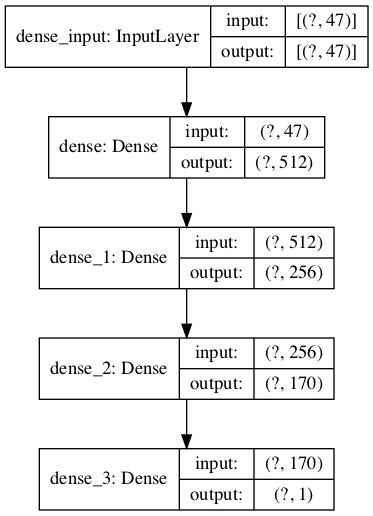

In [48]:
# Darstellung der Architektur des KNN-Regressionsmodell
plot_model(seq_model, 'Images/Sequential Regression Model.png', show_shapes=True)

In [49]:
history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[red_lr])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es, red_lr])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/300
1385/1385 [==============================] - 3s 2ms/step - loss: 10601720832.0000 - mse: 10601720832.0000 - rmse: 102964.6562 - mae: 47512.3203 - val_loss: 6680989184.0000 - val_mse: 6680989184.0000 - val_rmse: 81737.3203 - val_mae: 38908.5547
Epoch 2/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6822854144.0000 - mse: 6822854144.0000 - rmse: 82600.5703 - mae: 38591.8398 - val_loss: 6540531712.0000 - val_mse: 6540531712.0000 - val_rmse: 80873.5547 - val_mae: 39490.5195
Epoch 3/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6631455744.0000 - mse: 6631455744.0000 - rmse: 81433.7500 - mae: 38156.0742 - val_loss: 6392665600.0000 - val_mse: 6392665600.0000 - val_rmse: 79954.1484 - val_mae: 38214.1484
Epoch 4/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6555120128.0000 - mse: 6555120128.0000 - rmse: 80963.6953 - mae: 37850.8516 - val_loss: 6346155008.0000 - val_mse: 6346155008.0000 - val_rmse: 79662.7578 - val_m

1385/1385 [==============================] - 3s 2ms/step - loss: 5914561536.0000 - mse: 5914561536.0000 - rmse: 76906.1875 - mae: 36126.2422 - val_loss: 6015988736.0000 - val_mse: 6015988736.0000 - val_rmse: 77562.8047 - val_mae: 37926.3398
Epoch 34/300
1385/1385 [==============================] - 3s 2ms/step - loss: 5901267968.0000 - mse: 5901267968.0000 - rmse: 76819.7109 - mae: 36161.2969 - val_loss: 6255358976.0000 - val_mse: 6255358976.0000 - val_rmse: 79090.8281 - val_mae: 37920.3086
Epoch 35/300
1385/1385 [==============================] - 3s 2ms/step - loss: 5902809088.0000 - mse: 5902809088.0000 - rmse: 76829.7422 - mae: 36097.8477 - val_loss: 6113753088.0000 - val_mse: 6113753088.0000 - val_rmse: 78190.4922 - val_mae: 37293.6836
Epoch 36/300
1385/1385 [==============================] - 3s 2ms/step - loss: 5867488256.0000 - mse: 5867488256.0000 - rmse: 76599.5312 - mae: 36044.7930 - val_loss: 5988302848.0000 - val_mse: 5988302848.0000 - val_rmse: 77384.1250 - val_mae: 35563.73

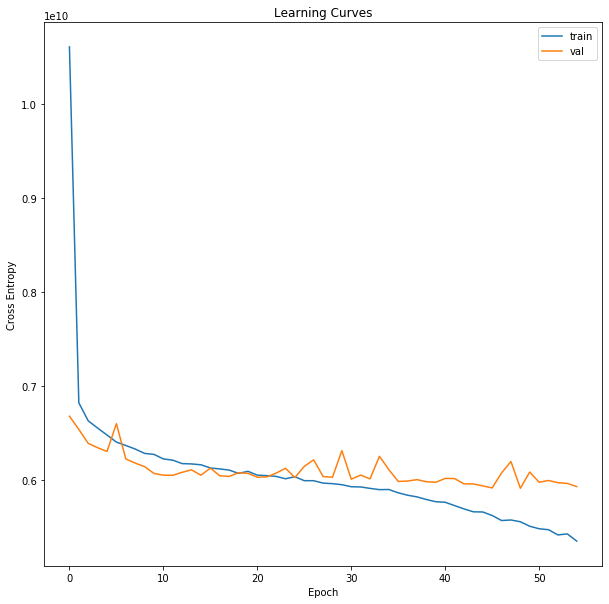

In [50]:
# Darstellung der Lernkurve (Trainingsdatenfehler vs. Testdatenfehler)
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [51]:
# Evaluation des Regressionsmodells
error = seq_model.evaluate(X_test, y_test)

594/594 [==============================] - 1s 974us/step - loss: 5933878784.0000 - mse: 5933878784.0000 - rmse: 77031.6719 - mae: 35095.1523


Text(0, 0.5, 'Vorhergesagte Werte (Test Daten)')

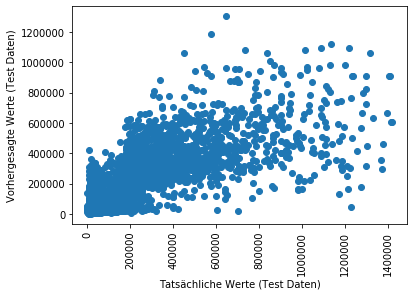

In [53]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data

predictions= seq_model.predict(X_test)
plt.plot(y_test, predictions, 'o')
plt.xlabel('Tatsächliche Werte (Test Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Test Daten)')

Text(0, 0.5, 'Vorhergesagte Werte (Trainings Daten)')

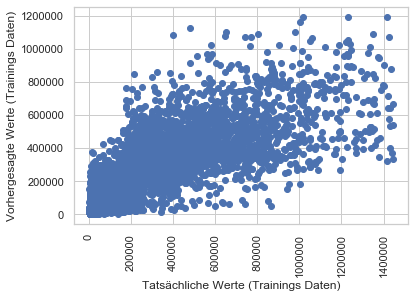

In [103]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
train_predictions=seq_model.predict(X_train)
plt.plot(y_train, train_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Trainings Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Trainings Daten)')

In [54]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_seq = r2_score(y_test, predictions)
r2_seq

0.6845000722870389

In [55]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_seq = 1-(1-r2_seq)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))

In [56]:
print(('R2: %.6f \t Adj. R2: %.6f \t RMSE: %.0f  \t MSE: %.0f \t MAE: %.0f' % 
      (r2_seq, adj_r2_seq, error[2], error[1], error[3])).replace('.', ','))

0,684500 	 0,684201 	 77032  	 5933878784 	 35095


In [58]:
predictions = predictions.flatten()

In [59]:
train_predictions = train_predictions.flatten()

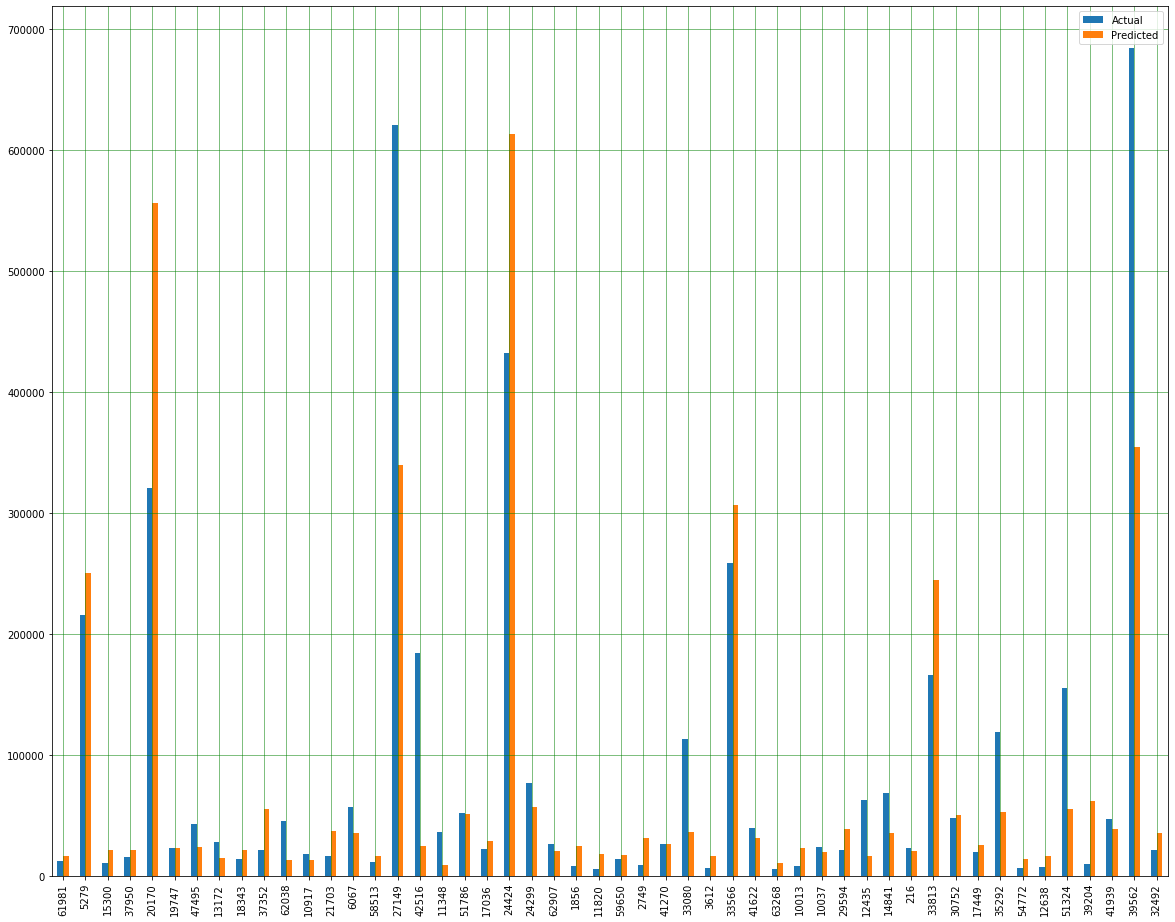

In [60]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

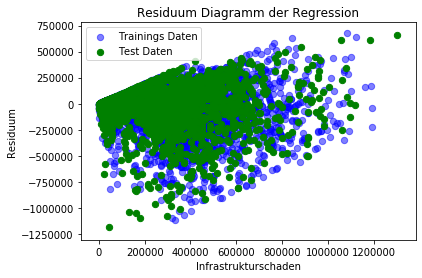

In [61]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(train_predictions, train_predictions - y_train, c='b', s=40, alpha=0.5, label='Trainings Daten')
plt.scatter(predictions, predictions - y_test, c='g', s=40, label='Test Daten')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residuum Diagramm der Regression')
plt.ylabel('Residuum')
plt.xlabel('Infrastrukturschaden')
plt.legend()
plt.show()

## Functional API Regression Model with Keras

In [62]:
# Funktion zur Erstellung eines KNN-Regressionmodells mit der Keras Functional API
def create_func_model(learning_rate = 0.001, activation = 'relu', activation2='relu', dropout=0, hidden_layers=2, initital_neurons=n_features):
    x_in = Input(shape=(n_features,))
    dense = Dense(int(initital_neurons), activation=activation)
    x = dense(x_in)
    if (dropout > 0):    
        x = Dropout(dropout)(x)
    if (hidden_layers > 1):
        i=1
        hidden_neurons = int(initital_neurons)
        while (i<=(hidden_layers-1)):
            neurons = int(hidden_neurons/(i+1))
            if (neurons <= 0):
                neurons = n_features
            x = Dense(neurons, activation=activation2)(x)
            if (dropout > 0):    
                x = Dropout(dropout)(x)
            i+=1
    x_out = Dense(1)(x)
    func_model = Model(inputs=x_in, outputs=x_out)
    return func_model

In [63]:
# Erstellung des KNN Regressionsmodell mit der Keras Functional API
func_model = create_func_model(learning_rate=learning_rate, activation=activation, activation2=activation2, dropout=dropout, hidden_layers=hidden_layers, initital_neurons=neurons)

In [64]:
func_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               24576     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 170)               43690     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 171       
Total params: 199,765
Trainable params: 199,765
Non-trainable params: 0
_________________________________________________________________


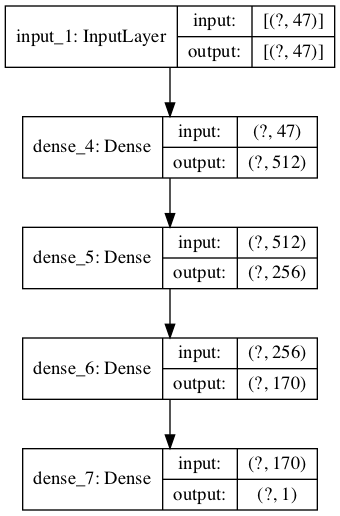

In [65]:
# Erstellung der KNN Architektur
plot_model(func_model, 'Images/Functional API Regression Model.png', show_shapes=True)

In [66]:
# Festlegen des Optimizers und der Regressionsmetriken
func_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [67]:
func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[red_lr])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es, red_lr])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Epoch 1/300
1385/1385 [==============================] - 3s 2ms/step - loss: 8427123200.0000 - mse: 8427123200.0000 - rmse: 91799.3672 - mae: 42583.8359 - val_loss: 6533840896.0000 - val_mse: 6533840896.0000 - val_rmse: 80832.1797 - val_mae: 39185.7773
Epoch 2/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6811244544.0000 - mse: 6811244544.0000 - rmse: 82530.2656 - mae: 38544.6719 - val_loss: 6397197312.0000 - val_mse: 6397197312.0000 - val_rmse: 79982.4844 - val_mae: 37451.6836
Epoch 3/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6630501376.0000 - mse: 6630501376.0000 - rmse: 81427.8906 - mae: 38036.9648 - val_loss: 6334534144.0000 - val_mse: 6334534144.0000 - val_rmse: 79589.7891 - val_mae: 37429.2422
Epoch 4/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6518535168.0000 - mse: 6518535168.0000 - rmse: 80737.4453 - mae: 37776.2070 - val_loss: 6282547712.0000 - val_mse: 6282547712.0000 - val_rmse: 79262.5234 - val_mae:

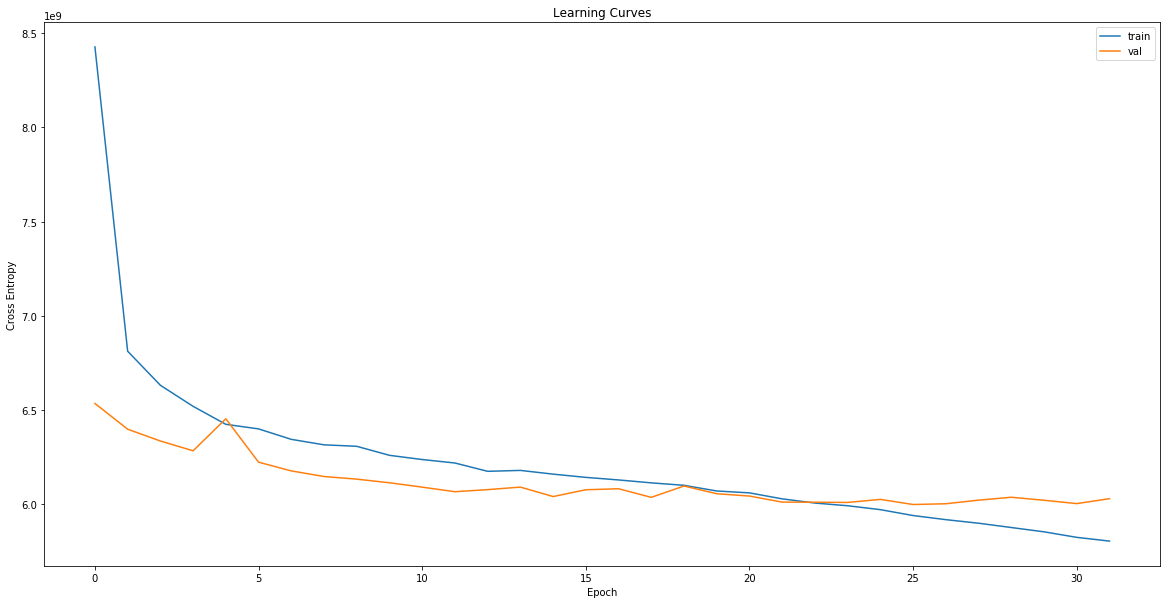

In [68]:
# Darstellung der Lernkurve (Trainingsdatenfehler vs. Testdatenfehler)
plt.figure(figsize=(20,10))
plt.plot(func_history.history['loss'], label='train')
plt.plot(func_history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

Text(0, 0.5, 'Vorhergesagte Werte (Test Daten)')

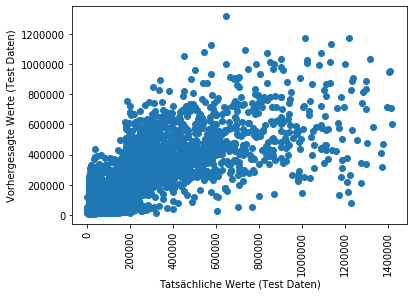

In [70]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data
func_predictions=func_model.predict(X_test)
plt.plot(y_test, func_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Test Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Test Daten)')

Text(0, 0.5, 'Vorhergesagte Werte (Trainings Daten)')

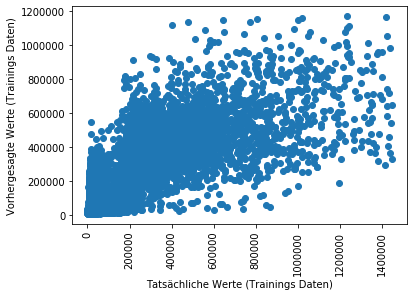

In [74]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
func_train_predictions=func_model.predict(X_train)
plt.plot(y_train, func_train_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Trainings Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Trainings Daten)')

In [105]:
# Evaluation des Regressionsmodells
error_func = func_model.evaluate(X_test, y_test, verbose=0)

In [71]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_func = r2_score(y_test, func_predictions)
r2_func

0.6794783073353972

In [72]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_func = 1-(1-r2_func)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
adj_r2_func

0.6791740948140176

In [104]:
print(('R2: %.6f \t Adj. R2: %.6f \t RMSE: %.0f  \t MSE: %.0f \t MAE: %.0f' % 
      (r2_func, adj_r2_func, error_func[2], error_func[1], error_func[3])).replace('.', ','))

R2: 0,679478 	 Adj, R2: 0,679174 	 RMSE: 77642  	 MSE: 6028323328 	 MAE: 35899


In [75]:
func_predictions = func_predictions.flatten()

In [76]:
func_train_predictions = func_train_predictions.flatten()

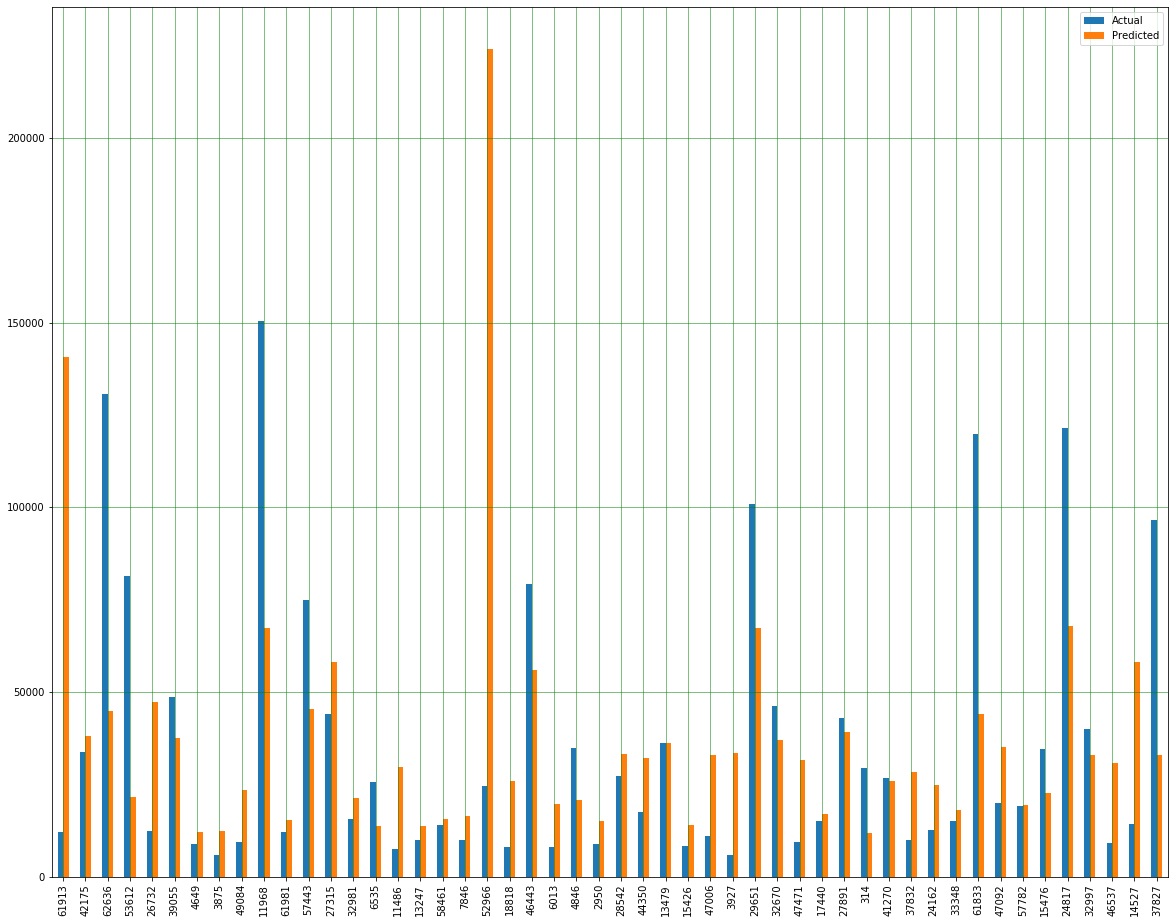

In [77]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': func_predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

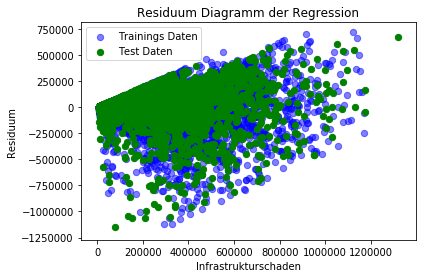

In [78]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(func_train_predictions, func_train_predictions - y_train, c='b', s=40, alpha=0.5, label='Trainings Daten')
plt.scatter(func_predictions, func_predictions - y_test, c='g', s=40, label='Test Daten')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residuum Diagramm der Regression')
plt.ylabel('Residuum')
plt.xlabel('Infrastrukturschaden')
plt.legend()
plt.show()

##  Regression with Scikit-Learn

In [79]:
def get_rmse_r2(mod, X_test, y_Test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_Test, y_pred)
    adj_r2 = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
    mae = mean_absolute_error(y_Test, y_pred)
    return np.sqrt(mean_squared_error(y_Test, y_pred)), mae, r2, adj_r2, mod.__class__.__name__

In [80]:
d_rmse = dict()
d_mae = dict()
d_r2 = dict()
d_adj_r2 = dict()

In [81]:
# Vergleich mit Linearer Regression
lr = LinearRegression().fit(X_train, y_train)
rmse, mae, r2, adj_r2, lr_name = get_rmse_r2(lr, X_test, y_test)
d_rmse['Linear Regression'] = [rmse]
d_mae['Linear Regression'] = [mae]
d_r2['Linear Regression'] = [r2]
d_adj_r2['Linear Regression'] = [adj_r2]
print ('(' + lr_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(LinearRegression) RMSE: 91676.10982671703  MAE: 48909.049199325746  R2: 0.5531383200069478 Adjusted R2: 0.5527141960818291


In [82]:
# Vergleich mit Ridge Regression
ridge = Ridge(random_state=0).fit(X_train, y_train)
rmse, mae, r2, adj_r2, ridge_name = get_rmse_r2(ridge, X_test, y_test)
d_rmse['Ridge Regression'] = [rmse]
d_mae['Ridge Regression'] = [mae]
d_r2['Ridge Regression'] = [r2]
d_adj_r2['Ridge Regression'] = [adj_r2]
print ('(' + ridge_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(Ridge) RMSE: 91655.62328635743  MAE: 48901.301379374425  R2: 0.5533380149325028 Adjusted R2: 0.5529140805411916


In [83]:
# Vergleich mit Lasso Regression
lasso = Lasso(random_state=0).fit(X_train, y_train)
rmse, mae, r2, adj_r2, lasso_name = get_rmse_r2(lasso, X_test, y_test)
d_rmse['Lasso Regression'] = [rmse]
d_mae['Lasso Regression'] = [mae]
d_r2['Lasso Regression'] = [r2]
d_adj_r2['Lasso Regression'] = [adj_r2]
print ('(' + lasso_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(Lasso) RMSE: 91655.02731024406  MAE: 48899.49776165834  R2: 0.553343823610658 Adjusted R2: 0.552919894732461


In [84]:
# Vergleich mit Elastic Net Regression
en = ElasticNet(random_state=0, alpha=0.2).fit(X_train, y_train)
rmse, mae, r2, adj_r2, en_name = get_rmse_r2(en, X_test, y_test)
d_rmse['Elastic Net Regression'] = [rmse]
d_mae['Elastic Net Regression'] = [mae]
d_r2['Elastic Net Regression'] = [r2]
d_adj_r2['Elastic Net Regression'] = [adj_r2]
print ('(' + en_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(ElasticNet) RMSE: 95540.17849880808  MAE: 48727.15337926642  R2: 0.5146747821056137 Adjusted R2: 0.5142141517907126


In [85]:
d_rmse['Neuronale Netzwerk Regression']=[error[2]]
d_mae['Neuronale Netzwerk Regression']=[error[3]]
d_r2['Neuronale Netzwerk Regression']=[r2_seq]
d_adj_r2['Neuronale Netzwerk Regression']=[adj_r2_seq]

In [94]:
# Funktion zur Beschriftung der Säulen
def bar_values(ax, scoretype = 'Default'):
    for p in ax.patches:
        if (scoretype == 'RMSE' or scoretype =='MAE'):
            ax.annotate(format(p.get_height(), ',.0f').replace(",","."), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), fontsize=16, textcoords = 'offset points')
        else:
            ax.annotate(format(p.get_height(), ',.4f').replace(",","."), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), fontsize=16, textcoords = 'offset points')
    return ax

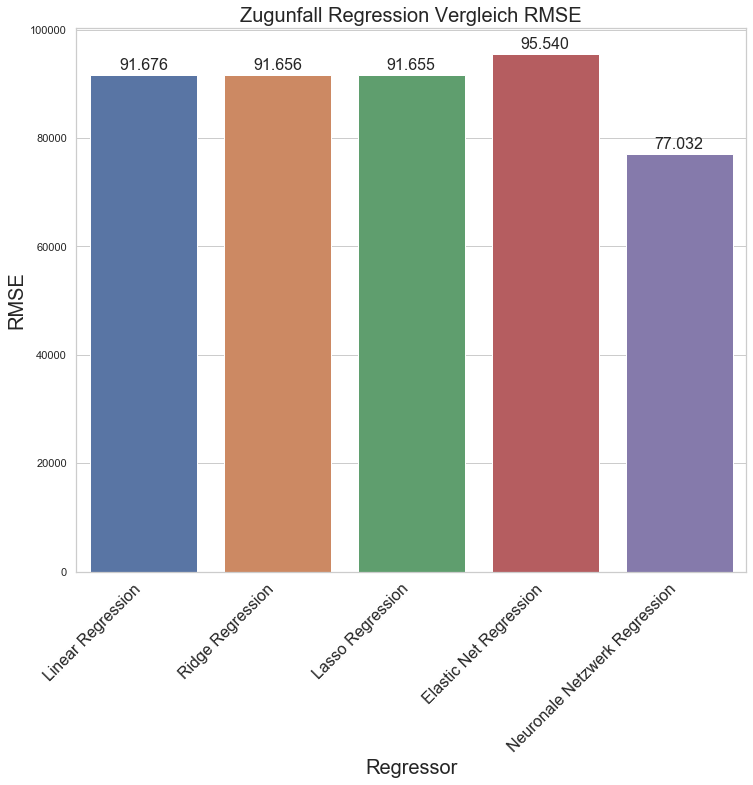

In [100]:
# Diagrammerstellung mit den RMSE Werten
algo, rmse = [], []
for key, value in d_rmse.items():
    algo.append(key)
    rmse.append(value[0]) 
plt.figure('RMSE', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(algo, rmse)
ax = bar_values(ax, 'RMSE')
plt.title('Zugunfall Regression Vergleich RMSE', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('RMSE', fontsize=20) 
plt.savefig('Images/Regression/RMSE_Vergleich.png', bbox_inches='tight')
plt.show()

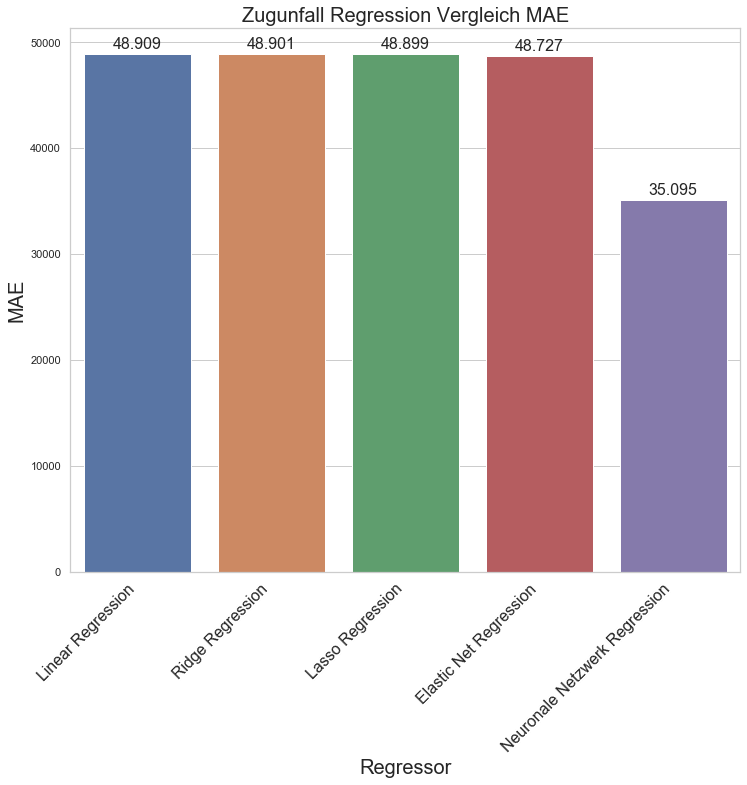

In [99]:
# Diagrammerstellung mit den MAE Werten
mae_algo, mae = [], []
for key, value in d_mae.items():
    mae_algo.append(key)
    mae.append(value[0]) 
plt.figure('MAE', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(mae_algo, mae)
ax = bar_values(ax, 'MAE')
plt.title('Zugunfall Regression Vergleich MAE', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('MAE', fontsize=20) 
plt.savefig('Images/Regression/MAE_Vergleich.png', bbox_inches='tight')
plt.show()

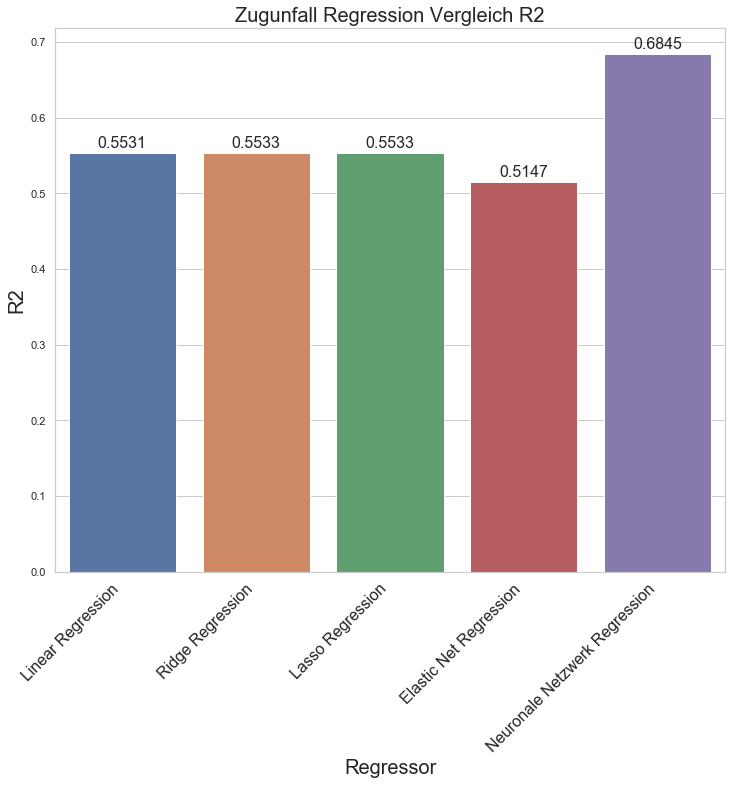

In [98]:
# Diagrammerstellung mit den R2 Werten
r2_algo, r2 = [], []
for key, value in d_r2.items():
    r2_algo.append(key)
    r2.append(value[0]) 
plt.figure('R2', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(r2_algo, r2) 
ax = bar_values(ax)
plt.title('Zugunfall Regression Vergleich R2', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('R2', fontsize=20) 
plt.savefig('Images/Regression/R2_Vergleich.png', bbox_inches='tight')
plt.show()

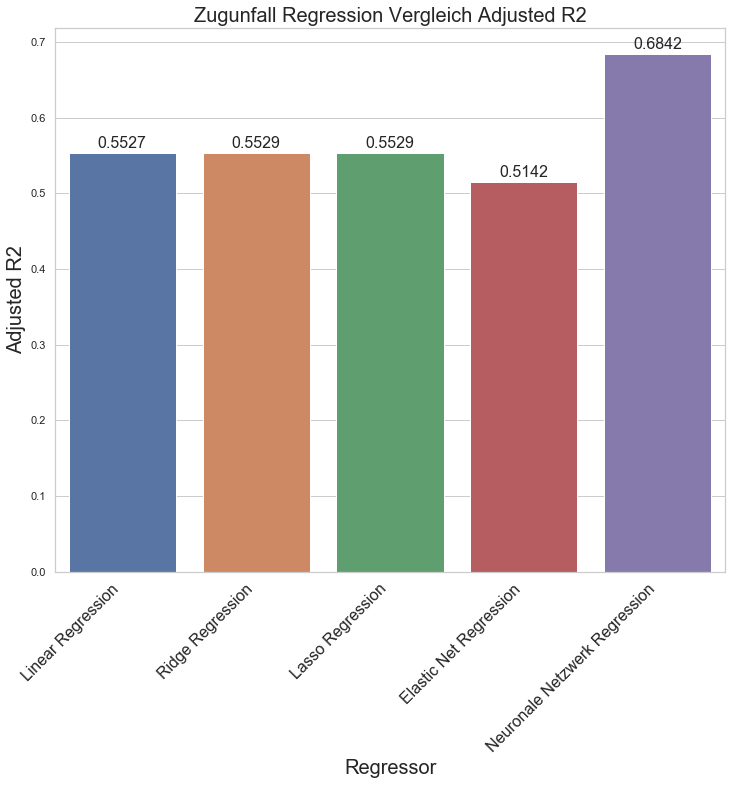

In [101]:
# Diagrammerstellung mit den Adj. R2 Werten
adj_r2_algo, adj_r2 = [], []
for key, value in d_adj_r2.items():
    adj_r2_algo.append(key)
    adj_r2.append(value[0]) 
plt.figure('Adjusted R2', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(adj_r2_algo, adj_r2) 
ax = bar_values(ax)
plt.title('Zugunfall Regression Vergleich Adjusted R2', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('Adjusted R2', fontsize=20) 
plt.savefig('Images/Regression/Adj_R2_Vergleich.png', bbox_inches='tight')
plt.show()